# This file is used to train

In [1]:
import torch
import numpy as np
from tqdm import tqdm
import pandas as pd
from sc_model import SC_LSTM as Model

# Device init

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    !nvidia-smi
    print(torch.cuda.get_device_name(0))

else:
    print("No GPU :(")

Sun Jul  9 05:37:43 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.41.03              Driver Version: 530.41.03    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1650 Ti      Off| 00000000:01:00.0  On |                  N/A |
| N/A   47C    P3               15W /  N/A|    916MiB /  4096MiB |     28%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
device = 'cpu'

## Loading the data

In [4]:
from Data.PreprocessorOfGeneratedData import Preprocessor

preproc = Preprocessor()

data = pd.read_csv('../Data/schedule_gen.csv')
data

,Label Number,Duration,Importance,Start Time,Date
0,0,20,0,10:13,10/07/2023
1,1,80,1,12:13,10/07/2023
2,1,40,2,14:53,10/07/2023
3,3,170,2,17:13,10/07/2023
4,1,30,1,20:53,10/07/2023
...,...,...,...,...,...
5386,2,70,0,15:25,16/09/2025
5387,0,20,0,17:00,16/09/2025
5388,1,80,1,18:45,16/09/2025
5389,0,30,1,21:20,16/09/2025


In [5]:
input_data, type_vector, output_data = preproc.preprocess('../Data/schedule_gen.csv')

In [6]:
input_data

,Label Number_0,Label Number_1,Label Number_2,Label Number_3,Duration,Importance_0,Importance_1,Importance_2,Importance_3,Time_Min,...,Date_Month_sin,Date_Month_cos,Plan_Time_Min,Plan_Time_Min_sin,Plan_Time_Min_cos,Plan_Date_Categorical,Plan_Date_Day_sin,Plan_Date_Day_cos,Plan_Date_Month_sin,Plan_Date_Month_cos
0,0,0,0,0,0.090909,0,0,0,0,0.425694,...,-0.5,-8.660254e-01,0.421528,0.473320,-0.880891,0.523288,0.897805,-0.440394,-0.5,-8.660254e-01
1,0,1,0,0,0.454545,0,1,0,0,0.509028,...,-0.5,-8.660254e-01,0.421528,0.473320,-0.880891,0.523288,0.897805,-0.440394,-0.5,-8.660254e-01
2,0,0,0,0,0.212121,0,0,0,0,0.620139,...,-0.5,-8.660254e-01,0.421528,0.473320,-0.880891,0.523288,0.897805,-0.440394,-0.5,-8.660254e-01
3,0,0,0,0,1.000000,0,0,0,0,0.717361,...,-0.5,-8.660254e-01,0.421528,0.473320,-0.880891,0.523288,0.897805,-0.440394,-0.5,-8.660254e-01
4,0,0,0,0,0.151515,0,0,0,0,0.000000,...,-0.5,-8.660254e-01,0.421528,0.473320,-0.880891,0.523288,0.897805,-0.440394,-0.5,-8.660254e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5386,0,0,0,0,0.393939,0,0,0,0,0.642361,...,0.0,1.000000e+00,0.521528,-0.134851,-0.990866,0.709589,-0.207912,-0.978148,-1.0,-1.836970e-16
5387,0,0,0,0,0.090909,0,0,0,0,0.708333,...,-1.0,-1.836970e-16,0.704861,-0.960050,-0.279829,0.709589,-0.207912,-0.978148,-1.0,-1.836970e-16
5388,0,0,0,0,0.454545,0,0,0,0,0.781250,...,-1.0,-1.836970e-16,0.704861,-0.960050,-0.279829,0.709589,-0.207912,-0.978148,-1.0,-1.836970e-16
5389,0,0,0,0,0.151515,0,0,0,0,0.000000,...,-1.0,-1.836970e-16,0.704861,-0.960050,-0.279829,0.709589,-0.207912,-0.978148,-1.0,-1.836970e-16


In [7]:
# make the data positive
output_data = np.abs(np.array(output_data, dtype=np.float64))
pd.DataFrame(output_data)

,0,1,2
0,0.425694,0.013889,0.000000
1,0.509028,0.055556,0.000000
2,0.620139,0.027778,0.000000
3,0.717361,0.118056,0.000000
4,0.000000,0.020833,0.000000
...,...,...,...
5386,0.642361,0.048611,0.000000
5387,0.708333,0.015972,0.002083
5388,0.781250,0.055556,0.000000
5389,0.000000,0.020833,0.000000


In [8]:
from sklearn.preprocessing import MinMaxScaler

# Normalize input data
scaler = MinMaxScaler()
input_data = scaler.fit_transform(input_data)

## Creating the dataset

In [9]:
from torch.utils.data import Dataset, DataLoader

class ScheduleDataset(Dataset):
    def __init__(self, input_data, type_vector, output_vector, task_types='all', transform=None):
        if task_types == 'all':
            self.input_data = input_data
            self.type_vector = type_vector
            self.output_vector = output_vector
        elif task_types == 'resched':
            self.input_data = []
            self.type_vector = []
            self.output_vector = []
            for i in range(len(input_data)):
                if type_vector[i] == "resched":
                    self.input_data.append(input_data[i])
                    self.type_vector.append(type_vector[i])
                    self.output_vector.append(output_vector[i])
        elif task_types == 'non-resched':
            self.input_data = []
            self.type_vector = []
            self.output_vector = []
            for i in range(len(input_data)):
                if type_vector[i] == "non-resched":
                    self.input_data.append(input_data[i])
                    self.type_vector.append(type_vector[i])
                    self.output_vector.append(output_vector[i])
        else:
            raise ValueError("task_types must be 'all', 'resched', or 'non-resched'")
        self.transform = transform

    def __len__(self):
        return len(self.input_data)

    def __getitem__(self, idx):
        return self.input_data[idx], self.type_vector[idx], self.output_vector[idx]

In [10]:
resched_dataset = ScheduleDataset(input_data, type_vector, output_data, task_types='resched')
non_resched_dataset = ScheduleDataset(input_data, type_vector, output_data, task_types='non-resched')
all_dataset = ScheduleDataset(input_data, type_vector, output_data, task_types='all')

print(f"Resched dataset size: {len(resched_dataset)}\n"
      f"Non-resched dataset size: {len(non_resched_dataset)}\n"
      f"All dataset size: {len(all_dataset)}")

Resched dataset size: 4307
Non-resched dataset size: 1084
All dataset size: 5391


## Create dataloaders

In [11]:
batch_size = 1
# resched_dataset_size = len(resched_dataset)
# train_size = int(resched_dataset_size * 0.8)
# test_size = resched_dataset_size - train_size
#
# train_resched_dataset, test_resched_dataset = torch.utils.data.random_split(resched_dataset, [train_size, test_size])

train_resched_dataloader = DataLoader(resched_dataset, batch_size=batch_size)
# valid_resched_dataloader = DataLoader2(resched_dataset, batch_size=batch_size)

train_non_resched_dataloader = DataLoader(non_resched_dataset, batch_size=batch_size)

## Create free time slots generator

In [12]:
from Data.GeneratorOfAvailableTimeslots import GeneratorOfAvailableTimeslots

time_slots_gen = GeneratorOfAvailableTimeslots(5)
time_slots = time_slots_gen.generate_available_timeslots()

time_slots      # TODO: why all the intervals are closed?
single_interval = time_slots[0]
single_interval


array([[0.00186126, 0.00782946],
       [0.2175082 , 0.29679193],
       [0.45655021, 0.46892625],
       [0.67676658, 0.68379156],
       [0.84134667, 0.84631657],
       [0.88261707, 0.88486336],
       [0.92585593, 0.92643127],
       [0.95966872, 0.96078957],
       [0.97118044, 0.97141489],
       [0.97732092, 0.97828762],
       [0.98468989, 0.98528005],
       [0.98604347, 0.98632432]])

## Init the model

In [13]:
# check if the dataloader works and get the input and output sizes
for i, (features, a, ans) in enumerate(train_resched_dataloader):
    in_features = features.shape[1]             # 25
    out_features = ans.shape[1]                 # 3
    break

n_layers = 1
hidden_size = 124
hidden_injector = 64

# Create the model
SC_LSTM = Model(in_features, n_layers, hidden_size, out_features, batch_size, hidden_injector=hidden_injector).to(device)

# Training the model

In [14]:
# Configure hyper-parameters
epochs = 10
learning_rate = 0.001
loss_func = torch.nn.MSELoss()
optimizer = torch.optim.Adam(SC_LSTM.parameters(), lr=learning_rate)

history = []
loss_accomulator = []
mean_loss = None

In [15]:
# Firstly train the LSTM using only reschedulable tasks
SC_LSTM.train_model(mode='lstm')

for epoch in range(0, epochs):
    SC_LSTM.reset_states()
    for i, (X, task_type, Y) in enumerate(tqdm(train_resched_dataloader, desc=f"Epoch: {epoch + 1}, Mean Loss: {mean_loss}", leave=False, colour='green')):

        # Convert X and Y to the correct type
        X = torch.Tensor(X).type(torch.float32).to(device)
        Y = torch.Tensor(Y).type(torch.float32).to(device)

        # Make prediction
        Y_pred = SC_LSTM.forward(X, task_type=task_type, free_time_slots=single_interval, save_states=True)
        print(Y_pred)

        # Calculate loss
        loss = loss_func(Y_pred.view(-1, ), Y.view(-1, ))

        # Backward pass
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Append loss to list
        loss_accomulator.append(loss.item())

    mean_loss = np.mean(loss_accomulator)
    history.append(mean_loss)
    loss_accomulator = []

Epoch: 1, Mean Loss: None:   0%|          | 0/4307 [00:00<?, ?it/s]

tensor([[0.4794, 0.5045, 0.4951]], grad_fn=<SigmoidBackward0>)
tensor([[0.4798, 0.4983, 0.4893]], grad_fn=<SigmoidBackward0>)


Epoch: 1, Mean Loss: None:   1%|          | 40/4307 [00:00<00:19, 224.13it/s]

tensor([[0.4766, 0.4954, 0.4842]], grad_fn=<SigmoidBackward0>)
tensor([[0.4752, 0.4911, 0.4742]], grad_fn=<SigmoidBackward0>)
tensor([[0.4778, 0.4859, 0.4616]], grad_fn=<SigmoidBackward0>)
tensor([[0.4767, 0.4734, 0.4511]], grad_fn=<SigmoidBackward0>)
tensor([[0.4756, 0.4634, 0.4426]], grad_fn=<SigmoidBackward0>)
tensor([[0.4704, 0.4641, 0.4399]], grad_fn=<SigmoidBackward0>)
tensor([[0.4668, 0.4582, 0.4300]], grad_fn=<SigmoidBackward0>)
tensor([[0.4710, 0.4412, 0.4115]], grad_fn=<SigmoidBackward0>)
tensor([[0.4679, 0.4356, 0.3999]], grad_fn=<SigmoidBackward0>)
tensor([[0.4638, 0.4247, 0.3839]], grad_fn=<SigmoidBackward0>)
tensor([[0.4606, 0.4156, 0.3733]], grad_fn=<SigmoidBackward0>)
tensor([[0.4568, 0.4034, 0.3592]], grad_fn=<SigmoidBackward0>)
tensor([[0.4511, 0.3873, 0.3483]], grad_fn=<SigmoidBackward0>)
tensor([[0.4461, 0.3703, 0.3326]], grad_fn=<SigmoidBackward0>)
tensor([[0.4404, 0.3555, 0.3115]], grad_fn=<SigmoidBackward0>)
tensor([[0.4340, 0.3378, 0.2912]], grad_fn=<SigmoidBack

Epoch: 1, Mean Loss: None:   3%|▎         | 123/4307 [00:00<00:11, 352.81it/s]

tensor([[0.3775, 0.0223, 0.0106]], grad_fn=<SigmoidBackward0>)
tensor([[0.3700, 0.0224, 0.0105]], grad_fn=<SigmoidBackward0>)
tensor([[0.3655, 0.0223, 0.0102]], grad_fn=<SigmoidBackward0>)
tensor([[0.3530, 0.0222, 0.0102]], grad_fn=<SigmoidBackward0>)
tensor([[0.3588, 0.0225, 0.0102]], grad_fn=<SigmoidBackward0>)
tensor([[0.3713, 0.0228, 0.0102]], grad_fn=<SigmoidBackward0>)
tensor([[0.3807, 0.0236, 0.0105]], grad_fn=<SigmoidBackward0>)
tensor([[0.3913, 0.0240, 0.0103]], grad_fn=<SigmoidBackward0>)
tensor([[0.4050, 0.0239, 0.0100]], grad_fn=<SigmoidBackward0>)
tensor([[0.4215, 0.0245, 0.0101]], grad_fn=<SigmoidBackward0>)
tensor([[0.4319, 0.0249, 0.0105]], grad_fn=<SigmoidBackward0>)
tensor([[0.4480, 0.0251, 0.0105]], grad_fn=<SigmoidBackward0>)
tensor([[0.4678, 0.0259, 0.0108]], grad_fn=<SigmoidBackward0>)
tensor([[0.4829, 0.0266, 0.0109]], grad_fn=<SigmoidBackward0>)
tensor([[0.4980, 0.0272, 0.0109]], grad_fn=<SigmoidBackward0>)
tensor([[0.4955, 0.0275, 0.0110]], grad_fn=<SigmoidBack

Epoch: 1, Mean Loss: None:   5%|▍         | 207/4307 [00:00<00:10, 390.33it/s]

tensor([[0.5439, 0.0485, 0.0112]], grad_fn=<SigmoidBackward0>)
tensor([[0.5608, 0.0485, 0.0112]], grad_fn=<SigmoidBackward0>)
tensor([[0.5621, 0.0482, 0.0112]], grad_fn=<SigmoidBackward0>)
tensor([[0.5275, 0.0465, 0.0110]], grad_fn=<SigmoidBackward0>)
tensor([[0.5480, 0.0464, 0.0109]], grad_fn=<SigmoidBackward0>)
tensor([[0.5098, 0.0453, 0.0110]], grad_fn=<SigmoidBackward0>)
tensor([[0.5098, 0.0449, 0.0110]], grad_fn=<SigmoidBackward0>)
tensor([[0.4806, 0.0434, 0.0108]], grad_fn=<SigmoidBackward0>)
tensor([[0.4878, 0.0436, 0.0107]], grad_fn=<SigmoidBackward0>)
tensor([[0.4463, 0.0425, 0.0105]], grad_fn=<SigmoidBackward0>)
tensor([[0.4732, 0.0433, 0.0103]], grad_fn=<SigmoidBackward0>)
tensor([[0.4163, 0.0419, 0.0103]], grad_fn=<SigmoidBackward0>)
tensor([[0.3964, 0.0419, 0.0104]], grad_fn=<SigmoidBackward0>)
tensor([[0.3922, 0.0424, 0.0105]], grad_fn=<SigmoidBackward0>)
tensor([[0.3918, 0.0426, 0.0104]], grad_fn=<SigmoidBackward0>)
tensor([[0.3517, 0.0422, 0.0104]], grad_fn=<SigmoidBack

Epoch: 1, Mean Loss: None:   6%|▌         | 249/4307 [00:00<00:10, 398.78it/s]

tensor([[0.5569, 0.0466, 0.0125]], grad_fn=<SigmoidBackward0>)
tensor([[0.5933, 0.0460, 0.0121]], grad_fn=<SigmoidBackward0>)
tensor([[0.5878, 0.0472, 0.0125]], grad_fn=<SigmoidBackward0>)
tensor([[0.5891, 0.0473, 0.0124]], grad_fn=<SigmoidBackward0>)
tensor([[0.5885, 0.0460, 0.0118]], grad_fn=<SigmoidBackward0>)
tensor([[0.5778, 0.0464, 0.0118]], grad_fn=<SigmoidBackward0>)
tensor([[0.5466, 0.0458, 0.0123]], grad_fn=<SigmoidBackward0>)
tensor([[0.5749, 0.0454, 0.0122]], grad_fn=<SigmoidBackward0>)
tensor([[0.6180, 0.0449, 0.0120]], grad_fn=<SigmoidBackward0>)
tensor([[0.6211, 0.0457, 0.0122]], grad_fn=<SigmoidBackward0>)
tensor([[0.6289, 0.0458, 0.0122]], grad_fn=<SigmoidBackward0>)
tensor([[0.6342, 0.0457, 0.0123]], grad_fn=<SigmoidBackward0>)
tensor([[0.6148, 0.0455, 0.0126]], grad_fn=<SigmoidBackward0>)
tensor([[0.6385, 0.0452, 0.0122]], grad_fn=<SigmoidBackward0>)
tensor([[0.5866, 0.0433, 0.0118]], grad_fn=<SigmoidBackward0>)
tensor([[0.6613, 0.0435, 0.0114]], grad_fn=<SigmoidBack

Epoch: 1, Mean Loss: None:   7%|▋         | 289/4307 [00:00<00:10, 371.63it/s]

tensor([[0.5863, 0.0395, 0.0110]], grad_fn=<SigmoidBackward0>)
tensor([[0.6171, 0.0397, 0.0107]], grad_fn=<SigmoidBackward0>)
tensor([[0.6124, 0.0399, 0.0106]], grad_fn=<SigmoidBackward0>)
tensor([[0.6080, 0.0402, 0.0106]], grad_fn=<SigmoidBackward0>)
tensor([[0.5211, 0.0394, 0.0109]], grad_fn=<SigmoidBackward0>)
tensor([[0.5826, 0.0392, 0.0106]], grad_fn=<SigmoidBackward0>)
tensor([[0.6295, 0.0398, 0.0107]], grad_fn=<SigmoidBackward0>)
tensor([[0.6398, 0.0403, 0.0110]], grad_fn=<SigmoidBackward0>)
tensor([[0.6449, 0.0405, 0.0112]], grad_fn=<SigmoidBackward0>)
tensor([[0.6540, 0.0408, 0.0111]], grad_fn=<SigmoidBackward0>)
tensor([[0.5325, 0.0395, 0.0108]], grad_fn=<SigmoidBackward0>)
tensor([[0.6252, 0.0397, 0.0106]], grad_fn=<SigmoidBackward0>)
tensor([[0.6177, 0.0401, 0.0106]], grad_fn=<SigmoidBackward0>)
tensor([[0.6225, 0.0401, 0.0104]], grad_fn=<SigmoidBackward0>)
tensor([[0.6177, 0.0401, 0.0103]], grad_fn=<SigmoidBackward0>)
tensor([[0.5763, 0.0399, 0.0106]], grad_fn=<SigmoidBack

Epoch: 1, Mean Loss: None:   8%|▊         | 331/4307 [00:00<00:10, 385.13it/s]

tensor([[0.4905, 0.0454, 0.0109]], grad_fn=<SigmoidBackward0>)
tensor([[0.4921, 0.0451, 0.0108]], grad_fn=<SigmoidBackward0>)
tensor([[0.4870, 0.0448, 0.0105]], grad_fn=<SigmoidBackward0>)
tensor([[0.3950, 0.0442, 0.0109]], grad_fn=<SigmoidBackward0>)
tensor([[0.4484, 0.0435, 0.0107]], grad_fn=<SigmoidBackward0>)
tensor([[0.4935, 0.0439, 0.0110]], grad_fn=<SigmoidBackward0>)
tensor([[0.5861, 0.0447, 0.0114]], grad_fn=<SigmoidBackward0>)
tensor([[0.5407, 0.0447, 0.0118]], grad_fn=<SigmoidBackward0>)
tensor([[0.4664, 0.0433, 0.0112]], grad_fn=<SigmoidBackward0>)
tensor([[0.5087, 0.0429, 0.0111]], grad_fn=<SigmoidBackward0>)
tensor([[0.4751, 0.0418, 0.0110]], grad_fn=<SigmoidBackward0>)
tensor([[0.4711, 0.0411, 0.0109]], grad_fn=<SigmoidBackward0>)
tensor([[0.6388, 0.0427, 0.0110]], grad_fn=<SigmoidBackward0>)
tensor([[0.5408, 0.0435, 0.0118]], grad_fn=<SigmoidBackward0>)
tensor([[0.4519, 0.0430, 0.0115]], grad_fn=<SigmoidBackward0>)
tensor([[0.5252, 0.0427, 0.0114]], grad_fn=<SigmoidBack

Epoch: 1, Mean Loss: None:   9%|▊         | 372/4307 [00:01<00:10, 390.21it/s]

tensor([[0.4255, 0.0442, 0.0119]], grad_fn=<SigmoidBackward0>)
tensor([[0.4953, 0.0434, 0.0114]], grad_fn=<SigmoidBackward0>)
tensor([[0.5647, 0.0447, 0.0125]], grad_fn=<SigmoidBackward0>)
tensor([[0.6175, 0.0449, 0.0128]], grad_fn=<SigmoidBackward0>)
tensor([[0.6247, 0.0461, 0.0133]], grad_fn=<SigmoidBackward0>)
tensor([[0.6236, 0.0468, 0.0129]], grad_fn=<SigmoidBackward0>)
tensor([[0.4187, 0.0463, 0.0129]], grad_fn=<SigmoidBackward0>)
tensor([[0.4206, 0.0439, 0.0117]], grad_fn=<SigmoidBackward0>)
tensor([[0.5741, 0.0459, 0.0124]], grad_fn=<SigmoidBackward0>)
tensor([[0.4210, 0.0467, 0.0128]], grad_fn=<SigmoidBackward0>)
tensor([[0.5992, 0.0466, 0.0126]], grad_fn=<SigmoidBackward0>)
tensor([[0.3852, 0.0475, 0.0131]], grad_fn=<SigmoidBackward0>)
tensor([[0.3963, 0.0459, 0.0120]], grad_fn=<SigmoidBackward0>)
tensor([[0.3289, 0.0464, 0.0118]], grad_fn=<SigmoidBackward0>)
tensor([[0.3434, 0.0465, 0.0115]], grad_fn=<SigmoidBackward0>)
tensor([[0.4019, 0.0475, 0.0116]], grad_fn=<SigmoidBack

Epoch: 1, Mean Loss: None:  10%|▉         | 414/4307 [00:01<00:09, 397.26it/s]

tensor([[0.2712, 0.0584, 0.0131]], grad_fn=<SigmoidBackward0>)
tensor([[0.4394, 0.0548, 0.0125]], grad_fn=<SigmoidBackward0>)
tensor([[0.4142, 0.0557, 0.0132]], grad_fn=<SigmoidBackward0>)
tensor([[0.3414, 0.0547, 0.0125]], grad_fn=<SigmoidBackward0>)
tensor([[0.6034, 0.0527, 0.0126]], grad_fn=<SigmoidBackward0>)
tensor([[0.4873, 0.0554, 0.0134]], grad_fn=<SigmoidBackward0>)
tensor([[0.3590, 0.0541, 0.0130]], grad_fn=<SigmoidBackward0>)
tensor([[0.5196, 0.0523, 0.0126]], grad_fn=<SigmoidBackward0>)
tensor([[0.5444, 0.0539, 0.0132]], grad_fn=<SigmoidBackward0>)
tensor([[0.3744, 0.0543, 0.0131]], grad_fn=<SigmoidBackward0>)
tensor([[0.7372, 0.0509, 0.0128]], grad_fn=<SigmoidBackward0>)
tensor([[0.5920, 0.0532, 0.0140]], grad_fn=<SigmoidBackward0>)
tensor([[0.3460, 0.0542, 0.0139]], grad_fn=<SigmoidBackward0>)
tensor([[0.5583, 0.0502, 0.0129]], grad_fn=<SigmoidBackward0>)
tensor([[0.5936, 0.0497, 0.0136]], grad_fn=<SigmoidBackward0>)
tensor([[0.6602, 0.0504, 0.0143]], grad_fn=<SigmoidBack

Epoch: 1, Mean Loss: None:  11%|█         | 455/4307 [00:01<00:09, 398.87it/s]

tensor([[0.6341, 0.0410, 0.0118]], grad_fn=<SigmoidBackward0>)
tensor([[0.6576, 0.0419, 0.0123]], grad_fn=<SigmoidBackward0>)
tensor([[0.6556, 0.0420, 0.0122]], grad_fn=<SigmoidBackward0>)
tensor([[0.2985, 0.0437, 0.0121]], grad_fn=<SigmoidBackward0>)
tensor([[0.4437, 0.0408, 0.0105]], grad_fn=<SigmoidBackward0>)
tensor([[0.5983, 0.0400, 0.0108]], grad_fn=<SigmoidBackward0>)
tensor([[0.5544, 0.0409, 0.0113]], grad_fn=<SigmoidBackward0>)
tensor([[0.3531, 0.0424, 0.0112]], grad_fn=<SigmoidBackward0>)
tensor([[0.6532, 0.0394, 0.0107]], grad_fn=<SigmoidBackward0>)
tensor([[0.3267, 0.0423, 0.0112]], grad_fn=<SigmoidBackward0>)
tensor([[0.3931, 0.0398, 0.0102]], grad_fn=<SigmoidBackward0>)
tensor([[0.5271, 0.0392, 0.0104]], grad_fn=<SigmoidBackward0>)
tensor([[0.5659, 0.0400, 0.0110]], grad_fn=<SigmoidBackward0>)
tensor([[0.3106, 0.0415, 0.0108]], grad_fn=<SigmoidBackward0>)
tensor([[0.3303, 0.0391, 0.0097]], grad_fn=<SigmoidBackward0>)
tensor([[0.7214, 0.0376, 0.0097]], grad_fn=<SigmoidBack

Epoch: 1, Mean Loss: None:  12%|█▏        | 498/4307 [00:01<00:09, 407.90it/s]

tensor([[0.2573, 0.0396, 0.0100]], grad_fn=<SigmoidBackward0>)
tensor([[0.2839, 0.0383, 0.0093]], grad_fn=<SigmoidBackward0>)
tensor([[0.7269, 0.0361, 0.0097]], grad_fn=<SigmoidBackward0>)
tensor([[0.1639, 0.0445, 0.0115]], grad_fn=<SigmoidBackward0>)
tensor([[0.4358, 0.0387, 0.0101]], grad_fn=<SigmoidBackward0>)
tensor([[0.1932, 0.0421, 0.0102]], grad_fn=<SigmoidBackward0>)
tensor([[0.5518, 0.0378, 0.0099]], grad_fn=<SigmoidBackward0>)
tensor([[0.1893, 0.0439, 0.0112]], grad_fn=<SigmoidBackward0>)
tensor([[0.3159, 0.0398, 0.0104]], grad_fn=<SigmoidBackward0>)
tensor([[0.3170, 0.0406, 0.0105]], grad_fn=<SigmoidBackward0>)
tensor([[0.3905, 0.0402, 0.0106]], grad_fn=<SigmoidBackward0>)
tensor([[0.4890, 0.0399, 0.0110]], grad_fn=<SigmoidBackward0>)
tensor([[0.1849, 0.0434, 0.0113]], grad_fn=<SigmoidBackward0>)
tensor([[0.6138, 0.0377, 0.0101]], grad_fn=<SigmoidBackward0>)
tensor([[0.1829, 0.0444, 0.0116]], grad_fn=<SigmoidBackward0>)
tensor([[0.4334, 0.0395, 0.0107]], grad_fn=<SigmoidBack

Epoch: 1, Mean Loss: None:  13%|█▎        | 539/4307 [00:01<00:09, 401.53it/s]

tensor([[0.4923, 0.0486, 0.0122]], grad_fn=<SigmoidBackward0>)
tensor([[0.1959, 0.0498, 0.0118]], grad_fn=<SigmoidBackward0>)
tensor([[0.3462, 0.0462, 0.0110]], grad_fn=<SigmoidBackward0>)
tensor([[0.3498, 0.0468, 0.0115]], grad_fn=<SigmoidBackward0>)
tensor([[0.4313, 0.0454, 0.0116]], grad_fn=<SigmoidBackward0>)
tensor([[0.6249, 0.0461, 0.0124]], grad_fn=<SigmoidBackward0>)
tensor([[0.7291, 0.0478, 0.0139]], grad_fn=<SigmoidBackward0>)
tensor([[0.8199, 0.0475, 0.0144]], grad_fn=<SigmoidBackward0>)
tensor([[0.8018, 0.0507, 0.0152]], grad_fn=<SigmoidBackward0>)
tensor([[0.3089, 0.0566, 0.0163]], grad_fn=<SigmoidBackward0>)
tensor([[0.4488, 0.0496, 0.0130]], grad_fn=<SigmoidBackward0>)
tensor([[0.6173, 0.0471, 0.0130]], grad_fn=<SigmoidBackward0>)
tensor([[0.8041, 0.0457, 0.0134]], grad_fn=<SigmoidBackward0>)
tensor([[0.8329, 0.0479, 0.0148]], grad_fn=<SigmoidBackward0>)
tensor([[0.4072, 0.0543, 0.0166]], grad_fn=<SigmoidBackward0>)
tensor([[0.5215, 0.0485, 0.0137]], grad_fn=<SigmoidBack

Epoch: 1, Mean Loss: None:  13%|█▎        | 581/4307 [00:01<00:09, 404.43it/s]

tensor([[0.4492, 0.0439, 0.0120]], grad_fn=<SigmoidBackward0>)
tensor([[0.3447, 0.0428, 0.0112]], grad_fn=<SigmoidBackward0>)
tensor([[0.7520, 0.0388, 0.0107]], grad_fn=<SigmoidBackward0>)
tensor([[0.8517, 0.0411, 0.0123]], grad_fn=<SigmoidBackward0>)
tensor([[0.8517, 0.0427, 0.0131]], grad_fn=<SigmoidBackward0>)
tensor([[0.4069, 0.0498, 0.0145]], grad_fn=<SigmoidBackward0>)
tensor([[0.3398, 0.0461, 0.0115]], grad_fn=<SigmoidBackward0>)
tensor([[0.7077, 0.0422, 0.0109]], grad_fn=<SigmoidBackward0>)
tensor([[0.7417, 0.0435, 0.0120]], grad_fn=<SigmoidBackward0>)
tensor([[0.8208, 0.0423, 0.0119]], grad_fn=<SigmoidBackward0>)
tensor([[0.3606, 0.0483, 0.0134]], grad_fn=<SigmoidBackward0>)
tensor([[0.2720, 0.0448, 0.0111]], grad_fn=<SigmoidBackward0>)
tensor([[0.4870, 0.0419, 0.0101]], grad_fn=<SigmoidBackward0>)
tensor([[0.5755, 0.0416, 0.0107]], grad_fn=<SigmoidBackward0>)
tensor([[0.6495, 0.0422, 0.0109]], grad_fn=<SigmoidBackward0>)
tensor([[0.6496, 0.0419, 0.0113]], grad_fn=<SigmoidBack

Epoch: 1, Mean Loss: None:  14%|█▍        | 624/4307 [00:01<00:08, 411.88it/s]

tensor([[0.5305, 0.0455, 0.0100]], grad_fn=<SigmoidBackward0>)
tensor([[0.2060, 0.0470, 0.0098]], grad_fn=<SigmoidBackward0>)
tensor([[0.3486, 0.0440, 0.0087]], grad_fn=<SigmoidBackward0>)
tensor([[0.5311, 0.0427, 0.0089]], grad_fn=<SigmoidBackward0>)
tensor([[0.6201, 0.0430, 0.0095]], grad_fn=<SigmoidBackward0>)
tensor([[0.6962, 0.0443, 0.0095]], grad_fn=<SigmoidBackward0>)
tensor([[0.2372, 0.0472, 0.0095]], grad_fn=<SigmoidBackward0>)
tensor([[0.2608, 0.0431, 0.0081]], grad_fn=<SigmoidBackward0>)
tensor([[0.5903, 0.0426, 0.0079]], grad_fn=<SigmoidBackward0>)
tensor([[0.8601, 0.0421, 0.0092]], grad_fn=<SigmoidBackward0>)
tensor([[0.4724, 0.0488, 0.0104]], grad_fn=<SigmoidBackward0>)
tensor([[0.3535, 0.0476, 0.0093]], grad_fn=<SigmoidBackward0>)
tensor([[0.5373, 0.0450, 0.0089]], grad_fn=<SigmoidBackward0>)
tensor([[0.5292, 0.0459, 0.0094]], grad_fn=<SigmoidBackward0>)
tensor([[0.5858, 0.0466, 0.0094]], grad_fn=<SigmoidBackward0>)
tensor([[0.1678, 0.0494, 0.0093]], grad_fn=<SigmoidBack

Epoch: 1, Mean Loss: None:  16%|█▌        | 668/4307 [00:01<00:08, 417.61it/s]

tensor([[0.8267, 0.0443, 0.0096]], grad_fn=<SigmoidBackward0>)
tensor([[0.1881, 0.0490, 0.0103]], grad_fn=<SigmoidBackward0>)
tensor([[0.2578, 0.0424, 0.0082]], grad_fn=<SigmoidBackward0>)
tensor([[0.3945, 0.0419, 0.0079]], grad_fn=<SigmoidBackward0>)
tensor([[0.1995, 0.0417, 0.0079]], grad_fn=<SigmoidBackward0>)
tensor([[0.6687, 0.0401, 0.0075]], grad_fn=<SigmoidBackward0>)
tensor([[0.6291, 0.0417, 0.0087]], grad_fn=<SigmoidBackward0>)
tensor([[0.5728, 0.0426, 0.0086]], grad_fn=<SigmoidBackward0>)
tensor([[0.6180, 0.0430, 0.0087]], grad_fn=<SigmoidBackward0>)
tensor([[0.1624, 0.0440, 0.0089]], grad_fn=<SigmoidBackward0>)
tensor([[0.6815, 0.0404, 0.0075]], grad_fn=<SigmoidBackward0>)
tensor([[0.1590, 0.0443, 0.0086]], grad_fn=<SigmoidBackward0>)
tensor([[0.2498, 0.0406, 0.0076]], grad_fn=<SigmoidBackward0>)
tensor([[0.2359, 0.0409, 0.0077]], grad_fn=<SigmoidBackward0>)
tensor([[0.2197, 0.0413, 0.0075]], grad_fn=<SigmoidBackward0>)
tensor([[0.2075, 0.0416, 0.0075]], grad_fn=<SigmoidBack

Epoch: 1, Mean Loss: None:  17%|█▋        | 711/4307 [00:01<00:08, 420.40it/s]

tensor([[0.1486, 0.0482, 0.0103]], grad_fn=<SigmoidBackward0>)
tensor([[0.1011, 0.0443, 0.0088]], grad_fn=<SigmoidBackward0>)
tensor([[0.0834, 0.0430, 0.0082]], grad_fn=<SigmoidBackward0>)
tensor([[0.1726, 0.0417, 0.0080]], grad_fn=<SigmoidBackward0>)
tensor([[0.3363, 0.0407, 0.0086]], grad_fn=<SigmoidBackward0>)
tensor([[0.3790, 0.0415, 0.0094]], grad_fn=<SigmoidBackward0>)
tensor([[0.0924, 0.0442, 0.0094]], grad_fn=<SigmoidBackward0>)
tensor([[0.5926, 0.0382, 0.0085]], grad_fn=<SigmoidBackward0>)
tensor([[0.5951, 0.0399, 0.0099]], grad_fn=<SigmoidBackward0>)
tensor([[0.6141, 0.0411, 0.0101]], grad_fn=<SigmoidBackward0>)
tensor([[0.2292, 0.0451, 0.0103]], grad_fn=<SigmoidBackward0>)
tensor([[0.7160, 0.0391, 0.0091]], grad_fn=<SigmoidBackward0>)
tensor([[0.8365, 0.0402, 0.0102]], grad_fn=<SigmoidBackward0>)
tensor([[0.3213, 0.0458, 0.0113]], grad_fn=<SigmoidBackward0>)
tensor([[0.8621, 0.0386, 0.0095]], grad_fn=<SigmoidBackward0>)
tensor([[0.8417, 0.0416, 0.0110]], grad_fn=<SigmoidBack

Epoch: 1, Mean Loss: None:  18%|█▊        | 755/4307 [00:01<00:08, 425.71it/s]

tensor([[0.2309, 0.0465, 0.0109]], grad_fn=<SigmoidBackward0>)
tensor([[0.3554, 0.0411, 0.0090]], grad_fn=<SigmoidBackward0>)
tensor([[0.4191, 0.0399, 0.0088]], grad_fn=<SigmoidBackward0>)
tensor([[0.7696, 0.0377, 0.0089]], grad_fn=<SigmoidBackward0>)
tensor([[0.8770, 0.0366, 0.0094]], grad_fn=<SigmoidBackward0>)
tensor([[0.2273, 0.0444, 0.0107]], grad_fn=<SigmoidBackward0>)
tensor([[0.5711, 0.0395, 0.0086]], grad_fn=<SigmoidBackward0>)
tensor([[0.2241, 0.0404, 0.0090]], grad_fn=<SigmoidBackward0>)
tensor([[0.1889, 0.0391, 0.0080]], grad_fn=<SigmoidBackward0>)
tensor([[0.7337, 0.0353, 0.0077]], grad_fn=<SigmoidBackward0>)
tensor([[0.8334, 0.0353, 0.0087]], grad_fn=<SigmoidBackward0>)
tensor([[0.1458, 0.0420, 0.0101]], grad_fn=<SigmoidBackward0>)
tensor([[0.1273, 0.0379, 0.0081]], grad_fn=<SigmoidBackward0>)
tensor([[0.1420, 0.0363, 0.0075]], grad_fn=<SigmoidBackward0>)
tensor([[0.2552, 0.0360, 0.0074]], grad_fn=<SigmoidBackward0>)
tensor([[0.4640, 0.0350, 0.0078]], grad_fn=<SigmoidBack

Epoch: 1, Mean Loss: None:  19%|█▊        | 798/4307 [00:02<00:08, 415.68it/s]

tensor([[0.0998, 0.0368, 0.0076]], grad_fn=<SigmoidBackward0>)
tensor([[0.7294, 0.0332, 0.0067]], grad_fn=<SigmoidBackward0>)
tensor([[0.5723, 0.0355, 0.0077]], grad_fn=<SigmoidBackward0>)
tensor([[0.1872, 0.0383, 0.0078]], grad_fn=<SigmoidBackward0>)
tensor([[0.6659, 0.0346, 0.0072]], grad_fn=<SigmoidBackward0>)
tensor([[0.6689, 0.0355, 0.0080]], grad_fn=<SigmoidBackward0>)
tensor([[0.7075, 0.0371, 0.0080]], grad_fn=<SigmoidBackward0>)
tensor([[0.7578, 0.0373, 0.0080]], grad_fn=<SigmoidBackward0>)
tensor([[0.1527, 0.0394, 0.0083]], grad_fn=<SigmoidBackward0>)
tensor([[0.4520, 0.0364, 0.0069]], grad_fn=<SigmoidBackward0>)
tensor([[0.2422, 0.0375, 0.0070]], grad_fn=<SigmoidBackward0>)
tensor([[0.8225, 0.0354, 0.0068]], grad_fn=<SigmoidBackward0>)
tensor([[0.7657, 0.0382, 0.0079]], grad_fn=<SigmoidBackward0>)
tensor([[0.8412, 0.0389, 0.0078]], grad_fn=<SigmoidBackward0>)
tensor([[0.1382, 0.0443, 0.0083]], grad_fn=<SigmoidBackward0>)
tensor([[0.5683, 0.0384, 0.0069]], grad_fn=<SigmoidBack

Epoch: 1, Mean Loss: None:  20%|█▉        | 840/4307 [00:02<00:08, 403.47it/s]

tensor([[0.4559, 0.0464, 0.0081]], grad_fn=<SigmoidBackward0>)
tensor([[0.7550, 0.0439, 0.0074]], grad_fn=<SigmoidBackward0>)
tensor([[0.8666, 0.0447, 0.0078]], grad_fn=<SigmoidBackward0>)
tensor([[0.2294, 0.0477, 0.0086]], grad_fn=<SigmoidBackward0>)
tensor([[0.5128, 0.0428, 0.0073]], grad_fn=<SigmoidBackward0>)
tensor([[0.2787, 0.0423, 0.0071]], grad_fn=<SigmoidBackward0>)
tensor([[0.8416, 0.0392, 0.0066]], grad_fn=<SigmoidBackward0>)
tensor([[0.8263, 0.0424, 0.0076]], grad_fn=<SigmoidBackward0>)
tensor([[0.1815, 0.0454, 0.0086]], grad_fn=<SigmoidBackward0>)
tensor([[0.2529, 0.0412, 0.0070]], grad_fn=<SigmoidBackward0>)
tensor([[0.3760, 0.0394, 0.0068]], grad_fn=<SigmoidBackward0>)
tensor([[0.3211, 0.0386, 0.0068]], grad_fn=<SigmoidBackward0>)
tensor([[0.6942, 0.0381, 0.0067]], grad_fn=<SigmoidBackward0>)
tensor([[0.7847, 0.0396, 0.0074]], grad_fn=<SigmoidBackward0>)
tensor([[0.7806, 0.0402, 0.0076]], grad_fn=<SigmoidBackward0>)
tensor([[0.4251, 0.0416, 0.0083]], grad_fn=<SigmoidBack

Epoch: 1, Mean Loss: None:  20%|██        | 882/4307 [00:02<00:08, 408.22it/s]

tensor([[0.2462, 0.0389, 0.0068]], grad_fn=<SigmoidBackward0>)
tensor([[0.2780, 0.0381, 0.0068]], grad_fn=<SigmoidBackward0>)
tensor([[0.4533, 0.0388, 0.0068]], grad_fn=<SigmoidBackward0>)
tensor([[0.6730, 0.0394, 0.0070]], grad_fn=<SigmoidBackward0>)
tensor([[0.7858, 0.0402, 0.0071]], grad_fn=<SigmoidBackward0>)
tensor([[0.3766, 0.0423, 0.0083]], grad_fn=<SigmoidBackward0>)
tensor([[0.6821, 0.0399, 0.0076]], grad_fn=<SigmoidBackward0>)
tensor([[0.1031, 0.0418, 0.0081]], grad_fn=<SigmoidBackward0>)
tensor([[0.8593, 0.0396, 0.0062]], grad_fn=<SigmoidBackward0>)
tensor([[0.1129, 0.0431, 0.0083]], grad_fn=<SigmoidBackward0>)
tensor([[0.1608, 0.0396, 0.0068]], grad_fn=<SigmoidBackward0>)
tensor([[0.1996, 0.0388, 0.0066]], grad_fn=<SigmoidBackward0>)
tensor([[0.5646, 0.0406, 0.0066]], grad_fn=<SigmoidBackward0>)
tensor([[0.6086, 0.0417, 0.0076]], grad_fn=<SigmoidBackward0>)
tensor([[0.5924, 0.0439, 0.0079]], grad_fn=<SigmoidBackward0>)
tensor([[0.6743, 0.0452, 0.0078]], grad_fn=<SigmoidBack

Epoch: 1, Mean Loss: None:  21%|██▏       | 923/4307 [00:02<00:08, 396.11it/s]

tensor([[0.1075, 0.0424, 0.0079]], grad_fn=<SigmoidBackward0>)
tensor([[0.3290, 0.0421, 0.0066]], grad_fn=<SigmoidBackward0>)
tensor([[0.7130, 0.0410, 0.0069]], grad_fn=<SigmoidBackward0>)
tensor([[0.8348, 0.0425, 0.0076]], grad_fn=<SigmoidBackward0>)
tensor([[0.0841, 0.0440, 0.0089]], grad_fn=<SigmoidBackward0>)
tensor([[0.8539, 0.0408, 0.0065]], grad_fn=<SigmoidBackward0>)
tensor([[0.8122, 0.0438, 0.0077]], grad_fn=<SigmoidBackward0>)
tensor([[0.0967, 0.0455, 0.0085]], grad_fn=<SigmoidBackward0>)
tensor([[0.3698, 0.0412, 0.0068]], grad_fn=<SigmoidBackward0>)
tensor([[0.5109, 0.0418, 0.0070]], grad_fn=<SigmoidBackward0>)
tensor([[0.6094, 0.0415, 0.0074]], grad_fn=<SigmoidBackward0>)
tensor([[0.6458, 0.0429, 0.0076]], grad_fn=<SigmoidBackward0>)
tensor([[0.6860, 0.0423, 0.0077]], grad_fn=<SigmoidBackward0>)
tensor([[0.0862, 0.0450, 0.0079]], grad_fn=<SigmoidBackward0>)
tensor([[0.6114, 0.0413, 0.0064]], grad_fn=<SigmoidBackward0>)
tensor([[0.7449, 0.0426, 0.0072]], grad_fn=<SigmoidBack

Epoch: 1, Mean Loss: None:  22%|██▏       | 963/4307 [00:02<00:08, 393.31it/s]

tensor([[0.2206, 0.0402, 0.0061]], grad_fn=<SigmoidBackward0>)
tensor([[0.3550, 0.0392, 0.0060]], grad_fn=<SigmoidBackward0>)
tensor([[0.4637, 0.0396, 0.0062]], grad_fn=<SigmoidBackward0>)
tensor([[0.1486, 0.0397, 0.0065]], grad_fn=<SigmoidBackward0>)
tensor([[0.6640, 0.0390, 0.0058]], grad_fn=<SigmoidBackward0>)
tensor([[0.7552, 0.0403, 0.0065]], grad_fn=<SigmoidBackward0>)
tensor([[0.7709, 0.0415, 0.0068]], grad_fn=<SigmoidBackward0>)
tensor([[0.5210, 0.0415, 0.0072]], grad_fn=<SigmoidBackward0>)
tensor([[0.3707, 0.0398, 0.0066]], grad_fn=<SigmoidBackward0>)
tensor([[0.6746, 0.0381, 0.0063]], grad_fn=<SigmoidBackward0>)
tensor([[0.1532, 0.0380, 0.0067]], grad_fn=<SigmoidBackward0>)
tensor([[0.7265, 0.0355, 0.0056]], grad_fn=<SigmoidBackward0>)
tensor([[0.8447, 0.0378, 0.0062]], grad_fn=<SigmoidBackward0>)
tensor([[0.8587, 0.0376, 0.0068]], grad_fn=<SigmoidBackward0>)
tensor([[0.1296, 0.0383, 0.0073]], grad_fn=<SigmoidBackward0>)
tensor([[0.1868, 0.0343, 0.0057]], grad_fn=<SigmoidBack

Epoch: 1, Mean Loss: None:  23%|██▎       | 1003/4307 [00:02<00:08, 392.13it/s]

tensor([[0.7311, 0.0336, 0.0061]], grad_fn=<SigmoidBackward0>)
tensor([[0.7108, 0.0335, 0.0061]], grad_fn=<SigmoidBackward0>)
tensor([[0.1096, 0.0362, 0.0065]], grad_fn=<SigmoidBackward0>)
tensor([[0.2890, 0.0331, 0.0053]], grad_fn=<SigmoidBackward0>)
tensor([[0.1911, 0.0326, 0.0054]], grad_fn=<SigmoidBackward0>)
tensor([[0.6217, 0.0319, 0.0051]], grad_fn=<SigmoidBackward0>)
tensor([[0.7465, 0.0328, 0.0057]], grad_fn=<SigmoidBackward0>)
tensor([[0.1646, 0.0367, 0.0063]], grad_fn=<SigmoidBackward0>)
tensor([[0.2992, 0.0352, 0.0053]], grad_fn=<SigmoidBackward0>)
tensor([[0.6339, 0.0332, 0.0053]], grad_fn=<SigmoidBackward0>)
tensor([[0.1769, 0.0345, 0.0060]], grad_fn=<SigmoidBackward0>)
tensor([[0.6489, 0.0340, 0.0053]], grad_fn=<SigmoidBackward0>)
tensor([[0.7668, 0.0340, 0.0058]], grad_fn=<SigmoidBackward0>)
tensor([[0.7502, 0.0351, 0.0062]], grad_fn=<SigmoidBackward0>)
tensor([[0.1041, 0.0389, 0.0067]], grad_fn=<SigmoidBackward0>)
tensor([[0.3190, 0.0354, 0.0055]], grad_fn=<SigmoidBack

Epoch: 1, Mean Loss: None:  24%|██▍       | 1043/4307 [00:02<00:08, 392.21it/s]

tensor([[0.1301, 0.0491, 0.0074]], grad_fn=<SigmoidBackward0>)
tensor([[0.1316, 0.0462, 0.0062]], grad_fn=<SigmoidBackward0>)
tensor([[0.7881, 0.0430, 0.0052]], grad_fn=<SigmoidBackward0>)
tensor([[0.1100, 0.0492, 0.0071]], grad_fn=<SigmoidBackward0>)
tensor([[0.2567, 0.0454, 0.0061]], grad_fn=<SigmoidBackward0>)
tensor([[0.4289, 0.0461, 0.0060]], grad_fn=<SigmoidBackward0>)
tensor([[0.6300, 0.0447, 0.0064]], grad_fn=<SigmoidBackward0>)
tensor([[0.6895, 0.0461, 0.0069]], grad_fn=<SigmoidBackward0>)
tensor([[0.7424, 0.0458, 0.0072]], grad_fn=<SigmoidBackward0>)
tensor([[0.3194, 0.0480, 0.0077]], grad_fn=<SigmoidBackward0>)
tensor([[0.4475, 0.0465, 0.0067]], grad_fn=<SigmoidBackward0>)
tensor([[0.6809, 0.0445, 0.0065]], grad_fn=<SigmoidBackward0>)
tensor([[0.7951, 0.0439, 0.0069]], grad_fn=<SigmoidBackward0>)
tensor([[0.8700, 0.0438, 0.0070]], grad_fn=<SigmoidBackward0>)
tensor([[0.8957, 0.0446, 0.0073]], grad_fn=<SigmoidBackward0>)
tensor([[0.3375, 0.0478, 0.0081]], grad_fn=<SigmoidBack

Epoch: 1, Mean Loss: None:  25%|██▌       | 1083/4307 [00:02<00:08, 392.35it/s]

tensor([[0.8764, 0.0382, 0.0053]], grad_fn=<SigmoidBackward0>)
tensor([[0.3553, 0.0422, 0.0070]], grad_fn=<SigmoidBackward0>)
tensor([[0.1757, 0.0444, 0.0063]], grad_fn=<SigmoidBackward0>)
tensor([[0.2150, 0.0408, 0.0057]], grad_fn=<SigmoidBackward0>)
tensor([[0.8245, 0.0379, 0.0053]], grad_fn=<SigmoidBackward0>)
tensor([[0.1127, 0.0446, 0.0070]], grad_fn=<SigmoidBackward0>)
tensor([[0.6591, 0.0417, 0.0057]], grad_fn=<SigmoidBackward0>)
tensor([[0.6827, 0.0440, 0.0063]], grad_fn=<SigmoidBackward0>)
tensor([[0.7040, 0.0449, 0.0065]], grad_fn=<SigmoidBackward0>)
tensor([[0.1647, 0.0472, 0.0070]], grad_fn=<SigmoidBackward0>)
tensor([[0.6002, 0.0448, 0.0060]], grad_fn=<SigmoidBackward0>)
tensor([[0.7240, 0.0443, 0.0064]], grad_fn=<SigmoidBackward0>)
tensor([[0.6998, 0.0471, 0.0069]], grad_fn=<SigmoidBackward0>)
tensor([[0.7066, 0.0486, 0.0068]], grad_fn=<SigmoidBackward0>)
tensor([[0.0798, 0.0514, 0.0072]], grad_fn=<SigmoidBackward0>)
tensor([[0.6523, 0.0458, 0.0056]], grad_fn=<SigmoidBack

Epoch: 1, Mean Loss: None:  26%|██▌       | 1123/4307 [00:02<00:08, 388.84it/s]

tensor([[0.2302, 0.0438, 0.0071]], grad_fn=<SigmoidBackward0>)
tensor([[0.1015, 0.0441, 0.0059]], grad_fn=<SigmoidBackward0>)
tensor([[0.4695, 0.0423, 0.0051]], grad_fn=<SigmoidBackward0>)
tensor([[0.7595, 0.0430, 0.0055]], grad_fn=<SigmoidBackward0>)
tensor([[0.8679, 0.0430, 0.0060]], grad_fn=<SigmoidBackward0>)
tensor([[0.1260, 0.0459, 0.0073]], grad_fn=<SigmoidBackward0>)
tensor([[0.2522, 0.0439, 0.0056]], grad_fn=<SigmoidBackward0>)
tensor([[0.3032, 0.0436, 0.0054]], grad_fn=<SigmoidBackward0>)
tensor([[0.4768, 0.0433, 0.0055]], grad_fn=<SigmoidBackward0>)
tensor([[0.6145, 0.0447, 0.0059]], grad_fn=<SigmoidBackward0>)
tensor([[0.6971, 0.0457, 0.0062]], grad_fn=<SigmoidBackward0>)
tensor([[0.8439, 0.0467, 0.0060]], grad_fn=<SigmoidBackward0>)
tensor([[0.1455, 0.0461, 0.0071]], grad_fn=<SigmoidBackward0>)
tensor([[0.2588, 0.0452, 0.0056]], grad_fn=<SigmoidBackward0>)
tensor([[0.4979, 0.0449, 0.0054]], grad_fn=<SigmoidBackward0>)
tensor([[0.6535, 0.0450, 0.0057]], grad_fn=<SigmoidBack

Epoch: 1, Mean Loss: None:  27%|██▋       | 1164/4307 [00:02<00:08, 392.48it/s]

tensor([[0.3115, 0.0455, 0.0049]], grad_fn=<SigmoidBackward0>)
tensor([[0.1171, 0.0441, 0.0054]], grad_fn=<SigmoidBackward0>)
tensor([[0.4990, 0.0472, 0.0049]], grad_fn=<SigmoidBackward0>)
tensor([[0.1494, 0.0433, 0.0057]], grad_fn=<SigmoidBackward0>)
tensor([[0.6683, 0.0482, 0.0050]], grad_fn=<SigmoidBackward0>)
tensor([[0.7350, 0.0458, 0.0054]], grad_fn=<SigmoidBackward0>)
tensor([[0.7194, 0.0477, 0.0057]], grad_fn=<SigmoidBackward0>)
tensor([[0.3068, 0.0469, 0.0060]], grad_fn=<SigmoidBackward0>)
tensor([[0.5213, 0.0465, 0.0053]], grad_fn=<SigmoidBackward0>)
tensor([[0.6726, 0.0488, 0.0053]], grad_fn=<SigmoidBackward0>)
tensor([[0.8402, 0.0512, 0.0054]], grad_fn=<SigmoidBackward0>)
tensor([[0.8906, 0.0493, 0.0056]], grad_fn=<SigmoidBackward0>)
tensor([[0.8989, 0.0499, 0.0058]], grad_fn=<SigmoidBackward0>)
tensor([[0.2662, 0.0526, 0.0067]], grad_fn=<SigmoidBackward0>)
tensor([[0.4222, 0.0504, 0.0053]], grad_fn=<SigmoidBackward0>)
tensor([[0.2021, 0.0474, 0.0053]], grad_fn=<SigmoidBack

Epoch: 1, Mean Loss: None:  28%|██▊       | 1204/4307 [00:03<00:08, 387.57it/s]

tensor([[0.8350, 0.0460, 0.0058]], grad_fn=<SigmoidBackward0>)
tensor([[0.3306, 0.0458, 0.0060]], grad_fn=<SigmoidBackward0>)
tensor([[0.7424, 0.0455, 0.0051]], grad_fn=<SigmoidBackward0>)
tensor([[0.1450, 0.0412, 0.0056]], grad_fn=<SigmoidBackward0>)
tensor([[0.7999, 0.0456, 0.0045]], grad_fn=<SigmoidBackward0>)
tensor([[0.2364, 0.0449, 0.0054]], grad_fn=<SigmoidBackward0>)
tensor([[0.7023, 0.0494, 0.0048]], grad_fn=<SigmoidBackward0>)
tensor([[0.8653, 0.0471, 0.0049]], grad_fn=<SigmoidBackward0>)
tensor([[0.1175, 0.0452, 0.0061]], grad_fn=<SigmoidBackward0>)
tensor([[0.2601, 0.0451, 0.0050]], grad_fn=<SigmoidBackward0>)
tensor([[0.3051, 0.0444, 0.0050]], grad_fn=<SigmoidBackward0>)
tensor([[0.4189, 0.0467, 0.0051]], grad_fn=<SigmoidBackward0>)
tensor([[0.7352, 0.0489, 0.0050]], grad_fn=<SigmoidBackward0>)
tensor([[0.8214, 0.0476, 0.0054]], grad_fn=<SigmoidBackward0>)
tensor([[0.8363, 0.0468, 0.0058]], grad_fn=<SigmoidBackward0>)
tensor([[0.8441, 0.0472, 0.0058]], grad_fn=<SigmoidBack

Epoch: 1, Mean Loss: None:  29%|██▉       | 1243/4307 [00:03<00:08, 377.34it/s]

tensor([[0.6726, 0.0371, 0.0050]], grad_fn=<SigmoidBackward0>)
tensor([[0.7153, 0.0354, 0.0053]], grad_fn=<SigmoidBackward0>)
tensor([[0.7253, 0.0355, 0.0055]], grad_fn=<SigmoidBackward0>)
tensor([[0.0770, 0.0347, 0.0061]], grad_fn=<SigmoidBackward0>)
tensor([[0.8480, 0.0357, 0.0043]], grad_fn=<SigmoidBackward0>)
tensor([[0.0722, 0.0335, 0.0059]], grad_fn=<SigmoidBackward0>)
tensor([[0.5636, 0.0349, 0.0047]], grad_fn=<SigmoidBackward0>)
tensor([[0.5139, 0.0336, 0.0051]], grad_fn=<SigmoidBackward0>)
tensor([[0.7615, 0.0326, 0.0049]], grad_fn=<SigmoidBackward0>)
tensor([[0.5957, 0.0345, 0.0055]], grad_fn=<SigmoidBackward0>)
tensor([[0.6672, 0.0321, 0.0053]], grad_fn=<SigmoidBackward0>)
tensor([[0.2623, 0.0332, 0.0057]], grad_fn=<SigmoidBackward0>)
tensor([[0.5155, 0.0352, 0.0051]], grad_fn=<SigmoidBackward0>)
tensor([[0.1541, 0.0328, 0.0054]], grad_fn=<SigmoidBackward0>)
tensor([[0.8195, 0.0343, 0.0045]], grad_fn=<SigmoidBackward0>)
tensor([[0.8435, 0.0327, 0.0049]], grad_fn=<SigmoidBack

Epoch: 1, Mean Loss: None:  30%|██▉       | 1285/4307 [00:03<00:07, 388.83it/s]

tensor([[0.2570, 0.0457, 0.0050]], grad_fn=<SigmoidBackward0>)
tensor([[0.2811, 0.0446, 0.0050]], grad_fn=<SigmoidBackward0>)
tensor([[0.0988, 0.0425, 0.0053]], grad_fn=<SigmoidBackward0>)
tensor([[0.6016, 0.0440, 0.0047]], grad_fn=<SigmoidBackward0>)
tensor([[0.0976, 0.0440, 0.0055]], grad_fn=<SigmoidBackward0>)
tensor([[0.1631, 0.0432, 0.0049]], grad_fn=<SigmoidBackward0>)
tensor([[0.2656, 0.0436, 0.0047]], grad_fn=<SigmoidBackward0>)
tensor([[0.3381, 0.0439, 0.0048]], grad_fn=<SigmoidBackward0>)
tensor([[0.6719, 0.0448, 0.0048]], grad_fn=<SigmoidBackward0>)
tensor([[0.7430, 0.0436, 0.0052]], grad_fn=<SigmoidBackward0>)
tensor([[0.7358, 0.0458, 0.0056]], grad_fn=<SigmoidBackward0>)
tensor([[0.1017, 0.0451, 0.0060]], grad_fn=<SigmoidBackward0>)
tensor([[0.7541, 0.0465, 0.0047]], grad_fn=<SigmoidBackward0>)
tensor([[0.7970, 0.0439, 0.0053]], grad_fn=<SigmoidBackward0>)
tensor([[0.7848, 0.0465, 0.0057]], grad_fn=<SigmoidBackward0>)
tensor([[0.2534, 0.0484, 0.0059]], grad_fn=<SigmoidBack

Epoch: 1, Mean Loss: None:  31%|███       | 1330/4307 [00:03<00:07, 405.80it/s]

tensor([[0.7512, 0.0453, 0.0046]], grad_fn=<SigmoidBackward0>)
tensor([[0.8528, 0.0449, 0.0051]], grad_fn=<SigmoidBackward0>)
tensor([[0.8927, 0.0436, 0.0054]], grad_fn=<SigmoidBackward0>)
tensor([[0.5522, 0.0457, 0.0062]], grad_fn=<SigmoidBackward0>)
tensor([[0.5366, 0.0479, 0.0053]], grad_fn=<SigmoidBackward0>)
tensor([[0.8412, 0.0443, 0.0050]], grad_fn=<SigmoidBackward0>)
tensor([[0.2631, 0.0429, 0.0055]], grad_fn=<SigmoidBackward0>)
tensor([[0.8487, 0.0413, 0.0044]], grad_fn=<SigmoidBackward0>)
tensor([[0.2664, 0.0435, 0.0054]], grad_fn=<SigmoidBackward0>)
tensor([[0.4468, 0.0430, 0.0048]], grad_fn=<SigmoidBackward0>)
tensor([[0.5980, 0.0412, 0.0047]], grad_fn=<SigmoidBackward0>)
tensor([[0.7376, 0.0407, 0.0048]], grad_fn=<SigmoidBackward0>)
tensor([[0.1098, 0.0398, 0.0054]], grad_fn=<SigmoidBackward0>)
tensor([[0.1258, 0.0406, 0.0046]], grad_fn=<SigmoidBackward0>)
tensor([[0.0787, 0.0424, 0.0046]], grad_fn=<SigmoidBackward0>)
tensor([[0.3713, 0.0418, 0.0042]], grad_fn=<SigmoidBack

Epoch: 1, Mean Loss: None:  32%|███▏      | 1375/4307 [00:03<00:07, 418.05it/s]

tensor([[0.3218, 0.0413, 0.0047]], grad_fn=<SigmoidBackward0>)
tensor([[0.0848, 0.0395, 0.0051]], grad_fn=<SigmoidBackward0>)
tensor([[0.1249, 0.0421, 0.0048]], grad_fn=<SigmoidBackward0>)
tensor([[0.7852, 0.0413, 0.0043]], grad_fn=<SigmoidBackward0>)
tensor([[0.1205, 0.0384, 0.0053]], grad_fn=<SigmoidBackward0>)
tensor([[0.2344, 0.0411, 0.0048]], grad_fn=<SigmoidBackward0>)
tensor([[0.6096, 0.0380, 0.0047]], grad_fn=<SigmoidBackward0>)
tensor([[0.0819, 0.0376, 0.0053]], grad_fn=<SigmoidBackward0>)
tensor([[0.1574, 0.0403, 0.0047]], grad_fn=<SigmoidBackward0>)
tensor([[0.2217, 0.0380, 0.0046]], grad_fn=<SigmoidBackward0>)
tensor([[0.1131, 0.0372, 0.0049]], grad_fn=<SigmoidBackward0>)
tensor([[0.1511, 0.0380, 0.0047]], grad_fn=<SigmoidBackward0>)
tensor([[0.8538, 0.0381, 0.0042]], grad_fn=<SigmoidBackward0>)
tensor([[0.1250, 0.0402, 0.0056]], grad_fn=<SigmoidBackward0>)
tensor([[0.6494, 0.0419, 0.0048]], grad_fn=<SigmoidBackward0>)
tensor([[0.7281, 0.0374, 0.0052]], grad_fn=<SigmoidBack

Epoch: 1, Mean Loss: None:  33%|███▎      | 1417/4307 [00:03<00:07, 410.56it/s]

tensor([[0.2571, 0.0433, 0.0053]], grad_fn=<SigmoidBackward0>)
tensor([[0.4462, 0.0401, 0.0052]], grad_fn=<SigmoidBackward0>)
tensor([[0.1131, 0.0390, 0.0057]], grad_fn=<SigmoidBackward0>)
tensor([[0.8108, 0.0395, 0.0049]], grad_fn=<SigmoidBackward0>)
tensor([[0.8255, 0.0357, 0.0055]], grad_fn=<SigmoidBackward0>)
tensor([[0.2087, 0.0381, 0.0064]], grad_fn=<SigmoidBackward0>)
tensor([[0.3250, 0.0419, 0.0055]], grad_fn=<SigmoidBackward0>)
tensor([[0.5596, 0.0402, 0.0053]], grad_fn=<SigmoidBackward0>)
tensor([[0.7726, 0.0377, 0.0053]], grad_fn=<SigmoidBackward0>)
tensor([[0.8923, 0.0355, 0.0055]], grad_fn=<SigmoidBackward0>)
tensor([[0.9099, 0.0357, 0.0058]], grad_fn=<SigmoidBackward0>)
tensor([[0.2763, 0.0377, 0.0069]], grad_fn=<SigmoidBackward0>)
tensor([[0.2950, 0.0395, 0.0056]], grad_fn=<SigmoidBackward0>)
tensor([[0.5306, 0.0387, 0.0053]], grad_fn=<SigmoidBackward0>)
tensor([[0.7942, 0.0393, 0.0054]], grad_fn=<SigmoidBackward0>)
tensor([[0.8534, 0.0375, 0.0057]], grad_fn=<SigmoidBack

Epoch: 1, Mean Loss: None:  34%|███▍      | 1459/4307 [00:03<00:07, 400.04it/s]

tensor([[0.3979, 0.0529, 0.0054]], grad_fn=<SigmoidBackward0>)
tensor([[0.5206, 0.0505, 0.0055]], grad_fn=<SigmoidBackward0>)
tensor([[0.6381, 0.0500, 0.0057]], grad_fn=<SigmoidBackward0>)
tensor([[0.8281, 0.0483, 0.0056]], grad_fn=<SigmoidBackward0>)
tensor([[0.2988, 0.0497, 0.0066]], grad_fn=<SigmoidBackward0>)
tensor([[0.4825, 0.0527, 0.0058]], grad_fn=<SigmoidBackward0>)
tensor([[0.7728, 0.0525, 0.0056]], grad_fn=<SigmoidBackward0>)
tensor([[0.8766, 0.0474, 0.0056]], grad_fn=<SigmoidBackward0>)
tensor([[0.3542, 0.0508, 0.0066]], grad_fn=<SigmoidBackward0>)
tensor([[0.4913, 0.0516, 0.0057]], grad_fn=<SigmoidBackward0>)
tensor([[0.5964, 0.0515, 0.0056]], grad_fn=<SigmoidBackward0>)
tensor([[0.8086, 0.0518, 0.0055]], grad_fn=<SigmoidBackward0>)
tensor([[0.2267, 0.0485, 0.0062]], grad_fn=<SigmoidBackward0>)
tensor([[0.2201, 0.0509, 0.0054]], grad_fn=<SigmoidBackward0>)
tensor([[0.3066, 0.0496, 0.0051]], grad_fn=<SigmoidBackward0>)
tensor([[0.6895, 0.0484, 0.0050]], grad_fn=<SigmoidBack

Epoch: 1, Mean Loss: None:  35%|███▍      | 1500/4307 [00:03<00:07, 396.80it/s]

tensor([[0.4870, 0.0418, 0.0042]], grad_fn=<SigmoidBackward0>)
tensor([[0.0479, 0.0373, 0.0051]], grad_fn=<SigmoidBackward0>)
tensor([[0.7513, 0.0409, 0.0039]], grad_fn=<SigmoidBackward0>)
tensor([[0.0887, 0.0352, 0.0049]], grad_fn=<SigmoidBackward0>)
tensor([[0.3981, 0.0408, 0.0044]], grad_fn=<SigmoidBackward0>)
tensor([[0.5482, 0.0359, 0.0043]], grad_fn=<SigmoidBackward0>)
tensor([[0.6705, 0.0371, 0.0046]], grad_fn=<SigmoidBackward0>)
tensor([[0.7267, 0.0374, 0.0046]], grad_fn=<SigmoidBackward0>)
tensor([[0.7983, 0.0380, 0.0047]], grad_fn=<SigmoidBackward0>)
tensor([[0.8272, 0.0368, 0.0046]], grad_fn=<SigmoidBackward0>)
tensor([[0.2564, 0.0354, 0.0051]], grad_fn=<SigmoidBackward0>)
tensor([[0.3828, 0.0373, 0.0045]], grad_fn=<SigmoidBackward0>)
tensor([[0.4497, 0.0402, 0.0045]], grad_fn=<SigmoidBackward0>)
tensor([[0.1272, 0.0358, 0.0047]], grad_fn=<SigmoidBackward0>)
tensor([[0.8459, 0.0396, 0.0040]], grad_fn=<SigmoidBackward0>)
tensor([[0.8439, 0.0354, 0.0044]], grad_fn=<SigmoidBack

Epoch: 1, Mean Loss: None:  36%|███▌      | 1543/4307 [00:03<00:06, 404.80it/s]

tensor([[0.7589, 0.0390, 0.0044]], grad_fn=<SigmoidBackward0>)
tensor([[0.8237, 0.0416, 0.0045]], grad_fn=<SigmoidBackward0>)
tensor([[0.2584, 0.0425, 0.0050]], grad_fn=<SigmoidBackward0>)
tensor([[0.4494, 0.0432, 0.0046]], grad_fn=<SigmoidBackward0>)
tensor([[0.7364, 0.0422, 0.0044]], grad_fn=<SigmoidBackward0>)
tensor([[0.7478, 0.0414, 0.0047]], grad_fn=<SigmoidBackward0>)
tensor([[0.2092, 0.0445, 0.0053]], grad_fn=<SigmoidBackward0>)
tensor([[0.5038, 0.0467, 0.0047]], grad_fn=<SigmoidBackward0>)
tensor([[0.7306, 0.0430, 0.0045]], grad_fn=<SigmoidBackward0>)
tensor([[0.1385, 0.0412, 0.0053]], grad_fn=<SigmoidBackward0>)
tensor([[0.1987, 0.0430, 0.0047]], grad_fn=<SigmoidBackward0>)
tensor([[0.2091, 0.0461, 0.0046]], grad_fn=<SigmoidBackward0>)
tensor([[0.1116, 0.0436, 0.0047]], grad_fn=<SigmoidBackward0>)
tensor([[0.6004, 0.0503, 0.0043]], grad_fn=<SigmoidBackward0>)
tensor([[0.0909, 0.0430, 0.0050]], grad_fn=<SigmoidBackward0>)
tensor([[0.7832, 0.0460, 0.0042]], grad_fn=<SigmoidBack

Epoch: 1, Mean Loss: None:  37%|███▋      | 1586/4307 [00:04<00:06, 412.07it/s]

tensor([[0.1027, 0.0552, 0.0052]], grad_fn=<SigmoidBackward0>)
tensor([[0.0927, 0.0518, 0.0050]], grad_fn=<SigmoidBackward0>)
tensor([[0.7371, 0.0557, 0.0044]], grad_fn=<SigmoidBackward0>)
tensor([[0.0727, 0.0501, 0.0058]], grad_fn=<SigmoidBackward0>)
tensor([[0.7025, 0.0580, 0.0046]], grad_fn=<SigmoidBackward0>)
tensor([[0.2837, 0.0511, 0.0055]], grad_fn=<SigmoidBackward0>)
tensor([[0.5904, 0.0534, 0.0051]], grad_fn=<SigmoidBackward0>)
tensor([[0.7934, 0.0488, 0.0052]], grad_fn=<SigmoidBackward0>)
tensor([[0.8267, 0.0497, 0.0057]], grad_fn=<SigmoidBackward0>)
tensor([[0.2090, 0.0499, 0.0065]], grad_fn=<SigmoidBackward0>)
tensor([[0.0879, 0.0473, 0.0055]], grad_fn=<SigmoidBackward0>)
tensor([[0.0871, 0.0476, 0.0050]], grad_fn=<SigmoidBackward0>)
tensor([[0.7644, 0.0495, 0.0044]], grad_fn=<SigmoidBackward0>)
tensor([[0.1977, 0.0472, 0.0056]], grad_fn=<SigmoidBackward0>)
tensor([[0.0875, 0.0455, 0.0053]], grad_fn=<SigmoidBackward0>)
tensor([[0.6555, 0.0508, 0.0047]], grad_fn=<SigmoidBack

Epoch: 1, Mean Loss: None:  38%|███▊      | 1634/4307 [00:04<00:06, 429.20it/s]

tensor([[0.0944, 0.0360, 0.0059]], grad_fn=<SigmoidBackward0>)
tensor([[0.1315, 0.0373, 0.0046]], grad_fn=<SigmoidBackward0>)
tensor([[0.2855, 0.0403, 0.0042]], grad_fn=<SigmoidBackward0>)
tensor([[0.4577, 0.0396, 0.0043]], grad_fn=<SigmoidBackward0>)
tensor([[0.6629, 0.0405, 0.0045]], grad_fn=<SigmoidBackward0>)
tensor([[0.7948, 0.0399, 0.0047]], grad_fn=<SigmoidBackward0>)
tensor([[0.8633, 0.0379, 0.0047]], grad_fn=<SigmoidBackward0>)
tensor([[0.0795, 0.0354, 0.0056]], grad_fn=<SigmoidBackward0>)
tensor([[0.4594, 0.0405, 0.0044]], grad_fn=<SigmoidBackward0>)
tensor([[0.4339, 0.0420, 0.0045]], grad_fn=<SigmoidBackward0>)
tensor([[0.6807, 0.0409, 0.0045]], grad_fn=<SigmoidBackward0>)
tensor([[0.7554, 0.0435, 0.0049]], grad_fn=<SigmoidBackward0>)
tensor([[0.8350, 0.0427, 0.0049]], grad_fn=<SigmoidBackward0>)
tensor([[0.2615, 0.0445, 0.0054]], grad_fn=<SigmoidBackward0>)
tensor([[0.7786, 0.0434, 0.0045]], grad_fn=<SigmoidBackward0>)
tensor([[0.7931, 0.0439, 0.0048]], grad_fn=<SigmoidBack

Epoch: 1, Mean Loss: None:  39%|███▉      | 1681/4307 [00:04<00:05, 440.65it/s]

tensor([[0.9343, 0.0529, 0.0049]], grad_fn=<SigmoidBackward0>)
tensor([[0.5068, 0.0483, 0.0057]], grad_fn=<SigmoidBackward0>)
tensor([[0.5818, 0.0485, 0.0047]], grad_fn=<SigmoidBackward0>)
tensor([[0.7527, 0.0472, 0.0046]], grad_fn=<SigmoidBackward0>)
tensor([[0.8064, 0.0477, 0.0048]], grad_fn=<SigmoidBackward0>)
tensor([[0.8842, 0.0473, 0.0048]], grad_fn=<SigmoidBackward0>)
tensor([[0.9090, 0.0462, 0.0048]], grad_fn=<SigmoidBackward0>)
tensor([[0.2160, 0.0409, 0.0054]], grad_fn=<SigmoidBackward0>)
tensor([[0.6382, 0.0502, 0.0043]], grad_fn=<SigmoidBackward0>)
tensor([[0.7761, 0.0446, 0.0044]], grad_fn=<SigmoidBackward0>)
tensor([[0.8454, 0.0429, 0.0045]], grad_fn=<SigmoidBackward0>)
tensor([[0.8750, 0.0421, 0.0046]], grad_fn=<SigmoidBackward0>)
tensor([[0.0726, 0.0374, 0.0053]], grad_fn=<SigmoidBackward0>)
tensor([[0.0773, 0.0401, 0.0044]], grad_fn=<SigmoidBackward0>)
tensor([[0.4436, 0.0425, 0.0039]], grad_fn=<SigmoidBackward0>)
tensor([[0.5905, 0.0444, 0.0042]], grad_fn=<SigmoidBack

Epoch: 1, Mean Loss: None:  40%|████      | 1733/4307 [00:04<00:05, 463.02it/s]

tensor([[0.7170, 0.0539, 0.0050]], grad_fn=<SigmoidBackward0>)
tensor([[0.8481, 0.0537, 0.0051]], grad_fn=<SigmoidBackward0>)
tensor([[0.3632, 0.0506, 0.0058]], grad_fn=<SigmoidBackward0>)
tensor([[0.0827, 0.0477, 0.0054]], grad_fn=<SigmoidBackward0>)
tensor([[0.5067, 0.0532, 0.0046]], grad_fn=<SigmoidBackward0>)
tensor([[0.5042, 0.0525, 0.0049]], grad_fn=<SigmoidBackward0>)
tensor([[0.7302, 0.0541, 0.0050]], grad_fn=<SigmoidBackward0>)
tensor([[0.7950, 0.0506, 0.0053]], grad_fn=<SigmoidBackward0>)
tensor([[0.8553, 0.0574, 0.0053]], grad_fn=<SigmoidBackward0>)
tensor([[0.3595, 0.0472, 0.0059]], grad_fn=<SigmoidBackward0>)
tensor([[0.3000, 0.0472, 0.0053]], grad_fn=<SigmoidBackward0>)
tensor([[0.4529, 0.0474, 0.0051]], grad_fn=<SigmoidBackward0>)
tensor([[0.5136, 0.0534, 0.0053]], grad_fn=<SigmoidBackward0>)
tensor([[0.0699, 0.0427, 0.0057]], grad_fn=<SigmoidBackward0>)
tensor([[0.7345, 0.0564, 0.0047]], grad_fn=<SigmoidBackward0>)
tensor([[0.8591, 0.0495, 0.0048]], grad_fn=<SigmoidBack

Epoch: 1, Mean Loss: None:  41%|████▏     | 1782/4307 [00:04<00:05, 470.26it/s]

tensor([[0.4771, 0.0554, 0.0051]], grad_fn=<SigmoidBackward0>)
tensor([[0.5569, 0.0652, 0.0054]], grad_fn=<SigmoidBackward0>)
tensor([[0.0772, 0.0549, 0.0061]], grad_fn=<SigmoidBackward0>)
tensor([[0.2274, 0.0600, 0.0051]], grad_fn=<SigmoidBackward0>)
tensor([[0.0940, 0.0514, 0.0052]], grad_fn=<SigmoidBackward0>)
tensor([[0.1155, 0.0529, 0.0050]], grad_fn=<SigmoidBackward0>)
tensor([[0.6776, 0.0629, 0.0046]], grad_fn=<SigmoidBackward0>)
tensor([[0.0908, 0.0582, 0.0058]], grad_fn=<SigmoidBackward0>)
tensor([[0.8088, 0.0636, 0.0046]], grad_fn=<SigmoidBackward0>)
tensor([[0.0858, 0.0538, 0.0060]], grad_fn=<SigmoidBackward0>)
tensor([[0.5133, 0.0647, 0.0048]], grad_fn=<SigmoidBackward0>)
tensor([[0.7009, 0.0593, 0.0048]], grad_fn=<SigmoidBackward0>)
tensor([[0.7878, 0.0590, 0.0052]], grad_fn=<SigmoidBackward0>)
tensor([[0.8299, 0.0674, 0.0057]], grad_fn=<SigmoidBackward0>)
tensor([[0.2184, 0.0548, 0.0062]], grad_fn=<SigmoidBackward0>)
tensor([[0.2261, 0.0572, 0.0054]], grad_fn=<SigmoidBack

Epoch: 1, Mean Loss: None:  43%|████▎     | 1833/4307 [00:04<00:05, 480.15it/s]

tensor([[0.0643, 0.0343, 0.0045]], grad_fn=<SigmoidBackward0>)
tensor([[0.6912, 0.0410, 0.0036]], grad_fn=<SigmoidBackward0>)
tensor([[0.0646, 0.0329, 0.0044]], grad_fn=<SigmoidBackward0>)
tensor([[0.2930, 0.0357, 0.0036]], grad_fn=<SigmoidBackward0>)
tensor([[0.2840, 0.0384, 0.0038]], grad_fn=<SigmoidBackward0>)
tensor([[0.7189, 0.0434, 0.0037]], grad_fn=<SigmoidBackward0>)
tensor([[0.8645, 0.0438, 0.0039]], grad_fn=<SigmoidBackward0>)
tensor([[0.3358, 0.0387, 0.0047]], grad_fn=<SigmoidBackward0>)
tensor([[0.6774, 0.0402, 0.0040]], grad_fn=<SigmoidBackward0>)
tensor([[0.1117, 0.0397, 0.0047]], grad_fn=<SigmoidBackward0>)
tensor([[0.8145, 0.0420, 0.0036]], grad_fn=<SigmoidBackward0>)
tensor([[0.8668, 0.0460, 0.0042]], grad_fn=<SigmoidBackward0>)
tensor([[0.2429, 0.0384, 0.0047]], grad_fn=<SigmoidBackward0>)
tensor([[0.5022, 0.0417, 0.0039]], grad_fn=<SigmoidBackward0>)
tensor([[0.5776, 0.0429, 0.0041]], grad_fn=<SigmoidBackward0>)
tensor([[0.7426, 0.0428, 0.0041]], grad_fn=<SigmoidBack

Epoch: 1, Mean Loss: None:  44%|████▎     | 1884/4307 [00:04<00:04, 487.11it/s]

tensor([[0.8108, 0.0496, 0.0045]], grad_fn=<SigmoidBackward0>)
tensor([[0.2699, 0.0412, 0.0049]], grad_fn=<SigmoidBackward0>)
tensor([[0.4513, 0.0404, 0.0042]], grad_fn=<SigmoidBackward0>)
tensor([[0.4903, 0.0449, 0.0045]], grad_fn=<SigmoidBackward0>)
tensor([[0.6855, 0.0517, 0.0044]], grad_fn=<SigmoidBackward0>)
tensor([[0.0650, 0.0429, 0.0053]], grad_fn=<SigmoidBackward0>)
tensor([[0.8560, 0.0505, 0.0037]], grad_fn=<SigmoidBackward0>)
tensor([[0.2050, 0.0421, 0.0052]], grad_fn=<SigmoidBackward0>)
tensor([[0.0640, 0.0384, 0.0047]], grad_fn=<SigmoidBackward0>)
tensor([[0.6061, 0.0440, 0.0038]], grad_fn=<SigmoidBackward0>)
tensor([[0.6246, 0.0506, 0.0046]], grad_fn=<SigmoidBackward0>)
tensor([[0.0560, 0.0412, 0.0052]], grad_fn=<SigmoidBackward0>)
tensor([[0.1589, 0.0419, 0.0042]], grad_fn=<SigmoidBackward0>)
tensor([[0.0751, 0.0408, 0.0044]], grad_fn=<SigmoidBackward0>)
tensor([[0.4342, 0.0437, 0.0039]], grad_fn=<SigmoidBackward0>)
tensor([[0.4014, 0.0447, 0.0045]], grad_fn=<SigmoidBack

Epoch: 1, Mean Loss: None:  45%|████▍     | 1933/4307 [00:04<00:04, 486.25it/s]

tensor([[0.2763, 0.0330, 0.0037]], grad_fn=<SigmoidBackward0>)
tensor([[0.3195, 0.0375, 0.0041]], grad_fn=<SigmoidBackward0>)
tensor([[0.5337, 0.0379, 0.0040]], grad_fn=<SigmoidBackward0>)
tensor([[0.7460, 0.0436, 0.0043]], grad_fn=<SigmoidBackward0>)
tensor([[0.8197, 0.0435, 0.0046]], grad_fn=<SigmoidBackward0>)
tensor([[0.8776, 0.0502, 0.0049]], grad_fn=<SigmoidBackward0>)
tensor([[0.5057, 0.0423, 0.0054]], grad_fn=<SigmoidBackward0>)
tensor([[0.6051, 0.0492, 0.0049]], grad_fn=<SigmoidBackward0>)
tensor([[0.7616, 0.0459, 0.0044]], grad_fn=<SigmoidBackward0>)
tensor([[0.0738, 0.0433, 0.0057]], grad_fn=<SigmoidBackward0>)
tensor([[0.5696, 0.0491, 0.0042]], grad_fn=<SigmoidBackward0>)
tensor([[0.7614, 0.0512, 0.0042]], grad_fn=<SigmoidBackward0>)
tensor([[0.8039, 0.0497, 0.0045]], grad_fn=<SigmoidBackward0>)
tensor([[0.0611, 0.0438, 0.0058]], grad_fn=<SigmoidBackward0>)
tensor([[0.3528, 0.0447, 0.0041]], grad_fn=<SigmoidBackward0>)
tensor([[0.0439, 0.0394, 0.0048]], grad_fn=<SigmoidBack

Epoch: 1, Mean Loss: None:  46%|████▌     | 1982/4307 [00:04<00:05, 452.87it/s]

tensor([[0.6360, 0.0552, 0.0041]], grad_fn=<SigmoidBackward0>)
tensor([[0.0452, 0.0569, 0.0051]], grad_fn=<SigmoidBackward0>)
tensor([[0.2567, 0.0486, 0.0037]], grad_fn=<SigmoidBackward0>)
tensor([[0.5852, 0.0529, 0.0037]], grad_fn=<SigmoidBackward0>)
tensor([[0.0617, 0.0482, 0.0047]], grad_fn=<SigmoidBackward0>)
tensor([[0.8249, 0.0548, 0.0036]], grad_fn=<SigmoidBackward0>)
tensor([[0.8378, 0.0537, 0.0043]], grad_fn=<SigmoidBackward0>)
tensor([[0.2297, 0.0529, 0.0049]], grad_fn=<SigmoidBackward0>)
tensor([[0.4175, 0.0527, 0.0041]], grad_fn=<SigmoidBackward0>)
tensor([[0.5656, 0.0494, 0.0041]], grad_fn=<SigmoidBackward0>)
tensor([[0.0688, 0.0494, 0.0049]], grad_fn=<SigmoidBackward0>)
tensor([[0.8080, 0.0497, 0.0036]], grad_fn=<SigmoidBackward0>)
tensor([[0.0893, 0.0455, 0.0048]], grad_fn=<SigmoidBackward0>)
tensor([[0.2296, 0.0438, 0.0039]], grad_fn=<SigmoidBackward0>)
tensor([[0.3634, 0.0417, 0.0038]], grad_fn=<SigmoidBackward0>)
tensor([[0.0695, 0.0404, 0.0044]], grad_fn=<SigmoidBack

Epoch: 1, Mean Loss: None:  47%|████▋     | 2028/4307 [00:04<00:05, 440.41it/s]

tensor([[0.1583, 0.0448, 0.0050]], grad_fn=<SigmoidBackward0>)
tensor([[0.0841, 0.0386, 0.0043]], grad_fn=<SigmoidBackward0>)
tensor([[0.5419, 0.0401, 0.0036]], grad_fn=<SigmoidBackward0>)
tensor([[0.4263, 0.0433, 0.0043]], grad_fn=<SigmoidBackward0>)
tensor([[0.7197, 0.0433, 0.0042]], grad_fn=<SigmoidBackward0>)
tensor([[0.7826, 0.0440, 0.0044]], grad_fn=<SigmoidBackward0>)
tensor([[0.0826, 0.0411, 0.0052]], grad_fn=<SigmoidBackward0>)
tensor([[0.1604, 0.0359, 0.0039]], grad_fn=<SigmoidBackward0>)
tensor([[0.7820, 0.0439, 0.0037]], grad_fn=<SigmoidBackward0>)
tensor([[0.0744, 0.0367, 0.0048]], grad_fn=<SigmoidBackward0>)
tensor([[0.3669, 0.0410, 0.0037]], grad_fn=<SigmoidBackward0>)
tensor([[0.7206, 0.0405, 0.0039]], grad_fn=<SigmoidBackward0>)
tensor([[0.7936, 0.0509, 0.0046]], grad_fn=<SigmoidBackward0>)
tensor([[0.1658, 0.0450, 0.0053]], grad_fn=<SigmoidBackward0>)
tensor([[0.4119, 0.0401, 0.0039]], grad_fn=<SigmoidBackward0>)
tensor([[0.5982, 0.0410, 0.0041]], grad_fn=<SigmoidBack

Epoch: 1, Mean Loss: None:  48%|████▊     | 2073/4307 [00:05<00:05, 438.83it/s]

tensor([[0.4359, 0.0437, 0.0044]], grad_fn=<SigmoidBackward0>)
tensor([[0.4453, 0.0496, 0.0045]], grad_fn=<SigmoidBackward0>)
tensor([[0.6247, 0.0462, 0.0044]], grad_fn=<SigmoidBackward0>)
tensor([[0.0523, 0.0434, 0.0057]], grad_fn=<SigmoidBackward0>)
tensor([[0.7815, 0.0441, 0.0039]], grad_fn=<SigmoidBackward0>)
tensor([[0.1725, 0.0425, 0.0050]], grad_fn=<SigmoidBackward0>)
tensor([[0.5281, 0.0452, 0.0040]], grad_fn=<SigmoidBackward0>)
tensor([[0.6680, 0.0448, 0.0043]], grad_fn=<SigmoidBackward0>)
tensor([[0.0650, 0.0440, 0.0055]], grad_fn=<SigmoidBackward0>)
tensor([[0.4079, 0.0389, 0.0038]], grad_fn=<SigmoidBackward0>)
tensor([[0.4229, 0.0434, 0.0043]], grad_fn=<SigmoidBackward0>)
tensor([[0.0653, 0.0366, 0.0047]], grad_fn=<SigmoidBackward0>)
tensor([[0.3086, 0.0344, 0.0036]], grad_fn=<SigmoidBackward0>)
tensor([[0.3492, 0.0352, 0.0038]], grad_fn=<SigmoidBackward0>)
tensor([[0.4874, 0.0377, 0.0040]], grad_fn=<SigmoidBackward0>)
tensor([[0.0770, 0.0423, 0.0050]], grad_fn=<SigmoidBack

Epoch: 1, Mean Loss: None:  49%|████▉     | 2118/4307 [00:05<00:04, 438.53it/s]

tensor([[0.7915, 0.0475, 0.0042]], grad_fn=<SigmoidBackward0>)
tensor([[0.8830, 0.0568, 0.0047]], grad_fn=<SigmoidBackward0>)
tensor([[0.2261, 0.0512, 0.0056]], grad_fn=<SigmoidBackward0>)
tensor([[0.1765, 0.0399, 0.0043]], grad_fn=<SigmoidBackward0>)
tensor([[0.4102, 0.0418, 0.0037]], grad_fn=<SigmoidBackward0>)
tensor([[0.4592, 0.0422, 0.0039]], grad_fn=<SigmoidBackward0>)
tensor([[0.4749, 0.0460, 0.0042]], grad_fn=<SigmoidBackward0>)
tensor([[0.5677, 0.0441, 0.0042]], grad_fn=<SigmoidBackward0>)
tensor([[0.6014, 0.0482, 0.0044]], grad_fn=<SigmoidBackward0>)
tensor([[0.7732, 0.0543, 0.0045]], grad_fn=<SigmoidBackward0>)
tensor([[0.2020, 0.0439, 0.0049]], grad_fn=<SigmoidBackward0>)
tensor([[0.2043, 0.0413, 0.0042]], grad_fn=<SigmoidBackward0>)
tensor([[0.2917, 0.0376, 0.0038]], grad_fn=<SigmoidBackward0>)
tensor([[0.3799, 0.0380, 0.0038]], grad_fn=<SigmoidBackward0>)
tensor([[0.5282, 0.0465, 0.0040]], grad_fn=<SigmoidBackward0>)
tensor([[0.6645, 0.0481, 0.0042]], grad_fn=<SigmoidBack

Epoch: 1, Mean Loss: None:  50%|█████     | 2167/4307 [00:05<00:04, 451.11it/s]

tensor([[0.5816, 0.0396, 0.0040]], grad_fn=<SigmoidBackward0>)
tensor([[0.1096, 0.0399, 0.0048]], grad_fn=<SigmoidBackward0>)
tensor([[0.7192, 0.0428, 0.0035]], grad_fn=<SigmoidBackward0>)
tensor([[0.8187, 0.0428, 0.0040]], grad_fn=<SigmoidBackward0>)
tensor([[0.8608, 0.0505, 0.0045]], grad_fn=<SigmoidBackward0>)
tensor([[0.1298, 0.0501, 0.0057]], grad_fn=<SigmoidBackward0>)
tensor([[0.3882, 0.0420, 0.0036]], grad_fn=<SigmoidBackward0>)
tensor([[0.5431, 0.0419, 0.0037]], grad_fn=<SigmoidBackward0>)
tensor([[0.6027, 0.0431, 0.0040]], grad_fn=<SigmoidBackward0>)
tensor([[0.6805, 0.0478, 0.0041]], grad_fn=<SigmoidBackward0>)
tensor([[0.8065, 0.0499, 0.0043]], grad_fn=<SigmoidBackward0>)
tensor([[0.0978, 0.0443, 0.0053]], grad_fn=<SigmoidBackward0>)
tensor([[0.0657, 0.0333, 0.0040]], grad_fn=<SigmoidBackward0>)
tensor([[0.2481, 0.0347, 0.0033]], grad_fn=<SigmoidBackward0>)
tensor([[0.3079, 0.0361, 0.0036]], grad_fn=<SigmoidBackward0>)
tensor([[0.4831, 0.0401, 0.0038]], grad_fn=<SigmoidBack

Epoch: 1, Mean Loss: None:  51%|█████▏    | 2213/4307 [00:05<00:04, 435.25it/s]

tensor([[0.5893, 0.0318, 0.0034]], grad_fn=<SigmoidBackward0>)
tensor([[0.0731, 0.0314, 0.0044]], grad_fn=<SigmoidBackward0>)
tensor([[0.1174, 0.0278, 0.0035]], grad_fn=<SigmoidBackward0>)
tensor([[0.7921, 0.0338, 0.0029]], grad_fn=<SigmoidBackward0>)
tensor([[0.3362, 0.0336, 0.0040]], grad_fn=<SigmoidBackward0>)
tensor([[0.0753, 0.0377, 0.0044]], grad_fn=<SigmoidBackward0>)
tensor([[0.1043, 0.0281, 0.0035]], grad_fn=<SigmoidBackward0>)
tensor([[0.7640, 0.0351, 0.0032]], grad_fn=<SigmoidBackward0>)
tensor([[0.8169, 0.0359, 0.0039]], grad_fn=<SigmoidBackward0>)
tensor([[0.0827, 0.0346, 0.0049]], grad_fn=<SigmoidBackward0>)
tensor([[0.6492, 0.0330, 0.0031]], grad_fn=<SigmoidBackward0>)
tensor([[0.7831, 0.0347, 0.0036]], grad_fn=<SigmoidBackward0>)
tensor([[0.8431, 0.0360, 0.0039]], grad_fn=<SigmoidBackward0>)
tensor([[0.8842, 0.0443, 0.0043]], grad_fn=<SigmoidBackward0>)
tensor([[0.4596, 0.0386, 0.0048]], grad_fn=<SigmoidBackward0>)
tensor([[0.3968, 0.0381, 0.0042]], grad_fn=<SigmoidBack

Epoch: 1, Mean Loss: None:  53%|█████▎    | 2262/4307 [00:05<00:04, 448.63it/s]

tensor([[0.8363, 0.0452, 0.0043]], grad_fn=<SigmoidBackward0>)
tensor([[0.1822, 0.0404, 0.0048]], grad_fn=<SigmoidBackward0>)
tensor([[0.1576, 0.0351, 0.0036]], grad_fn=<SigmoidBackward0>)
tensor([[0.2801, 0.0311, 0.0032]], grad_fn=<SigmoidBackward0>)
tensor([[0.6149, 0.0339, 0.0032]], grad_fn=<SigmoidBackward0>)
tensor([[0.7557, 0.0369, 0.0036]], grad_fn=<SigmoidBackward0>)
tensor([[0.8293, 0.0358, 0.0038]], grad_fn=<SigmoidBackward0>)
tensor([[0.8616, 0.0397, 0.0041]], grad_fn=<SigmoidBackward0>)
tensor([[0.0872, 0.0415, 0.0051]], grad_fn=<SigmoidBackward0>)
tensor([[0.3493, 0.0321, 0.0032]], grad_fn=<SigmoidBackward0>)
tensor([[0.5830, 0.0382, 0.0033]], grad_fn=<SigmoidBackward0>)
tensor([[0.7480, 0.0396, 0.0036]], grad_fn=<SigmoidBackward0>)
tensor([[0.0911, 0.0338, 0.0043]], grad_fn=<SigmoidBackward0>)
tensor([[0.8323, 0.0335, 0.0030]], grad_fn=<SigmoidBackward0>)
tensor([[0.0589, 0.0401, 0.0047]], grad_fn=<SigmoidBackward0>)
tensor([[0.0956, 0.0313, 0.0034]], grad_fn=<SigmoidBack

Epoch: 1, Mean Loss: None:  54%|█████▎    | 2308/4307 [00:05<00:04, 444.94it/s]

tensor([[0.6847, 0.0526, 0.0036]], grad_fn=<SigmoidBackward0>)
tensor([[0.7708, 0.0513, 0.0038]], grad_fn=<SigmoidBackward0>)
tensor([[0.0566, 0.0463, 0.0049]], grad_fn=<SigmoidBackward0>)
tensor([[0.8079, 0.0436, 0.0031]], grad_fn=<SigmoidBackward0>)
tensor([[0.2039, 0.0506, 0.0043]], grad_fn=<SigmoidBackward0>)
tensor([[0.3678, 0.0407, 0.0033]], grad_fn=<SigmoidBackward0>)
tensor([[0.5195, 0.0468, 0.0035]], grad_fn=<SigmoidBackward0>)
tensor([[0.6871, 0.0515, 0.0037]], grad_fn=<SigmoidBackward0>)
tensor([[0.7608, 0.0556, 0.0040]], grad_fn=<SigmoidBackward0>)
tensor([[0.8384, 0.0534, 0.0040]], grad_fn=<SigmoidBackward0>)
tensor([[0.3276, 0.0508, 0.0044]], grad_fn=<SigmoidBackward0>)
tensor([[0.6169, 0.0459, 0.0035]], grad_fn=<SigmoidBackward0>)
tensor([[0.7237, 0.0456, 0.0036]], grad_fn=<SigmoidBackward0>)
tensor([[0.8143, 0.0512, 0.0037]], grad_fn=<SigmoidBackward0>)
tensor([[0.4370, 0.0450, 0.0041]], grad_fn=<SigmoidBackward0>)
tensor([[0.4148, 0.0399, 0.0036]], grad_fn=<SigmoidBack

Epoch: 1, Mean Loss: None:  55%|█████▍    | 2353/4307 [00:05<00:04, 442.35it/s]

tensor([[0.0526, 0.0542, 0.0047]], grad_fn=<SigmoidBackward0>)
tensor([[0.8055, 0.0435, 0.0029]], grad_fn=<SigmoidBackward0>)
tensor([[0.0880, 0.0561, 0.0049]], grad_fn=<SigmoidBackward0>)
tensor([[0.3126, 0.0541, 0.0037]], grad_fn=<SigmoidBackward0>)
tensor([[0.6102, 0.0435, 0.0032]], grad_fn=<SigmoidBackward0>)
tensor([[0.7322, 0.0489, 0.0039]], grad_fn=<SigmoidBackward0>)
tensor([[0.0509, 0.0493, 0.0047]], grad_fn=<SigmoidBackward0>)
tensor([[0.4022, 0.0477, 0.0034]], grad_fn=<SigmoidBackward0>)
tensor([[0.5074, 0.0451, 0.0034]], grad_fn=<SigmoidBackward0>)
tensor([[0.7802, 0.0451, 0.0034]], grad_fn=<SigmoidBackward0>)
tensor([[0.8459, 0.0513, 0.0041]], grad_fn=<SigmoidBackward0>)
tensor([[0.0552, 0.0508, 0.0051]], grad_fn=<SigmoidBackward0>)
tensor([[0.5523, 0.0406, 0.0030]], grad_fn=<SigmoidBackward0>)
tensor([[0.6098, 0.0472, 0.0037]], grad_fn=<SigmoidBackward0>)
tensor([[0.7236, 0.0412, 0.0037]], grad_fn=<SigmoidBackward0>)
tensor([[0.7735, 0.0434, 0.0040]], grad_fn=<SigmoidBack

Epoch: 1, Mean Loss: None:  56%|█████▌    | 2398/4307 [00:05<00:04, 436.79it/s]

tensor([[0.3745, 0.0338, 0.0031]], grad_fn=<SigmoidBackward0>)
tensor([[0.4482, 0.0383, 0.0035]], grad_fn=<SigmoidBackward0>)
tensor([[0.0499, 0.0361, 0.0041]], grad_fn=<SigmoidBackward0>)
tensor([[0.6494, 0.0354, 0.0030]], grad_fn=<SigmoidBackward0>)
tensor([[0.0504, 0.0359, 0.0042]], grad_fn=<SigmoidBackward0>)
tensor([[0.1775, 0.0341, 0.0032]], grad_fn=<SigmoidBackward0>)
tensor([[0.3253, 0.0338, 0.0030]], grad_fn=<SigmoidBackward0>)
tensor([[0.5804, 0.0345, 0.0032]], grad_fn=<SigmoidBackward0>)
tensor([[0.0650, 0.0402, 0.0044]], grad_fn=<SigmoidBackward0>)
tensor([[0.7894, 0.0324, 0.0030]], grad_fn=<SigmoidBackward0>)
tensor([[0.0592, 0.0431, 0.0049]], grad_fn=<SigmoidBackward0>)
tensor([[0.3512, 0.0337, 0.0032]], grad_fn=<SigmoidBackward0>)
tensor([[0.0795, 0.0354, 0.0038]], grad_fn=<SigmoidBackward0>)
tensor([[0.6218, 0.0327, 0.0028]], grad_fn=<SigmoidBackward0>)
tensor([[0.7653, 0.0451, 0.0038]], grad_fn=<SigmoidBackward0>)
tensor([[0.8340, 0.0383, 0.0039]], grad_fn=<SigmoidBack

Epoch: 1, Mean Loss: None:  57%|█████▋    | 2442/4307 [00:05<00:04, 432.68it/s]

tensor([[0.3205, 0.0344, 0.0030]], grad_fn=<SigmoidBackward0>)
tensor([[0.4902, 0.0340, 0.0031]], grad_fn=<SigmoidBackward0>)
tensor([[0.0433, 0.0484, 0.0044]], grad_fn=<SigmoidBackward0>)
tensor([[0.7027, 0.0374, 0.0029]], grad_fn=<SigmoidBackward0>)
tensor([[0.2167, 0.0505, 0.0041]], grad_fn=<SigmoidBackward0>)
tensor([[0.4187, 0.0411, 0.0033]], grad_fn=<SigmoidBackward0>)
tensor([[0.6552, 0.0372, 0.0033]], grad_fn=<SigmoidBackward0>)
tensor([[0.0739, 0.0498, 0.0045]], grad_fn=<SigmoidBackward0>)
tensor([[0.8382, 0.0362, 0.0028]], grad_fn=<SigmoidBackward0>)
tensor([[0.0631, 0.0497, 0.0047]], grad_fn=<SigmoidBackward0>)
tensor([[0.4910, 0.0372, 0.0029]], grad_fn=<SigmoidBackward0>)
tensor([[0.5122, 0.0403, 0.0034]], grad_fn=<SigmoidBackward0>)
tensor([[0.6378, 0.0448, 0.0036]], grad_fn=<SigmoidBackward0>)
tensor([[0.8435, 0.0398, 0.0034]], grad_fn=<SigmoidBackward0>)
tensor([[0.0577, 0.0462, 0.0046]], grad_fn=<SigmoidBackward0>)
tensor([[0.3044, 0.0374, 0.0030]], grad_fn=<SigmoidBack

Epoch: 1, Mean Loss: None:  58%|█████▊    | 2489/4307 [00:06<00:04, 441.75it/s]

tensor([[0.8332, 0.0379, 0.0027]], grad_fn=<SigmoidBackward0>)
tensor([[0.0356, 0.0471, 0.0043]], grad_fn=<SigmoidBackward0>)
tensor([[0.0546, 0.0470, 0.0033]], grad_fn=<SigmoidBackward0>)
tensor([[0.0492, 0.0405, 0.0030]], grad_fn=<SigmoidBackward0>)
tensor([[0.4239, 0.0341, 0.0024]], grad_fn=<SigmoidBackward0>)
tensor([[0.3553, 0.0436, 0.0032]], grad_fn=<SigmoidBackward0>)
tensor([[0.5395, 0.0406, 0.0032]], grad_fn=<SigmoidBackward0>)
tensor([[0.6805, 0.0408, 0.0034]], grad_fn=<SigmoidBackward0>)
tensor([[0.7458, 0.0431, 0.0036]], grad_fn=<SigmoidBackward0>)
tensor([[0.8031, 0.0458, 0.0038]], grad_fn=<SigmoidBackward0>)
tensor([[0.3812, 0.0409, 0.0036]], grad_fn=<SigmoidBackward0>)
tensor([[0.4922, 0.0369, 0.0031]], grad_fn=<SigmoidBackward0>)
tensor([[0.6755, 0.0438, 0.0034]], grad_fn=<SigmoidBackward0>)
tensor([[0.8147, 0.0383, 0.0034]], grad_fn=<SigmoidBackward0>)
tensor([[0.0863, 0.0438, 0.0042]], grad_fn=<SigmoidBackward0>)
tensor([[0.3275, 0.0353, 0.0029]], grad_fn=<SigmoidBack

Epoch: 1, Mean Loss: None:  59%|█████▉    | 2538/4307 [00:06<00:03, 455.09it/s]

tensor([[0.4870, 0.0558, 0.0039]], grad_fn=<SigmoidBackward0>)
tensor([[0.6673, 0.0489, 0.0038]], grad_fn=<SigmoidBackward0>)
tensor([[0.7461, 0.0471, 0.0040]], grad_fn=<SigmoidBackward0>)
tensor([[0.0588, 0.0590, 0.0052]], grad_fn=<SigmoidBackward0>)
tensor([[0.0840, 0.0511, 0.0039]], grad_fn=<SigmoidBackward0>)
tensor([[0.2848, 0.0385, 0.0031]], grad_fn=<SigmoidBackward0>)
tensor([[0.3959, 0.0402, 0.0034]], grad_fn=<SigmoidBackward0>)
tensor([[0.4333, 0.0419, 0.0037]], grad_fn=<SigmoidBackward0>)
tensor([[0.5865, 0.0490, 0.0041]], grad_fn=<SigmoidBackward0>)
tensor([[0.7505, 0.0489, 0.0043]], grad_fn=<SigmoidBackward0>)
tensor([[0.2618, 0.0459, 0.0045]], grad_fn=<SigmoidBackward0>)
tensor([[0.6434, 0.0532, 0.0041]], grad_fn=<SigmoidBackward0>)
tensor([[0.8318, 0.0499, 0.0041]], grad_fn=<SigmoidBackward0>)
tensor([[0.0719, 0.0522, 0.0051]], grad_fn=<SigmoidBackward0>)
tensor([[0.1392, 0.0522, 0.0040]], grad_fn=<SigmoidBackward0>)
tensor([[0.6063, 0.0454, 0.0034]], grad_fn=<SigmoidBack

Epoch: 1, Mean Loss: None:  60%|██████    | 2587/4307 [00:06<00:03, 461.84it/s]

tensor([[0.2744, 0.0415, 0.0037]], grad_fn=<SigmoidBackward0>)
tensor([[0.4431, 0.0428, 0.0037]], grad_fn=<SigmoidBackward0>)
tensor([[0.6249, 0.0383, 0.0036]], grad_fn=<SigmoidBackward0>)
tensor([[0.7603, 0.0382, 0.0039]], grad_fn=<SigmoidBackward0>)
tensor([[0.0753, 0.0482, 0.0050]], grad_fn=<SigmoidBackward0>)
tensor([[0.0856, 0.0399, 0.0037]], grad_fn=<SigmoidBackward0>)
tensor([[0.8861, 0.0327, 0.0028]], grad_fn=<SigmoidBackward0>)
tensor([[0.4059, 0.0422, 0.0042]], grad_fn=<SigmoidBackward0>)
tensor([[0.5786, 0.0346, 0.0035]], grad_fn=<SigmoidBackward0>)
tensor([[0.6497, 0.0401, 0.0037]], grad_fn=<SigmoidBackward0>)
tensor([[0.8262, 0.0470, 0.0042]], grad_fn=<SigmoidBackward0>)
tensor([[0.2706, 0.0425, 0.0045]], grad_fn=<SigmoidBackward0>)
tensor([[0.4092, 0.0431, 0.0038]], grad_fn=<SigmoidBackward0>)
tensor([[0.5379, 0.0426, 0.0037]], grad_fn=<SigmoidBackward0>)
tensor([[0.6462, 0.0443, 0.0039]], grad_fn=<SigmoidBackward0>)
tensor([[0.0731, 0.0482, 0.0047]], grad_fn=<SigmoidBack

Epoch: 1, Mean Loss: None:  61%|██████    | 2635/4307 [00:06<00:03, 465.94it/s]

tensor([[0.8653, 0.0389, 0.0034]], grad_fn=<SigmoidBackward0>)
tensor([[0.7615, 0.0360, 0.0036]], grad_fn=<SigmoidBackward0>)
tensor([[0.0668, 0.0463, 0.0044]], grad_fn=<SigmoidBackward0>)
tensor([[0.0589, 0.0355, 0.0031]], grad_fn=<SigmoidBackward0>)
tensor([[0.5253, 0.0321, 0.0024]], grad_fn=<SigmoidBackward0>)
tensor([[0.5623, 0.0324, 0.0028]], grad_fn=<SigmoidBackward0>)
tensor([[0.6931, 0.0324, 0.0030]], grad_fn=<SigmoidBackward0>)
tensor([[0.2202, 0.0347, 0.0034]], grad_fn=<SigmoidBackward0>)
tensor([[0.0409, 0.0360, 0.0035]], grad_fn=<SigmoidBackward0>)
tensor([[0.0619, 0.0308, 0.0028]], grad_fn=<SigmoidBackward0>)
tensor([[0.7368, 0.0281, 0.0023]], grad_fn=<SigmoidBackward0>)
tensor([[0.7995, 0.0305, 0.0029]], grad_fn=<SigmoidBackward0>)
tensor([[0.0510, 0.0367, 0.0039]], grad_fn=<SigmoidBackward0>)
tensor([[0.4017, 0.0289, 0.0025]], grad_fn=<SigmoidBackward0>)
tensor([[0.0628, 0.0314, 0.0032]], grad_fn=<SigmoidBackward0>)
tensor([[0.0824, 0.0310, 0.0028]], grad_fn=<SigmoidBack

Epoch: 1, Mean Loss: None:  62%|██████▏   | 2684/4307 [00:06<00:03, 471.54it/s]

tensor([[0.6418, 0.0385, 0.0033]], grad_fn=<SigmoidBackward0>)
tensor([[0.7278, 0.0466, 0.0038]], grad_fn=<SigmoidBackward0>)
tensor([[0.8008, 0.0415, 0.0037]], grad_fn=<SigmoidBackward0>)
tensor([[0.5985, 0.0398, 0.0037]], grad_fn=<SigmoidBackward0>)
tensor([[0.0500, 0.0470, 0.0044]], grad_fn=<SigmoidBackward0>)
tensor([[0.6978, 0.0346, 0.0027]], grad_fn=<SigmoidBackward0>)
tensor([[0.7925, 0.0449, 0.0034]], grad_fn=<SigmoidBackward0>)
tensor([[0.8624, 0.0525, 0.0040]], grad_fn=<SigmoidBackward0>)
tensor([[0.0579, 0.0603, 0.0053]], grad_fn=<SigmoidBackward0>)
tensor([[0.0629, 0.0384, 0.0033]], grad_fn=<SigmoidBackward0>)
tensor([[0.6236, 0.0407, 0.0028]], grad_fn=<SigmoidBackward0>)
tensor([[0.7250, 0.0403, 0.0033]], grad_fn=<SigmoidBackward0>)
tensor([[0.7873, 0.0468, 0.0039]], grad_fn=<SigmoidBackward0>)
tensor([[0.0492, 0.0548, 0.0049]], grad_fn=<SigmoidBackward0>)
tensor([[0.4732, 0.0389, 0.0028]], grad_fn=<SigmoidBackward0>)
tensor([[0.4817, 0.0611, 0.0039]], grad_fn=<SigmoidBack

Epoch: 1, Mean Loss: None:  63%|██████▎   | 2734/4307 [00:06<00:03, 478.44it/s]

tensor([[0.8567, 0.0357, 0.0026]], grad_fn=<SigmoidBackward0>)
tensor([[0.6955, 0.0388, 0.0034]], grad_fn=<SigmoidBackward0>)
tensor([[0.8539, 0.0402, 0.0035]], grad_fn=<SigmoidBackward0>)
tensor([[0.9084, 0.0435, 0.0039]], grad_fn=<SigmoidBackward0>)
tensor([[0.3001, 0.0439, 0.0042]], grad_fn=<SigmoidBackward0>)
tensor([[0.2830, 0.0422, 0.0034]], grad_fn=<SigmoidBackward0>)
tensor([[0.4866, 0.0384, 0.0032]], grad_fn=<SigmoidBackward0>)
tensor([[0.5632, 0.0444, 0.0035]], grad_fn=<SigmoidBackward0>)
tensor([[0.7687, 0.0361, 0.0033]], grad_fn=<SigmoidBackward0>)
tensor([[0.0844, 0.0531, 0.0047]], grad_fn=<SigmoidBackward0>)
tensor([[0.3093, 0.0390, 0.0032]], grad_fn=<SigmoidBackward0>)
tensor([[0.6210, 0.0377, 0.0031]], grad_fn=<SigmoidBackward0>)
tensor([[0.6332, 0.0370, 0.0033]], grad_fn=<SigmoidBackward0>)
tensor([[0.7892, 0.0340, 0.0034]], grad_fn=<SigmoidBackward0>)
tensor([[0.8778, 0.0326, 0.0035]], grad_fn=<SigmoidBackward0>)
tensor([[0.8675, 0.0425, 0.0040]], grad_fn=<SigmoidBack

Epoch: 1, Mean Loss: None:  65%|██████▍   | 2783/4307 [00:06<00:03, 479.62it/s]

tensor([[0.0379, 0.0412, 0.0040]], grad_fn=<SigmoidBackward0>)
tensor([[0.0616, 0.0392, 0.0030]], grad_fn=<SigmoidBackward0>)
tensor([[0.4789, 0.0428, 0.0027]], grad_fn=<SigmoidBackward0>)
tensor([[0.5952, 0.0347, 0.0027]], grad_fn=<SigmoidBackward0>)
tensor([[0.0451, 0.0526, 0.0043]], grad_fn=<SigmoidBackward0>)
tensor([[0.8028, 0.0348, 0.0025]], grad_fn=<SigmoidBackward0>)
tensor([[0.0692, 0.0468, 0.0038]], grad_fn=<SigmoidBackward0>)
tensor([[0.2731, 0.0431, 0.0029]], grad_fn=<SigmoidBackward0>)
tensor([[0.2321, 0.0433, 0.0030]], grad_fn=<SigmoidBackward0>)
tensor([[0.4587, 0.0380, 0.0028]], grad_fn=<SigmoidBackward0>)
tensor([[0.5164, 0.0411, 0.0031]], grad_fn=<SigmoidBackward0>)
tensor([[0.6757, 0.0376, 0.0031]], grad_fn=<SigmoidBackward0>)
tensor([[0.7982, 0.0561, 0.0039]], grad_fn=<SigmoidBackward0>)
tensor([[0.0492, 0.0458, 0.0042]], grad_fn=<SigmoidBackward0>)
tensor([[0.4337, 0.0409, 0.0028]], grad_fn=<SigmoidBackward0>)
tensor([[0.7029, 0.0543, 0.0033]], grad_fn=<SigmoidBack

Epoch: 1, Mean Loss: None:  66%|██████▌   | 2834/4307 [00:06<00:03, 486.10it/s]

tensor([[0.3670, 0.0446, 0.0035]], grad_fn=<SigmoidBackward0>)
tensor([[0.4093, 0.0407, 0.0031]], grad_fn=<SigmoidBackward0>)
tensor([[0.0571, 0.0510, 0.0040]], grad_fn=<SigmoidBackward0>)
tensor([[0.6981, 0.0513, 0.0029]], grad_fn=<SigmoidBackward0>)
tensor([[0.7299, 0.0547, 0.0034]], grad_fn=<SigmoidBackward0>)
tensor([[0.8334, 0.0467, 0.0033]], grad_fn=<SigmoidBackward0>)
tensor([[0.4320, 0.0414, 0.0035]], grad_fn=<SigmoidBackward0>)
tensor([[0.5340, 0.0517, 0.0034]], grad_fn=<SigmoidBackward0>)
tensor([[0.0572, 0.0484, 0.0040]], grad_fn=<SigmoidBackward0>)
tensor([[0.4915, 0.0538, 0.0031]], grad_fn=<SigmoidBackward0>)
tensor([[0.5750, 0.0511, 0.0032]], grad_fn=<SigmoidBackward0>)
tensor([[0.0546, 0.0427, 0.0039]], grad_fn=<SigmoidBackward0>)
tensor([[0.7273, 0.0483, 0.0028]], grad_fn=<SigmoidBackward0>)
tensor([[0.8026, 0.0506, 0.0034]], grad_fn=<SigmoidBackward0>)
tensor([[0.8793, 0.0635, 0.0037]], grad_fn=<SigmoidBackward0>)
tensor([[0.4072, 0.0556, 0.0039]], grad_fn=<SigmoidBack

Epoch: 1, Mean Loss: None:  67%|██████▋   | 2884/4307 [00:06<00:02, 487.70it/s]

tensor([[0.5590, 0.0428, 0.0030]], grad_fn=<SigmoidBackward0>)
tensor([[0.0591, 0.0388, 0.0040]], grad_fn=<SigmoidBackward0>)
tensor([[0.7529, 0.0464, 0.0029]], grad_fn=<SigmoidBackward0>)
tensor([[0.8339, 0.0401, 0.0032]], grad_fn=<SigmoidBackward0>)
tensor([[0.9040, 0.0413, 0.0034]], grad_fn=<SigmoidBackward0>)
tensor([[0.0653, 0.0595, 0.0054]], grad_fn=<SigmoidBackward0>)
tensor([[0.6525, 0.0394, 0.0028]], grad_fn=<SigmoidBackward0>)
tensor([[0.6778, 0.0449, 0.0033]], grad_fn=<SigmoidBackward0>)
tensor([[0.7448, 0.0454, 0.0033]], grad_fn=<SigmoidBackward0>)
tensor([[0.8345, 0.0427, 0.0033]], grad_fn=<SigmoidBackward0>)
tensor([[0.8755, 0.0531, 0.0038]], grad_fn=<SigmoidBackward0>)
tensor([[0.0691, 0.0417, 0.0044]], grad_fn=<SigmoidBackward0>)
tensor([[0.0595, 0.0372, 0.0032]], grad_fn=<SigmoidBackward0>)
tensor([[0.2214, 0.0366, 0.0026]], grad_fn=<SigmoidBackward0>)
tensor([[0.2457, 0.0427, 0.0031]], grad_fn=<SigmoidBackward0>)
tensor([[0.4253, 0.0429, 0.0030]], grad_fn=<SigmoidBack

Epoch: 1, Mean Loss: None:  68%|██████▊   | 2934/4307 [00:06<00:02, 489.35it/s]

tensor([[0.2912, 0.0448, 0.0036]], grad_fn=<SigmoidBackward0>)
tensor([[0.4999, 0.0388, 0.0028]], grad_fn=<SigmoidBackward0>)
tensor([[0.0553, 0.0425, 0.0036]], grad_fn=<SigmoidBackward0>)
tensor([[0.6754, 0.0522, 0.0029]], grad_fn=<SigmoidBackward0>)
tensor([[0.8582, 0.0411, 0.0030]], grad_fn=<SigmoidBackward0>)
tensor([[0.3900, 0.0466, 0.0037]], grad_fn=<SigmoidBackward0>)
tensor([[0.5213, 0.0499, 0.0033]], grad_fn=<SigmoidBackward0>)
tensor([[0.0595, 0.0504, 0.0040]], grad_fn=<SigmoidBackward0>)
tensor([[0.0515, 0.0405, 0.0030]], grad_fn=<SigmoidBackward0>)
tensor([[0.7449, 0.0542, 0.0027]], grad_fn=<SigmoidBackward0>)
tensor([[0.9079, 0.0362, 0.0026]], grad_fn=<SigmoidBackward0>)
tensor([[0.0710, 0.0455, 0.0039]], grad_fn=<SigmoidBackward0>)
tensor([[0.3086, 0.0406, 0.0025]], grad_fn=<SigmoidBackward0>)
tensor([[0.5907, 0.0418, 0.0026]], grad_fn=<SigmoidBackward0>)
tensor([[0.7130, 0.0382, 0.0026]], grad_fn=<SigmoidBackward0>)
tensor([[0.0612, 0.0540, 0.0040]], grad_fn=<SigmoidBack

Epoch: 1, Mean Loss: None:  69%|██████▉   | 2983/4307 [00:07<00:02, 483.74it/s]

tensor([[0.6710, 0.0358, 0.0027]], grad_fn=<SigmoidBackward0>)
tensor([[0.7509, 0.0357, 0.0029]], grad_fn=<SigmoidBackward0>)
tensor([[0.0558, 0.0377, 0.0037]], grad_fn=<SigmoidBackward0>)
tensor([[0.7627, 0.0552, 0.0030]], grad_fn=<SigmoidBackward0>)
tensor([[0.8653, 0.0352, 0.0028]], grad_fn=<SigmoidBackward0>)
tensor([[0.8819, 0.0431, 0.0033]], grad_fn=<SigmoidBackward0>)
tensor([[0.0612, 0.0330, 0.0035]], grad_fn=<SigmoidBackward0>)
tensor([[0.5764, 0.0405, 0.0025]], grad_fn=<SigmoidBackward0>)
tensor([[0.7572, 0.0434, 0.0029]], grad_fn=<SigmoidBackward0>)
tensor([[0.8317, 0.0388, 0.0030]], grad_fn=<SigmoidBackward0>)
tensor([[0.8566, 0.0373, 0.0031]], grad_fn=<SigmoidBackward0>)
tensor([[0.3946, 0.0396, 0.0033]], grad_fn=<SigmoidBackward0>)
tensor([[0.5041, 0.0381, 0.0028]], grad_fn=<SigmoidBackward0>)
tensor([[0.5618, 0.0398, 0.0029]], grad_fn=<SigmoidBackward0>)
tensor([[0.6085, 0.0387, 0.0029]], grad_fn=<SigmoidBackward0>)
tensor([[0.0380, 0.0465, 0.0040]], grad_fn=<SigmoidBack

Epoch: 1, Mean Loss: None:  70%|███████   | 3035/4307 [00:07<00:02, 492.69it/s]

tensor([[0.9435, 0.0437, 0.0034]], grad_fn=<SigmoidBackward0>)
tensor([[0.4736, 0.0496, 0.0039]], grad_fn=<SigmoidBackward0>)
tensor([[0.0361, 0.0424, 0.0038]], grad_fn=<SigmoidBackward0>)
tensor([[0.0516, 0.0429, 0.0032]], grad_fn=<SigmoidBackward0>)
tensor([[0.7965, 0.0460, 0.0027]], grad_fn=<SigmoidBackward0>)
tensor([[0.0379, 0.0582, 0.0046]], grad_fn=<SigmoidBackward0>)
tensor([[0.3239, 0.0439, 0.0029]], grad_fn=<SigmoidBackward0>)
tensor([[0.2907, 0.0381, 0.0029]], grad_fn=<SigmoidBackward0>)
tensor([[0.4202, 0.0420, 0.0031]], grad_fn=<SigmoidBackward0>)
tensor([[0.0372, 0.0537, 0.0044]], grad_fn=<SigmoidBackward0>)
tensor([[0.8179, 0.0396, 0.0027]], grad_fn=<SigmoidBackward0>)
tensor([[0.8198, 0.0491, 0.0037]], grad_fn=<SigmoidBackward0>)
tensor([[0.2213, 0.0511, 0.0040]], grad_fn=<SigmoidBackward0>)
tensor([[0.3328, 0.0415, 0.0030]], grad_fn=<SigmoidBackward0>)
tensor([[0.4685, 0.0362, 0.0029]], grad_fn=<SigmoidBackward0>)
tensor([[0.0438, 0.0558, 0.0045]], grad_fn=<SigmoidBack

Epoch: 1, Mean Loss: None:  72%|███████▏  | 3088/4307 [00:07<00:02, 502.02it/s]

tensor([[0.3520, 0.0432, 0.0028]], grad_fn=<SigmoidBackward0>)
tensor([[0.4148, 0.0485, 0.0030]], grad_fn=<SigmoidBackward0>)
tensor([[0.5816, 0.0571, 0.0034]], grad_fn=<SigmoidBackward0>)
tensor([[0.0397, 0.0569, 0.0045]], grad_fn=<SigmoidBackward0>)
tensor([[0.8517, 0.0443, 0.0028]], grad_fn=<SigmoidBackward0>)
tensor([[0.3805, 0.0418, 0.0034]], grad_fn=<SigmoidBackward0>)
tensor([[0.0392, 0.0442, 0.0038]], grad_fn=<SigmoidBackward0>)
tensor([[0.5833, 0.0413, 0.0025]], grad_fn=<SigmoidBackward0>)
tensor([[0.7813, 0.0449, 0.0030]], grad_fn=<SigmoidBackward0>)
tensor([[0.0588, 0.0547, 0.0043]], grad_fn=<SigmoidBackward0>)
tensor([[0.3285, 0.0371, 0.0027]], grad_fn=<SigmoidBackward0>)
tensor([[0.3601, 0.0390, 0.0028]], grad_fn=<SigmoidBackward0>)
tensor([[0.7008, 0.0623, 0.0035]], grad_fn=<SigmoidBackward0>)
tensor([[0.8181, 0.0499, 0.0034]], grad_fn=<SigmoidBackward0>)
tensor([[0.3877, 0.0440, 0.0034]], grad_fn=<SigmoidBackward0>)
tensor([[0.0442, 0.0548, 0.0041]], grad_fn=<SigmoidBack

Epoch: 1, Mean Loss: None:  73%|███████▎  | 3139/4307 [00:07<00:02, 503.94it/s]

tensor([[0.6104, 0.0409, 0.0023]], grad_fn=<SigmoidBackward0>)
tensor([[0.7101, 0.0721, 0.0033]], grad_fn=<SigmoidBackward0>)
tensor([[0.8287, 0.0474, 0.0030]], grad_fn=<SigmoidBackward0>)
tensor([[0.8841, 0.0537, 0.0033]], grad_fn=<SigmoidBackward0>)
tensor([[0.3536, 0.0545, 0.0035]], grad_fn=<SigmoidBackward0>)
tensor([[0.5917, 0.0601, 0.0030]], grad_fn=<SigmoidBackward0>)
tensor([[0.7405, 0.0479, 0.0029]], grad_fn=<SigmoidBackward0>)
tensor([[0.1733, 0.0647, 0.0039]], grad_fn=<SigmoidBackward0>)
tensor([[0.2753, 0.0754, 0.0034]], grad_fn=<SigmoidBackward0>)
tensor([[0.5125, 0.0512, 0.0027]], grad_fn=<SigmoidBackward0>)
tensor([[0.0532, 0.0702, 0.0041]], grad_fn=<SigmoidBackward0>)
tensor([[0.3267, 0.0510, 0.0026]], grad_fn=<SigmoidBackward0>)
tensor([[0.4283, 0.0780, 0.0034]], grad_fn=<SigmoidBackward0>)
tensor([[0.6574, 0.0639, 0.0031]], grad_fn=<SigmoidBackward0>)
tensor([[0.7633, 0.0707, 0.0035]], grad_fn=<SigmoidBackward0>)
tensor([[0.8745, 0.0626, 0.0036]], grad_fn=<SigmoidBack

Epoch: 1, Mean Loss: None:  74%|███████▍  | 3190/4307 [00:07<00:02, 499.73it/s]

tensor([[0.7001, 0.0363, 0.0029]], grad_fn=<SigmoidBackward0>)
tensor([[0.7945, 0.0427, 0.0033]], grad_fn=<SigmoidBackward0>)
tensor([[0.8603, 0.0304, 0.0030]], grad_fn=<SigmoidBackward0>)
tensor([[0.3374, 0.0408, 0.0035]], grad_fn=<SigmoidBackward0>)
tensor([[0.4391, 0.0318, 0.0026]], grad_fn=<SigmoidBackward0>)
tensor([[0.5004, 0.0376, 0.0028]], grad_fn=<SigmoidBackward0>)
tensor([[0.6776, 0.0307, 0.0027]], grad_fn=<SigmoidBackward0>)
tensor([[0.8033, 0.0323, 0.0030]], grad_fn=<SigmoidBackward0>)
tensor([[0.9265, 0.0299, 0.0029]], grad_fn=<SigmoidBackward0>)
tensor([[0.0600, 0.0469, 0.0046]], grad_fn=<SigmoidBackward0>)
tensor([[0.5976, 0.0371, 0.0025]], grad_fn=<SigmoidBackward0>)
tensor([[0.7353, 0.0386, 0.0028]], grad_fn=<SigmoidBackward0>)
tensor([[0.0756, 0.0315, 0.0033]], grad_fn=<SigmoidBackward0>)
tensor([[0.8066, 0.0510, 0.0029]], grad_fn=<SigmoidBackward0>)
tensor([[0.4521, 0.0401, 0.0032]], grad_fn=<SigmoidBackward0>)
tensor([[0.7145, 0.0372, 0.0027]], grad_fn=<SigmoidBack

Epoch: 1, Mean Loss: None:  75%|███████▌  | 3240/4307 [00:07<00:02, 498.55it/s]

tensor([[0.1034, 0.0356, 0.0026]], grad_fn=<SigmoidBackward0>)
tensor([[0.7786, 0.0439, 0.0023]], grad_fn=<SigmoidBackward0>)
tensor([[0.0419, 0.0335, 0.0032]], grad_fn=<SigmoidBackward0>)
tensor([[0.0746, 0.0320, 0.0025]], grad_fn=<SigmoidBackward0>)
tensor([[0.0622, 0.0316, 0.0024]], grad_fn=<SigmoidBackward0>)
tensor([[0.8098, 0.0447, 0.0024]], grad_fn=<SigmoidBackward0>)
tensor([[0.3448, 0.0281, 0.0024]], grad_fn=<SigmoidBackward0>)
tensor([[0.6020, 0.0386, 0.0024]], grad_fn=<SigmoidBackward0>)
tensor([[0.0391, 0.0547, 0.0037]], grad_fn=<SigmoidBackward0>)
tensor([[0.6152, 0.0326, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.5834, 0.0275, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[0.6546, 0.0371, 0.0025]], grad_fn=<SigmoidBackward0>)
tensor([[0.7761, 0.0356, 0.0026]], grad_fn=<SigmoidBackward0>)
tensor([[0.0420, 0.0461, 0.0036]], grad_fn=<SigmoidBackward0>)
tensor([[0.7382, 0.0378, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[0.8296, 0.0332, 0.0023]], grad_fn=<SigmoidBack

Epoch: 1, Mean Loss: None:  76%|███████▋  | 3291/4307 [00:07<00:02, 499.96it/s]

tensor([[0.2677, 0.0829, 0.0036]], grad_fn=<SigmoidBackward0>)
tensor([[0.5733, 0.0500, 0.0023]], grad_fn=<SigmoidBackward0>)
tensor([[0.6780, 0.0515, 0.0025]], grad_fn=<SigmoidBackward0>)
tensor([[0.8239, 0.0691, 0.0030]], grad_fn=<SigmoidBackward0>)
tensor([[0.8977, 0.0520, 0.0028]], grad_fn=<SigmoidBackward0>)
tensor([[0.0574, 0.0460, 0.0035]], grad_fn=<SigmoidBackward0>)
tensor([[0.4284, 0.0394, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[0.3947, 0.0619, 0.0027]], grad_fn=<SigmoidBackward0>)
tensor([[0.5286, 0.0637, 0.0028]], grad_fn=<SigmoidBackward0>)
tensor([[0.6759, 0.0842, 0.0032]], grad_fn=<SigmoidBackward0>)
tensor([[0.8007, 0.0603, 0.0029]], grad_fn=<SigmoidBackward0>)
tensor([[0.3653, 0.0602, 0.0033]], grad_fn=<SigmoidBackward0>)
tensor([[0.4933, 0.0626, 0.0029]], grad_fn=<SigmoidBackward0>)
tensor([[0.0410, 0.0681, 0.0037]], grad_fn=<SigmoidBackward0>)
tensor([[0.7606, 0.0435, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[0.8798, 0.0412, 0.0025]], grad_fn=<SigmoidBack

Epoch: 1, Mean Loss: None:  78%|███████▊  | 3344/4307 [00:07<00:01, 506.37it/s]

tensor([[0.7102, 0.0657, 0.0031]], grad_fn=<SigmoidBackward0>)
tensor([[0.0546, 0.0373, 0.0032]], grad_fn=<SigmoidBackward0>)
tensor([[0.8460, 0.0406, 0.0022]], grad_fn=<SigmoidBackward0>)
tensor([[0.2299, 0.0413, 0.0030]], grad_fn=<SigmoidBackward0>)
tensor([[0.3387, 0.0375, 0.0024]], grad_fn=<SigmoidBackward0>)
tensor([[0.0343, 0.0507, 0.0036]], grad_fn=<SigmoidBackward0>)
tensor([[0.7230, 0.0364, 0.0022]], grad_fn=<SigmoidBackward0>)
tensor([[0.7649, 0.0353, 0.0026]], grad_fn=<SigmoidBackward0>)
tensor([[0.8525, 0.0270, 0.0026]], grad_fn=<SigmoidBackward0>)
tensor([[0.2044, 0.0257, 0.0028]], grad_fn=<SigmoidBackward0>)
tensor([[0.2284, 0.0307, 0.0024]], grad_fn=<SigmoidBackward0>)
tensor([[0.3248, 0.0326, 0.0024]], grad_fn=<SigmoidBackward0>)
tensor([[0.3937, 0.0316, 0.0023]], grad_fn=<SigmoidBackward0>)
tensor([[0.6623, 0.0272, 0.0022]], grad_fn=<SigmoidBackward0>)
tensor([[0.7452, 0.0288, 0.0025]], grad_fn=<SigmoidBackward0>)
tensor([[0.9256, 0.0358, 0.0029]], grad_fn=<SigmoidBack

Epoch: 1, Mean Loss: None:  79%|███████▉  | 3395/4307 [00:07<00:01, 500.89it/s]

tensor([[0.0676, 0.0666, 0.0031]], grad_fn=<SigmoidBackward0>)
tensor([[0.7756, 0.0630, 0.0024]], grad_fn=<SigmoidBackward0>)
tensor([[0.8884, 0.0432, 0.0026]], grad_fn=<SigmoidBackward0>)
tensor([[0.0626, 0.0720, 0.0043]], grad_fn=<SigmoidBackward0>)
tensor([[0.3055, 0.0546, 0.0025]], grad_fn=<SigmoidBackward0>)
tensor([[0.0451, 0.0599, 0.0032]], grad_fn=<SigmoidBackward0>)
tensor([[0.6688, 0.0872, 0.0029]], grad_fn=<SigmoidBackward0>)
tensor([[0.8643, 0.0473, 0.0027]], grad_fn=<SigmoidBackward0>)
tensor([[0.0624, 0.0749, 0.0041]], grad_fn=<SigmoidBackward0>)
tensor([[0.0440, 0.0484, 0.0027]], grad_fn=<SigmoidBackward0>)
tensor([[0.7637, 0.0595, 0.0023]], grad_fn=<SigmoidBackward0>)
tensor([[0.0410, 0.0469, 0.0032]], grad_fn=<SigmoidBackward0>)
tensor([[0.4579, 0.0561, 0.0023]], grad_fn=<SigmoidBackward0>)
tensor([[0.5463, 0.0735, 0.0029]], grad_fn=<SigmoidBackward0>)
tensor([[0.7043, 0.0436, 0.0025]], grad_fn=<SigmoidBackward0>)
tensor([[0.0399, 0.0635, 0.0038]], grad_fn=<SigmoidBack

Epoch: 1, Mean Loss: None:  80%|████████  | 3446/4307 [00:07<00:01, 492.08it/s]

tensor([[0.0375, 0.0379, 0.0033]], grad_fn=<SigmoidBackward0>)
tensor([[0.4674, 0.0302, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.4979, 0.0381, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[0.0287, 0.0327, 0.0028]], grad_fn=<SigmoidBackward0>)
tensor([[0.0392, 0.0349, 0.0024]], grad_fn=<SigmoidBackward0>)
tensor([[0.7025, 0.0285, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.7479, 0.0463, 0.0025]], grad_fn=<SigmoidBackward0>)
tensor([[0.0306, 0.0333, 0.0031]], grad_fn=<SigmoidBackward0>)
tensor([[0.4179, 0.0322, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.4720, 0.0400, 0.0022]], grad_fn=<SigmoidBackward0>)
tensor([[0.5273, 0.0506, 0.0026]], grad_fn=<SigmoidBackward0>)
tensor([[0.6961, 0.0348, 0.0023]], grad_fn=<SigmoidBackward0>)
tensor([[0.7774, 0.0324, 0.0024]], grad_fn=<SigmoidBackward0>)
tensor([[0.2969, 0.0500, 0.0032]], grad_fn=<SigmoidBackward0>)
tensor([[0.4546, 0.0392, 0.0024]], grad_fn=<SigmoidBackward0>)
tensor([[0.6582, 0.0400, 0.0024]], grad_fn=<SigmoidBack

Epoch: 1, Mean Loss: None:  81%|████████  | 3496/4307 [00:08<00:01, 478.37it/s]

tensor([[0.0506, 0.0448, 0.0034]], grad_fn=<SigmoidBackward0>)
tensor([[0.9122, 0.0424, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[0.4213, 0.0861, 0.0034]], grad_fn=<SigmoidBackward0>)
tensor([[0.6240, 0.0644, 0.0027]], grad_fn=<SigmoidBackward0>)
tensor([[0.6343, 0.0479, 0.0025]], grad_fn=<SigmoidBackward0>)
tensor([[0.7970, 0.0422, 0.0025]], grad_fn=<SigmoidBackward0>)
tensor([[0.2856, 0.0389, 0.0028]], grad_fn=<SigmoidBackward0>)
tensor([[0.4308, 0.0797, 0.0031]], grad_fn=<SigmoidBackward0>)
tensor([[0.0365, 0.0410, 0.0030]], grad_fn=<SigmoidBackward0>)
tensor([[0.7921, 0.0525, 0.0023]], grad_fn=<SigmoidBackward0>)
tensor([[0.2237, 0.0501, 0.0030]], grad_fn=<SigmoidBackward0>)
tensor([[0.4365, 0.0381, 0.0023]], grad_fn=<SigmoidBackward0>)
tensor([[0.5736, 0.0417, 0.0024]], grad_fn=<SigmoidBackward0>)
tensor([[0.6356, 0.0553, 0.0028]], grad_fn=<SigmoidBackward0>)
tensor([[0.0465, 0.0447, 0.0035]], grad_fn=<SigmoidBackward0>)
tensor([[0.8147, 0.0474, 0.0022]], grad_fn=<SigmoidBack

Epoch: 1, Mean Loss: None:  82%|████████▏ | 3544/4307 [00:08<00:01, 475.40it/s]

tensor([[0.7554, 0.0392, 0.0026]], grad_fn=<SigmoidBackward0>)
tensor([[0.8337, 0.0852, 0.0038]], grad_fn=<SigmoidBackward0>)
tensor([[0.2694, 0.0395, 0.0028]], grad_fn=<SigmoidBackward0>)
tensor([[0.4902, 0.0412, 0.0024]], grad_fn=<SigmoidBackward0>)
tensor([[0.5451, 0.0765, 0.0031]], grad_fn=<SigmoidBackward0>)
tensor([[0.6864, 0.0472, 0.0026]], grad_fn=<SigmoidBackward0>)
tensor([[0.8174, 0.0438, 0.0027]], grad_fn=<SigmoidBackward0>)
tensor([[0.8690, 0.0791, 0.0036]], grad_fn=<SigmoidBackward0>)
tensor([[0.3266, 0.0517, 0.0033]], grad_fn=<SigmoidBackward0>)
tensor([[0.4997, 0.0398, 0.0024]], grad_fn=<SigmoidBackward0>)
tensor([[0.5096, 0.0452, 0.0026]], grad_fn=<SigmoidBackward0>)
tensor([[0.5229, 0.0394, 0.0025]], grad_fn=<SigmoidBackward0>)
tensor([[0.4886, 0.0486, 0.0027]], grad_fn=<SigmoidBackward0>)
tensor([[0.6374, 0.0443, 0.0027]], grad_fn=<SigmoidBackward0>)
tensor([[0.6743, 0.0538, 0.0030]], grad_fn=<SigmoidBackward0>)
tensor([[0.7520, 0.0805, 0.0036]], grad_fn=<SigmoidBack

Epoch: 1, Mean Loss: None:  83%|████████▎ | 3596/4307 [00:08<00:01, 486.15it/s]

tensor([[0.5533, 0.0321, 0.0022]], grad_fn=<SigmoidBackward0>)
tensor([[0.6554, 0.0582, 0.0029]], grad_fn=<SigmoidBackward0>)
tensor([[0.8232, 0.0578, 0.0031]], grad_fn=<SigmoidBackward0>)
tensor([[0.2531, 0.0355, 0.0029]], grad_fn=<SigmoidBackward0>)
tensor([[0.3097, 0.0298, 0.0022]], grad_fn=<SigmoidBackward0>)
tensor([[0.3940, 0.0392, 0.0024]], grad_fn=<SigmoidBackward0>)
tensor([[0.0592, 0.0344, 0.0029]], grad_fn=<SigmoidBackward0>)
tensor([[0.8665, 0.0310, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.0672, 0.0436, 0.0034]], grad_fn=<SigmoidBackward0>)
tensor([[0.3426, 0.0281, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.0627, 0.0323, 0.0026]], grad_fn=<SigmoidBackward0>)
tensor([[0.7867, 0.0380, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[0.2222, 0.0301, 0.0026]], grad_fn=<SigmoidBackward0>)
tensor([[0.0500, 0.0318, 0.0027]], grad_fn=<SigmoidBackward0>)
tensor([[0.4252, 0.0469, 0.0022]], grad_fn=<SigmoidBackward0>)
tensor([[0.7539, 0.0290, 0.0020]], grad_fn=<SigmoidBack

Epoch: 1, Mean Loss: None:  85%|████████▍ | 3645/4307 [00:08<00:01, 475.61it/s]

tensor([[0.0519, 0.0645, 0.0036]], grad_fn=<SigmoidBackward0>)
tensor([[0.8319, 0.0485, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[0.8746, 0.0743, 0.0030]], grad_fn=<SigmoidBackward0>)
tensor([[0.0519, 0.0747, 0.0042]], grad_fn=<SigmoidBackward0>)
tensor([[0.3948, 0.0463, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[0.4945, 0.0864, 0.0029]], grad_fn=<SigmoidBackward0>)
tensor([[0.7119, 0.0544, 0.0025]], grad_fn=<SigmoidBackward0>)
tensor([[0.8432, 0.0620, 0.0030]], grad_fn=<SigmoidBackward0>)
tensor([[0.0424, 0.0473, 0.0035]], grad_fn=<SigmoidBackward0>)
tensor([[0.2503, 0.0350, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.3460, 0.0476, 0.0023]], grad_fn=<SigmoidBackward0>)
tensor([[0.4015, 0.0428, 0.0023]], grad_fn=<SigmoidBackward0>)
tensor([[0.5065, 0.0680, 0.0028]], grad_fn=<SigmoidBackward0>)
tensor([[0.0361, 0.0726, 0.0041]], grad_fn=<SigmoidBackward0>)
tensor([[0.8778, 0.0347, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.0427, 0.0461, 0.0034]], grad_fn=<SigmoidBack

Epoch: 1, Mean Loss: None:  86%|████████▌ | 3693/4307 [00:08<00:01, 464.18it/s]

tensor([[0.6278, 0.0537, 0.0022]], grad_fn=<SigmoidBackward0>)
tensor([[0.0475, 0.0421, 0.0033]], grad_fn=<SigmoidBackward0>)
tensor([[0.0758, 0.0477, 0.0030]], grad_fn=<SigmoidBackward0>)
tensor([[0.0702, 0.0361, 0.0026]], grad_fn=<SigmoidBackward0>)
tensor([[0.4628, 0.0289, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.5418, 0.0390, 0.0024]], grad_fn=<SigmoidBackward0>)
tensor([[0.0369, 0.0483, 0.0037]], grad_fn=<SigmoidBackward0>)
tensor([[0.3238, 0.0413, 0.0023]], grad_fn=<SigmoidBackward0>)
tensor([[0.3944, 0.0311, 0.0022]], grad_fn=<SigmoidBackward0>)
tensor([[0.5402, 0.0364, 0.0024]], grad_fn=<SigmoidBackward0>)
tensor([[0.6094, 0.0328, 0.0024]], grad_fn=<SigmoidBackward0>)
tensor([[0.0333, 0.0468, 0.0038]], grad_fn=<SigmoidBackward0>)
tensor([[0.7592, 0.0545, 0.0026]], grad_fn=<SigmoidBackward0>)
tensor([[0.8393, 0.0293, 0.0024]], grad_fn=<SigmoidBackward0>)
tensor([[0.2066, 0.0312, 0.0028]], grad_fn=<SigmoidBackward0>)
tensor([[0.5818, 0.0518, 0.0027]], grad_fn=<SigmoidBack

Epoch: 1, Mean Loss: None:  88%|████████▊ | 3788/4307 [00:08<00:01, 465.00it/s]

tensor([[0.0837, 0.0417, 0.0029]], grad_fn=<SigmoidBackward0>)
tensor([[0.4954, 0.0557, 0.0025]], grad_fn=<SigmoidBackward0>)
tensor([[0.6169, 0.0299, 0.0022]], grad_fn=<SigmoidBackward0>)
tensor([[0.0309, 0.0284, 0.0030]], grad_fn=<SigmoidBackward0>)
tensor([[0.8173, 0.0538, 0.0026]], grad_fn=<SigmoidBackward0>)
tensor([[0.3215, 0.0481, 0.0028]], grad_fn=<SigmoidBackward0>)
tensor([[0.5320, 0.0304, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[0.6865, 0.0387, 0.0024]], grad_fn=<SigmoidBackward0>)
tensor([[0.8901, 0.0307, 0.0024]], grad_fn=<SigmoidBackward0>)
tensor([[0.3351, 0.0455, 0.0031]], grad_fn=<SigmoidBackward0>)
tensor([[0.5858, 0.0369, 0.0023]], grad_fn=<SigmoidBackward0>)
tensor([[0.8065, 0.0304, 0.0024]], grad_fn=<SigmoidBackward0>)
tensor([[0.8649, 0.0499, 0.0030]], grad_fn=<SigmoidBackward0>)
tensor([[0.3720, 0.0336, 0.0026]], grad_fn=<SigmoidBackward0>)
tensor([[0.5869, 0.0780, 0.0033]], grad_fn=<SigmoidBackward0>)
tensor([[0.6936, 0.0422, 0.0026]], grad_fn=<SigmoidBack

Epoch: 1, Mean Loss: None:  90%|█████████ | 3886/4307 [00:08<00:00, 473.26it/s]

tensor([[0.0305, 0.0745, 0.0047]], grad_fn=<SigmoidBackward0>)
tensor([[0.4843, 0.0368, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[0.7066, 0.0328, 0.0022]], grad_fn=<SigmoidBackward0>)
tensor([[0.6920, 0.0367, 0.0024]], grad_fn=<SigmoidBackward0>)
tensor([[0.0514, 0.0344, 0.0033]], grad_fn=<SigmoidBackward0>)
tensor([[0.8768, 0.0515, 0.0026]], grad_fn=<SigmoidBackward0>)
tensor([[0.8938, 0.0338, 0.0025]], grad_fn=<SigmoidBackward0>)
tensor([[0.2284, 0.0415, 0.0030]], grad_fn=<SigmoidBackward0>)
tensor([[0.6400, 0.0388, 0.0024]], grad_fn=<SigmoidBackward0>)
tensor([[0.7165, 0.0373, 0.0026]], grad_fn=<SigmoidBackward0>)
tensor([[0.7255, 0.0918, 0.0036]], grad_fn=<SigmoidBackward0>)
tensor([[0.0367, 0.0338, 0.0035]], grad_fn=<SigmoidBackward0>)
tensor([[0.0461, 0.0380, 0.0030]], grad_fn=<SigmoidBackward0>)
tensor([[0.4469, 0.0312, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.5297, 0.0331, 0.0022]], grad_fn=<SigmoidBackward0>)
tensor([[0.0433, 0.0309, 0.0032]], grad_fn=<SigmoidBack

Epoch: 1, Mean Loss: None:  91%|█████████▏| 3934/4307 [00:09<00:00, 465.76it/s]

tensor([[0.6933, 0.0340, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[0.7684, 0.0334, 0.0023]], grad_fn=<SigmoidBackward0>)
tensor([[0.8649, 0.0329, 0.0024]], grad_fn=<SigmoidBackward0>)
tensor([[0.0264, 0.0318, 0.0031]], grad_fn=<SigmoidBackward0>)
tensor([[0.2727, 0.0264, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.3582, 0.0506, 0.0022]], grad_fn=<SigmoidBackward0>)
tensor([[0.5281, 0.0321, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.7135, 0.0389, 0.0023]], grad_fn=<SigmoidBackward0>)
tensor([[0.8494, 0.0300, 0.0024]], grad_fn=<SigmoidBackward0>)
tensor([[0.0596, 0.0624, 0.0037]], grad_fn=<SigmoidBackward0>)
tensor([[0.4605, 0.0396, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[0.4587, 0.0717, 0.0028]], grad_fn=<SigmoidBackward0>)
tensor([[0.7305, 0.0511, 0.0026]], grad_fn=<SigmoidBackward0>)
tensor([[0.2421, 0.0517, 0.0029]], grad_fn=<SigmoidBackward0>)
tensor([[0.4055, 0.0507, 0.0025]], grad_fn=<SigmoidBackward0>)
tensor([[0.0521, 0.0312, 0.0026]], grad_fn=<SigmoidBack

Epoch: 1, Mean Loss: None:  92%|█████████▏| 3981/4307 [00:09<00:00, 438.61it/s]

tensor([[0.7258, 0.0484, 0.0022]], grad_fn=<SigmoidBackward0>)
tensor([[0.8403, 0.0572, 0.0027]], grad_fn=<SigmoidBackward0>)
tensor([[0.8692, 0.0805, 0.0034]], grad_fn=<SigmoidBackward0>)
tensor([[0.2077, 0.0307, 0.0025]], grad_fn=<SigmoidBackward0>)
tensor([[0.0503, 0.0436, 0.0029]], grad_fn=<SigmoidBackward0>)
tensor([[0.0694, 0.0707, 0.0030]], grad_fn=<SigmoidBackward0>)
tensor([[0.5490, 0.0388, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.6632, 0.0415, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.0423, 0.0438, 0.0033]], grad_fn=<SigmoidBackward0>)
tensor([[0.8221, 0.1008, 0.0032]], grad_fn=<SigmoidBackward0>)
tensor([[0.3496, 0.0335, 0.0023]], grad_fn=<SigmoidBackward0>)
tensor([[0.4002, 0.0339, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.5789, 0.0986, 0.0030]], grad_fn=<SigmoidBackward0>)
tensor([[0.7038, 0.0434, 0.0024]], grad_fn=<SigmoidBackward0>)
tensor([[0.0562, 0.0307, 0.0029]], grad_fn=<SigmoidBackward0>)
tensor([[0.8561, 0.0391, 0.0022]], grad_fn=<SigmoidBack

Epoch: 1, Mean Loss: None:  94%|█████████▎| 4029/4307 [00:09<00:00, 447.70it/s]

tensor([[0.7174, 0.0575, 0.0024]], grad_fn=<SigmoidBackward0>)
tensor([[0.8552, 0.0698, 0.0030]], grad_fn=<SigmoidBackward0>)
tensor([[0.3253, 0.0614, 0.0031]], grad_fn=<SigmoidBackward0>)
tensor([[0.4295, 0.0688, 0.0027]], grad_fn=<SigmoidBackward0>)
tensor([[0.0390, 0.0371, 0.0030]], grad_fn=<SigmoidBackward0>)
tensor([[0.6750, 0.0411, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[0.7202, 0.0407, 0.0024]], grad_fn=<SigmoidBackward0>)
tensor([[0.8000, 0.0425, 0.0026]], grad_fn=<SigmoidBackward0>)
tensor([[0.8721, 0.0330, 0.0026]], grad_fn=<SigmoidBackward0>)
tensor([[0.1938, 0.0378, 0.0027]], grad_fn=<SigmoidBackward0>)
tensor([[0.0434, 0.0903, 0.0037]], grad_fn=<SigmoidBackward0>)
tensor([[0.0365, 0.0625, 0.0030]], grad_fn=<SigmoidBackward0>)
tensor([[0.7223, 0.0294, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.8256, 0.0327, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[0.8775, 0.0332, 0.0024]], grad_fn=<SigmoidBackward0>)
tensor([[0.2746, 0.0676, 0.0032]], grad_fn=<SigmoidBack

Epoch: 1, Mean Loss: None:  95%|█████████▍| 4077/4307 [00:09<00:00, 456.25it/s]

tensor([[0.4417, 0.1091, 0.0032]], grad_fn=<SigmoidBackward0>)
tensor([[0.7480, 0.0455, 0.0024]], grad_fn=<SigmoidBackward0>)
tensor([[0.8342, 0.1060, 0.0034]], grad_fn=<SigmoidBackward0>)
tensor([[0.3645, 0.0288, 0.0022]], grad_fn=<SigmoidBackward0>)
tensor([[0.4707, 0.0407, 0.0022]], grad_fn=<SigmoidBackward0>)
tensor([[0.6354, 0.0647, 0.0026]], grad_fn=<SigmoidBackward0>)
tensor([[0.0305, 0.0362, 0.0031]], grad_fn=<SigmoidBackward0>)
tensor([[0.9215, 0.0916, 0.0029]], grad_fn=<SigmoidBackward0>)
tensor([[0.3402, 0.0668, 0.0027]], grad_fn=<SigmoidBackward0>)
tensor([[0.4955, 0.0295, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.0505, 0.0688, 0.0034]], grad_fn=<SigmoidBackward0>)
tensor([[0.7776, 0.0570, 0.0022]], grad_fn=<SigmoidBackward0>)
tensor([[0.8169, 0.0386, 0.0022]], grad_fn=<SigmoidBackward0>)
tensor([[0.2250, 0.0808, 0.0032]], grad_fn=<SigmoidBackward0>)
tensor([[0.4623, 0.0310, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.5718, 0.0408, 0.0020]], grad_fn=<SigmoidBack

Epoch: 1, Mean Loss: None:  96%|█████████▌| 4126/4307 [00:09<00:00, 464.30it/s]

tensor([[0.6181, 0.0637, 0.0025]], grad_fn=<SigmoidBackward0>)
tensor([[0.8575, 0.0379, 0.0024]], grad_fn=<SigmoidBackward0>)
tensor([[0.9157, 0.0321, 0.0024]], grad_fn=<SigmoidBackward0>)
tensor([[0.3788, 0.0320, 0.0025]], grad_fn=<SigmoidBackward0>)
tensor([[0.4388, 0.0305, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[0.4507, 0.0697, 0.0028]], grad_fn=<SigmoidBackward0>)
tensor([[0.5563, 0.0385, 0.0022]], grad_fn=<SigmoidBackward0>)
tensor([[0.6901, 0.0293, 0.0022]], grad_fn=<SigmoidBackward0>)
tensor([[0.7205, 0.0526, 0.0027]], grad_fn=<SigmoidBackward0>)
tensor([[0.8387, 0.0261, 0.0023]], grad_fn=<SigmoidBackward0>)
tensor([[0.8573, 0.0743, 0.0033]], grad_fn=<SigmoidBackward0>)
tensor([[0.0467, 0.0531, 0.0036]], grad_fn=<SigmoidBackward0>)
tensor([[0.5865, 0.0616, 0.0024]], grad_fn=<SigmoidBackward0>)
tensor([[0.2235, 0.0255, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[0.4277, 0.0730, 0.0027]], grad_fn=<SigmoidBackward0>)
tensor([[0.0474, 0.0477, 0.0031]], grad_fn=<SigmoidBack

Epoch: 1, Mean Loss: None:  97%|█████████▋| 4174/4307 [00:09<00:00, 468.39it/s]

tensor([[0.0627, 0.0414, 0.0031]], grad_fn=<SigmoidBackward0>)
tensor([[0.4020, 0.0655, 0.0023]], grad_fn=<SigmoidBackward0>)
tensor([[0.5260, 0.0464, 0.0023]], grad_fn=<SigmoidBackward0>)
tensor([[0.6407, 0.0301, 0.0022]], grad_fn=<SigmoidBackward0>)
tensor([[0.7148, 0.0554, 0.0028]], grad_fn=<SigmoidBackward0>)
tensor([[0.0366, 0.0587, 0.0038]], grad_fn=<SigmoidBackward0>)
tensor([[0.9121, 0.0624, 0.0027]], grad_fn=<SigmoidBackward0>)
tensor([[0.4218, 0.0502, 0.0026]], grad_fn=<SigmoidBackward0>)
tensor([[0.4163, 0.0370, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[0.5778, 0.0324, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[0.8045, 0.0897, 0.0033]], grad_fn=<SigmoidBackward0>)
tensor([[0.3367, 0.0272, 0.0023]], grad_fn=<SigmoidBackward0>)
tensor([[0.5765, 0.0330, 0.0022]], grad_fn=<SigmoidBackward0>)
tensor([[0.6776, 0.0390, 0.0024]], grad_fn=<SigmoidBackward0>)
tensor([[0.0493, 0.0413, 0.0033]], grad_fn=<SigmoidBackward0>)
tensor([[0.0663, 0.0358, 0.0027]], grad_fn=<SigmoidBack

Epoch: 1, Mean Loss: None:  98%|█████████▊| 4222/4307 [00:09<00:00, 469.99it/s]

tensor([[0.5749, 0.0622, 0.0026]], grad_fn=<SigmoidBackward0>)
tensor([[0.2582, 0.0574, 0.0028]], grad_fn=<SigmoidBackward0>)
tensor([[0.3949, 0.0330, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.0502, 0.0600, 0.0033]], grad_fn=<SigmoidBackward0>)
tensor([[0.7899, 0.0683, 0.0024]], grad_fn=<SigmoidBackward0>)
tensor([[0.8400, 0.0785, 0.0028]], grad_fn=<SigmoidBackward0>)
tensor([[0.2683, 0.0364, 0.0024]], grad_fn=<SigmoidBackward0>)
tensor([[0.0462, 0.0343, 0.0026]], grad_fn=<SigmoidBackward0>)
tensor([[0.5853, 0.0753, 0.0023]], grad_fn=<SigmoidBackward0>)
tensor([[0.0411, 0.0306, 0.0025]], grad_fn=<SigmoidBackward0>)
tensor([[0.7608, 0.1024, 0.0027]], grad_fn=<SigmoidBackward0>)
tensor([[0.3089, 0.0338, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.3495, 0.1159, 0.0029]], grad_fn=<SigmoidBackward0>)
tensor([[0.5454, 0.0337, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.0384, 0.0684, 0.0033]], grad_fn=<SigmoidBackward0>)
tensor([[0.8154, 0.0261, 0.0017]], grad_fn=<SigmoidBack

Epoch: 1, Mean Loss: None:  99%|█████████▉| 4273/4307 [00:09<00:00, 479.87it/s]

tensor([[0.0454, 0.0278, 0.0027]], grad_fn=<SigmoidBackward0>)
tensor([[0.7442, 0.0272, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.8292, 0.0624, 0.0027]], grad_fn=<SigmoidBackward0>)
tensor([[0.5222, 0.0526, 0.0024]], grad_fn=<SigmoidBackward0>)
tensor([[0.6134, 0.0256, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.7201, 0.0560, 0.0026]], grad_fn=<SigmoidBackward0>)
tensor([[0.0468, 0.0444, 0.0033]], grad_fn=<SigmoidBackward0>)
tensor([[0.2200, 0.0282, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.2765, 0.0327, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.7738, 0.0348, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[0.8869, 0.0293, 0.0023]], grad_fn=<SigmoidBackward0>)
tensor([[0.4234, 0.1079, 0.0033]], grad_fn=<SigmoidBackward0>)
tensor([[0.7406, 0.0477, 0.0024]], grad_fn=<SigmoidBackward0>)
tensor([[0.8689, 0.1130, 0.0035]], grad_fn=<SigmoidBackward0>)
tensor([[0.4017, 0.0229, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[0.4435, 0.0697, 0.0026]], grad_fn=<SigmoidBack

tensor([[0.7488, 0.0274, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[0.8292, 0.0536, 0.0027]], grad_fn=<SigmoidBackward0>)
tensor([[0.0467, 0.0281, 0.0029]], grad_fn=<SigmoidBackward0>)
tensor([[0.9138, 0.0671, 0.0026]], grad_fn=<SigmoidBackward0>)


Epoch: 2, Mean Loss: 0.005918902240581063:   1%|          | 45/4307 [00:00<00:09, 447.21it/s]

tensor([[0.6881, 0.3609, 0.2620]], grad_fn=<SigmoidBackward0>)
tensor([[0.7796, 0.2458, 0.0865]], grad_fn=<SigmoidBackward0>)
tensor([[0.8625, 0.2029, 0.0253]], grad_fn=<SigmoidBackward0>)
tensor([[0.0704, 0.0349, 0.0072]], grad_fn=<SigmoidBackward0>)
tensor([[0.0341, 0.0229, 0.0028]], grad_fn=<SigmoidBackward0>)
tensor([[0.2611, 0.0180, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.3801, 0.0216, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.4291, 0.0091, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0356, 0.0154, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.0586, 0.0224, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.0478, 0.0154, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[9.1327e-01, 1.7588e-02, 8.2142e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.0273, 0.0090, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0783, 0.0213, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[7.3672e-01, 6.7966e-03, 4.5293e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.7200, 0.0159, 0.0008

Epoch: 2, Mean Loss: 0.005918902240581063:   3%|▎         | 137/4307 [00:00<00:09, 448.78it/s]

tensor([[0.4712, 0.0512, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0324, 0.0678, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[0.7107, 0.0449, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7928, 0.0346, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.8757, 0.0547, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.4363, 0.0246, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4877, 0.0537, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5672, 0.0433, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6704, 0.0416, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7243, 0.0292, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7957, 0.0456, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[8.7393e-01, 2.3620e-02, 7.0929e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.2443, 0.0635, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0522, 0.0410, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.6013, 0.0909, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7507, 0.0550, 0.0009]], grad_fn=

Epoch: 2, Mean Loss: 0.005918902240581063:   5%|▌         | 235/4307 [00:00<00:08, 471.84it/s]

tensor([[0.3771, 0.0430, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5142, 0.0791, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7571, 0.0499, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9281, 0.0470, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.2061, 0.0266, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.3187, 0.0398, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.4750, 0.0370, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6011, 0.0470, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7513, 0.0320, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8311, 0.0296, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0641, 0.0561, 0.0022]], grad_fn=<SigmoidBackward0>)
tensor([[0.3104, 0.0854, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.4492, 0.0290, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0349, 0.0704, 0.0024]], grad_fn=<SigmoidBackward0>)
tensor([[6.6451e-01, 2.5880e-02, 6.4335e-04]], grad_fn=<SigmoidBackward0>)
tensor([[8.5443e-01, 2.5916e-02, 7.7740e-04

Epoch: 2, Mean Loss: 0.005918902240581063:   8%|▊         | 332/4307 [00:00<00:08, 466.95it/s]

tensor([[8.6600e-01, 2.3905e-02, 7.7355e-04]], grad_fn=<SigmoidBackward0>)
tensor([[8.9826e-01, 3.5725e-02, 8.9659e-04]], grad_fn=<SigmoidBackward0>)
tensor([[9.3532e-01, 2.8092e-02, 7.9526e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.3152, 0.0252, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.4552, 0.0571, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6318, 0.0718, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7818, 0.0298, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.8052, 0.0348, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8911, 0.0340, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0406, 0.0502, 0.0024]], grad_fn=<SigmoidBackward0>)
tensor([[0.6684, 0.0334, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6844, 0.1058, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.8405, 0.0483, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8855, 0.0503, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3081, 0.0337, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0397, 0.

Epoch: 2, Mean Loss: 0.005918902240581063:  10%|▉         | 425/4307 [00:00<00:08, 455.87it/s]

tensor([[0.5684, 0.0279, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0353, 0.0657, 0.0026]], grad_fn=<SigmoidBackward0>)
tensor([[8.0509e-01, 2.2751e-02, 6.8634e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.0294, 0.0752, 0.0027]], grad_fn=<SigmoidBackward0>)
tensor([[0.0514, 0.0432, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.3332, 0.0756, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.3426, 0.0708, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.5695, 0.0761, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0342, 0.0494, 0.0024]], grad_fn=<SigmoidBackward0>)
tensor([[0.8974, 0.1035, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0312, 0.1211, 0.0031]], grad_fn=<SigmoidBackward0>)
tensor([[0.6710, 0.0363, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6854, 0.0886, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0430, 0.0772, 0.0027]], grad_fn=<SigmoidBackward0>)
tensor([[9.0447e-01, 3.3965e-02, 7.7401e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.0290, 0.1176, 0.0035

Epoch: 2, Mean Loss: 0.005918902240581063:  12%|█▏        | 521/4307 [00:01<00:08, 466.26it/s]

tensor([[0.4475, 0.0593, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.5502, 0.0564, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0357, 0.0595, 0.0027]], grad_fn=<SigmoidBackward0>)
tensor([[0.4173, 0.0217, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5439, 0.0363, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0373, 0.0626, 0.0027]], grad_fn=<SigmoidBackward0>)
tensor([[7.2827e-01, 2.4036e-02, 7.0553e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.0394, 0.0347, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[8.2341e-01, 2.5603e-02, 7.1229e-04]], grad_fn=<SigmoidBackward0>)
tensor([[9.2179e-01, 2.2700e-02, 6.9023e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.2295, 0.0360, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.4679, 0.0224, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5193, 0.0290, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0435, 0.0409, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[0.0435, 0.0403, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[8.6122e-01

Epoch: 2, Mean Loss: 0.005918902240581063:  13%|█▎        | 568/4307 [00:01<00:08, 456.87it/s]

tensor([[0.5612, 0.0514, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6558, 0.0283, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7133, 0.0761, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.8525, 0.0352, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8825, 0.0462, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3669, 0.0366, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0394, 0.0432, 0.0022]], grad_fn=<SigmoidBackward0>)
tensor([[0.6052, 0.0315, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.8277, 0.0540, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9434, 0.0431, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3365, 0.0497, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0352, 0.0580, 0.0025]], grad_fn=<SigmoidBackward0>)
tensor([[0.5509, 0.0357, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.9002, 0.0428, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9390, 0.0372, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3785, 0.0245, 0.0011]], grad_fn=<SigmoidBack

Epoch: 2, Mean Loss: 0.005918902240581063:  14%|█▍        | 615/4307 [00:01<00:08, 457.95it/s]

tensor([[0.7570, 0.1061, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[9.0980e-01, 2.7877e-02, 8.9239e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.3262, 0.0216, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.4977, 0.0310, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6116, 0.0225, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6764, 0.0269, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8003, 0.1007, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0239, 0.0791, 0.0033]], grad_fn=<SigmoidBackward0>)
tensor([[0.0319, 0.0459, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.4512, 0.0896, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[7.2117e-01, 1.8288e-02, 6.9394e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.0364, 0.1206, 0.0033]], grad_fn=<SigmoidBackward0>)
tensor([[0.4040, 0.0406, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5010, 0.0188, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5259, 0.0291, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6150, 0.0538, 0.0012

Epoch: 2, Mean Loss: 0.005918902240581063:  15%|█▌        | 661/4307 [00:01<00:08, 441.44it/s]

tensor([[0.3129, 0.0232, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5636, 0.0305, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7853, 0.0297, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.2664, 0.0232, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0413, 0.0208, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.4542, 0.0710, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0261, 0.0244, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.6685, 0.0615, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[7.8024e-01, 1.8513e-02, 7.5351e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.8732, 0.0406, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7562, 0.0473, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0335, 0.0273, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.8802, 0.0890, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0181, 0.0637, 0.0028]], grad_fn=<SigmoidBackward0>)
tensor([[0.0263, 0.0253, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0303, 0.0246, 0.0013]], grad_fn=

Epoch: 2, Mean Loss: 0.005918902240581063:  17%|█▋        | 711/4307 [00:01<00:07, 456.81it/s]

tensor([[0.0339, 0.0229, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.0298, 0.0548, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.3274, 0.0354, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5074, 0.0245, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5561, 0.0288, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0367, 0.0389, 0.0023]], grad_fn=<SigmoidBackward0>)
tensor([[7.2761e-01, 1.8784e-02, 6.8383e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.7771, 0.0192, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.8537, 0.0387, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.4682, 0.0629, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.5997, 0.0497, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7014, 0.0605, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0407, 0.0555, 0.0026]], grad_fn=<SigmoidBackward0>)
tensor([[8.6386e-01, 2.3186e-02, 7.2843e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.9041, 0.0358, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.2700, 0.0206, 0.0011

Epoch: 2, Mean Loss: 0.005918902240581063:  18%|█▊        | 757/4307 [00:01<00:07, 454.17it/s]

tensor([[0.7091, 0.0330, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8830, 0.0211, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0309, 0.0667, 0.0033]], grad_fn=<SigmoidBackward0>)
tensor([[0.5717, 0.0513, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0310, 0.0184, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.0367, 0.0446, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[0.7481, 0.0304, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[8.4722e-01, 1.7774e-02, 8.1445e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.0278, 0.0223, 0.0022]], grad_fn=<SigmoidBackward0>)
tensor([[0.0330, 0.0284, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.0285, 0.0211, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.3370, 0.0352, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.4874, 0.0188, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5710, 0.0334, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0351, 0.0198, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[0.9050, 0.0343, 0.0009]], grad_fn=

Epoch: 2, Mean Loss: 0.005918902240581063:  19%|█▊        | 803/4307 [00:01<00:07, 452.90it/s]

tensor([[0.3445, 0.0514, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0319, 0.0514, 0.0024]], grad_fn=<SigmoidBackward0>)
tensor([[0.7129, 0.0362, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8258, 0.0366, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9207, 0.0606, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0244, 0.1222, 0.0036]], grad_fn=<SigmoidBackward0>)
tensor([[0.4166, 0.0253, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.8052, 0.0247, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.8953, 0.0661, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.2734, 0.0394, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6030, 0.0373, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0351, 0.0524, 0.0027]], grad_fn=<SigmoidBackward0>)
tensor([[0.8029, 0.0462, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8608, 0.0539, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0408, 0.0265, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.6894, 0.0689, 0.0011]], grad_fn=<SigmoidBack

Epoch: 2, Mean Loss: 0.005918902240581063:  20%|█▉        | 849/4307 [00:01<00:07, 443.21it/s]

tensor([[0.7008, 0.0531, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9027, 0.0360, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3857, 0.0243, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.4700, 0.0735, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.6023, 0.0278, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7876, 0.0253, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0393, 0.0279, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.3704, 0.0459, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5108, 0.0195, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0360, 0.0273, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.0384, 0.0248, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.3611, 0.0701, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7278, 0.0329, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[9.0950e-01, 2.0132e-02, 7.9054e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.3260, 0.0206, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5871, 0.0939, 0.0014]], grad_fn=

Epoch: 2, Mean Loss: 0.005918902240581063:  21%|██        | 894/4307 [00:01<00:07, 432.51it/s]

tensor([[0.5372, 0.0554, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7140, 0.0761, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[9.1688e-01, 3.0164e-02, 9.0757e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.3865, 0.0259, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.4895, 0.1130, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.6726, 0.0185, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7501, 0.0326, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0418, 0.0542, 0.0026]], grad_fn=<SigmoidBackward0>)
tensor([[9.2006e-01, 2.2488e-02, 6.8455e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.0236, 0.0546, 0.0029]], grad_fn=<SigmoidBackward0>)
tensor([[0.5406, 0.0225, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5413, 0.1271, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.7211, 0.0214, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0226, 0.0237, 0.0022]], grad_fn=<SigmoidBackward0>)
tensor([[0.3556, 0.0206, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.3976, 0.0196, 0.0009

Epoch: 2, Mean Loss: 0.005918902240581063:  22%|██▏       | 941/4307 [00:02<00:07, 440.76it/s]

tensor([[0.7363, 0.0616, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.8575, 0.0205, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8946, 0.0485, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.2624, 0.0383, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.5232, 0.0266, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6551, 0.0326, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7771, 0.0342, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8549, 0.0679, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.3917, 0.0238, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.4008, 0.0745, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.5183, 0.0299, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7716, 0.0232, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0356, 0.0380, 0.0027]], grad_fn=<SigmoidBackward0>)
tensor([[0.3621, 0.0252, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.4465, 0.0539, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.5644, 0.0329, 0.0011]], grad_fn=<SigmoidBack

Epoch: 2, Mean Loss: 0.005918902240581063:  23%|██▎       | 986/4307 [00:02<00:07, 442.64it/s]

tensor([[0.2413, 0.0250, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.2960, 0.0349, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0287, 0.0890, 0.0033]], grad_fn=<SigmoidBackward0>)
tensor([[0.3563, 0.0253, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4154, 0.0311, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7004, 0.0559, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8707, 0.0435, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9225, 0.0282, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0272, 0.0755, 0.0035]], grad_fn=<SigmoidBackward0>)
tensor([[0.3075, 0.0351, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0352, 0.0256, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.5810, 0.0259, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6993, 0.0254, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0348, 0.0727, 0.0033]], grad_fn=<SigmoidBackward0>)
tensor([[0.3329, 0.1093, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.5225, 0.0262, 0.0009]], grad_fn=<SigmoidBack

Epoch: 2, Mean Loss: 0.005918902240581063:  24%|██▍       | 1031/4307 [00:02<00:07, 442.01it/s]

tensor([[0.3116, 0.0338, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.3792, 0.0228, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.5910, 0.0299, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7021, 0.0792, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0358, 0.1329, 0.0040]], grad_fn=<SigmoidBackward0>)
tensor([[0.0374, 0.0243, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.5010, 0.0241, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0390, 0.0339, 0.0024]], grad_fn=<SigmoidBackward0>)
tensor([[0.7078, 0.0328, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8485, 0.0186, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8970, 0.0645, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.4625, 0.0812, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.5551, 0.0198, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5426, 0.0571, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.6463, 0.0229, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0319, 0.0329, 0.0025]], grad_fn=<SigmoidBack

Epoch: 2, Mean Loss: 0.005918902240581063:  25%|██▌       | 1078/4307 [00:02<00:07, 449.48it/s]

tensor([[0.0231, 0.0325, 0.0026]], grad_fn=<SigmoidBackward0>)
tensor([[0.4852, 0.0542, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6527, 0.1346, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.8526, 0.0729, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.3065, 0.0216, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.5759, 0.0479, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7532, 0.0234, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7806, 0.0512, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.8745, 0.0648, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0303, 0.0618, 0.0033]], grad_fn=<SigmoidBackward0>)
tensor([[0.5505, 0.0339, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7041, 0.0326, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0428, 0.0538, 0.0029]], grad_fn=<SigmoidBackward0>)
tensor([[0.8770, 0.0384, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0309, 0.0289, 0.0024]], grad_fn=<SigmoidBackward0>)
tensor([[0.0429, 0.0769, 0.0025]], grad_fn=<SigmoidBack

Epoch: 2, Mean Loss: 0.005918902240581063:  26%|██▌       | 1127/4307 [00:02<00:06, 459.60it/s]

tensor([[0.8825, 0.0641, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.3280, 0.0210, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0387, 0.1065, 0.0033]], grad_fn=<SigmoidBackward0>)
tensor([[0.5796, 0.0512, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6782, 0.0640, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.8656, 0.0179, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0301, 0.0769, 0.0036]], grad_fn=<SigmoidBackward0>)
tensor([[0.3731, 0.0352, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.4030, 0.0649, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.5208, 0.0285, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5805, 0.0423, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6433, 0.0400, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8856, 0.0710, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0255, 0.0265, 0.0024]], grad_fn=<SigmoidBackward0>)
tensor([[0.2845, 0.0424, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.4603, 0.0641, 0.0013]], grad_fn=<SigmoidBack

Epoch: 2, Mean Loss: 0.005918902240581063:  27%|██▋       | 1177/4307 [00:02<00:06, 470.32it/s]

tensor([[0.0251, 0.0356, 0.0026]], grad_fn=<SigmoidBackward0>)
tensor([[0.3371, 0.0697, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.4426, 0.1111, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.6839, 0.0530, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7702, 0.0496, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.2992, 0.0242, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.2694, 0.0346, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.4697, 0.0393, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.5797, 0.0695, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0330, 0.0189, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.7840, 0.0450, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8594, 0.0300, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8839, 0.0258, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.2824, 0.0264, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.4209, 0.0883, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.5642, 0.0183, 0.0009]], grad_fn=<SigmoidBack

Epoch: 2, Mean Loss: 0.005918902240581063:  28%|██▊       | 1225/4307 [00:02<00:06, 442.28it/s]

tensor([[0.8483, 0.0329, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0404, 0.0199, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[9.1727e-01, 2.4133e-02, 7.8251e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.3516, 0.0435, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.3611, 0.0981, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.5027, 0.0213, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5974, 0.0236, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0338, 0.0368, 0.0027]], grad_fn=<SigmoidBackward0>)
tensor([[0.0417, 0.0563, 0.0024]], grad_fn=<SigmoidBackward0>)
tensor([[8.6494e-01, 2.0809e-02, 6.7922e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.0424, 0.0177, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.4157, 0.0250, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3659, 0.0273, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.3741, 0.0571, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.6808, 0.0165, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0215, 0.0200, 0.0025

Epoch: 2, Mean Loss: 0.005918902240581063:  30%|██▉       | 1271/4307 [00:02<00:06, 444.94it/s]

tensor([[0.0320, 0.0261, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.4162, 0.1163, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0212, 0.0478, 0.0028]], grad_fn=<SigmoidBackward0>)
tensor([[0.5827, 0.0205, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6020, 0.1123, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.0207, 0.0171, 0.0022]], grad_fn=<SigmoidBackward0>)
tensor([[0.8636, 0.0439, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0196, 0.0163, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[0.0284, 0.0277, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.5433, 0.0170, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7537, 0.0470, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0200, 0.0393, 0.0031]], grad_fn=<SigmoidBackward0>)
tensor([[0.2655, 0.0289, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3424, 0.0312, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0215, 0.0155, 0.0022]], grad_fn=<SigmoidBackward0>)
tensor([[0.5795, 0.0219, 0.0009]], grad_fn=<SigmoidBack

Epoch: 2, Mean Loss: 0.005918902240581063:  31%|███       | 1317/4307 [00:02<00:06, 447.28it/s]

tensor([[0.0313, 0.0230, 0.0022]], grad_fn=<SigmoidBackward0>)
tensor([[0.0280, 0.0559, 0.0026]], grad_fn=<SigmoidBackward0>)
tensor([[0.0289, 0.0365, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.8358, 0.0461, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[9.1792e-01, 1.9560e-02, 8.4178e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.9186, 0.0297, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3839, 0.0282, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6591, 0.0932, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.0268, 0.0177, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[0.3448, 0.0985, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.6038, 0.0331, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7076, 0.0315, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8907, 0.0183, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.4217, 0.0235, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.4615, 0.0886, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.6894, 0.0247, 0.0010]], grad_fn=

Epoch: 2, Mean Loss: 0.005918902240581063:  32%|███▏      | 1365/4307 [00:03<00:06, 454.51it/s]

tensor([[0.8000, 0.0577, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.9235, 0.0505, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0498, 0.0183, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.6482, 0.0401, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7188, 0.0266, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7816, 0.0225, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8453, 0.0296, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9235, 0.0273, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0390, 0.0389, 0.0024]], grad_fn=<SigmoidBackward0>)
tensor([[0.4082, 0.0322, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0235, 0.0214, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.0291, 0.0530, 0.0022]], grad_fn=<SigmoidBackward0>)
tensor([[0.8389, 0.0562, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.1674, 0.0322, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.2414, 0.0590, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.4782, 0.0216, 0.0009]], grad_fn=<SigmoidBack

Epoch: 2, Mean Loss: 0.005918902240581063:  33%|███▎      | 1411/4307 [00:03<00:06, 436.80it/s]

tensor([[0.9074, 0.0628, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.4096, 0.0320, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.5692, 0.0395, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7055, 0.0541, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.8658, 0.0282, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0256, 0.0263, 0.0026]], grad_fn=<SigmoidBackward0>)
tensor([[0.3436, 0.0413, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.4315, 0.0297, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0278, 0.0255, 0.0023]], grad_fn=<SigmoidBackward0>)
tensor([[0.8563, 0.0382, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[9.0267e-01, 1.9843e-02, 8.9222e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.2324, 0.0228, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.3752, 0.0747, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.4741, 0.0620, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.6232, 0.0307, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7977, 0.0251, 0.0011]], grad_fn=

Epoch: 2, Mean Loss: 0.005918902240581063:  34%|███▍      | 1455/4307 [00:03<00:07, 399.35it/s]

tensor([[0.5185, 0.0206, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6115, 0.0212, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7371, 0.0490, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.8730, 0.0311, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0296, 0.0955, 0.0037]], grad_fn=<SigmoidBackward0>)
tensor([[0.0287, 0.0242, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.5217, 0.0496, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7202, 0.0172, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8011, 0.0683, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.0291, 0.0165, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[0.3551, 0.0324, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0390, 0.0297, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[0.5708, 0.0657, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0286, 0.0179, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[0.8665, 0.0560, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0458, 0.0209, 0.0018]], grad_fn=<SigmoidBack

Epoch: 2, Mean Loss: 0.005918902240581063:  35%|███▍      | 1496/4307 [00:03<00:07, 393.34it/s]

tensor([[0.4568, 0.0280, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0224, 0.1355, 0.0044]], grad_fn=<SigmoidBackward0>)
tensor([[8.1868e-01, 2.7877e-02, 7.9634e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.0446, 0.0592, 0.0025]], grad_fn=<SigmoidBackward0>)
tensor([[0.2189, 0.0806, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.4224, 0.0305, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5172, 0.0219, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6089, 0.0485, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7894, 0.0255, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8437, 0.0447, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.9500, 0.0332, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0270, 0.0245, 0.0024]], grad_fn=<SigmoidBackward0>)
tensor([[0.0228, 0.0195, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.4255, 0.0735, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.5328, 0.0326, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6991, 0.0256, 0.0011]], grad_fn=

Epoch: 2, Mean Loss: 0.005918902240581063:  36%|███▌      | 1538/4307 [00:03<00:06, 398.91it/s]

tensor([[0.6475, 0.0288, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7889, 0.0708, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.8738, 0.0355, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9167, 0.0321, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3513, 0.0206, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.4625, 0.0438, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0205, 0.0513, 0.0034]], grad_fn=<SigmoidBackward0>)
tensor([[0.6238, 0.1226, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.8394, 0.0630, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.1878, 0.0314, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.2615, 0.0486, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.4385, 0.0243, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5245, 0.0386, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.5728, 0.0337, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0329, 0.0227, 0.0023]], grad_fn=<SigmoidBackward0>)
tensor([[0.0510, 0.0232, 0.0017]], grad_fn=<SigmoidBack

Epoch: 2, Mean Loss: 0.005918902240581063:  37%|███▋      | 1587/4307 [00:03<00:06, 424.19it/s]

tensor([[0.0305, 0.0228, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.5105, 0.0454, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6616, 0.0192, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8957, 0.0274, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9356, 0.0398, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0235, 0.0220, 0.0024]], grad_fn=<SigmoidBackward0>)
tensor([[0.3345, 0.0439, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.4401, 0.0256, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5304, 0.0208, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5951, 0.0540, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.7085, 0.0267, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8766, 0.0235, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0218, 0.0235, 0.0026]], grad_fn=<SigmoidBackward0>)
tensor([[0.0335, 0.0226, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.3615, 0.1047, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.4839, 0.0579, 0.0013]], grad_fn=<SigmoidBack

Epoch: 2, Mean Loss: 0.005918902240581063:  38%|███▊      | 1635/4307 [00:03<00:06, 439.13it/s]

tensor([[0.8078, 0.0337, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.9156, 0.0692, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.3611, 0.0238, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0281, 0.0232, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[0.6212, 0.0886, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7518, 0.0747, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.8923, 0.0222, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.3022, 0.0364, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.4142, 0.0629, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.6912, 0.0397, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7890, 0.0313, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9474, 0.0624, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.3783, 0.0336, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.5333, 0.0347, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6627, 0.0245, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7131, 0.0369, 0.0012]], grad_fn=<SigmoidBack

Epoch: 2, Mean Loss: 0.005918902240581063:  39%|███▉      | 1686/4307 [00:03<00:05, 459.60it/s]

tensor([[0.2383, 0.0201, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.4779, 0.0729, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.6438, 0.0496, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7780, 0.0514, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.2770, 0.0914, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.5007, 0.0225, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6228, 0.0439, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.8886, 0.0414, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.3198, 0.0462, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0242, 0.0248, 0.0024]], grad_fn=<SigmoidBackward0>)
tensor([[0.4389, 0.0382, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5254, 0.0325, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6582, 0.0495, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.7307, 0.0261, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8229, 0.1460, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[0.4026, 0.0264, 0.0011]], grad_fn=<SigmoidBack

Epoch: 2, Mean Loss: 0.005918902240581063:  40%|████      | 1738/4307 [00:03<00:05, 473.95it/s]

tensor([[0.3781, 0.0609, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.5096, 0.1211, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.6145, 0.0443, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7439, 0.1046, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.8737, 0.0561, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.4022, 0.0255, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.4328, 0.1265, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[0.6331, 0.0622, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.8142, 0.0416, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.2906, 0.0535, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.4788, 0.0219, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5561, 0.1152, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.0219, 0.0590, 0.0035]], grad_fn=<SigmoidBackward0>)
tensor([[0.2465, 0.0611, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0347, 0.0214, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.0437, 0.0278, 0.0017]], grad_fn=<SigmoidBack

Epoch: 2, Mean Loss: 0.005918902240581063:  42%|████▏     | 1789/4307 [00:03<00:05, 483.68it/s]

tensor([[0.0275, 0.0301, 0.0023]], grad_fn=<SigmoidBackward0>)
tensor([[0.0336, 0.0243, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.7077, 0.0187, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.8162, 0.0635, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.6033, 0.0175, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0303, 0.0308, 0.0024]], grad_fn=<SigmoidBackward0>)
tensor([[0.6498, 0.0674, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0221, 0.0210, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.3001, 0.0310, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3202, 0.0804, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.7591, 0.1013, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.9028, 0.0555, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.2555, 0.0324, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.5878, 0.0249, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0397, 0.0789, 0.0032]], grad_fn=<SigmoidBackward0>)
tensor([[0.7734, 0.0257, 0.0009]], grad_fn=<SigmoidBack

Epoch: 2, Mean Loss: 0.005918902240581063:  43%|████▎     | 1838/4307 [00:04<00:05, 483.10it/s]

tensor([[0.2925, 0.0354, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.3461, 0.0224, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0360, 0.0211, 0.0022]], grad_fn=<SigmoidBackward0>)
tensor([[0.5775, 0.0232, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6596, 0.0962, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.0325, 0.0175, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[0.0682, 0.0250, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.5170, 0.0530, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.6542, 0.0611, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.8622, 0.1031, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.3319, 0.0298, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.4459, 0.0188, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5444, 0.0505, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.6757, 0.0669, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.0252, 0.0410, 0.0030]], grad_fn=<SigmoidBackward0>)
tensor([[0.9266, 0.0453, 0.0012]], grad_fn=<SigmoidBack

Epoch: 2, Mean Loss: 0.005918902240581063:  44%|████▍     | 1887/4307 [00:04<00:05, 466.77it/s]

tensor([[0.6830, 0.0231, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0292, 0.0176, 0.0022]], grad_fn=<SigmoidBackward0>)
tensor([[0.3523, 0.0194, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.4587, 0.0514, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.7587, 0.0183, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8881, 0.0519, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.0191, 0.0498, 0.0033]], grad_fn=<SigmoidBackward0>)
tensor([[0.3991, 0.0237, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.4820, 0.0341, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0232, 0.0254, 0.0028]], grad_fn=<SigmoidBackward0>)
tensor([[0.0311, 0.0592, 0.0027]], grad_fn=<SigmoidBackward0>)
tensor([[0.0304, 0.0324, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[9.2102e-01, 2.2856e-02, 8.7306e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.0293, 0.0451, 0.0027]], grad_fn=<SigmoidBackward0>)
tensor([[0.0332, 0.0433, 0.0023]], grad_fn=<SigmoidBackward0>)
tensor([[0.3796, 0.0206, 0.0009]], grad_fn=

Epoch: 2, Mean Loss: 0.005918902240581063:  45%|████▍     | 1934/4307 [00:04<00:05, 454.03it/s]

tensor([[0.7444, 0.0162, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9099, 0.0488, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.3762, 0.0527, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.0216, 0.0188, 0.0023]], grad_fn=<SigmoidBackward0>)
tensor([[0.0375, 0.0312, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.0395, 0.0356, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.0382, 0.0528, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[8.6511e-01, 2.0162e-02, 8.2759e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.0314, 0.0315, 0.0022]], grad_fn=<SigmoidBackward0>)
tensor([[9.2958e-01, 2.2458e-02, 9.2792e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.2981, 0.0218, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.3732, 0.0294, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.4738, 0.0444, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0307, 0.0499, 0.0030]], grad_fn=<SigmoidBackward0>)
tensor([[0.7508, 0.0243, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0341, 0.0556, 0.0027

Epoch: 2, Mean Loss: 0.005918902240581063:  46%|████▌     | 1980/4307 [00:04<00:05, 452.35it/s]

tensor([[0.0250, 0.0292, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[0.5356, 0.0269, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0226, 0.0885, 0.0033]], grad_fn=<SigmoidBackward0>)
tensor([[0.8886, 0.0356, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0187, 0.0712, 0.0032]], grad_fn=<SigmoidBackward0>)
tensor([[0.0235, 0.0269, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.4855, 0.0860, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.5875, 0.0200, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6854, 0.0676, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.9156, 0.0329, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0178, 0.0257, 0.0025]], grad_fn=<SigmoidBackward0>)
tensor([[0.4333, 0.0414, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0207, 0.0204, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[0.6678, 0.0645, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7344, 0.0606, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0212, 0.1220, 0.0040]], grad_fn=<SigmoidBack

Epoch: 2, Mean Loss: 0.005918902240581063:  47%|████▋     | 2026/4307 [00:04<00:05, 428.36it/s]

tensor([[0.9449, 0.1040, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.4766, 0.0270, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.5437, 0.0349, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7379, 0.0669, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.2811, 0.0289, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.3979, 0.0515, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.5809, 0.0234, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6873, 0.0292, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.8273, 0.0773, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.2285, 0.0584, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.4547, 0.0258, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.5997, 0.1248, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[0.8474, 0.0265, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9247, 0.0204, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.2677, 0.0335, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.0281, 0.0263, 0.0026]], grad_fn=<SigmoidBack

Epoch: 2, Mean Loss: 0.005918902240581063:  48%|████▊     | 2070/4307 [00:04<00:05, 419.80it/s]

tensor([[0.2766, 0.0199, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.2893, 0.0202, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.3936, 0.0203, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.4524, 0.0178, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.5157, 0.0144, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.5819, 0.0402, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.6430, 0.0203, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0184, 0.0331, 0.0035]], grad_fn=<SigmoidBackward0>)
tensor([[0.8431, 0.0488, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.2602, 0.0830, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[0.0149, 0.0348, 0.0030]], grad_fn=<SigmoidBackward0>)
tensor([[0.0166, 0.0265, 0.0023]], grad_fn=<SigmoidBackward0>)
tensor([[0.7525, 0.0271, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0264, 0.0282, 0.0024]], grad_fn=<SigmoidBackward0>)
tensor([[0.3237, 0.0305, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.5232, 0.0216, 0.0011]], grad_fn=<SigmoidBack

Epoch: 2, Mean Loss: 0.005918902240581063:  49%|████▉     | 2114/4307 [00:04<00:05, 423.22it/s]

tensor([[0.0353, 0.1068, 0.0040]], grad_fn=<SigmoidBackward0>)
tensor([[0.8061, 0.0256, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7864, 0.0864, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.2292, 0.0559, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.3753, 0.0589, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.5516, 0.0141, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5823, 0.0394, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.9018, 0.0182, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.3959, 0.0473, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.5877, 0.0625, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.8104, 0.0397, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.4039, 0.0211, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.4116, 0.0244, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.5452, 0.0709, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.6294, 0.0375, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.8826, 0.0761, 0.0019]], grad_fn=<SigmoidBack

Epoch: 2, Mean Loss: 0.005918902240581063:  50%|█████     | 2163/4307 [00:04<00:04, 441.60it/s]

tensor([[0.7821, 0.0276, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8392, 0.0222, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8483, 0.0936, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.0245, 0.0388, 0.0028]], grad_fn=<SigmoidBackward0>)
tensor([[0.0385, 0.0585, 0.0025]], grad_fn=<SigmoidBackward0>)
tensor([[0.3281, 0.0372, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0251, 0.0230, 0.0022]], grad_fn=<SigmoidBackward0>)
tensor([[0.5478, 0.0319, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6626, 0.0459, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.7935, 0.0326, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.3752, 0.0228, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.4813, 0.0521, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.7939, 0.0165, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9032, 0.0478, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.3770, 0.0191, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.5070, 0.0474, 0.0016]], grad_fn=<SigmoidBack

Epoch: 2, Mean Loss: 0.005918902240581063:  51%|█████▏    | 2208/4307 [00:04<00:05, 416.97it/s]

tensor([[0.0339, 0.0421, 0.0027]], grad_fn=<SigmoidBackward0>)
tensor([[0.0268, 0.0208, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.3524, 0.0374, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.4513, 0.0244, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6098, 0.0288, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0276, 0.0249, 0.0026]], grad_fn=<SigmoidBackward0>)
tensor([[0.8813, 0.0231, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9372, 0.0398, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0491, 0.0218, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[0.4778, 0.0953, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.0405, 0.0445, 0.0025]], grad_fn=<SigmoidBackward0>)
tensor([[0.6294, 0.0208, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7500, 0.0189, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7698, 0.0404, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.8798, 0.0226, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.2375, 0.0256, 0.0014]], grad_fn=<SigmoidBack

Epoch: 2, Mean Loss: 0.005918902240581063:  52%|█████▏    | 2251/4307 [00:05<00:05, 389.01it/s]

tensor([[0.9430, 0.0202, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.3884, 0.0293, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.4937, 0.0267, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.6598, 0.0528, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.8889, 0.0543, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.2220, 0.0253, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.2681, 0.0371, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.3837, 0.0257, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.6947, 0.0345, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.7974, 0.0354, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.8880, 0.0183, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.9004, 0.0439, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.0472, 0.0604, 0.0031]], grad_fn=<SigmoidBackward0>)
tensor([[0.3143, 0.0358, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.5346, 0.1070, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.6934, 0.0702, 0.0019]], grad_fn=<SigmoidBack

Epoch: 2, Mean Loss: 0.005918902240581063:  53%|█████▎    | 2291/4307 [00:05<00:05, 380.21it/s]

tensor([[0.7946, 0.0274, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0269, 0.0249, 0.0026]], grad_fn=<SigmoidBackward0>)
tensor([[0.8757, 0.0400, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.3032, 0.0710, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.4164, 0.0221, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.5112, 0.0575, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.6632, 0.0580, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.7548, 0.0650, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.9163, 0.0398, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.3489, 0.0478, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.5396, 0.0392, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.6385, 0.0283, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.7730, 0.0507, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.4053, 0.0281, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.4227, 0.0248, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.6582, 0.0259, 0.0014]], grad_fn=<SigmoidBack

Epoch: 2, Mean Loss: 0.005918902240581063:  54%|█████▍    | 2336/4307 [00:05<00:04, 396.98it/s]

tensor([[0.3053, 0.0619, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.4911, 0.0736, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.6243, 0.0238, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0341, 0.0820, 0.0036]], grad_fn=<SigmoidBackward0>)
tensor([[0.3419, 0.0440, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.4793, 0.0756, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.5946, 0.0450, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.6911, 0.0544, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.8624, 0.0553, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.2940, 0.0346, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.4425, 0.0939, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[0.0317, 0.0592, 0.0031]], grad_fn=<SigmoidBackward0>)
tensor([[0.9288, 0.0244, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0389, 0.0433, 0.0025]], grad_fn=<SigmoidBackward0>)
tensor([[0.4265, 0.0283, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.5758, 0.0425, 0.0015]], grad_fn=<SigmoidBack

Epoch: 2, Mean Loss: 0.005918902240581063:  55%|█████▌    | 2382/4307 [00:05<00:04, 413.34it/s]

tensor([[0.0308, 0.0266, 0.0023]], grad_fn=<SigmoidBackward0>)
tensor([[0.2607, 0.0365, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.4635, 0.0352, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.5907, 0.0292, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0313, 0.0601, 0.0034]], grad_fn=<SigmoidBackward0>)
tensor([[0.8753, 0.0217, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0256, 0.0837, 0.0035]], grad_fn=<SigmoidBackward0>)
tensor([[0.3573, 0.0265, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0361, 0.0363, 0.0024]], grad_fn=<SigmoidBackward0>)
tensor([[0.5996, 0.0289, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7069, 0.1253, 0.0024]], grad_fn=<SigmoidBackward0>)
tensor([[0.8700, 0.0204, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0210, 0.0589, 0.0034]], grad_fn=<SigmoidBackward0>)
tensor([[0.4339, 0.0241, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.4898, 0.0277, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0205, 0.0303, 0.0031]], grad_fn=<SigmoidBack

Epoch: 2, Mean Loss: 0.005918902240581063:  56%|█████▋    | 2424/4307 [00:05<00:04, 407.54it/s]

tensor([[0.6119, 0.0208, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7817, 0.0621, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.8656, 0.0210, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.8837, 0.0344, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.0224, 0.0265, 0.0025]], grad_fn=<SigmoidBackward0>)
tensor([[0.4772, 0.1104, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.6718, 0.0202, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0202, 0.0406, 0.0031]], grad_fn=<SigmoidBackward0>)
tensor([[0.8561, 0.0366, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.3312, 0.1358, 0.0022]], grad_fn=<SigmoidBackward0>)
tensor([[0.5111, 0.0248, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0202, 0.0486, 0.0035]], grad_fn=<SigmoidBackward0>)
tensor([[0.7456, 0.0184, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0262, 0.0235, 0.0022]], grad_fn=<SigmoidBackward0>)
tensor([[0.2768, 0.0278, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.4072, 0.0191, 0.0012]], grad_fn=<SigmoidBack

Epoch: 2, Mean Loss: 0.005918902240581063:  57%|█████▋    | 2473/4307 [00:05<00:04, 430.63it/s]

tensor([[0.4978, 0.0544, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.6394, 0.0273, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.7762, 0.0294, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.8248, 0.0390, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.8684, 0.0554, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.3851, 0.0198, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.4415, 0.0224, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.5579, 0.0689, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.7072, 0.0222, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0236, 0.0279, 0.0025]], grad_fn=<SigmoidBackward0>)
tensor([[0.2418, 0.0248, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0235, 0.0350, 0.0025]], grad_fn=<SigmoidBackward0>)
tensor([[0.4346, 0.0183, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5110, 0.0370, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0181, 0.0702, 0.0040]], grad_fn=<SigmoidBackward0>)
tensor([[0.8708, 0.0155, 0.0009]], grad_fn=<SigmoidBack

Epoch: 2, Mean Loss: 0.005918902240581063:  58%|█████▊    | 2518/4307 [00:05<00:04, 435.76it/s]

tensor([[0.4792, 0.0699, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.6350, 0.0815, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.3492, 0.0270, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.4564, 0.0296, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.5696, 0.0515, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.0215, 0.0479, 0.0036]], grad_fn=<SigmoidBackward0>)
tensor([[0.7865, 0.0275, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8774, 0.0780, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.3224, 0.0335, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.4643, 0.0253, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0280, 0.0466, 0.0031]], grad_fn=<SigmoidBackward0>)
tensor([[0.6863, 0.0233, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7994, 0.0224, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8276, 0.0479, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.2766, 0.0728, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.4755, 0.0950, 0.0020]], grad_fn=<SigmoidBack

Epoch: 2, Mean Loss: 0.005918902240581063:  60%|█████▉    | 2565/4307 [00:05<00:03, 442.97it/s]

tensor([[0.5693, 0.0273, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.6815, 0.0229, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0264, 0.0411, 0.0030]], grad_fn=<SigmoidBackward0>)
tensor([[0.0289, 0.0343, 0.0025]], grad_fn=<SigmoidBackward0>)
tensor([[0.9366, 0.0479, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.3952, 0.0538, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.5157, 0.0207, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6012, 0.0701, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.8681, 0.1382, 0.0026]], grad_fn=<SigmoidBackward0>)
tensor([[0.3466, 0.0329, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.4432, 0.0679, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.5153, 0.0590, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.6040, 0.0563, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.0268, 0.0411, 0.0028]], grad_fn=<SigmoidBackward0>)
tensor([[0.2622, 0.0285, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.5788, 0.0218, 0.0011]], grad_fn=<SigmoidBack

Epoch: 2, Mean Loss: 0.005918902240581063:  61%|██████    | 2610/4307 [00:05<00:04, 410.65it/s]

tensor([[0.9017, 0.0942, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.3677, 0.0555, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.4914, 0.0322, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0238, 0.0922, 0.0036]], grad_fn=<SigmoidBackward0>)
tensor([[0.8914, 0.0451, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0204, 0.0292, 0.0022]], grad_fn=<SigmoidBackward0>)
tensor([[0.0282, 0.0743, 0.0028]], grad_fn=<SigmoidBackward0>)
tensor([[0.5359, 0.0359, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6489, 0.0389, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.7597, 0.0209, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7790, 0.0297, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.8573, 0.0741, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.2338, 0.0209, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0206, 0.0296, 0.0026]], grad_fn=<SigmoidBackward0>)
tensor([[0.4199, 0.0314, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.5782, 0.0223, 0.0011]], grad_fn=<SigmoidBack

Epoch: 2, Mean Loss: 0.005918902240581063:  62%|██████▏   | 2652/4307 [00:06<00:04, 391.80it/s]

tensor([[0.0261, 0.0269, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[0.5793, 0.0739, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.6505, 0.0216, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7554, 0.0144, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0248, 0.0253, 0.0023]], grad_fn=<SigmoidBackward0>)
tensor([[0.2781, 0.0284, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.3463, 0.0174, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3716, 0.0650, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.5217, 0.0534, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.9006, 0.0136, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.2243, 0.0355, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.3879, 0.1278, 0.0023]], grad_fn=<SigmoidBackward0>)
tensor([[0.5799, 0.0538, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.2716, 0.0713, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[0.0227, 0.0366, 0.0027]], grad_fn=<SigmoidBackward0>)
tensor([[0.0219, 0.0598, 0.0026]], grad_fn=<SigmoidBack

Epoch: 2, Mean Loss: 0.005918902240581063:  63%|██████▎   | 2693/4307 [00:06<00:04, 395.31it/s]

tensor([[0.0250, 0.0384, 0.0029]], grad_fn=<SigmoidBackward0>)
tensor([[0.6662, 0.0224, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7928, 0.0663, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.9075, 0.1075, 0.0022]], grad_fn=<SigmoidBackward0>)
tensor([[0.0247, 0.1048, 0.0034]], grad_fn=<SigmoidBackward0>)
tensor([[0.0234, 0.0183, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.5841, 0.0583, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7318, 0.0269, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8631, 0.0456, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.0210, 0.0529, 0.0028]], grad_fn=<SigmoidBackward0>)
tensor([[0.4707, 0.0238, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5057, 0.1454, 0.0022]], grad_fn=<SigmoidBackward0>)
tensor([[0.6733, 0.0671, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.8445, 0.0227, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0235, 0.0569, 0.0030]], grad_fn=<SigmoidBackward0>)
tensor([[0.5633, 0.0408, 0.0011]], grad_fn=<SigmoidBack

Epoch: 2, Mean Loss: 0.005918902240581063:  63%|██████▎   | 2733/4307 [00:06<00:03, 393.69it/s]

tensor([[0.3944, 0.0563, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.0290, 0.0296, 0.0023]], grad_fn=<SigmoidBackward0>)
tensor([[0.0227, 0.0672, 0.0029]], grad_fn=<SigmoidBackward0>)
tensor([[0.0259, 0.0397, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.9311, 0.0234, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6102, 0.0267, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7968, 0.0300, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.9209, 0.0452, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.2927, 0.0280, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.3301, 0.0324, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.4812, 0.0251, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.5776, 0.0548, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.7114, 0.0194, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0310, 0.0779, 0.0033]], grad_fn=<SigmoidBackward0>)
tensor([[0.2893, 0.0277, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6054, 0.0354, 0.0012]], grad_fn=<SigmoidBack

Epoch: 2, Mean Loss: 0.005918902240581063:  64%|██████▍   | 2773/4307 [00:06<00:03, 393.93it/s]

tensor([[0.3602, 0.0188, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0329, 0.0288, 0.0023]], grad_fn=<SigmoidBackward0>)
tensor([[0.6317, 0.0664, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0272, 0.0191, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.8552, 0.0513, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.2004, 0.0778, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.5249, 0.0481, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0266, 0.1309, 0.0038]], grad_fn=<SigmoidBackward0>)
tensor([[0.8854, 0.0278, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0309, 0.0253, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.3701, 0.0514, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.5117, 0.0562, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0179, 0.0629, 0.0035]], grad_fn=<SigmoidBackward0>)
tensor([[0.8099, 0.0148, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0241, 0.0208, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[0.0239, 0.0198, 0.0019]], grad_fn=<SigmoidBack

Epoch: 2, Mean Loss: 0.005918902240581063:  65%|██████▌   | 2814/4307 [00:06<00:03, 398.13it/s]

tensor([[0.8482, 0.1285, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.3230, 0.0194, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0159, 0.0713, 0.0035]], grad_fn=<SigmoidBackward0>)
tensor([[0.4872, 0.0985, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.6694, 0.0219, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7593, 0.0523, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.9197, 0.0156, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0276, 0.0331, 0.0023]], grad_fn=<SigmoidBackward0>)
tensor([[0.0299, 0.0147, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.5361, 0.0204, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6038, 0.0569, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.6759, 0.0221, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8558, 0.0402, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.2734, 0.0327, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.3433, 0.0623, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.5317, 0.0242, 0.0011]], grad_fn=<SigmoidBack

Epoch: 2, Mean Loss: 0.005918902240581063:  66%|██████▋   | 2856/4307 [00:06<00:03, 403.42it/s]

tensor([[0.5790, 0.0515, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0223, 0.0227, 0.0022]], grad_fn=<SigmoidBackward0>)
tensor([[0.7132, 0.0391, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8702, 0.0510, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.9394, 0.1154, 0.0022]], grad_fn=<SigmoidBackward0>)
tensor([[0.4170, 0.0639, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.5339, 0.0204, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0195, 0.0767, 0.0035]], grad_fn=<SigmoidBackward0>)
tensor([[0.7330, 0.1020, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.9138, 0.0989, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.0149, 0.0456, 0.0027]], grad_fn=<SigmoidBackward0>)
tensor([[0.5608, 0.0223, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6147, 0.0292, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6822, 0.0267, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7602, 0.0457, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.9042, 0.0375, 0.0015]], grad_fn=<SigmoidBack

Epoch: 2, Mean Loss: 0.005918902240581063:  67%|██████▋   | 2897/4307 [00:06<00:03, 404.46it/s]

tensor([[0.9258, 0.0170, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0198, 0.0432, 0.0030]], grad_fn=<SigmoidBackward0>)
tensor([[0.0211, 0.0144, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.0212, 0.0495, 0.0026]], grad_fn=<SigmoidBackward0>)
tensor([[0.6453, 0.0402, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7138, 0.0355, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7887, 0.0199, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0169, 0.0242, 0.0027]], grad_fn=<SigmoidBackward0>)
tensor([[0.2307, 0.0251, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0213, 0.0288, 0.0023]], grad_fn=<SigmoidBackward0>)
tensor([[0.5403, 0.0285, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0182, 0.1036, 0.0043]], grad_fn=<SigmoidBackward0>)
tensor([[0.4639, 0.0358, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.5277, 0.0482, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7845, 0.0263, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0195, 0.0390, 0.0030]], grad_fn=<SigmoidBack

Epoch: 2, Mean Loss: 0.005918902240581063:  68%|██████▊   | 2941/4307 [00:06<00:03, 413.77it/s]

tensor([[0.3171, 0.0255, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0268, 0.0533, 0.0029]], grad_fn=<SigmoidBackward0>)
tensor([[0.6104, 0.0521, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7405, 0.0263, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9179, 0.0179, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.3610, 0.0501, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.5084, 0.0275, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0155, 0.0314, 0.0029]], grad_fn=<SigmoidBackward0>)
tensor([[0.6681, 0.1028, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.8824, 0.0346, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.2922, 0.0479, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.4794, 0.0659, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.0161, 0.0437, 0.0033]], grad_fn=<SigmoidBackward0>)
tensor([[0.0178, 0.0188, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.8074, 0.1075, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.9385, 0.0170, 0.0010]], grad_fn=<SigmoidBack

Epoch: 2, Mean Loss: 0.005918902240581063:  69%|██████▉   | 2983/4307 [00:06<00:03, 413.17it/s]

tensor([[0.0277, 0.0152, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.4740, 0.0423, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.6224, 0.0479, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.8094, 0.0257, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.8634, 0.0254, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.4056, 0.0377, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.5003, 0.0279, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.5324, 0.0347, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.5875, 0.0289, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0155, 0.0499, 0.0034]], grad_fn=<SigmoidBackward0>)
tensor([[0.9418, 0.0814, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.0220, 0.0223, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.3337, 0.0772, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.0175, 0.0699, 0.0033]], grad_fn=<SigmoidBackward0>)
tensor([[0.0223, 0.0294, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[0.7490, 0.0275, 0.0009]], grad_fn=<SigmoidBack

Epoch: 2, Mean Loss: 0.005918902240581063:  70%|███████   | 3025/4307 [00:06<00:03, 412.87it/s]

tensor([[0.0262, 0.0595, 0.0026]], grad_fn=<SigmoidBackward0>)
tensor([[0.0245, 0.0234, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.9448, 0.0235, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.4555, 0.0612, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0208, 0.0210, 0.0025]], grad_fn=<SigmoidBackward0>)
tensor([[0.0204, 0.0361, 0.0024]], grad_fn=<SigmoidBackward0>)
tensor([[0.7575, 0.1024, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.9152, 0.0175, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3268, 0.0258, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.4149, 0.0656, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.0147, 0.0206, 0.0024]], grad_fn=<SigmoidBackward0>)
tensor([[0.7901, 0.0238, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8887, 0.0694, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.1990, 0.0370, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.4137, 0.0748, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.6034, 0.0223, 0.0011]], grad_fn=<SigmoidBack

Epoch: 2, Mean Loss: 0.005918902240581063:  71%|███████▏  | 3069/4307 [00:07<00:02, 420.44it/s]

tensor([[0.9055, 0.0489, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.3483, 0.0826, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.0199, 0.0614, 0.0035]], grad_fn=<SigmoidBackward0>)
tensor([[0.0190, 0.0501, 0.0026]], grad_fn=<SigmoidBackward0>)
tensor([[0.7967, 0.0305, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.2340, 0.0524, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.5713, 0.0232, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6008, 0.0295, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.7576, 0.0533, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.8384, 0.0586, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.9029, 0.0177, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0224, 0.0862, 0.0036]], grad_fn=<SigmoidBackward0>)
tensor([[0.3840, 0.0340, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.5195, 0.0552, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.6220, 0.0701, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.0189, 0.0516, 0.0033]], grad_fn=<SigmoidBack

Epoch: 2, Mean Loss: 0.005918902240581063:  72%|███████▏  | 3112/4307 [00:07<00:02, 405.70it/s]

tensor([[0.2342, 0.0298, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.4062, 0.0204, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.4534, 0.0482, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.5290, 0.0723, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.6415, 0.0290, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0186, 0.0488, 0.0032]], grad_fn=<SigmoidBackward0>)
tensor([[0.9116, 0.0206, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0180, 0.0643, 0.0029]], grad_fn=<SigmoidBackward0>)
tensor([[0.0322, 0.0690, 0.0027]], grad_fn=<SigmoidBackward0>)
tensor([[0.5887, 0.0293, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0244, 0.0394, 0.0024]], grad_fn=<SigmoidBackward0>)
tensor([[0.9191, 0.0227, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0156, 0.0711, 0.0030]], grad_fn=<SigmoidBackward0>)
tensor([[0.4745, 0.0385, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6304, 0.0462, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.8011, 0.0334, 0.0016]], grad_fn=<SigmoidBack

Epoch: 2, Mean Loss: 0.005918902240581063:  73%|███████▎  | 3160/4307 [00:07<00:02, 425.99it/s]

tensor([[0.3817, 0.1060, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[0.5041, 0.0242, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0220, 0.0677, 0.0033]], grad_fn=<SigmoidBackward0>)
tensor([[0.3621, 0.0303, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3835, 0.1045, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.5784, 0.0436, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.6557, 0.0570, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.8638, 0.0396, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.2508, 0.0730, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.5742, 0.0664, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.0321, 0.0222, 0.0022]], grad_fn=<SigmoidBackward0>)
tensor([[0.7972, 0.0223, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.2343, 0.0478, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.3334, 0.0436, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.5484, 0.0872, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.6437, 0.0219, 0.0012]], grad_fn=<SigmoidBack

Epoch: 2, Mean Loss: 0.005918902240581063:  75%|███████▍  | 3211/4307 [00:07<00:02, 448.29it/s]

tensor([[0.0193, 0.0683, 0.0033]], grad_fn=<SigmoidBackward0>)
tensor([[0.5150, 0.0585, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.6631, 0.0572, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.0273, 0.0218, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[0.8354, 0.1338, 0.0022]], grad_fn=<SigmoidBackward0>)
tensor([[0.4054, 0.0455, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7457, 0.0366, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0187, 0.0190, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[0.8962, 0.0265, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.9311, 0.0237, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.2724, 0.0251, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.4945, 0.0264, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.5849, 0.0440, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.7331, 0.0661, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.4215, 0.0552, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.5784, 0.0275, 0.0012]], grad_fn=<SigmoidBack

Epoch: 2, Mean Loss: 0.005918902240581063:  76%|███████▌  | 3257/4307 [00:07<00:02, 449.80it/s]

tensor([[0.8445, 0.0730, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.3730, 0.0233, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5714, 0.0529, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0221, 0.1222, 0.0036]], grad_fn=<SigmoidBackward0>)
tensor([[0.5603, 0.0228, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6182, 0.0184, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7069, 0.0442, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.8122, 0.0324, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0310, 0.0678, 0.0028]], grad_fn=<SigmoidBackward0>)
tensor([[0.7660, 0.0350, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8478, 0.0283, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.9222, 0.0370, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.9440, 0.0254, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0281, 0.0328, 0.0022]], grad_fn=<SigmoidBackward0>)
tensor([[0.3761, 0.0429, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.4872, 0.0240, 0.0011]], grad_fn=<SigmoidBack

Epoch: 2, Mean Loss: 0.005918902240581063:  77%|███████▋  | 3305/4307 [00:07<00:02, 456.48it/s]

tensor([[0.0160, 0.0199, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[0.3226, 0.0164, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.3861, 0.0724, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.5136, 0.0687, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.6577, 0.1264, 0.0022]], grad_fn=<SigmoidBackward0>)
tensor([[0.8152, 0.0552, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.3573, 0.0538, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.5490, 0.0677, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.0251, 0.0696, 0.0032]], grad_fn=<SigmoidBackward0>)
tensor([[0.8384, 0.0212, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9261, 0.0227, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0258, 0.0232, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[0.0242, 0.0401, 0.0023]], grad_fn=<SigmoidBackward0>)
tensor([[0.5345, 0.0247, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5909, 0.0685, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.7183, 0.0843, 0.0018]], grad_fn=<SigmoidBack

Epoch: 2, Mean Loss: 0.005918902240581063:  78%|███████▊  | 3352/4307 [00:07<00:02, 457.93it/s]

tensor([[0.6583, 0.0817, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.0279, 0.0171, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.8751, 0.0217, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.2506, 0.0373, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.3977, 0.0239, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0194, 0.0577, 0.0030]], grad_fn=<SigmoidBackward0>)
tensor([[0.7121, 0.0201, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7944, 0.0297, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.9067, 0.0146, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.2408, 0.0159, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.2683, 0.0246, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.3520, 0.0290, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.4130, 0.0261, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6582, 0.0172, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7135, 0.0237, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9423, 0.0523, 0.0019]], grad_fn=<SigmoidBack

Epoch: 2, Mean Loss: 0.005918902240581063:  79%|███████▉  | 3402/4307 [00:07<00:01, 470.22it/s]

tensor([[0.4152, 0.0498, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.5909, 0.0983, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.8409, 0.0503, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.9269, 0.0514, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.0214, 0.0241, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.0388, 0.0717, 0.0022]], grad_fn=<SigmoidBackward0>)
tensor([[0.7978, 0.0749, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.9168, 0.0290, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0403, 0.0903, 0.0027]], grad_fn=<SigmoidBackward0>)
tensor([[0.3649, 0.0447, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0220, 0.0542, 0.0025]], grad_fn=<SigmoidBackward0>)
tensor([[0.6514, 0.1358, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.8853, 0.0325, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0331, 0.0910, 0.0025]], grad_fn=<SigmoidBackward0>)
tensor([[0.0216, 0.0235, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.7452, 0.0499, 0.0011]], grad_fn=<SigmoidBack

Epoch: 2, Mean Loss: 0.005918902240581063:  80%|████████  | 3450/4307 [00:07<00:01, 465.33it/s]

tensor([[0.0224, 0.0587, 0.0025]], grad_fn=<SigmoidBackward0>)
tensor([[0.3116, 0.0511, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.5619, 0.0213, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7013, 0.0303, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7756, 0.0459, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.9086, 0.0698, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.0223, 0.0484, 0.0022]], grad_fn=<SigmoidBackward0>)
tensor([[0.4951, 0.0243, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5147, 0.0467, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0201, 0.0236, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[0.0233, 0.0278, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.7490, 0.0179, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.8128, 0.0765, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.0192, 0.0267, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.4213, 0.0226, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5083, 0.0453, 0.0012]], grad_fn=<SigmoidBack

Epoch: 2, Mean Loss: 0.005918902240581063:  81%|████████  | 3497/4307 [00:08<00:01, 461.41it/s]

tensor([[0.4754, 0.0590, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6124, 0.0250, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7273, 0.0458, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.7988, 0.0212, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0248, 0.0358, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[0.9212, 0.0283, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.3736, 0.1407, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.5597, 0.0722, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.5985, 0.0368, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7800, 0.0236, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.3129, 0.0226, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.4555, 0.1051, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.0207, 0.0198, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.8143, 0.0496, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.3222, 0.0398, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.4977, 0.0198, 0.0009]], grad_fn=<SigmoidBack

Epoch: 2, Mean Loss: 0.005918902240581063:  84%|████████▎ | 3599/4307 [00:08<00:01, 480.00it/s]

tensor([[0.8233, 0.0657, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.2527, 0.0236, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3482, 0.0186, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.4176, 0.0409, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0286, 0.0264, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.8852, 0.0199, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0313, 0.0539, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.3191, 0.0199, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0276, 0.0321, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.7275, 0.0403, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.2107, 0.0271, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0229, 0.0305, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.3926, 0.0742, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7664, 0.0205, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8918, 0.0690, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.0215, 0.0290, 0.0018]], grad_fn=<SigmoidBack

Epoch: 2, Mean Loss: 0.005918902240581063:  86%|████████▌ | 3700/4307 [00:08<00:01, 487.44it/s]

tensor([[0.4146, 0.0192, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5467, 0.0357, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0326, 0.0554, 0.0031]], grad_fn=<SigmoidBackward0>)
tensor([[0.3081, 0.0411, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.4418, 0.0212, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.5526, 0.0293, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.6079, 0.0208, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0317, 0.0519, 0.0027]], grad_fn=<SigmoidBackward0>)
tensor([[0.7594, 0.0762, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.8999, 0.0150, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3249, 0.0211, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.5562, 0.0673, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.7594, 0.0165, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0381, 0.1373, 0.0036]], grad_fn=<SigmoidBackward0>)
tensor([[0.8745, 0.0496, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.2866, 0.0285, 0.0012]], grad_fn=<SigmoidBack

Epoch: 2, Mean Loss: 0.005918902240581063:  88%|████████▊ | 3803/4307 [00:08<00:01, 496.45it/s]

tensor([[0.3051, 0.0266, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.4904, 0.1270, 0.0024]], grad_fn=<SigmoidBackward0>)
tensor([[0.6386, 0.0392, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.6987, 0.0500, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.0379, 0.0233, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.4606, 0.0333, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0388, 0.0670, 0.0030]], grad_fn=<SigmoidBackward0>)
tensor([[0.0371, 0.0217, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.8659, 0.0443, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.2289, 0.0351, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.3812, 0.0254, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.4752, 0.0349, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.5432, 0.0434, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.6390, 0.0360, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.7719, 0.0250, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.8999, 0.0545, 0.0024]], grad_fn=<SigmoidBack

Epoch: 2, Mean Loss: 0.005918902240581063:  89%|████████▉ | 3853/4307 [00:08<00:00, 479.16it/s]

tensor([[0.8317, 0.0602, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.2291, 0.0191, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3287, 0.0818, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.4783, 0.0262, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.5874, 0.0302, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.7470, 0.0408, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.0309, 0.0404, 0.0023]], grad_fn=<SigmoidBackward0>)
tensor([[0.0315, 0.0193, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.0493, 0.0624, 0.0022]], grad_fn=<SigmoidBackward0>)
tensor([[0.4548, 0.0959, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.6260, 0.0272, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7269, 0.0245, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.8693, 0.0196, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.3886, 0.0810, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.5113, 0.0820, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.6027, 0.0191, 0.0011]], grad_fn=<SigmoidBack

Epoch: 2, Mean Loss: 0.005918902240581063:  91%|█████████ | 3902/4307 [00:08<00:00, 466.89it/s]

tensor([[0.0245, 0.0239, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.3555, 0.0290, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.4170, 0.0466, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.5776, 0.0985, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.7588, 0.0278, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.8320, 0.0534, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.0175, 0.0203, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.2689, 0.0319, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.4024, 0.0201, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.4926, 0.0565, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.6069, 0.0247, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6384, 0.0841, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.7723, 0.0326, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0237, 0.0608, 0.0026]], grad_fn=<SigmoidBackward0>)
tensor([[0.9278, 0.0323, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.3492, 0.0251, 0.0009]], grad_fn=<SigmoidBack

Epoch: 2, Mean Loss: 0.005918902240581063:  92%|█████████▏| 3951/4307 [00:08<00:00, 472.76it/s]

tensor([[0.4166, 0.0428, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.4581, 0.1011, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.7463, 0.0612, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.2568, 0.0549, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.4064, 0.0570, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0234, 0.0211, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.6021, 0.0224, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6799, 0.0223, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8131, 0.0861, 0.0023]], grad_fn=<SigmoidBackward0>)
tensor([[0.3719, 0.1379, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.6573, 0.0749, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.0198, 0.0221, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[0.9268, 0.1122, 0.0024]], grad_fn=<SigmoidBackward0>)
tensor([[0.4103, 0.0654, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.5326, 0.0458, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.8202, 0.0284, 0.0016]], grad_fn=<SigmoidBack

Epoch: 2, Mean Loss: 0.005918902240581063:  93%|█████████▎| 4001/4307 [00:09<00:00, 478.40it/s]

tensor([[0.8756, 0.0645, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[0.4701, 0.0234, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5498, 0.0430, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.6915, 0.0480, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.8581, 0.0211, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0221, 0.0779, 0.0026]], grad_fn=<SigmoidBackward0>)
tensor([[0.4000, 0.0250, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0334, 0.0567, 0.0022]], grad_fn=<SigmoidBackward0>)
tensor([[0.7208, 0.0263, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7938, 0.0629, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.8982, 0.0718, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.3555, 0.0769, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.4763, 0.0589, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0176, 0.0286, 0.0023]], grad_fn=<SigmoidBackward0>)
tensor([[0.2367, 0.0826, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.7008, 0.0652, 0.0015]], grad_fn=<SigmoidBack

Epoch: 2, Mean Loss: 0.005918902240581063:  94%|█████████▍| 4053/4307 [00:09<00:00, 488.99it/s]

tensor([[0.0175, 0.0565, 0.0023]], grad_fn=<SigmoidBackward0>)
tensor([[0.5546, 0.0618, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0184, 0.0270, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.0201, 0.0594, 0.0023]], grad_fn=<SigmoidBackward0>)
tensor([[0.8926, 0.1083, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.3266, 0.0458, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.4435, 0.1051, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.0244, 0.0474, 0.0023]], grad_fn=<SigmoidBackward0>)
tensor([[0.6486, 0.1275, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.8971, 0.0406, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.9325, 0.0197, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.3456, 0.0273, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.4966, 0.0202, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5393, 0.0556, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.6083, 0.0325, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7286, 0.0384, 0.0015]], grad_fn=<SigmoidBack

Epoch: 2, Mean Loss: 0.005918902240581063:  95%|█████████▌| 4102/4307 [00:09<00:00, 488.17it/s]

tensor([[0.8400, 0.0764, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.9176, 0.0267, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.3341, 0.0330, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.4817, 0.0292, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.5647, 0.0918, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.7186, 0.0244, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0247, 0.0533, 0.0026]], grad_fn=<SigmoidBackward0>)
tensor([[0.0167, 0.0219, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.3744, 0.0401, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5206, 0.0250, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5885, 0.0680, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.8827, 0.0299, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.9353, 0.0237, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.3413, 0.0273, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.4718, 0.0257, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.4993, 0.0805, 0.0018]], grad_fn=<SigmoidBack

Epoch: 2, Mean Loss: 0.005918902240581063:  96%|█████████▋| 4151/4307 [00:09<00:00, 447.93it/s]

tensor([[0.7631, 0.0178, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8720, 0.0357, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.9113, 0.0160, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.2948, 0.0467, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0173, 0.0398, 0.0024]], grad_fn=<SigmoidBackward0>)
tensor([[0.5854, 0.0173, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7100, 0.1222, 0.0022]], grad_fn=<SigmoidBackward0>)
tensor([[0.9197, 0.0623, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.3632, 0.1081, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.5103, 0.0668, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0178, 0.0336, 0.0026]], grad_fn=<SigmoidBackward0>)
tensor([[0.7872, 0.0215, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3620, 0.0382, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.4928, 0.0347, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.5564, 0.0180, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6536, 0.0478, 0.0016]], grad_fn=<SigmoidBack

Epoch: 2, Mean Loss: 0.005918902240581063:  97%|█████████▋| 4197/4307 [00:09<00:00, 427.98it/s]

tensor([[0.3853, 0.0410, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.4762, 0.0309, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6062, 0.0227, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8521, 0.0967, 0.0026]], grad_fn=<SigmoidBackward0>)
tensor([[0.3563, 0.0190, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5933, 0.0236, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6548, 0.0327, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0225, 0.0380, 0.0023]], grad_fn=<SigmoidBackward0>)
tensor([[0.0238, 0.0305, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.8944, 0.0505, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.9431, 0.1175, 0.0024]], grad_fn=<SigmoidBackward0>)
tensor([[0.3732, 0.0203, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4935, 0.0478, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0151, 0.0195, 0.0023]], grad_fn=<SigmoidBackward0>)
tensor([[0.6204, 0.0445, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.8048, 0.0476, 0.0016]], grad_fn=<SigmoidBack

Epoch: 2, Mean Loss: 0.005918902240581063:  98%|█████████▊| 4241/4307 [00:09<00:00, 416.30it/s]

tensor([[0.7742, 0.0844, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.2414, 0.0303, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0235, 0.0274, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.5259, 0.0781, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0193, 0.0224, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.7224, 0.1137, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.3279, 0.0240, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.4034, 0.1199, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.5574, 0.0244, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0224, 0.0670, 0.0027]], grad_fn=<SigmoidBackward0>)
tensor([[0.8130, 0.0157, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3077, 0.0210, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3511, 0.0223, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.4440, 0.0504, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.5500, 0.0384, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.7405, 0.0187, 0.0013]], grad_fn=<SigmoidBack

Epoch: 2, Mean Loss: 0.005918902240581063:  99%|█████████▉| 4284/4307 [00:09<00:00, 406.09it/s]

tensor([[0.0182, 0.0457, 0.0025]], grad_fn=<SigmoidBackward0>)
tensor([[0.4863, 0.0470, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7350, 0.0320, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.8636, 0.0157, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.2127, 0.0659, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.5583, 0.0185, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6475, 0.0431, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.2437, 0.0186, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0208, 0.0443, 0.0026]], grad_fn=<SigmoidBackward0>)
tensor([[0.5396, 0.0260, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0301, 0.0239, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.0377, 0.0617, 0.0022]], grad_fn=<SigmoidBackward0>)
tensor([[0.9052, 0.0887, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.3944, 0.0227, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4937, 0.0308, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0276, 0.0219, 0.0020]], grad_fn=<SigmoidBack

tensor([[0.6080, 0.0249, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0217, 0.0292, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[0.8847, 0.0432, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.1993, 0.1147, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.0221, 0.0144, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.4648, 0.0661, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.5754, 0.0668, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.6878, 0.0355, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.8082, 0.0646, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.8911, 0.0214, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.8975, 0.0392, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.3288, 0.0710, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.5538, 0.0273, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9219, 0.0271, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.0183, 0.1253, 0.0032]], grad_fn=<SigmoidBackward0>)
tensor([[0.5050, 0.0341, 0.0009]], grad_fn=<SigmoidBack

Epoch: 3, Mean Loss: 0.0004297394009421405:   0%|          | 0/4307 [00:00<?, ?it/s]

tensor([[0.6675, 0.1327, 0.0554]], grad_fn=<SigmoidBackward0>)
tensor([[0.5831, 0.0416, 0.0027]], grad_fn=<SigmoidBackward0>)
tensor([[0.6930, 0.1094, 0.0022]], grad_fn=<SigmoidBackward0>)
tensor([[0.0227, 0.0162, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0242, 0.0166, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.3419, 0.0216, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4761, 0.0466, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.5354, 0.0143, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0226, 0.0268, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.0229, 0.0349, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.0216, 0.0264, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.9303, 0.0632, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0208, 0.0201, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0303, 0.0447, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[6.3254e-01, 2.1363e-02, 5.5027e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.6816, 0.0930, 0.0014]], grad_fn=

Epoch: 3, Mean Loss: 0.0004297394009421405:   1%|          | 32/4307 [00:00<00:13, 314.66it/s]

tensor([[0.0279, 0.0715, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.4713, 0.0369, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5300, 0.0519, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6283, 0.0281, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6928, 0.0836, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.8462, 0.0301, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0162, 0.0322, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.2216, 0.0275, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4550, 0.1242, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.6678, 0.0279, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.8065, 0.0264, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8756, 0.0878, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.0215, 0.0430, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.0304, 0.0300, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.4612, 0.0296, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5262, 0.0379, 0.0008]], grad_fn=<SigmoidBack

Epoch: 3, Mean Loss: 0.0004297394009421405:   2%|▏         | 72/4307 [00:00<00:11, 364.46it/s]

tensor([[0.0191, 0.1118, 0.0029]], grad_fn=<SigmoidBackward0>)
tensor([[8.8119e-01, 2.6639e-02, 7.8140e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.3024, 0.0214, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.3806, 0.0393, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5208, 0.1190, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0183, 0.1052, 0.0028]], grad_fn=<SigmoidBackward0>)
tensor([[0.8428, 0.0575, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.2714, 0.0171, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.0253, 0.0436, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.5143, 0.0275, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.6146, 0.0361, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[7.5172e-01, 1.4425e-02, 7.0054e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.8417, 0.0752, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.2975, 0.0561, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0264, 0.0193, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.4291, 0.1244, 0.0012

Epoch: 3, Mean Loss: 0.0004297394009421405:   3%|▎         | 112/4307 [00:00<00:11, 376.13it/s]

tensor([[0.8239, 0.0470, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[9.0194e-01, 2.0482e-02, 8.9719e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.2920, 0.0585, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0270, 0.0288, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.5944, 0.1079, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8213, 0.0754, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[9.4480e-01, 2.1524e-02, 8.7902e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.0298, 0.0620, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.4721, 0.1158, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6569, 0.1235, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.4710, 0.0804, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0203, 0.0154, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0208, 0.0588, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.7182, 0.0697, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[9.1111e-01, 2.2063e-02, 8.0769e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.0139, 0.

Epoch: 3, Mean Loss: 0.0004297394009421405:   4%|▎         | 155/4307 [00:00<00:10, 395.97it/s]

tensor([[0.5620, 0.0205, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0233, 0.0258, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.7300, 0.0585, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7688, 0.0251, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.8412, 0.0196, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0131, 0.0243, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.5610, 0.0275, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.6064, 0.0516, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0140, 0.0322, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.8663, 0.0422, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0169, 0.0230, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.3788, 0.0289, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0157, 0.0537, 0.0024]], grad_fn=<SigmoidBackward0>)
tensor([[0.5287, 0.0808, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0163, 0.0886, 0.0027]], grad_fn=<SigmoidBackward0>)
tensor([[0.9092, 0.0410, 0.0010]], grad_fn=<SigmoidBack

Epoch: 3, Mean Loss: 0.0004297394009421405:   5%|▍         | 200/4307 [00:00<00:09, 413.86it/s]

tensor([[7.7005e-01, 2.0916e-02, 6.7268e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.8960, 0.0274, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0275, 0.0439, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.3342, 0.0250, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5221, 0.0805, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7683, 0.0456, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.9436, 0.0509, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.2710, 0.0167, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.3667, 0.0271, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5020, 0.0293, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6017, 0.0416, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7384, 0.0237, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8112, 0.0243, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0245, 0.0512, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[0.2614, 0.0852, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.4410, 0.0267, 0.0007]], grad_fn=

Epoch: 3, Mean Loss: 0.0004297394009421405:   6%|▌         | 244/4307 [00:00<00:09, 419.20it/s]

tensor([[0.4739, 0.0318, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4829, 0.0183, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5628, 0.0559, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6608, 0.0422, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7779, 0.0636, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.9036, 0.0236, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9393, 0.0191, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.4527, 0.0227, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5652, 0.0358, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6811, 0.0447, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7527, 0.0953, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.8823, 0.0593, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[9.3088e-01, 1.7383e-02, 8.6442e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.5517, 0.0264, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.6582, 0.0879, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.0172, 0.0147, 0.0017]], grad_fn=

Epoch: 3, Mean Loss: 0.0004297394009421405:   7%|▋         | 289/4307 [00:00<00:09, 428.06it/s]

tensor([[0.0172, 0.0239, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.3732, 0.0339, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4605, 0.0261, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4815, 0.0399, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5827, 0.0640, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.6950, 0.0633, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.8675, 0.0235, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9001, 0.1192, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.2893, 0.0642, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.4605, 0.0377, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5506, 0.0659, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7316, 0.0501, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8728, 0.0149, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8981, 0.0250, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9333, 0.0225, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3416, 0.0176, 0.0006]], grad_fn=<SigmoidBack

Epoch: 3, Mean Loss: 0.0004297394009421405:   8%|▊         | 333/4307 [00:00<00:09, 427.48it/s]

tensor([[0.5990, 0.0190, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0172, 0.0594, 0.0024]], grad_fn=<SigmoidBackward0>)
tensor([[0.0208, 0.0262, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.2561, 0.0417, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4139, 0.0296, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5372, 0.0724, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7245, 0.0198, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8436, 0.0384, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9264, 0.0638, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.4060, 0.0291, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5114, 0.0683, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6566, 0.0368, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9145, 0.0202, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9419, 0.0755, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.3580, 0.0776, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5302, 0.0842, 0.0012]], grad_fn=<SigmoidBack

Epoch: 3, Mean Loss: 0.0004297394009421405:   9%|▊         | 376/4307 [00:00<00:09, 407.92it/s]

tensor([[0.6031, 0.0177, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7632, 0.0146, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8297, 0.0186, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9071, 0.0283, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0242, 0.0227, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.3806, 0.0562, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5052, 0.0341, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6233, 0.0221, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7555, 0.0665, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.8911, 0.1186, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[0.0161, 0.0547, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.3439, 0.0559, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4723, 0.0226, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5674, 0.0426, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6956, 0.0617, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.8792, 0.1220, 0.0020]], grad_fn=<SigmoidBack

Epoch: 3, Mean Loss: 0.0004297394009421405:  10%|▉         | 417/4307 [00:01<00:09, 398.78it/s]

tensor([[0.0177, 0.0393, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.3475, 0.0453, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6009, 0.0806, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0189, 0.0650, 0.0027]], grad_fn=<SigmoidBackward0>)
tensor([[9.0065e-01, 2.2439e-02, 8.0995e-04]], grad_fn=<SigmoidBackward0>)
tensor([[9.4154e-01, 1.9385e-02, 8.8068e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.3330, 0.0351, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4646, 0.0443, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5561, 0.0287, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6481, 0.0237, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6549, 0.0928, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.8431, 0.0382, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8983, 0.0227, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0116, 0.0428, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.0122, 0.0518, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.0133, 0.0289, 0.0014

Epoch: 3, Mean Loss: 0.0004297394009421405:  11%|█         | 458/4307 [00:01<00:09, 399.03it/s]

tensor([[0.6049, 0.0622, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7401, 0.0247, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8461, 0.0912, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.9346, 0.0250, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0125, 0.0306, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.2691, 0.0257, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.3183, 0.0655, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.4745, 0.0417, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5653, 0.0359, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0161, 0.0271, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.8434, 0.0387, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8719, 0.0275, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9124, 0.0185, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.4651, 0.0519, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6013, 0.0309, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7112, 0.0879, 0.0016]], grad_fn=<SigmoidBack

Epoch: 3, Mean Loss: 0.0004297394009421405:  12%|█▏        | 498/4307 [00:01<00:09, 397.60it/s]

tensor([[0.0176, 0.0563, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.4690, 0.0151, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0164, 0.0669, 0.0025]], grad_fn=<SigmoidBackward0>)
tensor([[7.1527e-01, 1.3777e-02, 6.5513e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.3124, 0.0279, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.3759, 0.0201, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4040, 0.0708, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.5264, 0.0516, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7094, 0.0321, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0268, 0.0217, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.8979, 0.0641, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0223, 0.0195, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.4358, 0.0243, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5502, 0.1164, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.0195, 0.0249, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.7842, 0.1201, 0.0016]], grad_fn=

Epoch: 3, Mean Loss: 0.0004297394009421405:  13%|█▎        | 539/4307 [00:01<00:09, 401.04it/s]

tensor([[0.9068, 0.0155, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0241, 0.0772, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[0.5418, 0.0629, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6197, 0.0709, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7238, 0.0670, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0203, 0.0205, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0202, 0.0331, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.3877, 0.0197, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4376, 0.0235, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5619, 0.0283, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6997, 0.0708, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.2486, 0.0227, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0251, 0.0201, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.5666, 0.1212, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.7662, 0.0429, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8345, 0.0176, 0.0009]], grad_fn=<SigmoidBack

Epoch: 3, Mean Loss: 0.0004297394009421405:  13%|█▎        | 580/4307 [00:01<00:09, 399.53it/s]

tensor([[0.0199, 0.0564, 0.0023]], grad_fn=<SigmoidBackward0>)
tensor([[0.5303, 0.0287, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.8716, 0.0500, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.9304, 0.0469, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.3289, 0.0197, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0297, 0.0196, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.5260, 0.0494, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5755, 0.0382, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7303, 0.1173, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.9147, 0.0225, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3216, 0.0503, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.4210, 0.0156, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4788, 0.0561, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6059, 0.0201, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7219, 0.0235, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0258, 0.0175, 0.0014]], grad_fn=<SigmoidBack

Epoch: 3, Mean Loss: 0.0004297394009421405:  14%|█▍        | 620/4307 [00:01<00:09, 389.60it/s]

tensor([[0.4162, 0.0643, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5900, 0.0211, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7166, 0.0354, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9396, 0.0193, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0169, 0.0203, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.4532, 0.0458, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5750, 0.0665, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7622, 0.0724, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.9052, 0.1485, 0.0024]], grad_fn=<SigmoidBackward0>)
tensor([[0.3843, 0.0668, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4252, 0.0266, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0224, 0.0732, 0.0023]], grad_fn=<SigmoidBackward0>)
tensor([[0.0267, 0.0674, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.0284, 0.0346, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0244, 0.0209, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.3239, 0.0357, 0.0007]], grad_fn=<SigmoidBack

Epoch: 3, Mean Loss: 0.0004297394009421405:  15%|█▌        | 660/4307 [00:01<00:09, 384.88it/s]

tensor([[0.4121, 0.1185, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.6270, 0.0163, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6816, 0.1087, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.0195, 0.0176, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.8886, 0.0435, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.3320, 0.0230, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5677, 0.0295, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7760, 0.0269, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.2430, 0.0204, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0248, 0.0182, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.4306, 0.0784, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0177, 0.0244, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.6604, 0.0616, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7625, 0.0173, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8687, 0.0399, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.6806, 0.0573, 0.0011]], grad_fn=<SigmoidBack

Epoch: 3, Mean Loss: 0.0004297394009421405:  16%|█▌        | 699/4307 [00:01<00:09, 383.85it/s]

tensor([[0.8912, 0.0147, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0278, 0.0925, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[0.8269, 0.0602, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.9092, 0.1114, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.2766, 0.0413, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.3974, 0.0624, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.5599, 0.0189, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7814, 0.0347, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.8773, 0.0778, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.9301, 0.0286, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.3889, 0.0886, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0243, 0.0809, 0.0026]], grad_fn=<SigmoidBackward0>)
tensor([[0.5950, 0.0449, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0284, 0.0435, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.8624, 0.0211, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9083, 0.0246, 0.0011]], grad_fn=<SigmoidBack

Epoch: 3, Mean Loss: 0.0004297394009421405:  17%|█▋        | 738/4307 [00:01<00:09, 358.38it/s]

tensor([[0.8902, 0.0190, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9211, 0.0382, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.3054, 0.0172, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.3704, 0.0326, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.4902, 0.0880, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.6418, 0.0711, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.8353, 0.0283, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.8840, 0.0282, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.9214, 0.0673, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.3366, 0.0349, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4380, 0.0647, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7612, 0.0320, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.8435, 0.0233, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9019, 0.0437, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.2477, 0.0534, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6400, 0.0986, 0.0016]], grad_fn=<SigmoidBack

Epoch: 3, Mean Loss: 0.0004297394009421405:  18%|█▊        | 775/4307 [00:01<00:09, 360.24it/s]

tensor([[0.3209, 0.0187, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4232, 0.1098, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.5873, 0.0703, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.7337, 0.0155, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8581, 0.0913, 0.0024]], grad_fn=<SigmoidBackward0>)
tensor([[0.5392, 0.0352, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5571, 0.0713, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0275, 0.0727, 0.0025]], grad_fn=<SigmoidBackward0>)
tensor([[0.0175, 0.0194, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.3748, 0.0291, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4619, 0.0486, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.5085, 0.0235, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5692, 0.0362, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7035, 0.0160, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0196, 0.0509, 0.0022]], grad_fn=<SigmoidBackward0>)
tensor([[0.9288, 0.0275, 0.0013]], grad_fn=<SigmoidBack

Epoch: 3, Mean Loss: 0.0004297394009421405:  19%|█▉        | 814/4307 [00:02<00:09, 368.31it/s]

tensor([[0.9239, 0.0425, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.3945, 0.0861, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.5441, 0.0285, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6154, 0.0184, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6808, 0.0837, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.8519, 0.0649, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.0242, 0.0178, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.3558, 0.0471, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0174, 0.0605, 0.0025]], grad_fn=<SigmoidBackward0>)
tensor([[0.7187, 0.0319, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8454, 0.0375, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.9243, 0.0727, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.0179, 0.1373, 0.0025]], grad_fn=<SigmoidBackward0>)
tensor([[0.4311, 0.0229, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.8292, 0.0183, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.9268, 0.0652, 0.0021]], grad_fn=<SigmoidBack

Epoch: 3, Mean Loss: 0.0004297394009421405:  20%|█▉        | 861/4307 [00:02<00:08, 396.39it/s]

tensor([[0.4890, 0.0332, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0180, 0.0188, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.7649, 0.0193, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8818, 0.0433, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.4273, 0.0230, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4786, 0.1078, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.6237, 0.0678, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.8174, 0.0157, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8642, 0.0720, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.0136, 0.0305, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.0160, 0.0211, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.4671, 0.0273, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5092, 0.0348, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0126, 0.0143, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.7594, 0.0335, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9232, 0.0217, 0.0012]], grad_fn=<SigmoidBack

Epoch: 3, Mean Loss: 0.0004297394009421405:  21%|██        | 905/4307 [00:02<00:08, 407.15it/s]

tensor([[0.0171, 0.0156, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.4756, 0.0575, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5434, 0.0126, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5941, 0.0376, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7317, 0.0625, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.9148, 0.0225, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.4226, 0.0167, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4843, 0.1049, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.6466, 0.0125, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.7169, 0.0237, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0181, 0.0524, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[9.0857e-01, 1.6984e-02, 9.0404e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.0124, 0.0541, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.4261, 0.0180, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4808, 0.1260, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.6926, 0.0205, 0.0010]], grad_fn=

Epoch: 3, Mean Loss: 0.0004297394009421405:  22%|██▏       | 948/4307 [00:02<00:08, 411.88it/s]

tensor([[0.4764, 0.0250, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.4932, 0.0673, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6540, 0.0578, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.8597, 0.0674, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.0151, 0.0198, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.3451, 0.0220, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4382, 0.0225, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4925, 0.0237, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0165, 0.0158, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.6097, 0.0302, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6842, 0.0266, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8478, 0.0411, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.5100, 0.0214, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4264, 0.0302, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5405, 0.0249, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0132, 0.0190, 0.0019]], grad_fn=<SigmoidBack

Epoch: 3, Mean Loss: 0.0004297394009421405:  23%|██▎       | 992/4307 [00:02<00:07, 418.55it/s]

tensor([[0.9225, 0.0209, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0156, 0.0340, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.4396, 0.0833, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6359, 0.0316, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7098, 0.0216, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8302, 0.0207, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8775, 0.0176, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.2313, 0.0226, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.3275, 0.0343, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0152, 0.1003, 0.0031]], grad_fn=<SigmoidBackward0>)
tensor([[0.3630, 0.0213, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4103, 0.0280, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7142, 0.0529, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.8812, 0.0402, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.9386, 0.0246, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0191, 0.0761, 0.0021]], grad_fn=<SigmoidBack

Epoch: 3, Mean Loss: 0.0004297394009421405:  24%|██▍       | 1035/4307 [00:02<00:07, 421.09it/s]

tensor([[0.8747, 0.0401, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0151, 0.0294, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.3849, 0.0193, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5372, 0.0889, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.6806, 0.0202, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7339, 0.0377, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8042, 0.0185, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3774, 0.0204, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4719, 0.0891, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.5952, 0.0501, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7232, 0.0213, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7450, 0.0260, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8075, 0.0398, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0169, 0.0201, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.9247, 0.0189, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0214, 0.0587, 0.0017]], grad_fn=<SigmoidBack

Epoch: 3, Mean Loss: 0.0004297394009421405:  25%|██▌       | 1079/4307 [00:02<00:07, 425.92it/s]

tensor([[0.9010, 0.0233, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.2439, 0.0502, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.4251, 0.0193, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0172, 0.0769, 0.0025]], grad_fn=<SigmoidBackward0>)
tensor([[0.7814, 0.0303, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0221, 0.0201, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9010, 0.1346, 0.0022]], grad_fn=<SigmoidBackward0>)
tensor([[0.4083, 0.0211, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.0203, 0.1226, 0.0027]], grad_fn=<SigmoidBackward0>)
tensor([[0.0144, 0.0176, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[9.1462e-01, 1.7177e-02, 8.0905e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.0155, 0.0266, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.4997, 0.0468, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6869, 0.1156, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.8996, 0.0687, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.3211, 0.0156, 0.0005]], grad_fn=

Epoch: 3, Mean Loss: 0.0004297394009421405:  26%|██▌       | 1125/4307 [00:02<00:07, 432.84it/s]

tensor([[0.3174, 0.0379, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4692, 0.0689, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.5463, 0.0431, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6758, 0.0256, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7523, 0.0454, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8320, 0.1048, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[9.4156e-01, 1.3858e-02, 9.0295e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.0150, 0.0152, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3934, 0.0670, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0132, 0.0480, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[0.6227, 0.0985, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8397, 0.0664, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.2047, 0.0181, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.2340, 0.0751, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.4609, 0.0141, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5725, 0.0176, 0.0008]], grad_fn=

Epoch: 3, Mean Loss: 0.0004297394009421405:  27%|██▋       | 1169/4307 [00:02<00:07, 428.10it/s]

tensor([[0.2823, 0.0313, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.4572, 0.0358, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5672, 0.0682, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0210, 0.0147, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.8014, 0.0419, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8625, 0.0289, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8997, 0.0233, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3497, 0.0241, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4522, 0.0945, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.5436, 0.0144, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5746, 0.1086, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.7998, 0.0374, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8593, 0.0311, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9014, 0.0146, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.3595, 0.0514, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6304, 0.0179, 0.0009]], grad_fn=<SigmoidBack

Epoch: 3, Mean Loss: 0.0004297394009421405:  28%|██▊       | 1213/4307 [00:03<00:07, 430.40it/s]

tensor([[0.5419, 0.0167, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.6248, 0.0167, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0201, 0.0355, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.0149, 0.0546, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[8.3814e-01, 1.6477e-02, 6.7608e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.0189, 0.0147, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3310, 0.0213, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.3381, 0.0250, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.3846, 0.0580, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7095, 0.0120, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0153, 0.0151, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.4955, 0.0285, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5833, 0.0412, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6678, 0.0132, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.7008, 0.0312, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0164, 0.0256, 0.0016]], grad_fn=

Epoch: 3, Mean Loss: 0.0004297394009421405:  29%|██▉       | 1258/4307 [00:03<00:07, 434.42it/s]

tensor([[0.3139, 0.0286, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.3601, 0.0335, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0122, 0.0140, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.5456, 0.0195, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0115, 0.0602, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.0134, 0.0288, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.2678, 0.0602, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.3499, 0.0620, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6070, 0.0571, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8673, 0.0275, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9241, 0.0847, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.0288, 0.0503, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.6373, 0.0953, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8192, 0.0255, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9118, 0.0807, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.3881, 0.0898, 0.0010]], grad_fn=<SigmoidBack

Epoch: 3, Mean Loss: 0.0004297394009421405:  30%|███       | 1304/4307 [00:03<00:06, 441.26it/s]

tensor([[0.4139, 0.0990, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.5842, 0.0377, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6714, 0.0314, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8647, 0.0157, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3479, 0.0228, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4417, 0.1017, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.6899, 0.0237, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0177, 0.0281, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.9223, 0.0222, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3394, 0.0711, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5123, 0.0199, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6049, 0.0270, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7307, 0.0324, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0184, 0.0200, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0157, 0.0388, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0181, 0.0780, 0.0017]], grad_fn=<SigmoidBack

Epoch: 3, Mean Loss: 0.0004297394009421405:  31%|███▏      | 1350/4307 [00:03<00:06, 446.80it/s]

tensor([[0.8992, 0.0432, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.9345, 0.0369, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.2850, 0.0404, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.3915, 0.0259, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5196, 0.0674, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6323, 0.0642, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0154, 0.0253, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.8119, 0.0420, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0135, 0.0438, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0127, 0.0227, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.3798, 0.0276, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4752, 0.0521, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5534, 0.0267, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7047, 0.0468, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.8120, 0.0235, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9120, 0.0256, 0.0013]], grad_fn=<SigmoidBack

Epoch: 3, Mean Loss: 0.0004297394009421405:  32%|███▏      | 1398/4307 [00:03<00:06, 454.40it/s]

tensor([[0.0204, 0.0220, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.8839, 0.0368, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9223, 0.0179, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.2823, 0.0191, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.3716, 0.0775, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.4563, 0.0633, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6079, 0.0268, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7800, 0.0200, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8561, 0.0566, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.2676, 0.0220, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.3800, 0.0273, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.4763, 0.0399, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6773, 0.0932, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.8594, 0.0569, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.2913, 0.0138, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4069, 0.0767, 0.0012]], grad_fn=<SigmoidBack

Epoch: 3, Mean Loss: 0.0004297394009421405:  34%|███▎      | 1445/4307 [00:03<00:06, 457.20it/s]

tensor([[0.5027, 0.0264, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0164, 0.1148, 0.0029]], grad_fn=<SigmoidBackward0>)
tensor([[0.8894, 0.0684, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.2955, 0.0419, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4314, 0.0620, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.5975, 0.0400, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6967, 0.0296, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0186, 0.0384, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.0194, 0.0150, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0171, 0.0245, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.4167, 0.0229, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0120, 0.0724, 0.0026]], grad_fn=<SigmoidBackward0>)
tensor([[0.5829, 0.0538, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8791, 0.0853, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.2384, 0.0577, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.4361, 0.0624, 0.0011]], grad_fn=<SigmoidBack

Epoch: 3, Mean Loss: 0.0004297394009421405:  35%|███▍      | 1497/4307 [00:03<00:05, 474.22it/s]

tensor([[0.7395, 0.0317, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8897, 0.0646, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.3104, 0.0442, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5258, 0.0349, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6548, 0.0260, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7373, 0.0198, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0205, 0.0170, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.8771, 0.0314, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.2984, 0.0252, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.3309, 0.0579, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.4752, 0.0277, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0133, 0.1379, 0.0034]], grad_fn=<SigmoidBackward0>)
tensor([[0.8494, 0.0273, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0243, 0.0676, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.2099, 0.0888, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.4069, 0.0306, 0.0008]], grad_fn=<SigmoidBack

Epoch: 3, Mean Loss: 0.0004297394009421405:  36%|███▌      | 1549/4307 [00:03<00:05, 486.26it/s]

tensor([[0.3638, 0.0588, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5057, 0.0307, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6348, 0.0226, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0174, 0.0225, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.0188, 0.0177, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.2226, 0.0886, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0182, 0.0339, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.5321, 0.1293, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0193, 0.0218, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.8585, 0.0207, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8867, 0.1297, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[0.0155, 0.0153, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3436, 0.0433, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6213, 0.0287, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7729, 0.0720, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.8766, 0.0382, 0.0013]], grad_fn=<SigmoidBack

Epoch: 3, Mean Loss: 0.0004297394009421405:  37%|███▋      | 1598/4307 [00:03<00:06, 413.92it/s]

tensor([[0.5854, 0.0186, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.6160, 0.0568, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7198, 0.0258, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8711, 0.0207, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0108, 0.0192, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0124, 0.0213, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.2897, 0.1023, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.4348, 0.0690, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5619, 0.0930, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7621, 0.0702, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.9058, 0.0388, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0222, 0.0219, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.4790, 0.0390, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5611, 0.1208, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.6757, 0.0340, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7573, 0.0966, 0.0016]], grad_fn=<SigmoidBack

Epoch: 3, Mean Loss: 0.0004297394009421405:  38%|███▊      | 1642/4307 [00:04<00:07, 359.19it/s]

tensor([[0.6497, 0.0196, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7225, 0.0338, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8166, 0.0243, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9260, 0.0340, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.2072, 0.0199, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5576, 0.1191, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.7685, 0.0220, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8925, 0.0374, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.9339, 0.0223, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0154, 0.0212, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0180, 0.0203, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.5382, 0.0597, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6839, 0.1158, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.8765, 0.0228, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9422, 0.0479, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.3460, 0.1045, 0.0011]], grad_fn=<SigmoidBack

Epoch: 3, Mean Loss: 0.0004297394009421405:  39%|███▉      | 1681/4307 [00:04<00:07, 364.59it/s]

tensor([[0.8128, 0.0808, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.9303, 0.1405, 0.0024]], grad_fn=<SigmoidBackward0>)
tensor([[0.2635, 0.0517, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.3692, 0.0545, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5108, 0.0469, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6513, 0.0250, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7923, 0.0295, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.2522, 0.0170, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4482, 0.0701, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6195, 0.0477, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7720, 0.0464, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.3057, 0.0838, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.4920, 0.0198, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.6130, 0.0416, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9018, 0.0380, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.3675, 0.0455, 0.0008]], grad_fn=<SigmoidBack

Epoch: 3, Mean Loss: 0.0004297394009421405:  40%|███▉      | 1722/4307 [00:04<00:06, 376.15it/s]

tensor([[0.0269, 0.0287, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.3635, 0.0224, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0139, 0.0638, 0.0023]], grad_fn=<SigmoidBackward0>)
tensor([[0.6293, 0.0463, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8250, 0.0225, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0145, 0.0406, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.9073, 0.0696, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.0239, 0.0190, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.4086, 0.0267, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4627, 0.0660, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.5823, 0.0190, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0115, 0.0551, 0.0022]], grad_fn=<SigmoidBackward0>)
tensor([[8.2822e-01, 1.3977e-02, 7.2677e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.9127, 0.0694, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.3545, 0.0420, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0109, 0.0787, 0.0026]], grad_fn=

Epoch: 3, Mean Loss: 0.0004297394009421405:  41%|████      | 1767/4307 [00:04<00:06, 394.71it/s]

tensor([[0.5997, 0.0235, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7044, 0.0185, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.9076, 0.0215, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.3725, 0.0199, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.5709, 0.0762, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7916, 0.0714, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.9545, 0.0191, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.4145, 0.0306, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4933, 0.0429, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6449, 0.0188, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6963, 0.0211, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7713, 0.1130, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.5224, 0.0860, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6781, 0.0190, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.8504, 0.0147, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8744, 0.1199, 0.0022]], grad_fn=<SigmoidBack

Epoch: 3, Mean Loss: 0.0004297394009421405:  42%|████▏     | 1812/4307 [00:04<00:06, 409.09it/s]

tensor([[0.3329, 0.0295, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.3828, 0.0891, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.8049, 0.1120, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[0.9237, 0.0618, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.2955, 0.0289, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5602, 0.0201, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0201, 0.0754, 0.0024]], grad_fn=<SigmoidBackward0>)
tensor([[0.7499, 0.0195, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.8700, 0.0779, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.2506, 0.0147, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4645, 0.0175, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5445, 0.0395, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6581, 0.0166, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0121, 0.0724, 0.0025]], grad_fn=<SigmoidBackward0>)
tensor([[0.8698, 0.0186, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.9011, 0.0357, 0.0014]], grad_fn=<SigmoidBack

Epoch: 3, Mean Loss: 0.0004297394009421405:  43%|████▎     | 1854/4307 [00:04<00:05, 409.45it/s]

tensor([[0.5013, 0.0272, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5454, 0.0345, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0216, 0.0724, 0.0024]], grad_fn=<SigmoidBackward0>)
tensor([[0.7843, 0.0429, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8556, 0.0487, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.8930, 0.0601, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.9403, 0.0636, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.3461, 0.0543, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0162, 0.0399, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.0154, 0.0245, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6075, 0.0499, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7367, 0.0749, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.9154, 0.0426, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.5334, 0.0552, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6587, 0.0207, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7425, 0.0426, 0.0013]], grad_fn=<SigmoidBack

Epoch: 3, Mean Loss: 0.0004297394009421405:  44%|████▍     | 1898/4307 [00:04<00:05, 416.06it/s]

tensor([[0.3982, 0.0160, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4839, 0.0566, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7969, 0.0160, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9154, 0.0555, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.0151, 0.0555, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.4319, 0.0199, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4653, 0.0378, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0119, 0.0217, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.0176, 0.0579, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.0208, 0.0324, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.9237, 0.0219, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0172, 0.0496, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0176, 0.0430, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.3552, 0.0162, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.3988, 0.0650, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.5236, 0.0236, 0.0009]], grad_fn=<SigmoidBack

Epoch: 3, Mean Loss: 0.0004297394009421405:  45%|████▌     | 1944/4307 [00:04<00:05, 426.21it/s]

tensor([[0.5038, 0.0313, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5644, 0.0368, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8032, 0.1316, 0.0024]], grad_fn=<SigmoidBackward0>)
tensor([[0.9357, 0.0290, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0193, 0.0227, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0313, 0.0166, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.5211, 0.0226, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0139, 0.0857, 0.0024]], grad_fn=<SigmoidBackward0>)
tensor([[0.7469, 0.0633, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7578, 0.0171, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7906, 0.0198, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8641, 0.0231, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.1571, 0.0209, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0164, 0.0260, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.4088, 0.0622, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0191, 0.1259, 0.0025]], grad_fn=<SigmoidBack

Epoch: 3, Mean Loss: 0.0004297394009421405:  46%|████▌     | 1987/4307 [00:04<00:05, 413.98it/s]

tensor([[0.7637, 0.1075, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.0254, 0.0254, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.4807, 0.0225, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0208, 0.0913, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[0.8796, 0.0357, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0235, 0.0752, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.0178, 0.0241, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.4939, 0.0904, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6294, 0.0199, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7276, 0.0753, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.9382, 0.0383, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.0219, 0.0242, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.3975, 0.0425, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0173, 0.0173, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.6159, 0.0689, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7221, 0.0681, 0.0017]], grad_fn=<SigmoidBack

Epoch: 3, Mean Loss: 0.0004297394009421405:  47%|████▋     | 2030/4307 [00:04<00:05, 416.05it/s]

tensor([[0.0228, 0.0196, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.6472, 0.0649, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0233, 0.0165, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.4056, 0.0481, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7168, 0.0203, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8963, 0.1086, 0.0029]], grad_fn=<SigmoidBackward0>)
tensor([[0.2770, 0.0605, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.4888, 0.0208, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5837, 0.0230, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0196, 0.0241, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.8880, 0.0318, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0247, 0.0328, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.4494, 0.0697, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6685, 0.0158, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8326, 0.0267, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.8921, 0.0388, 0.0017]], grad_fn=<SigmoidBack

Epoch: 3, Mean Loss: 0.0004297394009421405:  48%|████▊     | 2072/4307 [00:05<00:05, 411.29it/s]

tensor([[0.6328, 0.0201, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0122, 0.0340, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.8754, 0.0466, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.2915, 0.0879, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0117, 0.0363, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[0.0147, 0.0233, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.8132, 0.0222, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0203, 0.0315, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.3516, 0.0290, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5475, 0.0212, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6439, 0.0454, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7282, 0.0319, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8355, 0.0814, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.3548, 0.0838, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.4915, 0.0182, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5461, 0.0869, 0.0014]], grad_fn=<SigmoidBack

Epoch: 3, Mean Loss: 0.0004297394009421405:  49%|████▉     | 2114/4307 [00:05<00:05, 405.40it/s]

tensor([[0.7073, 0.0511, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.8448, 0.1088, 0.0024]], grad_fn=<SigmoidBackward0>)
tensor([[0.0250, 0.0678, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.0332, 0.0213, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.3735, 0.0582, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.4691, 0.0244, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.4848, 0.0383, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.5401, 0.0183, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5538, 0.0376, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8274, 0.0565, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.2342, 0.0137, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.2356, 0.0428, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.4100, 0.0180, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4940, 0.0159, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5849, 0.0684, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.6820, 0.0453, 0.0013]], grad_fn=<SigmoidBack

Epoch: 3, Mean Loss: 0.0004297394009421405:  50%|█████     | 2155/4307 [00:05<00:05, 404.79it/s]

tensor([[0.5615, 0.0250, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8339, 0.0647, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[0.3064, 0.0237, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.3830, 0.0271, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7415, 0.0451, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.3959, 0.0386, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4957, 0.0228, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0206, 0.0750, 0.0023]], grad_fn=<SigmoidBackward0>)
tensor([[0.6392, 0.0688, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7855, 0.0157, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8714, 0.0529, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.0264, 0.1253, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[0.4208, 0.0610, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5244, 0.0423, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5749, 0.0245, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6801, 0.0329, 0.0012]], grad_fn=<SigmoidBack

Epoch: 3, Mean Loss: 0.0004297394009421405:  51%|█████     | 2199/4307 [00:05<00:05, 413.31it/s]

tensor([[0.8992, 0.0206, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.2853, 0.0219, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5881, 0.0150, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6426, 0.0381, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7323, 0.0252, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8454, 0.0410, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.3047, 0.0165, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.3341, 0.0519, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.4411, 0.0373, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5970, 0.0161, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0182, 0.0293, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.0154, 0.0221, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8497, 0.0604, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.3718, 0.0314, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0190, 0.1358, 0.0026]], grad_fn=<SigmoidBackward0>)
tensor([[0.0115, 0.0180, 0.0013]], grad_fn=<SigmoidBack

Epoch: 3, Mean Loss: 0.0004297394009421405:  52%|█████▏    | 2241/4307 [00:05<00:05, 410.38it/s]

tensor([[0.5628, 0.0275, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6837, 0.0224, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7158, 0.0188, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0167, 0.0344, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.9356, 0.0184, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.3930, 0.0267, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4971, 0.0288, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6874, 0.0494, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.9065, 0.0558, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.2797, 0.0245, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.2886, 0.0372, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3953, 0.0199, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6803, 0.0355, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7728, 0.0335, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8707, 0.0166, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8903, 0.0465, 0.0016]], grad_fn=<SigmoidBack

Epoch: 3, Mean Loss: 0.0004297394009421405:  53%|█████▎    | 2283/4307 [00:05<00:05, 397.68it/s]

tensor([[0.0208, 0.0245, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.4065, 0.0172, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4907, 0.0305, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6781, 0.1247, 0.0022]], grad_fn=<SigmoidBackward0>)
tensor([[0.8849, 0.0216, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.3915, 0.0773, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.4978, 0.0161, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5562, 0.0570, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.6634, 0.0299, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3038, 0.0312, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.4759, 0.0630, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.5695, 0.0318, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7828, 0.0559, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.0236, 0.0365, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.3532, 0.0585, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5136, 0.0202, 0.0008]], grad_fn=<SigmoidBack

Epoch: 3, Mean Loss: 0.0004297394009421405:  54%|█████▍    | 2323/4307 [00:05<00:04, 397.05it/s]

tensor([[0.7007, 0.0246, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0121, 0.0754, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.9183, 0.0306, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.9420, 0.0440, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.2885, 0.0679, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4643, 0.0799, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.6073, 0.0189, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0168, 0.0794, 0.0022]], grad_fn=<SigmoidBackward0>)
tensor([[0.3246, 0.0407, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4996, 0.0749, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6132, 0.0425, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7153, 0.0482, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.8706, 0.0508, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.3069, 0.0312, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4495, 0.0887, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0150, 0.0522, 0.0021]], grad_fn=<SigmoidBack

Epoch: 3, Mean Loss: 0.0004297394009421405:  55%|█████▍    | 2363/4307 [00:05<00:04, 394.01it/s]

tensor([[0.5051, 0.0209, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.8262, 0.0161, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.8961, 0.0509, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.0166, 0.0278, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.4869, 0.0276, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5952, 0.0677, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7595, 0.0127, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8455, 0.0274, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.2299, 0.0248, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4123, 0.0316, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5985, 0.0366, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7715, 0.1283, 0.0024]], grad_fn=<SigmoidBackward0>)
tensor([[0.9374, 0.0705, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.3788, 0.0319, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5620, 0.0186, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6882, 0.0186, 0.0010]], grad_fn=<SigmoidBack

Epoch: 3, Mean Loss: 0.0004297394009421405:  56%|█████▌    | 2409/4307 [00:05<00:04, 411.90it/s]

tensor([[0.8286, 0.0128, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8768, 0.0761, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[0.3257, 0.0175, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4017, 0.0258, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6448, 0.0219, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.2453, 0.0746, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.5788, 0.0187, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7693, 0.0681, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.8546, 0.0194, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8816, 0.0362, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.0153, 0.0228, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.4976, 0.1089, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.6808, 0.0188, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0121, 0.0362, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.8570, 0.0360, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.3411, 0.1207, 0.0011]], grad_fn=<SigmoidBack

Epoch: 3, Mean Loss: 0.0004297394009421405:  57%|█████▋    | 2454/4307 [00:06<00:04, 422.96it/s]

tensor([[0.5544, 0.0424, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.8336, 0.0149, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0125, 0.0218, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.3407, 0.0234, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4636, 0.0446, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6099, 0.0139, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7253, 0.0437, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.8510, 0.0147, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0157, 0.1080, 0.0022]], grad_fn=<SigmoidBackward0>)
tensor([[0.3047, 0.0176, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.3730, 0.0631, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.5426, 0.0220, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6559, 0.0701, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.0158, 0.0569, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.8981, 0.0160, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9100, 0.0393, 0.0016]], grad_fn=<SigmoidBack

Epoch: 3, Mean Loss: 0.0004297394009421405:  58%|█████▊    | 2497/4307 [00:06<00:04, 419.33it/s]

tensor([[0.7062, 0.0209, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7863, 0.0687, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.0124, 0.1083, 0.0024]], grad_fn=<SigmoidBackward0>)
tensor([[0.5154, 0.0327, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5826, 0.0166, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6760, 0.0454, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0122, 0.0814, 0.0024]], grad_fn=<SigmoidBackward0>)
tensor([[0.0203, 0.0556, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0228, 0.0268, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9090, 0.0478, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.2045, 0.0639, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0175, 0.0241, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.4362, 0.0214, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4889, 0.0659, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6393, 0.0875, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.3251, 0.0235, 0.0008]], grad_fn=<SigmoidBack

Epoch: 3, Mean Loss: 0.0004297394009421405:  59%|█████▉    | 2539/4307 [00:06<00:04, 402.76it/s]

tensor([[0.4853, 0.1002, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.6412, 0.0547, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7447, 0.0344, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0185, 0.0654, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.0201, 0.0641, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.3815, 0.0159, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5148, 0.0200, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5294, 0.0189, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6190, 0.0569, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.8500, 0.0471, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.3335, 0.0154, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.5475, 0.1097, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.8387, 0.0621, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.0151, 0.0167, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0165, 0.0822, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.4389, 0.0681, 0.0008]], grad_fn=<SigmoidBack

Epoch: 3, Mean Loss: 0.0004297394009421405:  60%|█████▉    | 2580/4307 [00:06<00:04, 394.05it/s]

tensor([[0.6575, 0.0747, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.8776, 0.1294, 0.0029]], grad_fn=<SigmoidBackward0>)
tensor([[0.3630, 0.0364, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4437, 0.0772, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.5093, 0.0623, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.5783, 0.0609, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0157, 0.0433, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.2288, 0.0269, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5386, 0.0191, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5694, 0.0958, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.7965, 0.0270, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.2840, 0.0212, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4859, 0.0840, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0134, 0.0334, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.7214, 0.0623, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8480, 0.0131, 0.0009]], grad_fn=<SigmoidBack

Epoch: 3, Mean Loss: 0.0004297394009421405:  61%|██████    | 2620/4307 [00:06<00:04, 391.79it/s]

tensor([[0.5431, 0.0349, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.6647, 0.0390, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7707, 0.0186, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7844, 0.0279, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8554, 0.0708, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.2538, 0.0185, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0137, 0.0264, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.3949, 0.0266, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5497, 0.0183, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0126, 0.0701, 0.0022]], grad_fn=<SigmoidBackward0>)
tensor([[0.8011, 0.0250, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9003, 0.0436, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.3489, 0.0328, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4315, 0.0197, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5147, 0.0736, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0114, 0.0429, 0.0021]], grad_fn=<SigmoidBack

Epoch: 3, Mean Loss: 0.0004297394009421405:  62%|██████▏   | 2660/4307 [00:06<00:04, 387.46it/s]

tensor([[0.2286, 0.0669, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0136, 0.0367, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.0181, 0.0592, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.6584, 0.0264, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7998, 0.0208, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8224, 0.0202, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9151, 0.1073, 0.0028]], grad_fn=<SigmoidBackward0>)
tensor([[0.3394, 0.0183, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4063, 0.0260, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.4671, 0.0251, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.4860, 0.0291, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6134, 0.0161, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7485, 0.0566, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.8944, 0.0252, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.5304, 0.0184, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0200, 0.0305, 0.0017]], grad_fn=<SigmoidBack

Epoch: 3, Mean Loss: 0.0004297394009421405:  63%|██████▎   | 2699/4307 [00:06<00:04, 383.04it/s]

tensor([[0.0202, 0.0255, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.7789, 0.0144, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8461, 0.0249, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.9322, 0.0194, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0213, 0.0886, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.3105, 0.1108, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.5103, 0.0501, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7104, 0.0538, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.8675, 0.0303, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.3699, 0.0244, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.3950, 0.0591, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0175, 0.0262, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0119, 0.0660, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.0156, 0.0384, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9187, 0.0225, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.5655, 0.0241, 0.0007]], grad_fn=<SigmoidBack

Epoch: 3, Mean Loss: 0.0004297394009421405:  64%|██████▎   | 2740/4307 [00:06<00:04, 389.42it/s]

tensor([[0.7424, 0.0157, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0207, 0.0772, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.2351, 0.0245, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5624, 0.0338, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6561, 0.0281, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7659, 0.0179, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9202, 0.0186, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.9485, 0.0848, 0.0028]], grad_fn=<SigmoidBackward0>)
tensor([[0.3734, 0.0480, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.3739, 0.0218, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4245, 0.0564, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7113, 0.0426, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.8201, 0.0660, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.0221, 0.0332, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.3563, 0.0230, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5606, 0.0229, 0.0010]], grad_fn=<SigmoidBack

Epoch: 3, Mean Loss: 0.0004297394009421405:  65%|██████▍   | 2781/4307 [00:06<00:03, 391.98it/s]

tensor([[0.0147, 0.0228, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0225, 0.0700, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.7773, 0.0211, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8970, 0.0920, 0.0028]], grad_fn=<SigmoidBackward0>)
tensor([[0.3316, 0.0654, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5596, 0.0359, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0178, 0.0260, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.0131, 0.0345, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.8722, 0.1110, 0.0024]], grad_fn=<SigmoidBackward0>)
tensor([[0.3443, 0.0168, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.0111, 0.0750, 0.0025]], grad_fn=<SigmoidBackward0>)
tensor([[0.5004, 0.0922, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6657, 0.0226, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7449, 0.0594, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.9164, 0.0160, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0173, 0.0372, 0.0015]], grad_fn=<SigmoidBack

Epoch: 3, Mean Loss: 0.0004297394009421405:  66%|██████▌   | 2822/4307 [00:06<00:03, 395.57it/s]

tensor([[0.2853, 0.0370, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.3761, 0.0732, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.5602, 0.0238, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6552, 0.0230, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6738, 0.0902, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.8700, 0.0454, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.2927, 0.0237, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4073, 0.0315, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5534, 0.0800, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.6841, 0.0947, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.3953, 0.0205, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4390, 0.0186, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0148, 0.0682, 0.0024]], grad_fn=<SigmoidBackward0>)
tensor([[0.6550, 0.0623, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7570, 0.0736, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.9259, 0.0309, 0.0019]], grad_fn=<SigmoidBack

Epoch: 3, Mean Loss: 0.0004297394009421405:  66%|██████▋   | 2862/4307 [00:07<00:03, 395.69it/s]

tensor([[0.7606, 0.0374, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.8437, 0.0228, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.9326, 0.0701, 0.0026]], grad_fn=<SigmoidBackward0>)
tensor([[0.0267, 0.0221, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0305, 0.0165, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.3853, 0.0192, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4173, 0.0378, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5242, 0.0256, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0107, 0.0119, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.6741, 0.0422, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7686, 0.0243, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9100, 0.0177, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.0106, 0.0486, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.0114, 0.0146, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0127, 0.0586, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.6340, 0.0455, 0.0010]], grad_fn=<SigmoidBack

Epoch: 3, Mean Loss: 0.0004297394009421405:  67%|██████▋   | 2902/4307 [00:07<00:03, 395.04it/s]

tensor([[0.5751, 0.0264, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0127, 0.1155, 0.0030]], grad_fn=<SigmoidBackward0>)
tensor([[0.4985, 0.0345, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5551, 0.0477, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8117, 0.0219, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0124, 0.0383, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.0139, 0.0156, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.4669, 0.0464, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5097, 0.0180, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6088, 0.0261, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6862, 0.0397, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7891, 0.0438, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.9145, 0.0189, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.0133, 0.0550, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.4245, 0.0523, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5312, 0.0258, 0.0010]], grad_fn=<SigmoidBack

Epoch: 3, Mean Loss: 0.0004297394009421405:  68%|██████▊   | 2943/4307 [00:07<00:03, 398.36it/s]

tensor([[0.0101, 0.0676, 0.0022]], grad_fn=<SigmoidBackward0>)
tensor([[0.8326, 0.0196, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.2788, 0.0276, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0141, 0.0182, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0108, 0.0308, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.5851, 0.0305, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7724, 0.0223, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.2299, 0.0786, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.4105, 0.0173, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4905, 0.0712, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.6779, 0.0190, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7386, 0.0217, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0174, 0.0258, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.7947, 0.1202, 0.0022]], grad_fn=<SigmoidBackward0>)
tensor([[0.9331, 0.0203, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.9439, 0.0608, 0.0024]], grad_fn=<SigmoidBack

Epoch: 3, Mean Loss: 0.0004297394009421405:  69%|██████▉   | 2985/4307 [00:07<00:03, 404.26it/s]

tensor([[0.5072, 0.0268, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5438, 0.0324, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.5907, 0.0275, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0112, 0.0494, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[0.9444, 0.0907, 0.0026]], grad_fn=<SigmoidBackward0>)
tensor([[0.0194, 0.0210, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3702, 0.0831, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0115, 0.0724, 0.0024]], grad_fn=<SigmoidBackward0>)
tensor([[0.0149, 0.0295, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.7291, 0.0251, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0103, 0.0428, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.8975, 0.0291, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.0160, 0.0537, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0142, 0.0165, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.5830, 0.0275, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0096, 0.0284, 0.0015]], grad_fn=<SigmoidBack

Epoch: 3, Mean Loss: 0.0004297394009421405:  70%|███████   | 3030/4307 [00:07<00:03, 414.68it/s]

tensor([[0.0150, 0.0226, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.3474, 0.0250, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4676, 0.0225, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5326, 0.0698, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0154, 0.0412, 0.0024]], grad_fn=<SigmoidBackward0>)
tensor([[0.6453, 0.0493, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7831, 0.0717, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.0139, 0.0587, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.3639, 0.0219, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4972, 0.1215, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.0098, 0.0216, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.8465, 0.0244, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.9186, 0.0532, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.3380, 0.0803, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0142, 0.0623, 0.0026]], grad_fn=<SigmoidBackward0>)
tensor([[0.0121, 0.0456, 0.0018]], grad_fn=<SigmoidBack

Epoch: 3, Mean Loss: 0.0004297394009421405:  71%|███████▏  | 3072/4307 [00:07<00:03, 406.95it/s]

tensor([[0.7803, 0.0560, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.8586, 0.0643, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.9159, 0.0172, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0163, 0.0759, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.3559, 0.0321, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4390, 0.0550, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.5702, 0.0771, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0103, 0.0477, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.9086, 0.0469, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.3327, 0.0223, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.0112, 0.0262, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.5472, 0.0474, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7891, 0.0410, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.0194, 0.0628, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.2952, 0.0198, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4035, 0.0275, 0.0009]], grad_fn=<SigmoidBack

Epoch: 3, Mean Loss: 0.0004297394009421405:  72%|███████▏  | 3113/4307 [00:07<00:02, 401.35it/s]

tensor([[0.3610, 0.0291, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4247, 0.0930, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.6152, 0.0251, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0097, 0.0682, 0.0024]], grad_fn=<SigmoidBackward0>)
tensor([[0.5638, 0.0220, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8535, 0.0636, 0.0025]], grad_fn=<SigmoidBackward0>)
tensor([[0.0143, 0.0409, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.6466, 0.0269, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6717, 0.1277, 0.0022]], grad_fn=<SigmoidBackward0>)
tensor([[0.8593, 0.0235, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.9032, 0.0520, 0.0023]], grad_fn=<SigmoidBackward0>)
tensor([[0.3717, 0.0507, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6572, 0.0681, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.8107, 0.0189, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.2228, 0.0631, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.4027, 0.1107, 0.0016]], grad_fn=<SigmoidBack

Epoch: 3, Mean Loss: 0.0004297394009421405:  73%|███████▎  | 3154/4307 [00:07<00:02, 391.18it/s]

tensor([[0.5853, 0.0425, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.6704, 0.0568, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.8796, 0.0384, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[0.2837, 0.0735, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.5404, 0.0693, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0220, 0.0172, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.7611, 0.0180, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.2162, 0.0428, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3116, 0.0397, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.5381, 0.0862, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.6538, 0.0176, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7000, 0.0218, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7826, 0.0402, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.0173, 0.0228, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.9061, 0.0164, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.9278, 0.1207, 0.0033]], grad_fn=<SigmoidBack

Epoch: 3, Mean Loss: 0.0004297394009421405:  74%|███████▍  | 3195/4307 [00:07<00:02, 394.23it/s]

tensor([[0.4669, 0.0237, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5997, 0.0280, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6843, 0.0913, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.8545, 0.0217, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8975, 0.0244, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.3731, 0.0252, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.6273, 0.0241, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6893, 0.0503, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7913, 0.0717, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.0175, 0.0195, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.5893, 0.0451, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6517, 0.0440, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7533, 0.0310, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0145, 0.0148, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0205, 0.1263, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[0.2824, 0.0195, 0.0006]], grad_fn=<SigmoidBack

Epoch: 3, Mean Loss: 0.0004297394009421405:  75%|███████▌  | 3235/4307 [00:07<00:02, 379.67it/s]

tensor([[0.9093, 0.0395, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.9417, 0.0257, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.0328, 0.0339, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.4134, 0.0466, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5355, 0.0204, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0147, 0.1259, 0.0029]], grad_fn=<SigmoidBackward0>)
tensor([[0.0131, 0.0178, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7581, 0.0182, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8212, 0.0590, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.3123, 0.0248, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.3993, 0.0611, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.5336, 0.1200, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.6868, 0.0144, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7865, 0.0504, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.8820, 0.1171, 0.0026]], grad_fn=<SigmoidBackward0>)
tensor([[0.5673, 0.0720, 0.0009]], grad_fn=<SigmoidBack

Epoch: 3, Mean Loss: 0.0004297394009421405:  76%|███████▌  | 3274/4307 [00:08<00:03, 336.49it/s]

tensor([[0.8276, 0.0579, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.3534, 0.0616, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5448, 0.0785, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0198, 0.0802, 0.0024]], grad_fn=<SigmoidBackward0>)
tensor([[0.8627, 0.0200, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9279, 0.0206, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0234, 0.0227, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0196, 0.0502, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.5587, 0.0229, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5785, 0.0657, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7051, 0.0778, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.8943, 0.0616, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.2075, 0.0650, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.3827, 0.0801, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0185, 0.0256, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.0138, 0.0244, 0.0014]], grad_fn=<SigmoidBack

Epoch: 3, Mean Loss: 0.0004297394009421405:  77%|███████▋  | 3314/4307 [00:08<00:02, 352.73it/s]

tensor([[0.4126, 0.0286, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4575, 0.0489, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0202, 0.0949, 0.0024]], grad_fn=<SigmoidBackward0>)
tensor([[0.6672, 0.0677, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7814, 0.0659, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.2265, 0.0222, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.3230, 0.0729, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5040, 0.0755, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0194, 0.0178, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.6656, 0.0316, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7472, 0.0849, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0161, 0.0516, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.3335, 0.0951, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5089, 0.0721, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6190, 0.0479, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7809, 0.0771, 0.0016]], grad_fn=<SigmoidBack

Epoch: 3, Mean Loss: 0.0004297394009421405:  78%|███████▊  | 3361/4307 [00:08<00:02, 383.08it/s]

tensor([[0.8806, 0.0359, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.2998, 0.0207, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4512, 0.0270, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0139, 0.0899, 0.0023]], grad_fn=<SigmoidBackward0>)
tensor([[0.8086, 0.0260, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0178, 0.0315, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0175, 0.0201, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.3285, 0.0502, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4339, 0.0519, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6099, 0.0995, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.8249, 0.0519, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.9248, 0.0547, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.0170, 0.0220, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0224, 0.0762, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.7682, 0.0756, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9070, 0.0259, 0.0012]], grad_fn=<SigmoidBack

Epoch: 3, Mean Loss: 0.0004297394009421405:  79%|███████▉  | 3408/4307 [00:08<00:02, 406.17it/s]

tensor([[0.8074, 0.0395, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.2391, 0.0243, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5028, 0.0465, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6072, 0.1203, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.9119, 0.0190, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0266, 0.0238, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.3673, 0.0396, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4677, 0.0734, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5645, 0.0797, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7229, 0.0267, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0196, 0.0180, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7949, 0.0910, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.9389, 0.0711, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[0.3246, 0.1055, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4891, 0.0183, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.6424, 0.0410, 0.0010]], grad_fn=<SigmoidBack

Epoch: 3, Mean Loss: 0.0004297394009421405:  80%|████████  | 3452/4307 [00:08<00:02, 414.58it/s]

tensor([[0.4213, 0.0203, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4769, 0.0690, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5605, 0.0672, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7143, 0.1245, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.0134, 0.0415, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0209, 0.0200, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0231, 0.0319, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.5061, 0.0218, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.5743, 0.0583, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0172, 0.0177, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.7901, 0.0498, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0149, 0.0280, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.4648, 0.0689, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.6322, 0.0216, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7300, 0.0470, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7988, 0.0192, 0.0010]], grad_fn=<SigmoidBack

Epoch: 3, Mean Loss: 0.0004297394009421405:  81%|████████  | 3495/4307 [00:08<00:01, 408.21it/s]

tensor([[0.0188, 0.0296, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.7811, 0.0388, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.2377, 0.0136, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.3771, 0.0230, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4793, 0.0466, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6338, 0.0219, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7411, 0.0205, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7710, 0.0192, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8736, 0.0142, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.4237, 0.0731, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5782, 0.0184, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.6525, 0.0661, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8508, 0.0645, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.2764, 0.0733, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.3746, 0.0211, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4050, 0.0231, 0.0006]], grad_fn=<SigmoidBack

Epoch: 3, Mean Loss: 0.0004297394009421405:  82%|████████▏ | 3538/4307 [00:08<00:01, 412.94it/s]

tensor([[0.4521, 0.0167, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4842, 0.0256, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5251, 0.0159, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5496, 0.0377, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6425, 0.0249, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7321, 0.0484, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8375, 0.1145, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.9320, 0.0433, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.3897, 0.1064, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0206, 0.0709, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.0161, 0.0197, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0169, 0.0813, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0116, 0.1247, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.2344, 0.0260, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.3313, 0.0590, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4934, 0.0259, 0.0007]], grad_fn=<SigmoidBack

Epoch: 3, Mean Loss: 0.0004297394009421405:  83%|████████▎ | 3585/4307 [00:08<00:01, 427.58it/s]

tensor([[0.8945, 0.0168, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0256, 0.0546, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.3554, 0.0183, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.0203, 0.0309, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7311, 0.0422, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.2217, 0.0259, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0163, 0.0309, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.3999, 0.0803, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.7693, 0.0203, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8843, 0.0761, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.0153, 0.0303, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3452, 0.0338, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.0112, 0.0164, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0099, 0.0317, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[5.1393e-01, 1.5062e-02, 4.5997e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.7041, 0.0679, 0.0013]], grad_fn=

Epoch: 3, Mean Loss: 0.0004297394009421405:  84%|████████▍ | 3630/4307 [00:08<00:01, 433.69it/s]

tensor([[0.9171, 0.0750, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.0371, 0.0802, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.4696, 0.0322, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5465, 0.1103, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7386, 0.0352, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8601, 0.0470, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0192, 0.0275, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.2057, 0.0143, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.3225, 0.0339, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.3822, 0.0231, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4612, 0.0758, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0130, 0.0882, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[0.9067, 0.0158, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0275, 0.0278, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4110, 0.0708, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5838, 0.0417, 0.0009]], grad_fn=<SigmoidBack

Epoch: 3, Mean Loss: 0.0004297394009421405:  85%|████████▌ | 3674/4307 [00:09<00:01, 434.92it/s]

tensor([[0.0194, 0.0320, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0149, 0.0602, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0169, 0.0332, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3741, 0.0156, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.4982, 0.0353, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0164, 0.0570, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.3125, 0.0381, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4480, 0.0167, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5553, 0.0250, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.6172, 0.0162, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0224, 0.0491, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.8317, 0.0743, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.9405, 0.0117, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3584, 0.0154, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.5562, 0.0713, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7519, 0.0131, 0.0008]], grad_fn=<SigmoidBack

Epoch: 3, Mean Loss: 0.0004297394009421405:  87%|████████▋ | 3726/4307 [00:09<00:01, 457.75it/s]

tensor([[0.9266, 0.0347, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0328, 0.0696, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3713, 0.0442, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.6404, 0.0242, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6910, 0.0738, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8201, 0.0284, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9257, 0.0160, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9420, 0.0148, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.4271, 0.0469, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.7576, 0.0636, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.8694, 0.0395, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9128, 0.0536, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0354, 0.0238, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4099, 0.0308, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4871, 0.0801, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0146, 0.0297, 0.0015]], grad_fn=<SigmoidBack

Epoch: 3, Mean Loss: 0.0004297394009421405:  88%|████████▊ | 3772/4307 [00:09<00:01, 416.92it/s]

tensor([[0.7098, 0.1093, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.2333, 0.0237, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.2754, 0.0796, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.4706, 0.0652, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8619, 0.0123, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.9235, 0.0247, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.9590, 0.0254, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.5624, 0.0641, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7444, 0.0388, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8257, 0.0164, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8769, 0.0473, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.0179, 0.0223, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3626, 0.1031, 0.0009]], grad_fn=<SigmoidBackward0>)


Epoch: 3, Mean Loss: 0.0004297394009421405:  89%|████████▊ | 3815/4307 [00:09<00:01, 416.99it/s]

tensor([[0.6008, 0.0188, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.8009, 0.1172, 0.0022]], grad_fn=<SigmoidBackward0>)
tensor([[0.9277, 0.0298, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.3604, 0.0197, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.4928, 0.0719, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0143, 0.0520, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.0131, 0.0169, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0364, 0.0143, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.3748, 0.0946, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0154, 0.0189, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.6013, 0.0287, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.6988, 0.0614, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0180, 0.0195, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0178, 0.0176, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9139, 0.0535, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.4726, 0.0237, 0.0005]], grad_fn=<SigmoidBack

Epoch: 3, Mean Loss: 0.0004297394009421405:  90%|████████▉ | 3858/4307 [00:09<00:01, 420.09it/s]

tensor([[0.6376, 0.0296, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7180, 0.0249, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8585, 0.0198, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.3820, 0.0848, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5106, 0.0889, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5972, 0.0158, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.6519, 0.0506, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7271, 0.0404, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.2514, 0.0606, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.3538, 0.0233, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0157, 0.0146, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7227, 0.0356, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8158, 0.0190, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.2880, 0.1051, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5202, 0.0173, 0.0006]], grad_fn=<SigmoidBackward0>)


Epoch: 3, Mean Loss: 0.0004297394009421405:  91%|█████████ | 3905/4307 [00:09<00:00, 432.53it/s]

tensor([[0.5368, 0.0325, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6184, 0.0240, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7399, 0.0433, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8339, 0.0372, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0198, 0.1211, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.4684, 0.0222, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.0222, 0.0228, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.5714, 0.0257, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.7789, 0.0139, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8878, 0.0469, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0235, 0.0225, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.3906, 0.0278, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4439, 0.0268, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0134, 0.1208, 0.0025]], grad_fn=<SigmoidBackward0>)
tensor([[0.0134, 0.0215, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0175, 0.0185, 0.0009]], grad_fn=<SigmoidBack

Epoch: 3, Mean Loss: 0.0004297394009421405:  92%|█████████▏| 3951/4307 [00:09<00:00, 438.70it/s]

tensor([[0.6697, 0.0729, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0125, 0.0187, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.9371, 0.1117, 0.0027]], grad_fn=<SigmoidBackward0>)
tensor([[0.3872, 0.0697, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5368, 0.0515, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.8218, 0.0283, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.9222, 0.0139, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0121, 0.0347, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0126, 0.0194, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6557, 0.0926, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7713, 0.0166, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.8769, 0.0324, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.2664, 0.0223, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4890, 0.0171, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0088, 0.0180, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[6.5511e-01, 1.3208e-02, 5.3301e-04]], grad_fn=

Epoch: 3, Mean Loss: 0.0004297394009421405:  93%|█████████▎| 3999/4307 [00:09<00:00, 448.04it/s]

tensor([[0.6841, 0.0514, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8563, 0.0193, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0170, 0.0811, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.3970, 0.0218, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.0206, 0.0577, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[7.2196e-01, 2.3112e-02, 6.1823e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.8026, 0.0656, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9146, 0.0745, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.3839, 0.0799, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4958, 0.0591, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0102, 0.0234, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.2043, 0.0776, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.6955, 0.0626, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8122, 0.0792, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.3189, 0.0625, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4291, 0.0787, 0.0008]], grad_fn=

Epoch: 3, Mean Loss: 0.0004297394009421405:  94%|█████████▍| 4044/4307 [00:09<00:00, 443.27it/s]

tensor([[0.0135, 0.0536, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.5535, 0.0649, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0118, 0.0220, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0129, 0.0586, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.8856, 0.1068, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.3240, 0.0419, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.4461, 0.0994, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0160, 0.0458, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.6463, 0.1132, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8905, 0.0387, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.9355, 0.0194, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.3564, 0.0250, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.4977, 0.0178, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5386, 0.0603, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6162, 0.0348, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7240, 0.0453, 0.0010]], grad_fn=<SigmoidBack

Epoch: 3, Mean Loss: 0.0004297394009421405:  95%|█████████▍| 4089/4307 [00:10<00:00, 425.08it/s]

tensor([[0.0201, 0.0816, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.7366, 0.0484, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8644, 0.0279, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.3076, 0.0891, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5029, 0.0163, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.6106, 0.0230, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6949, 0.0669, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.2970, 0.0408, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5992, 0.0191, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6374, 0.0733, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8027, 0.0592, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0137, 0.0779, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0153, 0.0509, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.5607, 0.0303, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.6253, 0.0243, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6563, 0.0506, 0.0010]], grad_fn=<SigmoidBack

Epoch: 3, Mean Loss: 0.0004297394009421405:  96%|█████████▌| 4134/4307 [00:10<00:00, 430.00it/s]

tensor([[0.1932, 0.0128, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4350, 0.0824, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0137, 0.0511, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.8390, 0.0462, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9380, 0.0117, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.3375, 0.0625, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5207, 0.0309, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6841, 0.0201, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7677, 0.0133, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8743, 0.0328, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.9221, 0.0134, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.3143, 0.0444, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.0157, 0.0384, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[6.1027e-01, 1.4176e-02, 5.7835e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.7029, 0.1149, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.9180, 0.0679, 0.0020]], grad_fn=

Epoch: 3, Mean Loss: 0.0004297394009421405:  97%|█████████▋| 4180/4307 [00:10<00:00, 437.36it/s]

tensor([[0.5225, 0.0376, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6138, 0.0149, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6674, 0.0459, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0121, 0.0651, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.9279, 0.0670, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[0.3577, 0.0470, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4965, 0.0306, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6238, 0.0199, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.8572, 0.0918, 0.0022]], grad_fn=<SigmoidBackward0>)
tensor([[0.3724, 0.0181, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.6047, 0.0203, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6492, 0.0308, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0157, 0.0372, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0157, 0.0279, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8889, 0.0494, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.9475, 0.1206, 0.0028]], grad_fn=<SigmoidBack

Epoch: 3, Mean Loss: 0.0004297394009421405:  98%|█████████▊| 4229/4307 [00:10<00:00, 451.18it/s]

tensor([[0.7277, 0.1056, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.3505, 0.0218, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4259, 0.1191, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.5720, 0.0216, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0137, 0.0725, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.8019, 0.0128, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.2745, 0.0189, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.3310, 0.0191, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4248, 0.0527, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5450, 0.0412, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7453, 0.0165, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8971, 0.0720, 0.0024]], grad_fn=<SigmoidBackward0>)
tensor([[0.4246, 0.0530, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5996, 0.0759, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.9208, 0.1167, 0.0033]], grad_fn=<SigmoidBackward0>)
tensor([[0.4153, 0.0223, 0.0005]], grad_fn=<SigmoidBack

tensor([[0.4886, 0.0614, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5959, 0.0144, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6971, 0.0567, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0170, 0.0469, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.2218, 0.0135, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.3450, 0.0204, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.8105, 0.0241, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.9258, 0.0160, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.4086, 0.1097, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6972, 0.0566, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.8816, 0.1206, 0.0025]], grad_fn=<SigmoidBackward0>)
tensor([[0.3819, 0.0124, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.4480, 0.0743, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5140, 0.0413, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6275, 0.0244, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0168, 0.0294, 0.0013]], grad_fn=<SigmoidBack

Epoch: 4, Mean Loss: 0.0002159472105639772:   0%|          | 0/4307 [00:00<?, ?it/s]

tensor([[0.5640, 0.0685, 0.0209]], grad_fn=<SigmoidBackward0>)
tensor([[0.3722, 0.0429, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7050, 0.1261, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.0251, 0.0186, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0351, 0.0180, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.4387, 0.0231, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.5504, 0.0553, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[6.0336e-01, 1.3665e-02, 5.1842e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.0202, 0.0306, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0174, 0.0382, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0172, 0.0295, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.9354, 0.0757, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.0180, 0.0227, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0177, 0.0500, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[5.4415e-01, 2.0032e-02, 3.8281e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.5846, 0.0975, 0.0008

Epoch: 4, Mean Loss: 0.0002159472105639772:   1%|          | 49/4307 [00:00<00:08, 484.25it/s]

tensor([[0.0150, 0.0418, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0165, 0.0262, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[4.3532e-01, 2.5211e-02, 3.2925e-04]], grad_fn=<SigmoidBackward0>)
tensor([[4.7256e-01, 3.4256e-02, 4.2653e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.0104, 0.0598, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0123, 0.0769, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[9.3662e-01, 1.7156e-02, 7.5600e-04]], grad_fn=<SigmoidBackward0>)
tensor([[4.7408e-01, 2.0657e-02, 2.3866e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.6069, 0.0548, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0091, 0.0192, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8776, 0.0349, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.9521, 0.0417, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[3.9160e-01, 2.3598e-02, 2.4823e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.4543, 0.0612, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.0105, 0.0140, 0.0011]], grad_fn=<SigmoidBackwar

Epoch: 4, Mean Loss: 0.0002159472105639772:   2%|▏         | 98/4307 [00:00<00:08, 475.95it/s]

tensor([[6.6185e-01, 3.6416e-02, 6.3248e-04]], grad_fn=<SigmoidBackward0>)
tensor([[7.1489e-01, 1.9953e-02, 5.5413e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.8124, 0.0467, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[8.9470e-01, 1.9007e-02, 8.7315e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.2922, 0.0586, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.0163, 0.0252, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5681, 0.1052, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.8084, 0.0730, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9390, 0.0216, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0271, 0.0676, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.4583, 0.1154, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.6753, 0.1201, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.4812, 0.0863, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0155, 0.0127, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0153, 0.0658, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7441, 0.

Epoch: 4, Mean Loss: 0.0002159472105639772:   3%|▎         | 150/4307 [00:00<00:08, 493.02it/s]

tensor([[0.2722, 0.0854, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5848, 0.0612, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.6790, 0.0461, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.8828, 0.0785, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[3.4903e-01, 3.0875e-02, 3.0426e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.5987, 0.0329, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0097, 0.0776, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.9389, 0.0694, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[5.3126e-01, 2.0923e-02, 3.2139e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.6038, 0.1059, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8401, 0.0496, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.2786, 0.0482, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.3500, 0.0203, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.3706, 0.1079, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4910, 0.0771, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5733, 0.0384, 0.0006

Epoch: 4, Mean Loss: 0.0002159472105639772:   5%|▍         | 200/4307 [00:00<00:08, 489.14it/s]

tensor([[0.2315, 0.0844, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4432, 0.0246, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.0100, 0.0660, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[6.8211e-01, 1.3536e-02, 5.2159e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.8353, 0.0242, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0138, 0.0275, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0187, 0.0711, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0190, 0.0341, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7198, 0.0510, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[8.0339e-01, 1.7916e-02, 7.7159e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.8636, 0.0225, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0146, 0.0150, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0156, 0.0188, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5350, 0.0965, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.7231, 0.0268, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.8441, 0.0612, 0.0013

Epoch: 4, Mean Loss: 0.0002159472105639772:   6%|▌         | 249/4307 [00:00<00:08, 480.91it/s]

tensor([[0.3378, 0.0582, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4364, 0.0651, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5380, 0.0160, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.7403, 0.0911, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.9230, 0.0311, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.9523, 0.0374, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.3920, 0.0625, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4581, 0.0240, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5462, 0.0806, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7378, 0.0216, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.8327, 0.0802, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.9441, 0.0194, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.2905, 0.0604, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.0145, 0.0159, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.4736, 0.0800, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0142, 0.0219, 0.0011]], grad_fn=<SigmoidBack

Epoch: 4, Mean Loss: 0.0002159472105639772:   7%|▋         | 298/4307 [00:00<00:08, 468.76it/s]

tensor([[0.7707, 0.0180, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.8599, 0.0217, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0114, 0.0415, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[6.0114e-01, 2.3281e-02, 5.7709e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.6643, 0.1131, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.8699, 0.0570, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.9444, 0.0557, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.3722, 0.0364, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.0137, 0.0320, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.6335, 0.0378, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.7713, 0.1072, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.9153, 0.0126, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.2339, 0.0199, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.0155, 0.0860, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.0185, 0.0193, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5482, 0.0560, 0.0006]], grad_fn=

Epoch: 4, Mean Loss: 0.0002159472105639772:   8%|▊         | 345/4307 [00:00<00:08, 459.27it/s]

tensor([[0.7559, 0.0194, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.8795, 0.0219, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9390, 0.0218, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.4149, 0.0521, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.4975, 0.0492, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.6128, 0.0207, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.6870, 0.0183, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.7494, 0.0154, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0097, 0.0443, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.3689, 0.0319, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.0146, 0.0507, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0163, 0.0413, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7692, 0.0616, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8782, 0.0394, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.4147, 0.1058, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5946, 0.0182, 0.0006]], grad_fn=<SigmoidBack

Epoch: 4, Mean Loss: 0.0002159472105639772:   9%|▉         | 391/4307 [00:00<00:08, 444.31it/s]

tensor([[0.0102, 0.0709, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.8640, 0.0229, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0095, 0.0969, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0098, 0.0499, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0115, 0.0562, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9415, 0.0180, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0146, 0.0195, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[4.1679e-01, 1.8810e-02, 3.7824e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.0103, 0.1361, 0.0023]], grad_fn=<SigmoidBackward0>)
tensor([[6.2965e-01, 5.2019e-02, 5.5980e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.0104, 0.0138, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[8.5935e-01, 1.9232e-02, 8.4225e-04]], grad_fn=<SigmoidBackward0>)
tensor([[9.2666e-01, 1.4583e-02, 9.1139e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.9363, 0.0239, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.2474, 0.0388, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor(

Epoch: 4, Mean Loss: 0.0002159472105639772:  10%|█         | 440/4307 [00:00<00:08, 455.46it/s]

tensor([[0.2924, 0.0591, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4476, 0.0391, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5315, 0.0339, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0106, 0.0240, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.8413, 0.0388, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8693, 0.0279, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9156, 0.0189, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.4437, 0.0596, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.6409, 0.0321, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7489, 0.0937, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.8874, 0.1002, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.0188, 0.0194, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5074, 0.0535, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.7518, 0.0151, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8612, 0.0162, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.2780, 0.0521, 0.0004]], grad_fn=<SigmoidBack

Epoch: 4, Mean Loss: 0.0002159472105639772:  11%|█▏        | 487/4307 [00:01<00:08, 457.07it/s]

tensor([[0.3249, 0.1154, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4386, 0.0177, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0145, 0.0758, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.0156, 0.0587, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.8687, 0.0104, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0150, 0.0593, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[4.5110e-01, 1.2968e-02, 4.5104e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.0128, 0.0685, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[6.9851e-01, 1.1847e-02, 6.5465e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.2976, 0.0245, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.3714, 0.0161, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.3987, 0.0691, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5270, 0.0533, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7234, 0.0315, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0258, 0.0188, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9060, 0.0657, 0.0020

Epoch: 4, Mean Loss: 0.0002159472105639772:  12%|█▏        | 533/4307 [00:01<00:08, 446.90it/s]

tensor([[0.8151, 0.0180, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9029, 0.0616, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.0243, 0.0494, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3573, 0.0130, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4085, 0.0274, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4275, 0.0201, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5027, 0.0653, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6318, 0.0472, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7941, 0.0150, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8834, 0.0688, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.2233, 0.0179, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.3401, 0.0558, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5020, 0.0281, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.6554, 0.0548, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8736, 0.0522, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.3687, 0.0278, 0.0004]], grad_fn=<SigmoidBack

Epoch: 4, Mean Loss: 0.0002159472105639772:  13%|█▎        | 578/4307 [00:01<00:08, 431.40it/s]

tensor([[0.0252, 0.0350, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6015, 0.0217, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.8248, 0.0563, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.9308, 0.0623, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.3152, 0.0463, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.0183, 0.0562, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.5504, 0.0270, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.8792, 0.0446, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.9321, 0.0416, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.3166, 0.0135, 0.0003]], grad_fn=<SigmoidBackward0>)
tensor([[0.0212, 0.0155, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.5026, 0.0488, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5702, 0.0355, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7178, 0.1091, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.9157, 0.0194, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.3067, 0.0497, 0.0005]], grad_fn=<SigmoidBack

Epoch: 4, Mean Loss: 0.0002159472105639772:  14%|█▍        | 622/4307 [00:01<00:08, 426.74it/s]

tensor([[0.5505, 0.0497, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6850, 0.0184, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7592, 0.0861, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.9201, 0.0215, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[3.6354e-01, 1.2320e-02, 3.3608e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.4623, 0.0250, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5970, 0.0132, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.6658, 0.0182, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.8159, 0.1037, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.0141, 0.1151, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.0163, 0.0583, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.4857, 0.1134, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7624, 0.0142, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0127, 0.1252, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.3771, 0.0503, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5110, 0.0113, 0.0006]], grad_fn=

Epoch: 4, Mean Loss: 0.0002159472105639772:  15%|█▌        | 666/4307 [00:01<00:08, 429.52it/s]

tensor([[0.7835, 0.0265, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.2691, 0.0179, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.0198, 0.0138, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.4168, 0.0747, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0143, 0.0214, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.6863, 0.0654, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7854, 0.0173, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8921, 0.0468, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.6970, 0.0664, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0181, 0.0280, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9179, 0.1154, 0.0026]], grad_fn=<SigmoidBackward0>)
tensor([[0.0144, 0.0830, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0190, 0.0178, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0186, 0.0124, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0199, 0.0478, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0192, 0.0513, 0.0013]], grad_fn=<SigmoidBack

Epoch: 4, Mean Loss: 0.0002159472105639772:  16%|█▋        | 710/4307 [00:01<00:08, 424.98it/s]

tensor([[0.0153, 0.0598, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.5006, 0.0361, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.5694, 0.0346, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.6446, 0.0178, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0145, 0.1047, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.0139, 0.0149, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0166, 0.0500, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.4134, 0.0380, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.5512, 0.0225, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5760, 0.0246, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0142, 0.0367, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[7.4013e-01, 1.1119e-02, 6.6329e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.7548, 0.0149, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.8479, 0.0442, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.4034, 0.0710, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.5805, 0.0575, 0.0009]], grad_fn=

Epoch: 4, Mean Loss: 0.0002159472105639772:  18%|█▊        | 754/4307 [00:01<00:08, 428.07it/s]

tensor([[0.6463, 0.1077, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8062, 0.0227, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9085, 0.0239, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.2436, 0.0286, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.3413, 0.0110, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4007, 0.0282, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.6907, 0.0326, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8770, 0.0170, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0115, 0.0673, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.5136, 0.0626, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0123, 0.0131, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0111, 0.0409, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7806, 0.0354, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8541, 0.0216, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0121, 0.0179, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0116, 0.0257, 0.0011]], grad_fn=<SigmoidBack

Epoch: 4, Mean Loss: 0.0002159472105639772:  19%|█▊        | 797/4307 [00:01<00:08, 409.09it/s]

tensor([[0.0155, 0.0645, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3800, 0.0292, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4489, 0.0197, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5326, 0.0264, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0097, 0.0735, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.8313, 0.0444, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9403, 0.0478, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.3992, 0.0918, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5518, 0.0290, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6136, 0.0160, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6803, 0.0858, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.8557, 0.0685, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.0173, 0.0155, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.3454, 0.0460, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0107, 0.0612, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.7226, 0.0312, 0.0009]], grad_fn=<SigmoidBack

Epoch: 4, Mean Loss: 0.0002159472105639772:  19%|█▉        | 839/4307 [00:01<00:08, 405.52it/s]

tensor([[0.3615, 0.0214, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5360, 0.0617, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6913, 0.0707, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.9249, 0.0471, 0.0022]], grad_fn=<SigmoidBackward0>)
tensor([[0.3875, 0.0164, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.4268, 0.0766, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5623, 0.0220, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7981, 0.0206, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0122, 0.0245, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.3728, 0.0532, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5532, 0.0158, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0127, 0.0202, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0138, 0.0193, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3832, 0.0718, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.7720, 0.0414, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.9421, 0.0165, 0.0017]], grad_fn=<SigmoidBack

Epoch: 4, Mean Loss: 0.0002159472105639772:  21%|██        | 883/4307 [00:02<00:08, 413.82it/s]

tensor([[0.9229, 0.0182, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.0132, 0.0362, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3612, 0.0243, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4022, 0.0219, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5490, 0.0745, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7927, 0.0830, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.9335, 0.0681, 0.0022]], grad_fn=<SigmoidBackward0>)
tensor([[4.7078e-01, 3.4100e-02, 4.0902e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.6540, 0.0140, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0076, 0.0646, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.8579, 0.1302, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[0.0112, 0.0498, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0119, 0.0415, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0123, 0.0161, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.4945, 0.0650, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5864, 0.0114, 0.0006]], grad_fn=

Epoch: 4, Mean Loss: 0.0002159472105639772:  21%|██▏       | 926/4307 [00:02<00:08, 416.42it/s]

tensor([[0.9483, 0.0505, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.3459, 0.0381, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.4860, 0.0197, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.6033, 0.0226, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.7029, 0.0272, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8238, 0.0651, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.3245, 0.0180, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.4037, 0.0746, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5038, 0.0244, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.7886, 0.0126, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0121, 0.0339, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3679, 0.0174, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.5043, 0.0609, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6169, 0.0295, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.8677, 0.0707, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.5238, 0.0528, 0.0005]], grad_fn=<SigmoidBack

Epoch: 4, Mean Loss: 0.0002159472105639772:  22%|██▏       | 968/4307 [00:02<00:08, 409.96it/s]

tensor([[0.7061, 0.0237, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8616, 0.0403, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[5.1061e-01, 1.9149e-02, 4.5849e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.4033, 0.0277, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5255, 0.0219, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0058, 0.0175, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[7.0215e-01, 1.3168e-02, 6.0228e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.7609, 0.0805, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.9153, 0.0153, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0098, 0.0167, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.2591, 0.0215, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.3929, 0.0581, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5967, 0.0285, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0084, 0.0561, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.0120, 0.0731, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.9000, 0.0189, 0.0011

Epoch: 4, Mean Loss: 0.0002159472105639772:  23%|██▎       | 1012/4307 [00:02<00:07, 417.69it/s]

tensor([[0.5147, 0.1156, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.7137, 0.0573, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8504, 0.0209, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9263, 0.0363, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.4081, 0.0676, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.8033, 0.0871, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.3966, 0.0291, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4273, 0.0138, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.5792, 0.0177, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.6677, 0.0723, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0095, 0.1213, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.0126, 0.0181, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[4.5088e-01, 1.4924e-02, 3.8226e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.0097, 0.0278, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[6.9565e-01, 2.8312e-02, 6.5656e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.8303, 0.0116, 0.0010

Epoch: 4, Mean Loss: 0.0002159472105639772:  25%|██▍       | 1061/4307 [00:02<00:07, 436.11it/s]

tensor([[0.8100, 0.0383, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0117, 0.0172, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9267, 0.0178, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0187, 0.0589, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[3.8961e-01, 1.1380e-02, 3.5672e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.4520, 0.0198, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5517, 0.0403, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0096, 0.0469, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.8396, 0.1191, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.9422, 0.0449, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[3.8881e-01, 2.3966e-02, 3.1130e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.4288, 0.0879, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0067, 0.0323, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.7050, 0.0469, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.9006, 0.0215, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.2447, 0.0505, 0.0004

Epoch: 4, Mean Loss: 0.0002159472105639772:  26%|██▌       | 1106/4307 [00:02<00:07, 438.78it/s]

tensor([[0.8676, 0.0098, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.9121, 0.0479, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[3.5063e-01, 1.8350e-02, 3.0167e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.4520, 0.0864, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[5.8688e-01, 1.3028e-02, 5.4000e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.6974, 0.0423, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8660, 0.0714, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[3.1535e-01, 1.5814e-02, 3.0907e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.0118, 0.1124, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[4.9977e-01, 5.9780e-02, 4.4415e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.6659, 0.0787, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8321, 0.0112, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0116, 0.0789, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[3.7038e-01, 3.5304e-02, 3.6836e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.4109, 0.0702, 0.0006]], grad_fn=<SigmoidBackwar

Epoch: 4, Mean Loss: 0.0002159472105639772:  27%|██▋       | 1151/4307 [00:02<00:07, 441.37it/s]

tensor([[0.2375, 0.0772, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[4.6296e-01, 1.2103e-02, 4.6189e-04]], grad_fn=<SigmoidBackward0>)
tensor([[5.7881e-01, 1.4319e-02, 5.7124e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.6865, 0.0394, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0181, 0.0576, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0221, 0.0780, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0179, 0.0361, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.4517, 0.0451, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.0131, 0.0158, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.5003, 0.0622, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.0152, 0.0139, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6722, 0.0906, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8727, 0.0183, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9426, 0.0924, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.3965, 0.0705, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.4897, 0.0339, 0.0006

Epoch: 4, Mean Loss: 0.0002159472105639772:  28%|██▊       | 1196/4307 [00:02<00:07, 420.64it/s]

tensor([[0.8438, 0.0339, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8973, 0.0136, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3539, 0.0531, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.6137, 0.0174, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0115, 0.0198, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8398, 0.0630, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3510, 0.1076, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.6144, 0.1253, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8188, 0.0670, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0151, 0.0584, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.2845, 0.0172, 0.0003]], grad_fn=<SigmoidBackward0>)
tensor([[0.3923, 0.0209, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4801, 0.0506, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.6281, 0.0214, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.7009, 0.0167, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.7339, 0.0167, 0.0007]], grad_fn=<SigmoidBack

Epoch: 4, Mean Loss: 0.0002159472105639772:  29%|██▉       | 1242/4307 [00:02<00:07, 431.87it/s]

tensor([[0.5751, 0.0466, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[6.5392e-01, 1.1964e-02, 6.0881e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.6950, 0.0335, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0103, 0.0223, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9279, 0.0243, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0132, 0.0417, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[4.8619e-01, 1.6535e-02, 3.9206e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.5833, 0.0591, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7543, 0.0175, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7913, 0.1281, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.9400, 0.0180, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.3739, 0.0517, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.4601, 0.0866, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0117, 0.0287, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9059, 0.0297, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9454, 0.0195, 0.0014

Epoch: 4, Mean Loss: 0.0002159472105639772:  30%|██▉       | 1292/4307 [00:02<00:06, 448.53it/s]

tensor([[0.3416, 0.0857, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4403, 0.0225, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5417, 0.0801, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6608, 0.0231, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0131, 0.0945, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.4024, 0.0552, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.5650, 0.0703, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7326, 0.0118, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.8297, 0.0228, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3263, 0.0201, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.5860, 0.0271, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0120, 0.0167, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0097, 0.0599, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0107, 0.0403, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8304, 0.0482, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9086, 0.0145, 0.0011]], grad_fn=<SigmoidBack

Epoch: 4, Mean Loss: 0.0002159472105639772:  31%|███       | 1338/4307 [00:03<00:06, 449.76it/s]

tensor([[0.6132, 0.0118, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0111, 0.0157, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0104, 0.0741, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.9200, 0.0707, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.2922, 0.0225, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.0122, 0.0461, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[5.3942e-01, 2.1019e-02, 5.0097e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.0110, 0.0556, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.7537, 0.1134, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.8886, 0.0496, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.9430, 0.0439, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.2752, 0.0389, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.3431, 0.0221, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4838, 0.0678, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.6206, 0.0723, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0097, 0.0240, 0.0014]], grad_fn=

Epoch: 4, Mean Loss: 0.0002159472105639772:  32%|███▏      | 1384/4307 [00:03<00:06, 449.65it/s]

tensor([[0.0169, 0.0514, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9264, 0.0168, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0179, 0.0186, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4876, 0.0768, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.6001, 0.0285, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6809, 0.0334, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7275, 0.0180, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.2353, 0.0199, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4251, 0.0418, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0175, 0.0176, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.4995, 0.0492, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.6682, 0.0251, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7806, 0.0218, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8543, 0.0153, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9204, 0.0839, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.3858, 0.0325, 0.0004]], grad_fn=<SigmoidBack

Epoch: 4, Mean Loss: 0.0002159472105639772:  33%|███▎      | 1435/4307 [00:03<00:06, 463.12it/s]

tensor([[0.4989, 0.0591, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.7807, 0.0925, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.9234, 0.0246, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.3216, 0.0737, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4752, 0.0352, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5266, 0.0546, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.8261, 0.0831, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.2096, 0.0197, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.2608, 0.0335, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.3599, 0.0273, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.6229, 0.0152, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[6.9619e-01, 1.7247e-02, 6.7450e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.8984, 0.0245, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0143, 0.0190, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4065, 0.0632, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4934, 0.0170, 0.0006]], grad_fn=

Epoch: 4, Mean Loss: 0.0002159472105639772:  34%|███▍      | 1482/4307 [00:03<00:06, 463.52it/s]

tensor([[0.9081, 0.0565, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0220, 0.0204, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5347, 0.0747, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.6859, 0.0136, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6948, 0.0288, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7212, 0.0698, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8459, 0.0678, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.9421, 0.0648, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[3.7165e-01, 2.1653e-02, 3.4687e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.3860, 0.0185, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4289, 0.1009, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0129, 0.0149, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7966, 0.0263, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.9193, 0.0160, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9526, 0.0319, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.3582, 0.0208, 0.0004]], grad_fn=

Epoch: 4, Mean Loss: 0.0002159472105639772:  36%|███▌      | 1529/4307 [00:03<00:06, 462.38it/s]

tensor([[0.3775, 0.0510, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.6496, 0.0335, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7766, 0.0781, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.8757, 0.0452, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9291, 0.0402, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[3.3388e-01, 2.0436e-02, 3.3255e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.4271, 0.0466, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0079, 0.0534, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.5576, 0.1061, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.8198, 0.0661, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.2133, 0.0342, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.2975, 0.0534, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4655, 0.0231, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5475, 0.0404, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5855, 0.0371, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0153, 0.0195, 0.0012]], grad_fn=

Epoch: 4, Mean Loss: 0.0002159472105639772:  37%|███▋      | 1576/4307 [00:03<00:06, 450.07it/s]

tensor([[0.9154, 0.0323, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.2886, 0.0677, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.0162, 0.0181, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6103, 0.0528, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.7900, 0.0713, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9398, 0.0751, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.0135, 0.0311, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0169, 0.0763, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[5.9500e-01, 2.3987e-02, 5.0085e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.7954, 0.0364, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3917, 0.0552, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.4825, 0.0289, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5716, 0.0765, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7798, 0.0189, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0112, 0.0782, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0129, 0.0398, 0.0011]], grad_fn=

Epoch: 4, Mean Loss: 0.0002159472105639772:  38%|███▊      | 1622/4307 [00:03<00:06, 423.63it/s]

tensor([[0.0090, 0.0997, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.7439, 0.0482, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8034, 0.0471, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0136, 0.0110, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0159, 0.0278, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6146, 0.0132, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0096, 0.0338, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8119, 0.0308, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9317, 0.0695, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.3551, 0.0191, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.0115, 0.0190, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.6516, 0.0987, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7575, 0.0814, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9216, 0.0151, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.3399, 0.0342, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.4078, 0.0722, 0.0008]], grad_fn=<SigmoidBack

Epoch: 4, Mean Loss: 0.0002159472105639772:  39%|███▊      | 1665/4307 [00:03<00:06, 409.08it/s]

tensor([[0.0176, 0.0172, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.4826, 0.0802, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5676, 0.0328, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7069, 0.0277, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7845, 0.0253, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8413, 0.0315, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9040, 0.0553, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.3311, 0.0191, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.4401, 0.0641, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5633, 0.0341, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7258, 0.0247, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8841, 0.0287, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[4.6481e-01, 2.3932e-02, 4.6427e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.0090, 0.0436, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.7180, 0.0728, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8215, 0.0785, 0.0015]], grad_fn=

Epoch: 4, Mean Loss: 0.0002159472105639772:  40%|███▉      | 1708/4307 [00:03<00:06, 414.79it/s]

tensor([[0.5139, 0.0281, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.6834, 0.0460, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7315, 0.0227, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7945, 0.1051, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.3518, 0.0251, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.4117, 0.0238, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5376, 0.0199, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5790, 0.1034, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0124, 0.0289, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.8201, 0.1101, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.9329, 0.0361, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0104, 0.0291, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0211, 0.0298, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3571, 0.0209, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.0091, 0.0745, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.6173, 0.0525, 0.0008]], grad_fn=<SigmoidBack

Epoch: 4, Mean Loss: 0.0002159472105639772:  41%|████      | 1757/4307 [00:04<00:05, 433.50it/s]

tensor([[0.0190, 0.0758, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.3925, 0.0158, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.0147, 0.1033, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.7105, 0.0370, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.8413, 0.1173, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.3635, 0.0463, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4092, 0.0170, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4445, 0.0611, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.6099, 0.0226, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7079, 0.0179, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.9078, 0.0210, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.3839, 0.0174, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.5765, 0.0819, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7792, 0.0765, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.9524, 0.0184, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[4.1067e-01, 2.9084e-02, 4.0640e-04]], grad_fn=

Epoch: 4, Mean Loss: 0.0002159472105639772:  42%|████▏     | 1801/4307 [00:04<00:06, 417.44it/s]

tensor([[0.0156, 0.0206, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3839, 0.0245, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.0095, 0.0281, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.0120, 0.0195, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6417, 0.0148, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.7667, 0.0780, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.5551, 0.0170, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0138, 0.0308, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.6611, 0.0830, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0139, 0.0170, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.3541, 0.0278, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.3975, 0.0928, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8062, 0.1142, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[0.9312, 0.0719, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.3371, 0.0257, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.5528, 0.0155, 0.0009]], grad_fn=<SigmoidBack

Epoch: 4, Mean Loss: 0.0002159472105639772:  43%|████▎     | 1845/4307 [00:04<00:05, 421.97it/s]

tensor([[0.8856, 0.1061, 0.0024]], grad_fn=<SigmoidBackward0>)
tensor([[0.3895, 0.0307, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4932, 0.0127, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5258, 0.0516, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6573, 0.0695, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0073, 0.0360, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.9100, 0.0448, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.2290, 0.0214, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.0080, 0.0187, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.5412, 0.0129, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5830, 0.0727, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0086, 0.0243, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.0197, 0.0494, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0174, 0.0509, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.4972, 0.0230, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5296, 0.0290, 0.0008]], grad_fn=<SigmoidBack

Epoch: 4, Mean Loss: 0.0002159472105639772:  44%|████▍     | 1888/4307 [00:04<00:05, 418.49it/s]

tensor([[0.4646, 0.0387, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0075, 0.0190, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0123, 0.0613, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0152, 0.0335, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9169, 0.0186, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0117, 0.0510, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0120, 0.0427, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3424, 0.0125, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.3991, 0.0635, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5280, 0.0226, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6633, 0.0613, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7428, 0.0331, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9075, 0.1157, 0.0024]], grad_fn=<SigmoidBackward0>)
tensor([[0.4399, 0.0402, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.5842, 0.1239, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7586, 0.0377, 0.0011]], grad_fn=<SigmoidBack

Epoch: 4, Mean Loss: 0.0002159472105639772:  45%|████▌     | 1942/4307 [00:04<00:05, 451.03it/s]

tensor([[0.0103, 0.0556, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.2446, 0.0373, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.2881, 0.0135, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4170, 0.0400, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5087, 0.0765, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.8851, 0.0430, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.9463, 0.0419, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.3068, 0.0768, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4893, 0.0293, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5539, 0.0370, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.8032, 0.1232, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.9404, 0.0287, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0154, 0.0203, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0294, 0.0144, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5065, 0.0205, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.0097, 0.0887, 0.0016]], grad_fn=<SigmoidBack

Epoch: 4, Mean Loss: 0.0002159472105639772:  46%|████▌     | 1989/4307 [00:04<00:05, 454.51it/s]

tensor([[0.3255, 0.0239, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.4349, 0.0564, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5393, 0.0145, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0166, 0.0528, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.7199, 0.0282, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0199, 0.0280, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.2661, 0.0270, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4221, 0.0139, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0172, 0.0176, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0138, 0.0774, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.7801, 0.0716, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.9285, 0.1186, 0.0028]], grad_fn=<SigmoidBackward0>)
tensor([[0.3643, 0.0245, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4930, 0.0343, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7460, 0.0728, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.3357, 0.0252, 0.0006]], grad_fn=<SigmoidBack

Epoch: 4, Mean Loss: 0.0002159472105639772:  47%|████▋     | 2035/4307 [00:04<00:05, 438.38it/s]

tensor([[0.0174, 0.0184, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6415, 0.0696, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0149, 0.0153, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.3772, 0.0503, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.7021, 0.0198, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8949, 0.1078, 0.0026]], grad_fn=<SigmoidBackward0>)
tensor([[0.2762, 0.0647, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4853, 0.0191, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5837, 0.0213, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0128, 0.0219, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.8958, 0.0294, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0190, 0.0321, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.4615, 0.0722, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6864, 0.0137, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8378, 0.0266, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.9075, 0.0423, 0.0016]], grad_fn=<SigmoidBack

Epoch: 4, Mean Loss: 0.0002159472105639772:  48%|████▊     | 2081/4307 [00:04<00:05, 443.49it/s]

tensor([[0.4463, 0.0513, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0083, 0.0129, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.3057, 0.0119, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.4155, 0.0113, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.5041, 0.0149, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0122, 0.1011, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.7571, 0.0195, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7735, 0.0739, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.2659, 0.0585, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4343, 0.0660, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.6163, 0.0102, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6329, 0.0409, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.8832, 0.0159, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.3750, 0.0509, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.5430, 0.0869, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7986, 0.0399, 0.0013]], grad_fn=<SigmoidBack

Epoch: 4, Mean Loss: 0.0002159472105639772:  49%|████▉     | 2130/4307 [00:04<00:04, 455.38it/s]

tensor([[0.4987, 0.0130, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5868, 0.0745, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6737, 0.0511, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7312, 0.1014, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0178, 0.0261, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0166, 0.0334, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.4715, 0.0547, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5769, 0.0543, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6841, 0.0596, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8476, 0.0641, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.0209, 0.0197, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.4329, 0.0369, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5206, 0.0256, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6226, 0.0288, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7399, 0.0350, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8874, 0.0793, 0.0019]], grad_fn=<SigmoidBack

Epoch: 4, Mean Loss: 0.0002159472105639772:  51%|█████     | 2180/4307 [00:04<00:04, 466.11it/s]

tensor([[0.3853, 0.0304, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4494, 0.0163, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5788, 0.0239, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0124, 0.0205, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8344, 0.0174, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9198, 0.0416, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0238, 0.0226, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.3997, 0.0988, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0189, 0.0492, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[5.9457e-01, 1.7003e-02, 5.7944e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.7539, 0.0150, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7881, 0.0479, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8974, 0.0207, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.3022, 0.0211, 0.0003]], grad_fn=<SigmoidBackward0>)
tensor([[0.6011, 0.0131, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.6507, 0.0409, 0.0008]], grad_fn=

Epoch: 4, Mean Loss: 0.0002159472105639772:  52%|█████▏    | 2230/4307 [00:05<00:04, 475.04it/s]

tensor([[0.3257, 0.0319, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.5117, 0.0838, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6414, 0.0199, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.6826, 0.0645, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8461, 0.0267, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9307, 0.0143, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3647, 0.0380, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.5513, 0.0190, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.6929, 0.0136, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0120, 0.0709, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.8929, 0.0111, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.4004, 0.0926, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.0110, 0.0130, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.5493, 0.0404, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0161, 0.0680, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.8010, 0.0168, 0.0008]], grad_fn=<SigmoidBack

Epoch: 4, Mean Loss: 0.0002159472105639772:  53%|█████▎    | 2279/4307 [00:05<00:04, 478.17it/s]

tensor([[0.3755, 0.0812, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5093, 0.0136, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5779, 0.0626, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6789, 0.0319, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3079, 0.0325, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4755, 0.0713, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5675, 0.0332, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7764, 0.0622, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0154, 0.0389, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.3322, 0.0661, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4966, 0.0169, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6858, 0.0736, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.7718, 0.0295, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0105, 0.0199, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.8659, 0.0459, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.3171, 0.0758, 0.0006]], grad_fn=<SigmoidBack

Epoch: 4, Mean Loss: 0.0002159472105639772:  54%|█████▍    | 2330/4307 [00:05<00:04, 485.66it/s]

tensor([[0.4453, 0.0186, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6240, 0.0157, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6535, 0.0210, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7337, 0.0558, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.8878, 0.0511, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.0149, 0.0900, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.4040, 0.1017, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0095, 0.0447, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.7141, 0.0249, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0092, 0.0780, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.9132, 0.0303, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.9500, 0.0424, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.3009, 0.0657, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4643, 0.0796, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6124, 0.0159, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0117, 0.0778, 0.0016]], grad_fn=<SigmoidBack

Epoch: 4, Mean Loss: 0.0002159472105639772:  55%|█████▌    | 2385/4307 [00:05<00:03, 502.73it/s]

tensor([[0.4683, 0.0317, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6105, 0.0240, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0095, 0.0680, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.8785, 0.0165, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0113, 0.0865, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.3479, 0.0214, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.0124, 0.0324, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.5676, 0.0261, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.7000, 0.1165, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.8684, 0.0191, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0102, 0.0619, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.4544, 0.0193, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5179, 0.0248, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0072, 0.0300, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.0089, 0.0128, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0112, 0.0922, 0.0015]], grad_fn=<SigmoidBack

Epoch: 4, Mean Loss: 0.0002159472105639772:  57%|█████▋    | 2441/4307 [00:05<00:03, 519.27it/s]

tensor([[0.0103, 0.0196, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.2833, 0.0319, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4274, 0.0176, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5230, 0.0130, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0089, 0.0993, 0.0023]], grad_fn=<SigmoidBackward0>)
tensor([[0.7142, 0.0544, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.3237, 0.1109, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.4872, 0.0447, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6039, 0.0126, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0122, 0.0726, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.8831, 0.0189, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.0102, 0.0511, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.4640, 0.0167, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4646, 0.0199, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5704, 0.0430, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8244, 0.0130, 0.0017]], grad_fn=<SigmoidBack

Epoch: 4, Mean Loss: 0.0002159472105639772:  58%|█████▊    | 2493/4307 [00:05<00:03, 510.27it/s]

tensor([[0.9203, 0.0738, 0.0023]], grad_fn=<SigmoidBackward0>)
tensor([[0.3428, 0.0706, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0137, 0.0304, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.6221, 0.0122, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.6924, 0.0176, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7767, 0.0702, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.0094, 0.1081, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.4958, 0.0345, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5921, 0.0130, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6940, 0.0454, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0105, 0.0836, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.0176, 0.0600, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0202, 0.0263, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.9196, 0.0478, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.2421, 0.0617, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.0149, 0.0219, 0.0013]], grad_fn=<SigmoidBack

Epoch: 4, Mean Loss: 0.0002159472105639772:  59%|█████▉    | 2546/4307 [00:05<00:03, 515.43it/s]

tensor([[0.6198, 0.0556, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8478, 0.0445, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.3559, 0.0122, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.5704, 0.1018, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8420, 0.0578, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.0113, 0.0132, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0118, 0.0811, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.4497, 0.0720, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5961, 0.0140, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0084, 0.0811, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.8988, 0.0276, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.3103, 0.0484, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4048, 0.1080, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5429, 0.0204, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6408, 0.0577, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0122, 0.0718, 0.0015]], grad_fn=<SigmoidBack

Epoch: 4, Mean Loss: 0.0002159472105639772:  60%|██████    | 2598/4307 [00:05<00:03, 514.37it/s]

tensor([[0.0127, 0.0285, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0175, 0.0890, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.5379, 0.0359, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.6666, 0.0418, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7660, 0.0182, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7833, 0.0296, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8567, 0.0759, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.2648, 0.0161, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.0094, 0.0246, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.4039, 0.0234, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.5478, 0.0144, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0079, 0.0692, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.8010, 0.0235, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8948, 0.0455, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.3381, 0.0307, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4222, 0.0162, 0.0007]], grad_fn=<SigmoidBack

Epoch: 4, Mean Loss: 0.0002159472105639772:  62%|██████▏   | 2650/4307 [00:05<00:03, 491.58it/s]

tensor([[0.7797, 0.0208, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8732, 0.0195, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0079, 0.0321, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.3635, 0.0211, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0071, 0.0202, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.0092, 0.0227, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.5202, 0.0756, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6296, 0.0219, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7696, 0.0116, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0103, 0.0240, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.3404, 0.0262, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.3872, 0.0116, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4017, 0.0728, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5230, 0.0683, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9185, 0.0111, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.2179, 0.0351, 0.0005]], grad_fn=<SigmoidBack

Epoch: 4, Mean Loss: 0.0002159472105639772:  63%|██████▎   | 2700/4307 [00:05<00:03, 474.61it/s]

tensor([[0.7980, 0.0111, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8128, 0.0367, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8720, 0.0122, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.5769, 0.0291, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.6951, 0.0917, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.8722, 0.0392, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0148, 0.0633, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.3590, 0.0207, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4485, 0.0142, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.6644, 0.1063, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.8241, 0.0186, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9058, 0.0224, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.2788, 0.0405, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.3881, 0.0243, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.6194, 0.1071, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.8490, 0.0579, 0.0016]], grad_fn=<SigmoidBack

Epoch: 4, Mean Loss: 0.0002159472105639772:  64%|██████▍   | 2748/4307 [00:06<00:03, 455.89it/s]

tensor([[0.0190, 0.0195, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.3986, 0.0555, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5280, 0.0612, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0105, 0.0667, 0.0023]], grad_fn=<SigmoidBackward0>)
tensor([[0.8445, 0.0088, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0159, 0.0147, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0141, 0.0144, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.4903, 0.0623, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5756, 0.0102, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0110, 0.0554, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.7804, 0.0149, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0172, 0.0432, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.2872, 0.0425, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.3652, 0.0439, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.4896, 0.0187, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.5130, 0.0340, 0.0011]], grad_fn=<SigmoidBack

Epoch: 4, Mean Loss: 0.0002159472105639772:  65%|██████▍   | 2795/4307 [00:06<00:03, 459.41it/s]

tensor([[0.3872, 0.0512, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6641, 0.1290, 0.0022]], grad_fn=<SigmoidBackward0>)
tensor([[0.8313, 0.0112, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.0181, 0.0511, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.3401, 0.0239, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5057, 0.1045, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.6792, 0.0594, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.8511, 0.0282, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.9309, 0.0561, 0.0025]], grad_fn=<SigmoidBackward0>)
tensor([[0.3152, 0.0216, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4274, 0.0977, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0118, 0.0214, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.6783, 0.0122, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0092, 0.0198, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0137, 0.0701, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.7515, 0.0174, 0.0011]], grad_fn=<SigmoidBack

Epoch: 4, Mean Loss: 0.0002159472105639772:  66%|██████▌   | 2844/4307 [00:06<00:03, 465.78it/s]

tensor([[0.6563, 0.0180, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7026, 0.0217, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7690, 0.0481, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.9132, 0.0403, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.3008, 0.0221, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.3786, 0.0427, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5332, 0.0181, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5700, 0.0267, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6424, 0.0226, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7704, 0.0516, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.4088, 0.0947, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7152, 0.0213, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.2525, 0.0590, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.3825, 0.0158, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4737, 0.0561, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6148, 0.0856, 0.0013]], grad_fn=<SigmoidBack

Epoch: 4, Mean Loss: 0.0002159472105639772:  67%|██████▋   | 2892/4307 [00:06<00:03, 469.76it/s]

tensor([[0.0205, 0.0171, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.3620, 0.0174, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.3993, 0.0382, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5203, 0.0250, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0065, 0.0101, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[0.6894, 0.0452, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7600, 0.0229, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.9115, 0.0173, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.0068, 0.0533, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0083, 0.0149, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0085, 0.0658, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.6478, 0.0477, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6983, 0.0386, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7764, 0.0166, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0067, 0.0268, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.2668, 0.0226, 0.0007]], grad_fn=<SigmoidBack

Epoch: 4, Mean Loss: 0.0002159472105639772:  68%|██████▊   | 2940/4307 [00:06<00:02, 464.68it/s]

tensor([[0.2943, 0.0498, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4674, 0.0432, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5769, 0.0206, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0059, 0.0638, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.8290, 0.0183, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.2668, 0.0232, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.0099, 0.0150, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0078, 0.0303, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6021, 0.0291, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7703, 0.0187, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.2372, 0.0766, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4286, 0.0149, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4977, 0.0716, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6744, 0.0173, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7320, 0.0206, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0121, 0.0258, 0.0013]], grad_fn=<SigmoidBack

Epoch: 4, Mean Loss: 0.0002159472105639772:  69%|██████▉   | 2987/4307 [00:06<00:02, 457.79it/s]

tensor([[0.9542, 0.0677, 0.0023]], grad_fn=<SigmoidBackward0>)
tensor([[0.0186, 0.0119, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4486, 0.0513, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.6003, 0.0528, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8013, 0.0260, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.8806, 0.0253, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.4002, 0.0390, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5150, 0.0259, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5545, 0.0326, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6026, 0.0268, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0078, 0.0513, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.9510, 0.1038, 0.0030]], grad_fn=<SigmoidBackward0>)
tensor([[0.0140, 0.0186, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.3780, 0.0838, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0075, 0.0729, 0.0022]], grad_fn=<SigmoidBackward0>)
tensor([[0.0117, 0.0319, 0.0014]], grad_fn=<SigmoidBack

Epoch: 4, Mean Loss: 0.0002159472105639772:  70%|███████   | 3033/4307 [00:06<00:02, 453.97it/s]

tensor([[0.0108, 0.0229, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.3385, 0.0280, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4632, 0.0237, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5400, 0.0835, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0176, 0.0447, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[0.6869, 0.0571, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8192, 0.0758, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.0157, 0.0577, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.4009, 0.0201, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5250, 0.1122, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0102, 0.0184, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.8349, 0.0221, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.9142, 0.0525, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.3085, 0.0744, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.0113, 0.0570, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.0079, 0.0437, 0.0016]], grad_fn=<SigmoidBack

Epoch: 4, Mean Loss: 0.0002159472105639772:  72%|███████▏  | 3082/4307 [00:06<00:02, 462.41it/s]

tensor([[0.7741, 0.0602, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.8660, 0.0675, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.9299, 0.0149, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.0174, 0.0749, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3818, 0.0316, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4740, 0.0592, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6116, 0.0834, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0133, 0.0512, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.9113, 0.0478, 0.0022]], grad_fn=<SigmoidBackward0>)
tensor([[0.3415, 0.0195, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.0103, 0.0239, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.5142, 0.0452, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7913, 0.0375, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0185, 0.0626, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.2783, 0.0158, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.3775, 0.0233, 0.0007]], grad_fn=<SigmoidBack

Epoch: 4, Mean Loss: 0.0002159472105639772:  73%|███████▎  | 3133/4307 [00:06<00:02, 474.02it/s]

tensor([[0.5676, 0.0422, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.6586, 0.0590, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.8770, 0.0378, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[0.2683, 0.0731, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5073, 0.0706, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0185, 0.0139, 0.0022]], grad_fn=<SigmoidBackward0>)
tensor([[0.7782, 0.0174, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.2263, 0.0422, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.3183, 0.0379, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5322, 0.0889, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.6573, 0.0148, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7183, 0.0197, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7982, 0.0390, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0142, 0.0198, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.9059, 0.0157, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[0.9298, 0.1170, 0.0027]], grad_fn=<SigmoidBack

Epoch: 4, Mean Loss: 0.0002159472105639772:  74%|███████▍  | 3183/4307 [00:07<00:02, 478.83it/s]

tensor([[0.0193, 0.0748, 0.0023]], grad_fn=<SigmoidBackward0>)
tensor([[0.6663, 0.0728, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8206, 0.0123, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0224, 0.0165, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.4830, 0.0200, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5946, 0.0200, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7194, 0.0251, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8698, 0.0536, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.9471, 0.0129, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.3763, 0.0528, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4844, 0.0140, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5264, 0.0382, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6824, 0.0123, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8194, 0.0205, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9378, 0.0151, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.0125, 0.0684, 0.0013]], grad_fn=<SigmoidBack

Epoch: 4, Mean Loss: 0.0002159472105639772:  75%|███████▌  | 3231/4307 [00:07<00:02, 476.93it/s]

tensor([[0.6930, 0.0487, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7764, 0.0343, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0231, 0.0764, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7274, 0.0371, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8072, 0.0265, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8976, 0.0389, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.9419, 0.0234, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0246, 0.0345, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.3906, 0.0459, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5197, 0.0165, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0105, 0.1181, 0.0024]], grad_fn=<SigmoidBackward0>)
tensor([[0.0091, 0.0166, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.7760, 0.0163, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8362, 0.0597, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.3460, 0.0244, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4272, 0.0644, 0.0007]], grad_fn=<SigmoidBack

Epoch: 4, Mean Loss: 0.0002159472105639772:  76%|███████▌  | 3280/4307 [00:07<00:02, 480.75it/s]

tensor([[0.6833, 0.0329, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7972, 0.0595, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9243, 0.0181, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.3019, 0.0564, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.0154, 0.0322, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.6104, 0.0147, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.7148, 0.0434, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8492, 0.0273, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9343, 0.1142, 0.0022]], grad_fn=<SigmoidBackward0>)
tensor([[0.3911, 0.1078, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5567, 0.0261, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6193, 0.0272, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7943, 0.0612, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8870, 0.0326, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0107, 0.0195, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.2968, 0.0111, 0.0004]], grad_fn=<SigmoidBack

Epoch: 4, Mean Loss: 0.0002159472105639772:  77%|███████▋  | 3331/4307 [00:07<00:02, 487.66it/s]

tensor([[0.2688, 0.0205, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.3546, 0.0243, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4009, 0.0192, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[6.7089e-01, 1.1042e-02, 6.1001e-04]], grad_fn=<SigmoidBackward0>)
tensor([[7.1516e-01, 2.1080e-02, 6.2337e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.9389, 0.0618, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.0135, 0.0145, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.3756, 0.1062, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.6850, 0.0286, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.8177, 0.0558, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3742, 0.0969, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.5542, 0.0625, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0116, 0.0682, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.8531, 0.0536, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0134, 0.0189, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3555, 0.0198, 0.0004

Epoch: 4, Mean Loss: 0.0002159472105639772:  79%|███████▊  | 3381/4307 [00:07<00:01, 491.09it/s]

tensor([[0.8890, 0.0343, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.3011, 0.0185, 0.0003]], grad_fn=<SigmoidBackward0>)
tensor([[0.4312, 0.0236, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.0076, 0.0890, 0.0022]], grad_fn=<SigmoidBackward0>)
tensor([[0.7897, 0.0258, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0099, 0.0325, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0098, 0.0194, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.3052, 0.0541, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.4202, 0.0534, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.6175, 0.1008, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8234, 0.0527, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9362, 0.0578, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0130, 0.0207, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0160, 0.0800, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7735, 0.0764, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9209, 0.0219, 0.0011]], grad_fn=<SigmoidBack

Epoch: 4, Mean Loss: 0.0002159472105639772:  80%|███████▉  | 3431/4307 [00:07<00:01, 485.82it/s]

tensor([[0.0109, 0.0229, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[4.2648e-01, 1.6227e-02, 3.7447e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.5136, 0.0369, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.6239, 0.0742, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7277, 0.0211, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7735, 0.0204, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.2689, 0.0752, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4365, 0.0369, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5834, 0.0385, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.6797, 0.0168, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.8068, 0.0226, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8885, 0.0663, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.2840, 0.0618, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.4282, 0.0199, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4822, 0.0731, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5765, 0.0715, 0.0008]], grad_fn=

Epoch: 4, Mean Loss: 0.0002159472105639772:  81%|████████  | 3480/4307 [00:07<00:01, 480.98it/s]

tensor([[0.6465, 0.0699, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.8311, 0.0669, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.2653, 0.0753, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.3686, 0.0173, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4095, 0.0188, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.0086, 0.0412, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[6.0085e-01, 2.3993e-02, 5.2524e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.0108, 0.0146, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8066, 0.0372, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.9341, 0.0160, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[4.0083e-01, 3.0991e-02, 3.3661e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.4604, 0.0155, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.6865, 0.0758, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7749, 0.0360, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8735, 0.0376, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0220, 0.1185, 0.0011

Epoch: 4, Mean Loss: 0.0002159472105639772:  82%|████████▏ | 3529/4307 [00:07<00:01, 470.76it/s]

tensor([[0.7954, 0.0967, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.2605, 0.0345, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.4289, 0.0153, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4593, 0.0253, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.5071, 0.0144, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5431, 0.0399, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.6468, 0.0262, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7424, 0.0548, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8488, 0.1181, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.9422, 0.0482, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.3964, 0.1095, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.0186, 0.0749, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.0169, 0.0179, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0180, 0.0839, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0110, 0.1219, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.2808, 0.0222, 0.0004]], grad_fn=<SigmoidBack

Epoch: 4, Mean Loss: 0.0002159472105639772:  83%|████████▎ | 3577/4307 [00:07<00:01, 472.91it/s]

tensor([[5.5478e-01, 2.3639e-02, 4.7670e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.6174, 0.0297, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.6760, 0.0779, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0102, 0.0621, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.2260, 0.0244, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.3313, 0.0165, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.0114, 0.0680, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[5.1072e-01, 5.8858e-02, 4.8720e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.8177, 0.0581, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0123, 0.0261, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9406, 0.0411, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0198, 0.1184, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[6.7837e-01, 6.0747e-02, 6.7010e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.8060, 0.0396, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8789, 0.0214, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0106, 0.

Epoch: 4, Mean Loss: 0.0002159472105639772:  84%|████████▍ | 3625/4307 [00:07<00:01, 470.45it/s]

tensor([[0.8998, 0.0733, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0201, 0.0809, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.4105, 0.0307, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.4908, 0.1061, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.6937, 0.0336, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.8413, 0.0468, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0147, 0.0266, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.2488, 0.0123, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.3695, 0.0331, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.4335, 0.0204, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.5065, 0.0768, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0089, 0.0868, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.9269, 0.0157, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0149, 0.0277, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.3759, 0.0705, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.5514, 0.0433, 0.0006]], grad_fn=<SigmoidBack

Epoch: 4, Mean Loss: 0.0002159472105639772:  85%|████████▌ | 3673/4307 [00:08<00:01, 445.49it/s]

tensor([[7.5289e-01, 1.1180e-02, 7.0282e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.0147, 0.1153, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.9072, 0.0530, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.2642, 0.0261, 0.0003]], grad_fn=<SigmoidBackward0>)
tensor([[0.3997, 0.0219, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.4710, 0.0805, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[5.9241e-01, 1.8923e-02, 5.5581e-04]], grad_fn=<SigmoidBackward0>)
tensor([[6.7910e-01, 1.9384e-02, 6.0284e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.0119, 0.0759, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.2918, 0.1070, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.0080, 0.0132, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[5.6412e-01, 6.9116e-02, 5.0242e-04]], grad_fn=<SigmoidBackward0>)
tensor([[7.2914e-01, 1.5471e-02, 6.5859e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.7827, 0.0592, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.9301, 0.0232, 0.0012]], grad_fn=<SigmoidBackwar

Epoch: 4, Mean Loss: 0.0002159472105639772:  86%|████████▋ | 3721/4307 [00:08<00:01, 454.78it/s]

tensor([[3.9145e-01, 2.7984e-02, 3.2226e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.4732, 0.0816, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0088, 0.0294, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[6.6447e-01, 1.6789e-02, 4.2834e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.0129, 0.0326, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8858, 0.0417, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[3.2352e-01, 2.9034e-02, 3.1949e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.3311, 0.0242, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.3890, 0.0241, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.4741, 0.0505, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.0072, 0.0299, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0062, 0.0714, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[3.5685e-01, 2.8563e-02, 2.9530e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.5007, 0.0490, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.6596, 0.0204, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor(

Epoch: 4, Mean Loss: 0.0002159472105639772:  88%|████████▊ | 3772/4307 [00:08<00:01, 469.51it/s]

tensor([[0.0120, 0.0188, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8922, 0.0494, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.2462, 0.0359, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.3623, 0.0191, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4629, 0.0319, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5582, 0.0464, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6649, 0.0386, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7850, 0.0243, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9149, 0.0651, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.2612, 0.0140, 0.0003]], grad_fn=<SigmoidBackward0>)
tensor([[0.3493, 0.1081, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4881, 0.0832, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.6432, 0.0165, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7058, 0.1072, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.2277, 0.0232, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.2684, 0.0798, 0.0007]], grad_fn=<SigmoidBack

Epoch: 4, Mean Loss: 0.0002159472105639772:  89%|████████▊ | 3821/4307 [00:08<00:01, 475.21it/s]

tensor([[0.9080, 0.0578, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[4.7121e-01, 2.2335e-02, 4.6384e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.6422, 0.0480, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0268, 0.0753, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.3761, 0.0768, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4529, 0.0248, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4795, 0.0212, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5175, 0.0490, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.6004, 0.0247, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6262, 0.0121, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.6832, 0.1146, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.8257, 0.0801, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.3238, 0.0114, 0.0003]], grad_fn=<SigmoidBackward0>)
tensor([[0.3937, 0.0579, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.5572, 0.0294, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0152, 0.0178, 0.0011]], grad_fn=

Epoch: 4, Mean Loss: 0.0002159472105639772:  90%|████████▉ | 3873/4307 [00:08<00:00, 486.73it/s]

tensor([[0.3762, 0.0829, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.5164, 0.0883, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.6039, 0.0129, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.6513, 0.0494, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7221, 0.0395, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.2607, 0.0586, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.3613, 0.0201, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.0133, 0.0116, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7259, 0.0327, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.7946, 0.0170, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.2747, 0.0967, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.5052, 0.0147, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5264, 0.0329, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.6158, 0.0236, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.7420, 0.0467, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8422, 0.0402, 0.0011]], grad_fn=<SigmoidBack

Epoch: 4, Mean Loss: 0.0002159472105639772:  91%|█████████ | 3922/4307 [00:08<00:00, 486.33it/s]

tensor([[0.0233, 0.0219, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.3492, 0.0222, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.4188, 0.0471, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5762, 0.1031, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7502, 0.0256, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8388, 0.0567, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0156, 0.0165, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.2569, 0.0243, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.3896, 0.0122, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4801, 0.0567, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.6125, 0.0201, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6502, 0.0864, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7661, 0.0318, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0167, 0.0719, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.9321, 0.0247, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.3667, 0.0216, 0.0004]], grad_fn=<SigmoidBack

Epoch: 4, Mean Loss: 0.0002159472105639772:  92%|█████████▏| 3977/4307 [00:08<00:00, 504.75it/s]

tensor([[0.0066, 0.0155, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[6.4013e-01, 1.1373e-02, 5.0333e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.7383, 0.0734, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0086, 0.0523, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.4101, 0.0762, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.7836, 0.0350, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9154, 0.0306, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.3596, 0.0742, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.5222, 0.0475, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.6844, 0.0145, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7847, 0.0117, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.8844, 0.1060, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.2426, 0.0139, 0.0003]], grad_fn=<SigmoidBackward0>)
tensor([[0.3493, 0.1041, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0098, 0.0778, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[7.1475e-01, 4.5461e-02, 6.4576e-04

Epoch: 4, Mean Loss: 0.0002159472105639772:  94%|█████████▎| 4031/4307 [00:08<00:00, 514.31it/s]

tensor([[3.9272e-01, 7.9083e-02, 3.5757e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.5156, 0.0585, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0078, 0.0216, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.2155, 0.0766, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.7026, 0.0626, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8131, 0.0770, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3112, 0.0619, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.4204, 0.0798, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.0070, 0.0153, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[5.6697e-01, 2.2380e-02, 4.0635e-04]], grad_fn=<SigmoidBackward0>)
tensor([[6.3072e-01, 2.0968e-02, 5.8199e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.7597, 0.0249, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.9068, 0.0125, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.2531, 0.0196, 0.0003]], grad_fn=<SigmoidBackward0>)
tensor([[0.0125, 0.1000, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0107, 0.

Epoch: 4, Mean Loss: 0.0002159472105639772:  95%|█████████▍| 4083/4307 [00:08<00:00, 509.73it/s]

tensor([[0.7782, 0.1050, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.9009, 0.1107, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.3593, 0.0196, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.4506, 0.1208, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7262, 0.0498, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8474, 0.1147, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.3862, 0.0183, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.4775, 0.0248, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.6176, 0.0675, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0093, 0.0247, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9319, 0.0946, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[0.3205, 0.0822, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.5282, 0.0126, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0126, 0.0790, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.7282, 0.0491, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.8575, 0.0249, 0.0011]], grad_fn=<SigmoidBack

Epoch: 4, Mean Loss: 0.0002159472105639772:  96%|█████████▌| 4135/4307 [00:08<00:00, 502.93it/s]

tensor([[0.3395, 0.0450, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.0141, 0.0372, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.6224, 0.0126, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.7170, 0.1055, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.9245, 0.0690, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.3730, 0.1063, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5122, 0.0779, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0106, 0.0347, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.7413, 0.0189, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.3249, 0.0413, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4740, 0.0398, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5388, 0.0153, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6467, 0.0558, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9342, 0.0300, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.3690, 0.0279, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.4782, 0.0793, 0.0009]], grad_fn=<SigmoidBack

Epoch: 4, Mean Loss: 0.0002159472105639772:  97%|█████████▋| 4186/4307 [00:09<00:00, 494.30it/s]

tensor([[0.7913, 0.0134, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0084, 0.0422, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.8889, 0.0433, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.0205, 0.0285, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.4097, 0.0672, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5254, 0.0402, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6166, 0.0137, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6653, 0.0477, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0105, 0.0662, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.9258, 0.0675, 0.0022]], grad_fn=<SigmoidBackward0>)
tensor([[0.3636, 0.0479, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4940, 0.0278, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6173, 0.0170, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8447, 0.0853, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.3769, 0.0151, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.6103, 0.0166, 0.0009]], grad_fn=<SigmoidBack

Epoch: 4, Mean Loss: 0.0002159472105639772:  98%|█████████▊| 4236/4307 [00:09<00:00, 433.62it/s]

tensor([[0.0101, 0.0753, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.8056, 0.0108, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.2713, 0.0176, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.3228, 0.0165, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4123, 0.0561, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5415, 0.0462, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7422, 0.0152, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.9006, 0.0813, 0.0025]], grad_fn=<SigmoidBackward0>)
tensor([[0.4218, 0.0598, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.6105, 0.0810, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.9247, 0.1171, 0.0032]], grad_fn=<SigmoidBackward0>)
tensor([[0.4107, 0.0198, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4804, 0.0683, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0112, 0.0101, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.5759, 0.0545, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7609, 0.0120, 0.0013]], grad_fn=<SigmoidBack

Epoch: 4, Mean Loss: 0.0002159472105639772:  99%|█████████▉| 4281/4307 [00:09<00:00, 403.22it/s]

tensor([[0.8689, 0.0685, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.4983, 0.0654, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.6200, 0.0119, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7086, 0.0575, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0133, 0.0486, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.2323, 0.0119, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.3352, 0.0180, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.7907, 0.0227, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.9217, 0.0143, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.4016, 0.1069, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.6925, 0.0582, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.8768, 0.1140, 0.0023]], grad_fn=<SigmoidBackward0>)
tensor([[0.3875, 0.0110, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4388, 0.0769, 0.0008]], grad_fn=<SigmoidBackward0>)


tensor([[0.5154, 0.0452, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6395, 0.0252, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0132, 0.0308, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.8838, 0.0471, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.2199, 0.1111, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0131, 0.0113, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.4411, 0.0799, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5406, 0.0857, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6573, 0.0391, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7851, 0.0729, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.8949, 0.0205, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.9224, 0.0452, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.3418, 0.0722, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.5786, 0.0199, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.9283, 0.0203, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.0135, 0.1061, 0.0013]], grad_fn=<SigmoidBack

Epoch: 5, Mean Loss: 0.00015572116693873543:   0%|          | 0/4307 [00:00<?, ?it/s]

tensor([[0.5297, 0.0355, 0.0079]], grad_fn=<SigmoidBackward0>)
tensor([[0.4973, 0.0517, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7248, 0.1257, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.0180, 0.0208, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0273, 0.0193, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.4001, 0.0246, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.5070, 0.0629, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5741, 0.0144, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0128, 0.0359, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0138, 0.0454, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0140, 0.0359, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9377, 0.0837, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.0124, 0.0285, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0169, 0.0586, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[5.7478e-01, 2.0057e-02, 5.2450e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.6116, 0.0991, 0.0009]], grad_fn=

Epoch: 5, Mean Loss: 0.00015572116693873543:   1%|          | 41/4307 [00:00<00:10, 408.85it/s]

tensor([[0.0104, 0.0799, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.9459, 0.0169, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[4.1956e-01, 2.3231e-02, 2.8644e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.6496, 0.0584, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0092, 0.0196, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8912, 0.0362, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9600, 0.0501, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[3.7935e-01, 2.7479e-02, 2.8815e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.4773, 0.0666, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0094, 0.0110, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[8.7354e-01, 2.8027e-02, 8.1958e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.2592, 0.0173, 0.0003]], grad_fn=<SigmoidBackward0>)
tensor([[0.2687, 0.0252, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.3611, 0.1145, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5675, 0.0667, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0074, 0.

Epoch: 5, Mean Loss: 0.00015572116693873543:   2%|▏         | 87/4307 [00:00<00:09, 432.98it/s]

tensor([[0.0118, 0.0132, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0105, 0.0656, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.4736, 0.0630, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.0083, 0.0594, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[6.9188e-01, 4.4528e-02, 6.7868e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.8155, 0.0430, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8902, 0.0956, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[3.8581e-01, 1.6584e-02, 3.3462e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.4598, 0.0516, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.5569, 0.0426, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.6736, 0.0368, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[7.2493e-01, 1.8256e-02, 7.2398e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.8216, 0.0482, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9031, 0.0178, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.2917, 0.0619, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.0124, 0.

Epoch: 5, Mean Loss: 0.00015572116693873543:   3%|▎         | 131/4307 [00:00<00:10, 414.46it/s]

tensor([[0.3293, 0.1051, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.0120, 0.0504, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[6.3164e-01, 2.0599e-02, 5.8114e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.9116, 0.0543, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.3818, 0.0440, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.5403, 0.0212, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.6057, 0.0491, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0096, 0.0954, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.0095, 0.0192, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.2804, 0.0867, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.6027, 0.0642, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6938, 0.0480, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.8917, 0.0797, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[3.6042e-01, 3.2357e-02, 3.4201e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.6011, 0.0305, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0070, 0.0781, 0.0015

Epoch: 5, Mean Loss: 0.00015572116693873543:   4%|▍         | 173/4307 [00:00<00:10, 410.41it/s]

tensor([[0.5187, 0.0900, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0063, 0.0999, 0.0026]], grad_fn=<SigmoidBackward0>)
tensor([[0.9048, 0.0395, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.0089, 0.1072, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0096, 0.0369, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.4724, 0.0515, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7754, 0.0780, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.0074, 0.0133, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.9398, 0.0809, 0.0028]], grad_fn=<SigmoidBackward0>)
tensor([[0.3006, 0.0524, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.3868, 0.0475, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5035, 0.1036, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7261, 0.0502, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0115, 0.0191, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.3786, 0.1058, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0091, 0.0593, 0.0018]], grad_fn=<SigmoidBack

Epoch: 5, Mean Loss: 0.00015572116693873543:   5%|▌         | 222/4307 [00:00<00:09, 438.03it/s]

tensor([[0.7946, 0.0170, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8600, 0.0216, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0099, 0.0136, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0118, 0.0168, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5335, 0.1023, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7249, 0.0264, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8506, 0.0640, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.0087, 0.0987, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.3775, 0.0301, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.5468, 0.0194, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6131, 0.0823, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7469, 0.0497, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9183, 0.0612, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[0.0132, 0.0100, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5335, 0.0337, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.6078, 0.0192, 0.0009]], grad_fn=<SigmoidBack

Epoch: 5, Mean Loss: 0.00015572116693873543:   6%|▌         | 266/4307 [00:00<00:09, 428.73it/s]

tensor([[0.6617, 0.0944, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0071, 0.0110, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8310, 0.0778, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.9269, 0.0246, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.6303, 0.0267, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.6524, 0.0217, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8058, 0.0184, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.8988, 0.0189, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.3598, 0.0344, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4546, 0.0168, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5169, 0.0221, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7073, 0.0636, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.8860, 0.0700, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.9604, 0.0218, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.0095, 0.0219, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.3770, 0.0312, 0.0005]], grad_fn=<SigmoidBack

Epoch: 5, Mean Loss: 0.00015572116693873543:   7%|▋         | 312/4307 [00:00<00:09, 437.22it/s]

tensor([[0.0112, 0.0760, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0125, 0.0382, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.9338, 0.0195, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.2884, 0.0556, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.4276, 0.0222, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5696, 0.0362, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0073, 0.0112, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[6.9811e-01, 2.3089e-02, 6.3613e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.7451, 0.0165, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8731, 0.0200, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9415, 0.0213, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.4107, 0.0543, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.4911, 0.0480, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.6115, 0.0190, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.6956, 0.0164, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7542, 0.0139, 0.0008]], grad_fn=

Epoch: 5, Mean Loss: 0.00015572116693873543:   8%|▊         | 356/4307 [00:00<00:09, 416.55it/s]

tensor([[4.4532e-01, 1.9092e-02, 3.7901e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.5352, 0.0675, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.2537, 0.0120, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[5.4049e-01, 1.6042e-02, 5.2091e-04]], grad_fn=<SigmoidBackward0>)
tensor([[6.0325e-01, 1.1400e-02, 5.7434e-04]], grad_fn=<SigmoidBackward0>)
tensor([[7.6292e-01, 9.5353e-03, 7.1681e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.8279, 0.0127, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.9134, 0.0291, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0181, 0.0192, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4186, 0.0611, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.5142, 0.0354, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.6118, 0.0204, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.7274, 0.0696, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8811, 0.1081, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.0089, 0.0562, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor(

Epoch: 5, Mean Loss: 0.00015572116693873543:   9%|▉         | 403/4307 [00:00<00:09, 431.67it/s]

tensor([[0.0106, 0.0158, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[3.9368e-01, 1.5088e-02, 3.0167e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.0068, 0.1313, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[6.0614e-01, 5.4077e-02, 4.8104e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.0081, 0.0127, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[8.6166e-01, 1.8401e-02, 7.4450e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.9332, 0.0146, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9482, 0.0261, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.2706, 0.0438, 0.0003]], grad_fn=<SigmoidBackward0>)
tensor([[0.4214, 0.0386, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[4.7428e-01, 2.0450e-02, 4.5691e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.0073, 0.1204, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[6.9476e-01, 3.9406e-02, 5.3746e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.9211, 0.0557, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0067, 0.0464, 0.0008]], grad_fn=<SigmoidBackwar

Epoch: 5, Mean Loss: 0.00015572116693873543:  10%|█         | 449/4307 [00:01<00:08, 437.70it/s]

tensor([[0.9083, 0.0175, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[4.1765e-01, 6.2075e-02, 3.7453e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.6028, 0.0298, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.7204, 0.0943, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8831, 0.1006, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0114, 0.0176, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[4.4693e-01, 5.4807e-02, 4.3014e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.7483, 0.0137, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.8790, 0.0154, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[3.0939e-01, 5.5084e-02, 3.0901e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.5369, 0.0403, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0082, 0.0627, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.3222, 0.0216, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[5.1970e-01, 2.7091e-02, 5.1796e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.6054, 0.0313, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor(

Epoch: 5, Mean Loss: 0.00015572116693873543:  11%|█▏        | 493/4307 [00:01<00:09, 422.72it/s]

tensor([[0.0149, 0.0397, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0176, 0.0478, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8931, 0.0122, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0168, 0.0641, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.3099, 0.1112, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4263, 0.0166, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.0075, 0.0758, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0099, 0.0652, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8833, 0.0101, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0090, 0.0625, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[4.5806e-01, 1.1578e-02, 4.3907e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.0070, 0.0684, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[7.0490e-01, 1.1506e-02, 6.6912e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.3009, 0.0245, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.3721, 0.0140, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4011, 0.0721, 0.0006

Epoch: 5, Mean Loss: 0.00015572116693873543:  12%|█▏        | 536/4307 [00:01<00:08, 422.54it/s]

tensor([[0.5241, 0.1124, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7203, 0.0497, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7977, 0.0178, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8994, 0.0682, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.0199, 0.0484, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3627, 0.0114, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4023, 0.0266, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4234, 0.0174, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5072, 0.0689, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6436, 0.0495, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7914, 0.0130, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8881, 0.0751, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.2461, 0.0156, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.3378, 0.0552, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4928, 0.0270, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6531, 0.0525, 0.0010]], grad_fn=<SigmoidBack

Epoch: 5, Mean Loss: 0.00015572116693873543:  13%|█▎        | 579/4307 [00:01<00:09, 405.45it/s]

tensor([[0.3069, 0.0110, 0.0003]], grad_fn=<SigmoidBackward0>)
tensor([[0.0140, 0.0129, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.4986, 0.0509, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5710, 0.0350, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7188, 0.1045, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.9215, 0.0186, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.3045, 0.0520, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.4343, 0.0113, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4751, 0.0630, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6307, 0.0196, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7237, 0.0251, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0114, 0.0155, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8452, 0.0682, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.9487, 0.0098, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.3417, 0.0865, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.5181, 0.0809, 0.0009]], grad_fn=<SigmoidBack

Epoch: 5, Mean Loss: 0.00015572116693873543:  14%|█▍        | 620/4307 [00:01<00:09, 403.63it/s]

tensor([[0.4662, 0.0216, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0113, 0.0768, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0145, 0.0749, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0169, 0.0368, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0121, 0.0178, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3238, 0.0386, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4154, 0.0198, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5393, 0.0550, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6749, 0.0190, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7520, 0.0895, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.9275, 0.0238, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[3.6010e-01, 1.1465e-02, 3.5848e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.4804, 0.0241, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.6097, 0.0118, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6769, 0.0172, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8240, 0.1045, 0.0017]], grad_fn=

Epoch: 5, Mean Loss: 0.00015572116693873543:  15%|█▌        | 662/4307 [00:01<00:08, 406.52it/s]

tensor([[0.0108, 0.0204, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.6775, 0.0705, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7933, 0.0166, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9053, 0.0521, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.7313, 0.0740, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0156, 0.0278, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9243, 0.1164, 0.0023]], grad_fn=<SigmoidBackward0>)
tensor([[0.0102, 0.0902, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0135, 0.0135, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0138, 0.0092, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0150, 0.0419, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0145, 0.0465, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7268, 0.0373, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8142, 0.0274, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8592, 0.0110, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0111, 0.0907, 0.0010]], grad_fn=<SigmoidBack

Epoch: 5, Mean Loss: 0.00015572116693873543:  16%|█▋        | 706/4307 [00:01<00:08, 414.62it/s]

tensor([[0.8769, 0.0191, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.2467, 0.0305, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.3387, 0.0194, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.0102, 0.0513, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[4.8373e-01, 1.4471e-02, 4.6930e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.0125, 0.0701, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0133, 0.0151, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0098, 0.0199, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0120, 0.0618, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.4924, 0.0375, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.5649, 0.0353, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.6410, 0.0170, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0116, 0.1017, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.0107, 0.0155, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0137, 0.0535, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.4178, 0.0419, 0.0005]], grad_fn=

Epoch: 5, Mean Loss: 0.00015572116693873543:  17%|█▋        | 748/4307 [00:01<00:08, 401.18it/s]

tensor([[0.9103, 0.0250, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.2547, 0.0294, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.3549, 0.0099, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4066, 0.0299, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.6907, 0.0357, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8731, 0.0166, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.0078, 0.0694, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.4979, 0.0660, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0084, 0.0119, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0080, 0.0419, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7674, 0.0376, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8492, 0.0195, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.0083, 0.0163, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0085, 0.0227, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0094, 0.0127, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.4296, 0.0434, 0.0006]], grad_fn=<SigmoidBack

Epoch: 5, Mean Loss: 0.00015572116693873543:  18%|█▊        | 790/4307 [00:01<00:08, 405.99it/s]

tensor([[0.6091, 0.0770, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7268, 0.0121, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8587, 0.0922, 0.0022]], grad_fn=<SigmoidBackward0>)
tensor([[0.4939, 0.0381, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5693, 0.0791, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0109, 0.0743, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0082, 0.0137, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3894, 0.0232, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4627, 0.0502, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5065, 0.0185, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5956, 0.0338, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7076, 0.0110, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0068, 0.0506, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.9499, 0.0272, 0.0024]], grad_fn=<SigmoidBackward0>)
tensor([[0.0085, 0.0641, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.3670, 0.0259, 0.0005]], grad_fn=<SigmoidBack

Epoch: 5, Mean Loss: 0.00015572116693873543:  19%|█▉        | 835/4307 [00:01<00:08, 417.27it/s]

tensor([[0.8678, 0.0206, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.9192, 0.0757, 0.0024]], grad_fn=<SigmoidBackward0>)
tensor([[0.2777, 0.0103, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.3553, 0.0196, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4220, 0.0139, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.3532, 0.0201, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5280, 0.0648, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6853, 0.0744, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.9327, 0.0498, 0.0025]], grad_fn=<SigmoidBackward0>)
tensor([[0.3826, 0.0159, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.4278, 0.0762, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5651, 0.0210, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8038, 0.0184, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0093, 0.0246, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.3949, 0.0525, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5587, 0.0131, 0.0009]], grad_fn=<SigmoidBack

Epoch: 5, Mean Loss: 0.00015572116693873543:  20%|██        | 877/4307 [00:02<00:08, 416.22it/s]

tensor([[0.6408, 0.0758, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8236, 0.0122, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8744, 0.0766, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.0066, 0.0353, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0067, 0.0220, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.4336, 0.0261, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4828, 0.0298, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0047, 0.0118, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7199, 0.0340, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.9184, 0.0159, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.0102, 0.0411, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.3850, 0.0238, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4192, 0.0210, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5576, 0.0755, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7755, 0.0793, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.9310, 0.0651, 0.0020]], grad_fn=<SigmoidBack

Epoch: 5, Mean Loss: 0.00015572116693873543:  21%|██▏       | 923/4307 [00:02<00:07, 427.07it/s]

tensor([[0.7180, 0.0470, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8882, 0.0117, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0052, 0.1143, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[5.0210e-01, 6.3067e-02, 4.7946e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.6634, 0.0700, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7558, 0.0652, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9009, 0.0110, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9544, 0.0475, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[3.3855e-01, 3.5405e-02, 3.2611e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.4814, 0.0156, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.6142, 0.0194, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.7093, 0.0243, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8235, 0.0648, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.3219, 0.0151, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.4046, 0.0769, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5021, 0.0238, 0.0006

Epoch: 5, Mean Loss: 0.00015572116693873543:  23%|██▎       | 970/4307 [00:02<00:07, 437.67it/s]

tensor([[6.2323e-01, 2.7176e-02, 5.6660e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.7124, 0.0213, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8632, 0.0394, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.5099, 0.0171, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.3978, 0.0259, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.5274, 0.0209, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0039, 0.0167, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[6.8151e-01, 1.1561e-02, 6.1368e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.7561, 0.0844, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.9176, 0.0148, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0074, 0.0165, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.2632, 0.0207, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.4063, 0.0651, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.6063, 0.0306, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0062, 0.0637, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0089, 0.0782, 0.0011

Epoch: 5, Mean Loss: 0.00015572116693873543:  24%|██▎       | 1016/4307 [00:02<00:07, 441.83it/s]

tensor([[0.8486, 0.0197, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9267, 0.0360, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.4055, 0.0703, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.7985, 0.0834, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.3951, 0.0313, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.4251, 0.0127, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.5796, 0.0165, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.6721, 0.0749, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0072, 0.1179, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.0094, 0.0195, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[4.3697e-01, 1.4557e-02, 4.2100e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.0074, 0.0285, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6835, 0.0331, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.8274, 0.0108, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8959, 0.0691, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.4012, 0.0945, 0.0005]], grad_fn=

Epoch: 5, Mean Loss: 0.00015572116693873543:  25%|██▍       | 1061/4307 [00:02<00:07, 443.31it/s]

tensor([[0.0088, 0.0158, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9349, 0.0179, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0136, 0.0613, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[3.9623e-01, 1.0944e-02, 3.8108e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.4317, 0.0194, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.5308, 0.0433, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0069, 0.0507, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.8474, 0.1185, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.9452, 0.0459, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[3.7750e-01, 2.4123e-02, 3.1284e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.4130, 0.0856, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0054, 0.0362, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7353, 0.0540, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.9088, 0.0204, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.2620, 0.0519, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.4086, 0.0163, 0.0005

Epoch: 5, Mean Loss: 0.00015572116693873543:  26%|██▌       | 1108/4307 [00:02<00:07, 448.40it/s]

tensor([[0.9136, 0.0510, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[3.5037e-01, 1.7432e-02, 2.8835e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.4321, 0.0883, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[5.8091e-01, 1.2427e-02, 5.5079e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.6988, 0.0435, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.8665, 0.0745, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[3.2462e-01, 1.4509e-02, 3.0089e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.0094, 0.1132, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[4.9830e-01, 6.3097e-02, 4.0031e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.6811, 0.0796, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[8.3642e-01, 9.6137e-03, 8.2913e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.0092, 0.0801, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[3.6552e-01, 3.0956e-02, 3.2040e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.4093, 0.0710, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.5151, 0.0194, 0.0005]], grad_fn=<Si

Epoch: 5, Mean Loss: 0.00015572116693873543:  27%|██▋       | 1153/4307 [00:02<00:07, 420.46it/s]

tensor([[0.2906, 0.0716, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.3887, 0.0262, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.0109, 0.0230, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5534, 0.0670, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0075, 0.1196, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.9361, 0.0501, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.4580, 0.0735, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.7827, 0.0694, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0091, 0.0158, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0146, 0.0163, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0154, 0.0740, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[5.1341e-01, 5.3317e-02, 4.7681e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.5857, 0.0690, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6732, 0.0222, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0081, 0.0238, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3447, 0.0625, 0.0004]], grad_fn=

Epoch: 5, Mean Loss: 0.00015572116693873543:  28%|██▊       | 1196/4307 [00:02<00:07, 408.65it/s]

tensor([[0.7093, 0.0156, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7379, 0.0152, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7901, 0.0204, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0094, 0.0100, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.9070, 0.0141, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.2922, 0.0336, 0.0003]], grad_fn=<SigmoidBackward0>)
tensor([[0.3715, 0.0988, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5261, 0.0152, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.6398, 0.0131, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0143, 0.0345, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0095, 0.0537, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.8644, 0.0152, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0148, 0.0114, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.3408, 0.0166, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.3886, 0.0253, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4220, 0.0713, 0.0006]], grad_fn=<SigmoidBack

Epoch: 5, Mean Loss: 0.00015572116693873543:  29%|██▊       | 1238/4307 [00:02<00:07, 402.48it/s]

tensor([[0.9370, 0.0464, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.2954, 0.0665, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4965, 0.0577, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6790, 0.0275, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7511, 0.0430, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.5055, 0.1127, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6414, 0.0140, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0109, 0.0762, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.9084, 0.0181, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0140, 0.0838, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0093, 0.0172, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.4219, 0.1024, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0062, 0.0528, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[5.9875e-01, 1.0318e-02, 5.7700e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.6306, 0.0971, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0062, 0.0096, 0.0012]], grad_fn=

Epoch: 5, Mean Loss: 0.00015572116693873543:  30%|██▉       | 1279/4307 [00:03<00:07, 399.55it/s]

tensor([[0.4430, 0.0192, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5472, 0.0794, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6623, 0.0211, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0097, 0.0908, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.3957, 0.0552, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.5725, 0.0736, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7307, 0.0099, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8210, 0.0225, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3305, 0.0180, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.5947, 0.0259, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0096, 0.0150, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0073, 0.0612, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0081, 0.0406, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8202, 0.0507, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9118, 0.0138, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.9320, 0.0298, 0.0014]], grad_fn=<SigmoidBack

Epoch: 5, Mean Loss: 0.00015572116693873543:  31%|███       | 1322/4307 [00:03<00:07, 407.29it/s]

tensor([[0.7582, 0.1099, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8947, 0.0505, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.9504, 0.0462, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.2841, 0.0428, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.3427, 0.0204, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4799, 0.0700, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.6194, 0.0751, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0064, 0.0228, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.8556, 0.0442, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0096, 0.0462, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0099, 0.0182, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.4481, 0.0227, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.5379, 0.0511, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5903, 0.0220, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7145, 0.0480, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7899, 0.0209, 0.0010]], grad_fn=<SigmoidBack

Epoch: 5, Mean Loss: 0.00015572116693873543:  32%|███▏      | 1367/4307 [00:03<00:07, 418.59it/s]

tensor([[0.7194, 0.0163, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0102, 0.0364, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0129, 0.0532, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9292, 0.0162, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0127, 0.0190, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.4784, 0.0786, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.6171, 0.0306, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6999, 0.0362, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7475, 0.0183, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.2408, 0.0202, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4083, 0.0448, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0129, 0.0177, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.5005, 0.0518, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.6597, 0.0254, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7674, 0.0222, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8490, 0.0145, 0.0010]], grad_fn=<SigmoidBack

Epoch: 5, Mean Loss: 0.00015572116693873543:  33%|███▎      | 1412/4307 [00:03<00:06, 426.45it/s]

tensor([[7.5426e-01, 2.0191e-02, 7.4920e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.8310, 0.0249, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.9504, 0.0585, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[3.0805e-01, 1.7390e-02, 2.9995e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.0129, 0.0762, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[5.0674e-01, 2.6776e-02, 5.0041e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.0077, 0.1032, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.9003, 0.0693, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.2782, 0.0459, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.4422, 0.0723, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.6139, 0.0459, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6945, 0.0325, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0100, 0.0424, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0119, 0.0122, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0079, 0.0224, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.3866, 0.

Epoch: 5, Mean Loss: 0.00015572116693873543:  34%|███▍      | 1462/4307 [00:03<00:06, 446.63it/s]

tensor([[0.7201, 0.0116, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.8102, 0.0746, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0105, 0.0115, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.3710, 0.0277, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.0130, 0.0325, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.5644, 0.0745, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0116, 0.0118, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9055, 0.0576, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0162, 0.0188, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5260, 0.0746, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.6805, 0.0118, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6947, 0.0277, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7254, 0.0713, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8514, 0.0689, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.9500, 0.0672, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.3790, 0.0196, 0.0004]], grad_fn=<SigmoidBack

Epoch: 5, Mean Loss: 0.00015572116693873543:  35%|███▌      | 1511/4307 [00:03<00:06, 457.60it/s]

tensor([[0.4591, 0.0703, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5672, 0.0319, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7460, 0.0193, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8733, 0.0673, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.3182, 0.0585, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4656, 0.0489, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7963, 0.0545, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.9407, 0.0715, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.3464, 0.0591, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4872, 0.0278, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6260, 0.0187, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0084, 0.0195, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0108, 0.0157, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.2299, 0.0856, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0121, 0.0369, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.5301, 0.1206, 0.0010]], grad_fn=<SigmoidBack

Epoch: 5, Mean Loss: 0.00015572116693873543:  36%|███▋      | 1563/4307 [00:03<00:05, 473.26it/s]

tensor([[0.2696, 0.0675, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.0124, 0.0175, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5966, 0.0560, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.7822, 0.0707, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9441, 0.0754, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0107, 0.0315, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0138, 0.0814, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.5902, 0.0218, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.8038, 0.0347, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3944, 0.0552, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.4905, 0.0267, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5820, 0.0779, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7856, 0.0165, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0091, 0.0771, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0106, 0.0388, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6032, 0.0185, 0.0006]], grad_fn=<SigmoidBack

Epoch: 5, Mean Loss: 0.00015572116693873543:  37%|███▋      | 1612/4307 [00:03<00:05, 476.77it/s]

tensor([[0.9255, 0.0579, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.3633, 0.1070, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.7183, 0.0100, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8567, 0.0520, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9474, 0.0313, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.7180, 0.0515, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.9130, 0.0959, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.0086, 0.0749, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.4256, 0.0165, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0063, 0.1028, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.7327, 0.0502, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7933, 0.0464, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0106, 0.0098, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0120, 0.0292, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6275, 0.0114, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0075, 0.0356, 0.0011]], grad_fn=<SigmoidBack

Epoch: 5, Mean Loss: 0.00015572116693873543:  39%|███▊      | 1663/4307 [00:03<00:05, 485.98it/s]

tensor([[0.9359, 0.0146, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.4430, 0.0275, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.5279, 0.1118, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0105, 0.0111, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0139, 0.0163, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.4821, 0.0825, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5719, 0.0339, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7131, 0.0300, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7865, 0.0268, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8429, 0.0330, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9035, 0.0563, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.3384, 0.0175, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4384, 0.0666, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5595, 0.0335, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7169, 0.0232, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8759, 0.0274, 0.0013]], grad_fn=<SigmoidBack

Epoch: 5, Mean Loss: 0.00015572116693873543:  40%|███▉      | 1714/4307 [00:03<00:05, 490.71it/s]

tensor([[0.6185, 0.0567, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8298, 0.0246, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0095, 0.0503, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.9117, 0.0817, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.0167, 0.0157, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4144, 0.0192, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4725, 0.0677, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5922, 0.0140, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0075, 0.0512, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.8213, 0.0093, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9169, 0.0770, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.3537, 0.0383, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.0063, 0.0670, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.6309, 0.0135, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0067, 0.0891, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.8836, 0.0359, 0.0012]], grad_fn=<SigmoidBack

Epoch: 5, Mean Loss: 0.00015572116693873543:  41%|████      | 1764/4307 [00:04<00:05, 480.44it/s]

tensor([[0.0167, 0.0788, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.3966, 0.0141, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0121, 0.1015, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.7143, 0.0382, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8369, 0.1168, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.3455, 0.0453, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4011, 0.0151, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4368, 0.0634, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6155, 0.0217, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7146, 0.0164, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9145, 0.0202, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.3881, 0.0146, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.5867, 0.0851, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7804, 0.0798, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.9566, 0.0178, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.4032, 0.0267, 0.0005]], grad_fn=<SigmoidBack

Epoch: 5, Mean Loss: 0.00015572116693873543:  42%|████▏     | 1813/4307 [00:04<00:05, 444.02it/s]

tensor([[0.9288, 0.0388, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.5709, 0.0168, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6271, 0.0292, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8324, 0.0227, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0145, 0.0574, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.6667, 0.0101, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8729, 0.0714, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.3862, 0.0200, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4829, 0.0168, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6350, 0.0534, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7909, 0.0632, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.0119, 0.0163, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.8863, 0.0812, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.3583, 0.0313, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.6491, 0.0170, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7633, 0.0170, 0.0013]], grad_fn=<SigmoidBack

Epoch: 5, Mean Loss: 0.00015572116693873543:  43%|████▎     | 1858/4307 [00:04<00:05, 425.53it/s]

tensor([[0.0071, 0.0163, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.5446, 0.0103, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5879, 0.0684, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0081, 0.0227, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0162, 0.0481, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0162, 0.0512, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.4786, 0.0197, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5138, 0.0256, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0143, 0.0693, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.8110, 0.0437, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8699, 0.0477, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.9141, 0.0660, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.9547, 0.0698, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[0.3778, 0.0524, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.0148, 0.0394, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0170, 0.0257, 0.0010]], grad_fn=<SigmoidBack

Epoch: 5, Mean Loss: 0.00015572116693873543:  44%|████▍     | 1902/4307 [00:04<00:05, 418.22it/s]

tensor([[0.0063, 0.0184, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0104, 0.0638, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0124, 0.0335, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.9214, 0.0168, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0089, 0.0512, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0098, 0.0416, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.3551, 0.0101, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.4154, 0.0615, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5399, 0.0206, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6731, 0.0606, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7425, 0.0319, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9068, 0.1095, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.4301, 0.0389, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.5662, 0.1180, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7347, 0.0390, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0074, 0.1234, 0.0017]], grad_fn=<SigmoidBack

Epoch: 5, Mean Loss: 0.00015572116693873543:  45%|████▌     | 1952/4307 [00:04<00:05, 439.46it/s]

tensor([[0.0083, 0.0571, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.2575, 0.0366, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.3209, 0.0120, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4473, 0.0407, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5409, 0.0810, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.8946, 0.0454, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.9556, 0.0425, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.3201, 0.0776, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.4464, 0.0275, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5117, 0.0353, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.7782, 0.1196, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.9444, 0.0265, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0098, 0.0169, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0142, 0.0114, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.4605, 0.0170, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.0060, 0.0868, 0.0015]], grad_fn=<SigmoidBack

Epoch: 5, Mean Loss: 0.00015572116693873543:  46%|████▋     | 1997/4307 [00:04<00:05, 436.56it/s]

tensor([[0.0114, 0.1054, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.3441, 0.0300, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.6041, 0.0311, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0103, 0.0194, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.8212, 0.0508, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9383, 0.0256, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.3648, 0.0263, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4428, 0.0590, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5411, 0.0131, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0108, 0.0538, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.6995, 0.0284, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0132, 0.0284, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.2468, 0.0259, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4057, 0.0120, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0115, 0.0162, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0101, 0.0796, 0.0013]], grad_fn=<SigmoidBack

Epoch: 5, Mean Loss: 0.00015572116693873543:  47%|████▋     | 2042/4307 [00:04<00:05, 438.75it/s]

tensor([[0.0089, 0.0502, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0155, 0.0180, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6455, 0.0716, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0112, 0.0148, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.3565, 0.0520, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.6907, 0.0198, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9010, 0.1087, 0.0023]], grad_fn=<SigmoidBackward0>)
tensor([[0.2763, 0.0673, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4655, 0.0193, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5775, 0.0208, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0105, 0.0213, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.9163, 0.0304, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0176, 0.0336, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4742, 0.0735, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.7079, 0.0127, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8484, 0.0262, 0.0012]], grad_fn=<SigmoidBack

Epoch: 5, Mean Loss: 0.00015572116693873543:  48%|████▊     | 2087/4307 [00:04<00:05, 441.95it/s]

tensor([[0.5464, 0.0658, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6072, 0.0197, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0075, 0.0527, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3909, 0.0144, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.4268, 0.0491, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.0067, 0.0111, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3056, 0.0095, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.3868, 0.0090, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4795, 0.0127, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0111, 0.1015, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7473, 0.0198, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7639, 0.0760, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.2806, 0.0625, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4555, 0.0722, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.6330, 0.0095, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6543, 0.0427, 0.0008]], grad_fn=<SigmoidBack

Epoch: 5, Mean Loss: 0.00015572116693873543:  50%|████▉     | 2132/4307 [00:04<00:05, 422.71it/s]

tensor([[0.3785, 0.0496, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5878, 0.0597, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0153, 0.0422, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7957, 0.0216, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8722, 0.0127, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.8830, 0.0871, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.0107, 0.0396, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0268, 0.0699, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3793, 0.0311, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0100, 0.0161, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.5468, 0.0260, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6111, 0.0488, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7303, 0.0298, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.3311, 0.0158, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4618, 0.0572, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7898, 0.0101, 0.0014]], grad_fn=<SigmoidBack

Epoch: 5, Mean Loss: 0.00015572116693873543:  50%|█████     | 2175/4307 [00:05<00:06, 338.46it/s]

tensor([[0.4256, 0.0602, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5300, 0.0400, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5790, 0.0193, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6810, 0.0306, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7935, 0.0321, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0127, 0.0470, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0149, 0.0119, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3852, 0.0290, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4525, 0.0144, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5807, 0.0222, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0114, 0.0201, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8259, 0.0174, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9122, 0.0433, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0177, 0.0219, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.3910, 0.0946, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0184, 0.0548, 0.0012]], grad_fn=<SigmoidBack

Epoch: 5, Mean Loss: 0.00015572116693873543:  51%|█████▏    | 2212/4307 [00:05<00:06, 338.16it/s]

tensor([[0.0124, 0.0205, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8554, 0.0634, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3654, 0.0271, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.0141, 0.1160, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0100, 0.0181, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7430, 0.0767, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8978, 0.0205, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0128, 0.0274, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5273, 0.0337, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.7044, 0.0175, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8255, 0.0114, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8753, 0.0803, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.3751, 0.0187, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.4244, 0.0482, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.7665, 0.0320, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8492, 0.0777, 0.0012]], grad_fn=<SigmoidBack

Epoch: 5, Mean Loss: 0.00015572116693873543:  52%|█████▏    | 2250/4307 [00:05<00:05, 347.21it/s]

tensor([[0.2911, 0.0410, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.3889, 0.0156, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.6622, 0.0341, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7359, 0.0316, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8383, 0.0110, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8720, 0.0454, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0090, 0.0678, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3119, 0.0314, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.5012, 0.1107, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6523, 0.0709, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0060, 0.0108, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.8599, 0.0387, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0073, 0.0762, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0108, 0.0232, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.4942, 0.0438, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5591, 0.0192, 0.0009]], grad_fn=<SigmoidBack

Epoch: 5, Mean Loss: 0.00015572116693873543:  53%|█████▎    | 2292/4307 [00:05<00:05, 365.20it/s]

tensor([[0.6765, 0.1121, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.8690, 0.0189, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.3625, 0.0850, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5079, 0.0126, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5853, 0.0661, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6859, 0.0329, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3127, 0.0333, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4755, 0.0745, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5676, 0.0336, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7806, 0.0631, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0116, 0.0386, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.3304, 0.0662, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4918, 0.0151, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6851, 0.0724, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.7656, 0.0281, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0078, 0.0168, 0.0013]], grad_fn=<SigmoidBack

Epoch: 5, Mean Loss: 0.00015572116693873543:  54%|█████▍    | 2339/4307 [00:05<00:05, 393.32it/s]

tensor([[0.0098, 0.0749, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.3434, 0.0420, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4958, 0.0753, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6031, 0.0398, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7070, 0.0470, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8650, 0.0493, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.3117, 0.0250, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4273, 0.0847, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0075, 0.0532, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.9269, 0.0195, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0162, 0.0367, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.3915, 0.0227, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.5551, 0.0414, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0069, 0.0463, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.7949, 0.0293, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0191, 0.0857, 0.0013]], grad_fn=<SigmoidBack

Epoch: 5, Mean Loss: 0.00015572116693873543:  55%|█████▌    | 2388/4307 [00:05<00:04, 419.16it/s]

tensor([[0.6041, 0.0785, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7153, 0.0160, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7424, 0.0197, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8280, 0.0150, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0063, 0.0606, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.3954, 0.0160, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4910, 0.0530, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0078, 0.0173, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.6989, 0.0409, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0097, 0.0208, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.2557, 0.0303, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4679, 0.0319, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6192, 0.0226, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0071, 0.0686, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.8786, 0.0153, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0077, 0.0876, 0.0014]], grad_fn=<SigmoidBack

Epoch: 5, Mean Loss: 0.00015572116693873543:  57%|█████▋    | 2435/4307 [00:05<00:04, 432.11it/s]

tensor([[0.5250, 0.0252, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0071, 0.0559, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.7263, 0.0147, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0076, 0.0179, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.2947, 0.0315, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4311, 0.0169, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5308, 0.0110, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0070, 0.0980, 0.0022]], grad_fn=<SigmoidBackward0>)
tensor([[0.7094, 0.0580, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.3200, 0.1129, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.4712, 0.0473, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6027, 0.0110, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0089, 0.0716, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.8848, 0.0182, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.0070, 0.0503, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.4562, 0.0145, 0.0008]], grad_fn=<SigmoidBack

Epoch: 5, Mean Loss: 0.00015572116693873543:  58%|█████▊    | 2488/4307 [00:05<00:03, 458.85it/s]

tensor([[0.6474, 0.0210, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7651, 0.0255, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.8117, 0.0422, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.8645, 0.0628, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.3705, 0.0135, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4064, 0.0125, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5297, 0.0753, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6913, 0.0167, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0096, 0.0199, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.2533, 0.0176, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0100, 0.0305, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.4424, 0.0109, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5906, 0.0343, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0079, 0.0776, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.8583, 0.0102, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9246, 0.0590, 0.0022]], grad_fn=<SigmoidBack

Epoch: 5, Mean Loss: 0.00015572116693873543:  59%|█████▉    | 2541/4307 [00:05<00:03, 478.45it/s]

tensor([[0.4978, 0.0157, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5234, 0.0144, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6260, 0.0564, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8463, 0.0450, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.3458, 0.0110, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.5640, 0.0999, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8330, 0.0580, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.0080, 0.0117, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0082, 0.0793, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.4392, 0.0736, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5995, 0.0128, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0060, 0.0796, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.9004, 0.0288, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.3207, 0.0497, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4040, 0.1062, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5430, 0.0202, 0.0010]], grad_fn=<SigmoidBack

Epoch: 5, Mean Loss: 0.00015572116693873543:  60%|██████    | 2590/4307 [00:06<00:03, 478.43it/s]

tensor([[0.0084, 0.0462, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.2474, 0.0249, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.5261, 0.0159, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5640, 0.0959, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7826, 0.0270, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.2902, 0.0176, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4574, 0.0821, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0064, 0.0325, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.7236, 0.0627, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8640, 0.0092, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8878, 0.0277, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0068, 0.1082, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.4814, 0.0677, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0070, 0.0431, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0093, 0.0195, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.9264, 0.0917, 0.0019]], grad_fn=<SigmoidBack

Epoch: 5, Mean Loss: 0.00015572116693873543:  61%|██████▏   | 2639/4307 [00:06<00:03, 463.89it/s]

tensor([[0.7647, 0.0099, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0067, 0.0230, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.3289, 0.0268, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.3741, 0.0102, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.3870, 0.0744, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5210, 0.0717, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9285, 0.0102, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.2397, 0.0366, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.3569, 0.1093, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5396, 0.0640, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.2532, 0.0745, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0063, 0.0411, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.0085, 0.0653, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6333, 0.0258, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.7745, 0.0150, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.8027, 0.0147, 0.0012]], grad_fn=<SigmoidBack

Epoch: 5, Mean Loss: 0.00015572116693873543:  62%|██████▏   | 2688/4307 [00:06<00:03, 469.69it/s]

tensor([[0.0136, 0.1096, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.0120, 0.0124, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6349, 0.0658, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7745, 0.0238, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8880, 0.0503, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0115, 0.0537, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.4500, 0.0176, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5165, 0.1164, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6670, 0.0763, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.8199, 0.0214, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0103, 0.0680, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.5198, 0.0526, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6920, 0.0203, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8115, 0.1032, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.4148, 0.0669, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5122, 0.0841, 0.0010]], grad_fn=<SigmoidBack

Epoch: 5, Mean Loss: 0.00015572116693873543:  64%|██████▎   | 2742/4307 [00:06<00:03, 487.66it/s]

tensor([[0.5561, 0.0173, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6536, 0.0336, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7335, 0.0115, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.8972, 0.0492, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.3538, 0.0109, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0118, 0.0241, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.5750, 0.0793, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0098, 0.0096, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.8521, 0.0597, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.1959, 0.0777, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5047, 0.0544, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0099, 0.1172, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[0.8967, 0.0223, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.0147, 0.0184, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.3912, 0.0566, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5317, 0.0671, 0.0013]], grad_fn=<SigmoidBack

Epoch: 5, Mean Loss: 0.00015572116693873543:  65%|██████▍   | 2796/4307 [00:06<00:03, 502.60it/s]

tensor([[0.6621, 0.1292, 0.0022]], grad_fn=<SigmoidBackward0>)
tensor([[0.8215, 0.0098, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.0157, 0.0545, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.3397, 0.0227, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5092, 0.1104, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.6850, 0.0604, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.8539, 0.0278, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.9378, 0.0574, 0.0022]], grad_fn=<SigmoidBackward0>)
tensor([[0.3275, 0.0201, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4294, 0.0973, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0104, 0.0197, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.6840, 0.0098, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0083, 0.0175, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0105, 0.0695, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7442, 0.0156, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8716, 0.0901, 0.0023]], grad_fn=<SigmoidBack

Epoch: 5, Mean Loss: 0.00015572116693873543:  66%|██████▌   | 2847/4307 [00:06<00:02, 491.66it/s]

tensor([[0.3894, 0.0150, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.4759, 0.0572, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6186, 0.0859, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.8141, 0.0471, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.9123, 0.1037, 0.0025]], grad_fn=<SigmoidBackward0>)
tensor([[0.0078, 0.0176, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.3251, 0.0330, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4853, 0.0407, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0051, 0.0158, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[0.7215, 0.0563, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.8114, 0.0199, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.9354, 0.0227, 0.0023]], grad_fn=<SigmoidBackward0>)
tensor([[0.0068, 0.1216, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.5774, 0.0219, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6266, 0.0494, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.7469, 0.0379, 0.0017]], grad_fn=<SigmoidBack

Epoch: 5, Mean Loss: 0.00015572116693873543:  67%|██████▋   | 2897/4307 [00:06<00:02, 479.71it/s]

tensor([[0.0055, 0.0632, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.4188, 0.0563, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5153, 0.0227, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0044, 0.0695, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.7042, 0.0651, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0059, 0.0161, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0164, 0.1152, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.5179, 0.0270, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7080, 0.0339, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7746, 0.0163, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9034, 0.0513, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.3167, 0.0204, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.0084, 0.0655, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.5800, 0.0575, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7108, 0.0209, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9246, 0.0118, 0.0016]], grad_fn=<SigmoidBack

Epoch: 5, Mean Loss: 0.00015572116693873543:  68%|██████▊   | 2946/4307 [00:06<00:02, 472.24it/s]

tensor([[0.9226, 0.0402, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.2898, 0.0499, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.4650, 0.0434, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5719, 0.0191, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0046, 0.0621, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.8246, 0.0180, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.2611, 0.0207, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.0082, 0.0136, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0069, 0.0310, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6155, 0.0285, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7659, 0.0161, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.2400, 0.0737, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4286, 0.0133, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.4956, 0.0706, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6703, 0.0157, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7271, 0.0192, 0.0011]], grad_fn=<SigmoidBack

Epoch: 5, Mean Loss: 0.00015572116693873543:  70%|██████▉   | 2994/4307 [00:06<00:02, 446.12it/s]

tensor([[0.3391, 0.0158, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.4664, 0.0114, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5589, 0.1002, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0069, 0.0711, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.9052, 0.0682, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0143, 0.0404, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0272, 0.0192, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0117, 0.0922, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.0116, 0.0428, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0155, 0.0838, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.0148, 0.0236, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.9625, 0.0219, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.4726, 0.0729, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0101, 0.0161, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.0103, 0.0328, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7660, 0.0840, 0.0012]], grad_fn=<SigmoidBack

Epoch: 5, Mean Loss: 0.00015572116693873543:  71%|███████   | 3039/4307 [00:07<00:02, 427.05it/s]

tensor([[0.8141, 0.0783, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0108, 0.0575, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.3802, 0.0179, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5139, 0.1067, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0077, 0.0186, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.8494, 0.0205, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9381, 0.0560, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.3388, 0.0783, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.0083, 0.0564, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.0073, 0.0436, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.8379, 0.0236, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.2747, 0.0475, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.5675, 0.0167, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6330, 0.0217, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7656, 0.0594, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8591, 0.0658, 0.0014]], grad_fn=<SigmoidBack

Epoch: 5, Mean Loss: 0.00015572116693873543:  72%|███████▏  | 3082/4307 [00:07<00:02, 426.39it/s]

tensor([[0.4559, 0.0490, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5236, 0.0809, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6258, 0.0252, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0066, 0.0471, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.8961, 0.0136, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0058, 0.0610, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0083, 0.0738, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.5482, 0.0226, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0070, 0.0323, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.9038, 0.0146, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.0053, 0.0692, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.4409, 0.0384, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.6322, 0.0447, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7722, 0.0304, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.9040, 0.0273, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.3912, 0.0228, 0.0006]], grad_fn=<SigmoidBack

Epoch: 5, Mean Loss: 0.00015572116693873543:  73%|███████▎  | 3125/4307 [00:07<00:02, 411.49it/s]

tensor([[0.6602, 0.1129, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.8385, 0.0183, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.8950, 0.0514, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.3601, 0.0529, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6564, 0.0705, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.8037, 0.0160, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.2495, 0.0688, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.4045, 0.1055, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.5216, 0.0201, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0115, 0.0772, 0.0023]], grad_fn=<SigmoidBackward0>)
tensor([[0.3441, 0.0319, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.3979, 0.1004, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.5792, 0.0458, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.6657, 0.0625, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.8754, 0.0383, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.2889, 0.0760, 0.0009]], grad_fn=<SigmoidBack

Epoch: 5, Mean Loss: 0.00015572116693873543:  74%|███████▎  | 3170/4307 [00:07<00:02, 420.84it/s]

tensor([[0.9505, 0.0142, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.0084, 0.0696, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.5235, 0.0632, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6445, 0.0591, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0089, 0.0138, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.8453, 0.1169, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.3500, 0.0455, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.7250, 0.0336, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0074, 0.0120, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.9145, 0.0288, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.9527, 0.0205, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.2849, 0.0200, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.5004, 0.0198, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5977, 0.0487, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7254, 0.0802, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.4020, 0.0669, 0.0007]], grad_fn=<SigmoidBack

Epoch: 5, Mean Loss: 0.00015572116693873543:  75%|███████▍  | 3213/4307 [00:07<00:02, 417.07it/s]

tensor([[0.0103, 0.1140, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.3059, 0.0172, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.3611, 0.0785, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5447, 0.0385, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0101, 0.0128, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.8632, 0.0147, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9099, 0.0166, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.2389, 0.0221, 0.0003]], grad_fn=<SigmoidBackward0>)
tensor([[0.2772, 0.0510, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.3587, 0.0141, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.3787, 0.0194, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4285, 0.0249, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.0118, 0.0310, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0127, 0.0203, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7313, 0.0700, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0108, 0.0237, 0.0013]], grad_fn=<SigmoidBack

Epoch: 5, Mean Loss: 0.00015572116693873543:  76%|███████▌  | 3259/4307 [00:07<00:02, 428.07it/s]

tensor([[0.9310, 0.0176, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.3065, 0.0602, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.0125, 0.0338, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.6214, 0.0137, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7193, 0.0428, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8447, 0.0255, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9357, 0.1105, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.3684, 0.1061, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5486, 0.0244, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6149, 0.0263, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7880, 0.0640, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8831, 0.0325, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0090, 0.0187, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.3068, 0.0104, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.3502, 0.0704, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5235, 0.0723, 0.0008]], grad_fn=<SigmoidBack

Epoch: 5, Mean Loss: 0.00015572116693873543:  77%|███████▋  | 3302/4307 [00:07<00:02, 394.09it/s]

tensor([[0.0089, 0.0143, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.4005, 0.0567, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4738, 0.0169, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5356, 0.0160, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5829, 0.0681, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6833, 0.0661, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.4062, 0.0253, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4581, 0.0500, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0142, 0.0982, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.6977, 0.0777, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7841, 0.0693, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.2480, 0.0190, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.3303, 0.0730, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4931, 0.0770, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0119, 0.0139, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.6697, 0.0323, 0.0007]], grad_fn=<SigmoidBack

Epoch: 5, Mean Loss: 0.00015572116693873543:  78%|███████▊  | 3342/4307 [00:07<00:02, 378.64it/s]

tensor([[0.3753, 0.0984, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.5641, 0.0623, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0088, 0.0699, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.8533, 0.0572, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0100, 0.0178, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3560, 0.0184, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.4194, 0.0548, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.0092, 0.1262, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[6.4453e-01, 2.8971e-02, 5.9419e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.7349, 0.0771, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8901, 0.0326, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3002, 0.0166, 0.0003]], grad_fn=<SigmoidBackward0>)
tensor([[0.4235, 0.0206, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.0060, 0.0892, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[7.8109e-01, 2.6440e-02, 7.6471e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.0079, 0.0322, 0.0011

Epoch: 5, Mean Loss: 0.00015572116693873543:  79%|███████▊  | 3381/4307 [00:07<00:02, 363.87it/s]

tensor([[0.5346, 0.0880, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.6729, 0.0120, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0074, 0.0669, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.8877, 0.0128, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3174, 0.0118, 0.0003]], grad_fn=<SigmoidBackward0>)
tensor([[0.5753, 0.0339, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.6715, 0.0459, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7956, 0.0375, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.2514, 0.0208, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.5057, 0.0486, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.6064, 0.1151, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9109, 0.0161, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0153, 0.0229, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.3575, 0.0421, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.4533, 0.0812, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5607, 0.0870, 0.0008]], grad_fn=<SigmoidBack

Epoch: 5, Mean Loss: 0.00015572116693873543:  80%|███████▉  | 3430/4307 [00:08<00:02, 397.03it/s]

tensor([[0.5708, 0.0197, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.6711, 0.0322, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.7288, 0.0534, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.8936, 0.0733, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0105, 0.0641, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5177, 0.0226, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.5414, 0.0479, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0087, 0.0171, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0096, 0.0264, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[7.7350e-01, 9.8004e-03, 6.9878e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.8164, 0.0666, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0093, 0.0207, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[4.2283e-01, 1.5774e-02, 4.1266e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.5166, 0.0384, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.6270, 0.0737, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7240, 0.0198, 0.0007

Epoch: 5, Mean Loss: 0.00015572116693873543:  81%|████████  | 3478/4307 [00:08<00:01, 418.32it/s]

tensor([[0.6142, 0.0571, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0134, 0.0312, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.8003, 0.0447, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.2561, 0.0110, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.3926, 0.0200, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4864, 0.0491, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.6405, 0.0190, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7321, 0.0176, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7547, 0.0158, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8639, 0.0104, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.4032, 0.0828, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.5814, 0.0145, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6561, 0.0718, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8432, 0.0687, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.2741, 0.0762, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.3715, 0.0166, 0.0006]], grad_fn=<SigmoidBack

Epoch: 5, Mean Loss: 0.00015572116693873543:  82%|████████▏ | 3524/4307 [00:08<00:01, 428.18it/s]

tensor([[0.8309, 0.0131, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.9102, 0.1125, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.3019, 0.0125, 0.0003]], grad_fn=<SigmoidBackward0>)
tensor([[0.4137, 0.0184, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4512, 0.0913, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6133, 0.0224, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7275, 0.0182, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8024, 0.0992, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.2758, 0.0366, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.4421, 0.0157, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4744, 0.0268, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5196, 0.0140, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5495, 0.0419, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.6477, 0.0272, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7353, 0.0577, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8420, 0.1182, 0.0015]], grad_fn=<SigmoidBack

Epoch: 5, Mean Loss: 0.00015572116693873543:  83%|████████▎ | 3573/4307 [00:08<00:01, 443.77it/s]

tensor([[0.4036, 0.0849, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.7631, 0.0169, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8925, 0.0762, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0098, 0.0287, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3421, 0.0321, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.0070, 0.0129, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0062, 0.0308, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5323, 0.0105, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.7194, 0.0650, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8494, 0.0207, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3330, 0.0436, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.0122, 0.0485, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.5641, 0.0242, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.6302, 0.0283, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6836, 0.0791, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0079, 0.0643, 0.0015]], grad_fn=<SigmoidBack

Epoch: 5, Mean Loss: 0.00015572116693873543:  84%|████████▍ | 3625/4307 [00:08<00:01, 464.22it/s]

tensor([[0.6080, 0.0343, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0089, 0.0549, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.8801, 0.0250, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.9134, 0.0738, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0169, 0.0818, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.4071, 0.0303, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4920, 0.1058, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6958, 0.0334, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.8395, 0.0474, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0118, 0.0251, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.2539, 0.0108, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.3635, 0.0322, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4272, 0.0191, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5028, 0.0765, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0079, 0.0852, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.9299, 0.0157, 0.0011]], grad_fn=<SigmoidBack

Epoch: 5, Mean Loss: 0.00015572116693873543:  85%|████████▌ | 3677/4307 [00:08<00:01, 478.38it/s]

tensor([[0.4691, 0.0822, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5937, 0.0198, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.6802, 0.0200, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0098, 0.0782, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.2831, 0.1019, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.0061, 0.0134, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.5531, 0.0719, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[7.3719e-01, 1.5510e-02, 7.2133e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.7880, 0.0624, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9392, 0.0252, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[3.4855e-01, 4.6784e-02, 3.2758e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.5114, 0.0358, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5908, 0.1017, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0071, 0.0336, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7492, 0.0626, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.8236, 0.0958, 0.0012

Epoch: 5, Mean Loss: 0.00015572116693873543:  87%|████████▋ | 3726/4307 [00:08<00:01, 481.19it/s]

tensor([[6.6049e-01, 2.1850e-02, 6.2610e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.6991, 0.0712, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[8.2067e-01, 2.4372e-02, 7.5468e-04]], grad_fn=<SigmoidBackward0>)
tensor([[9.3632e-01, 1.1895e-02, 9.2636e-04]], grad_fn=<SigmoidBackward0>)
tensor([[9.5815e-01, 1.0259e-02, 8.5858e-04]], grad_fn=<SigmoidBackward0>)
tensor([[4.2437e-01, 4.7096e-02, 3.2033e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.7488, 0.0579, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[8.6272e-01, 3.7885e-02, 8.2324e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.9199, 0.0519, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0250, 0.0226, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[3.9432e-01, 2.7373e-02, 3.3192e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.4835, 0.0839, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0081, 0.0313, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[6.5332e-01, 1.5625e-02, 4.6423e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.0107, 0.032

Epoch: 5, Mean Loss: 0.00015572116693873543:  88%|████████▊ | 3777/4307 [00:08<00:01, 488.61it/s]

tensor([[0.9154, 0.0652, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.2561, 0.0128, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.3467, 0.1053, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4803, 0.0828, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6446, 0.0155, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7165, 0.1071, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.2464, 0.0243, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.2846, 0.0821, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4648, 0.0736, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.8525, 0.0096, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.9240, 0.0261, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.9651, 0.0221, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.5560, 0.0710, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7439, 0.0368, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8088, 0.0121, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8680, 0.0456, 0.0012]], grad_fn=<SigmoidBack

Epoch: 5, Mean Loss: 0.00015572116693873543:  89%|████████▉ | 3829/4307 [00:08<00:00, 495.72it/s]

tensor([[0.0117, 0.0178, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8436, 0.0267, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.4849, 0.0788, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6279, 0.0124, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7082, 0.0095, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7978, 0.0455, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0136, 0.0558, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0076, 0.0201, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.3635, 0.0589, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.5186, 0.0773, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6645, 0.0362, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7332, 0.0134, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.2963, 0.0570, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4426, 0.0752, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5612, 0.0204, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0108, 0.0105, 0.0010]], grad_fn=<SigmoidBack

Epoch: 5, Mean Loss: 0.00015572116693873543:  90%|█████████ | 3880/4307 [00:08<00:00, 498.70it/s]

tensor([[0.2746, 0.0960, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4982, 0.0142, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5236, 0.0336, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.6167, 0.0237, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7450, 0.0490, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8474, 0.0425, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0160, 0.1207, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.4712, 0.0185, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.0179, 0.0227, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5934, 0.0227, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.7985, 0.0115, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9088, 0.0538, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0207, 0.0224, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.3909, 0.0249, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.4350, 0.0276, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0097, 0.1220, 0.0017]], grad_fn=<SigmoidBack

Epoch: 5, Mean Loss: 0.00015572116693873543:  91%|█████████▏| 3932/4307 [00:09<00:00, 504.91it/s]

tensor([[0.0088, 0.1076, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.9307, 0.0473, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.2597, 0.0242, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.3094, 0.0159, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.0109, 0.0372, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6065, 0.0326, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0132, 0.0198, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8031, 0.0531, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0094, 0.0946, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.4656, 0.0214, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.5839, 0.0200, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6818, 0.0191, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7737, 0.0188, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9064, 0.0224, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0092, 0.0206, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.3504, 0.0111, 0.0005]], grad_fn=<SigmoidBack

Epoch: 5, Mean Loss: 0.00015572116693873543:  93%|█████████▎| 3984/4307 [00:09<00:00, 509.02it/s]

tensor([[0.2465, 0.0124, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.3453, 0.1017, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0077, 0.0783, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[7.1365e-01, 4.7630e-02, 7.0297e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.8247, 0.0619, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9086, 0.1016, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.2391, 0.0130, 0.0003]], grad_fn=<SigmoidBackward0>)
tensor([[0.0086, 0.0320, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0106, 0.0761, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[5.1173e-01, 2.3812e-02, 4.9208e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.6209, 0.0199, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0066, 0.0257, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8977, 0.1069, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[3.5726e-01, 1.4710e-02, 3.3689e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.4317, 0.0128, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.5892, 0.

Epoch: 5, Mean Loss: 0.00015572116693873543:  94%|█████████▎| 4036/4307 [00:09<00:00, 510.63it/s]

tensor([[0.0113, 0.0983, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0094, 0.0709, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[7.8411e-01, 1.0896e-02, 6.7461e-04]], grad_fn=<SigmoidBackward0>)
tensor([[8.2194e-01, 1.5033e-02, 7.4152e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.8851, 0.0204, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3229, 0.0684, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.4078, 0.0636, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.5913, 0.0633, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6985, 0.0320, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.8052, 0.0205, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[8.6019e-01, 2.1266e-02, 8.2225e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.0090, 0.0274, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.3546, 0.0818, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.4987, 0.1121, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6546, 0.0402, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0077, 0.

Epoch: 5, Mean Loss: 0.00015572116693873543:  95%|█████████▍| 4089/4307 [00:09<00:00, 513.99it/s]

tensor([[0.9408, 0.0944, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.3262, 0.0856, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.5360, 0.0111, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0094, 0.0799, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.7370, 0.0488, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.8552, 0.0238, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.2925, 0.0887, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4824, 0.0116, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.6005, 0.0195, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6969, 0.0673, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3149, 0.0378, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.6165, 0.0158, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6504, 0.0744, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8024, 0.0554, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0078, 0.0757, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0096, 0.0524, 0.0010]], grad_fn=<SigmoidBack

Epoch: 5, Mean Loss: 0.00015572116693873543:  96%|█████████▌| 4141/4307 [00:09<00:00, 515.57it/s]

tensor([[0.9375, 0.0104, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.3270, 0.0652, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5155, 0.0316, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6717, 0.0186, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7494, 0.0104, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8618, 0.0317, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.9262, 0.0108, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.3378, 0.0455, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.0122, 0.0367, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.6295, 0.0122, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7192, 0.1008, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.9279, 0.0685, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.3715, 0.1035, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5116, 0.0759, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0092, 0.0364, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.7363, 0.0210, 0.0011]], grad_fn=<SigmoidBack

Epoch: 5, Mean Loss: 0.00015572116693873543:  97%|█████████▋| 4195/4307 [00:09<00:00, 522.64it/s]

tensor([[0.9591, 0.1222, 0.0029]], grad_fn=<SigmoidBackward0>)
tensor([[0.3682, 0.0164, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4743, 0.0503, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0076, 0.0138, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.6202, 0.0472, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7929, 0.0529, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.9381, 0.0134, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.3187, 0.1140, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4906, 0.0935, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8077, 0.0093, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0075, 0.0510, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.2485, 0.0143, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5965, 0.0617, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8242, 0.0134, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8587, 0.0351, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0066, 0.0514, 0.0011]], grad_fn=<SigmoidBack

Epoch: 5, Mean Loss: 0.00015572116693873543:  99%|█████████▊| 4248/4307 [00:09<00:00, 518.76it/s]

tensor([[0.7621, 0.0107, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.7985, 0.0327, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0148, 0.0153, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.2420, 0.0990, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0125, 0.0486, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0136, 0.0151, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6701, 0.0177, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8003, 0.0715, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.9510, 0.0124, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.3521, 0.0778, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5216, 0.0225, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6440, 0.0202, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7814, 0.0530, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0174, 0.0157, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.4230, 0.0539, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0132, 0.0584, 0.0015]], grad_fn=<SigmoidBack

tensor([[0.8850, 0.0489, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.2206, 0.1097, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0091, 0.0113, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.4427, 0.0817, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5455, 0.0874, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6580, 0.0409, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7802, 0.0742, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.8915, 0.0202, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9228, 0.0448, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.3437, 0.0724, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5868, 0.0187, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9304, 0.0199, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0097, 0.1029, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.5318, 0.0211, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.6387, 0.0471, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7134, 0.0146, 0.0009]], grad_fn=<SigmoidBack

Epoch: 6, Mean Loss: 0.00011041101421539791:   0%|          | 0/4307 [00:00<?, ?it/s]

tensor([[0.4655, 0.0219, 0.0040]], grad_fn=<SigmoidBackward0>)
tensor([[0.5595, 0.0578, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7324, 0.1185, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.0120, 0.0195, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0190, 0.0187, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3704, 0.0244, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4857, 0.0646, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5642, 0.0141, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0085, 0.0371, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.0113, 0.0500, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0120, 0.0391, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9442, 0.0898, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.0095, 0.0305, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0150, 0.0617, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.5991, 0.0210, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6365, 0.1037, 0.0012]], grad_fn=<SigmoidBack

Epoch: 6, Mean Loss: 0.00011041101421539791:   1%|          | 52/4307 [00:00<00:08, 517.26it/s]

tensor([[0.5648, 0.0675, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0066, 0.1109, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[8.9110e-01, 2.3729e-02, 7.9316e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.2938, 0.0193, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.3649, 0.0366, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.5132, 0.1192, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0060, 0.1037, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.8485, 0.0643, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.2919, 0.0136, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.0094, 0.0444, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.4958, 0.0248, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.6302, 0.0415, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7562, 0.0093, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8468, 0.0871, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.3052, 0.0671, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.0116, 0.0116, 0.0011]], grad_fn=

Epoch: 6, Mean Loss: 0.00011041101421539791:   2%|▏         | 104/4307 [00:00<00:08, 509.90it/s]

tensor([[0.5769, 0.1111, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7944, 0.0767, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.9467, 0.0213, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.0103, 0.0663, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.4332, 0.1082, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.6482, 0.1166, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.4494, 0.0927, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0095, 0.0099, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0135, 0.0657, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7753, 0.0802, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9477, 0.0202, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0073, 0.0426, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5283, 0.0724, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.6347, 0.0184, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7674, 0.0148, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0074, 0.0598, 0.0012]], grad_fn=<SigmoidBack

Epoch: 6, Mean Loss: 0.00011041101421539791:   4%|▎         | 155/4307 [00:00<00:08, 475.31it/s]

tensor([[0.9138, 0.0166, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.3385, 0.0178, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4587, 0.0456, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5250, 0.0674, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6256, 0.0505, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7279, 0.0099, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7749, 0.0615, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.2695, 0.0102, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.3522, 0.0300, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4690, 0.0622, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5792, 0.0148, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0067, 0.0217, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.6977, 0.0624, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7987, 0.0230, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.8869, 0.0163, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0052, 0.0238, 0.0014]], grad_fn=<SigmoidBack

Epoch: 6, Mean Loss: 0.00011041101421539791:   5%|▍         | 203/4307 [00:00<00:08, 458.20it/s]

tensor([[0.5173, 0.0217, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6359, 0.0391, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7331, 0.0178, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7913, 0.0205, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0062, 0.0520, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.2517, 0.0833, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4228, 0.0247, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0043, 0.0610, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.6988, 0.0118, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8098, 0.0218, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0059, 0.0256, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0120, 0.0743, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0118, 0.0377, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7029, 0.0578, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7890, 0.0162, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8607, 0.0212, 0.0013]], grad_fn=<SigmoidBack

Epoch: 6, Mean Loss: 0.00011041101421539791:   6%|▌         | 250/4307 [00:00<00:08, 461.62it/s]

tensor([[0.3625, 0.0687, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4474, 0.0234, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5364, 0.0817, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7370, 0.0207, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8359, 0.0795, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.9640, 0.0175, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.3061, 0.0651, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.0074, 0.0139, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.4763, 0.0800, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0071, 0.0215, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7156, 0.0771, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.4346, 0.0273, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4824, 0.0099, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5986, 0.0534, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6817, 0.0392, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7770, 0.0612, 0.0014]], grad_fn=<SigmoidBack

Epoch: 6, Mean Loss: 0.00011041101421539791:   7%|▋         | 300/4307 [00:00<00:08, 472.07it/s]

tensor([[0.6082, 0.0799, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7441, 0.0128, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7633, 0.0160, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8515, 0.0193, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0059, 0.0418, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6250, 0.0194, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.6693, 0.1114, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.8619, 0.0573, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.9504, 0.0597, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.3894, 0.0386, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0066, 0.0326, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.6514, 0.0412, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7603, 0.1061, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.9197, 0.0103, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.2422, 0.0180, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.0072, 0.0872, 0.0015]], grad_fn=<SigmoidBack

Epoch: 6, Mean Loss: 0.00011041101421539791:   8%|▊         | 353/4307 [00:00<00:08, 488.90it/s]

tensor([[0.2604, 0.0415, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.4112, 0.0237, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5422, 0.0758, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7155, 0.0150, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8440, 0.0431, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9448, 0.0757, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.4075, 0.0220, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.5041, 0.0655, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6475, 0.0330, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.9173, 0.0161, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.9616, 0.0804, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.3762, 0.0754, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.5143, 0.0774, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0077, 0.0115, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6917, 0.0633, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0085, 0.0791, 0.0013]], grad_fn=<SigmoidBack

Epoch: 6, Mean Loss: 0.00011041101421539791:   9%|▉         | 404/4307 [00:00<00:07, 494.88it/s]

tensor([[0.0080, 0.0143, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[3.9482e-01, 1.2326e-02, 3.2368e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.0056, 0.1262, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[5.9771e-01, 5.1644e-02, 4.6267e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.0071, 0.0123, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[8.4821e-01, 1.7515e-02, 6.8382e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.9281, 0.0143, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9499, 0.0270, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.2790, 0.0470, 0.0003]], grad_fn=<SigmoidBackward0>)
tensor([[0.4187, 0.0398, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4710, 0.0205, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.0056, 0.1253, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[6.8412e-01, 4.0854e-02, 5.2057e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.9128, 0.0579, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0048, 0.0497, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor(

Epoch: 6, Mean Loss: 0.00011041101421539791:  11%|█         | 454/4307 [00:00<00:07, 493.86it/s]

tensor([[0.0076, 0.0254, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.3102, 0.0164, 0.0003]], grad_fn=<SigmoidBackward0>)
tensor([[0.3503, 0.0556, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.5024, 0.0383, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[5.6580e-01, 3.2266e-02, 5.5728e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.0063, 0.0204, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[7.8623e-01, 4.0150e-02, 7.4398e-04]], grad_fn=<SigmoidBackward0>)
tensor([[8.4605e-01, 2.5905e-02, 8.0585e-04]], grad_fn=<SigmoidBackward0>)
tensor([[9.0138e-01, 1.6464e-02, 8.8021e-04]], grad_fn=<SigmoidBackward0>)
tensor([[4.0237e-01, 6.0509e-02, 3.9340e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.5908, 0.0285, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.7185, 0.0919, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8914, 0.0961, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0080, 0.0162, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[4.3780e-01, 5.4789e-02, 4.1778e-04]], grad_fn=<Si

Epoch: 6, Mean Loss: 0.00011041101421539791:  12%|█▏        | 504/4307 [00:01<00:07, 484.19it/s]

tensor([[0.3134, 0.0250, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.3790, 0.0131, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4055, 0.0749, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5371, 0.0631, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7218, 0.0359, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0141, 0.0147, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9103, 0.0739, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0122, 0.0132, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.4136, 0.0176, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5362, 0.1084, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0082, 0.0189, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7736, 0.1118, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.9487, 0.0233, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.3019, 0.0682, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.0098, 0.0660, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7548, 0.0978, 0.0012]], grad_fn=<SigmoidBack

Epoch: 6, Mean Loss: 0.00011041101421539791:  13%|█▎        | 553/4307 [00:01<00:07, 473.18it/s]

tensor([[0.9045, 0.0673, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.0141, 0.0511, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.3573, 0.0102, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.3867, 0.0265, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4124, 0.0170, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5032, 0.0688, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6435, 0.0503, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7870, 0.0129, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8924, 0.0755, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.2474, 0.0153, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.3409, 0.0559, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5021, 0.0277, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6659, 0.0535, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8838, 0.0560, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.3805, 0.0264, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4346, 0.0477, 0.0008]], grad_fn=<SigmoidBack

Epoch: 6, Mean Loss: 0.00011041101421539791:  14%|█▍        | 601/4307 [00:01<00:07, 469.11it/s]

tensor([[0.6785, 0.0322, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9286, 0.0129, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.0051, 0.0109, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4679, 0.0408, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.6057, 0.0659, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7629, 0.0694, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.9165, 0.1197, 0.0023]], grad_fn=<SigmoidBackward0>)
tensor([[0.3706, 0.0701, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4645, 0.0211, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0084, 0.0771, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0112, 0.0758, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0138, 0.0382, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0100, 0.0166, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.3267, 0.0381, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4156, 0.0187, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5462, 0.0552, 0.0009]], grad_fn=<SigmoidBack

Epoch: 6, Mean Loss: 0.00011041101421539791:  15%|█▌        | 652/4307 [00:01<00:07, 480.04it/s]

tensor([[0.0055, 0.1165, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.3633, 0.0521, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.5041, 0.0092, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5191, 0.0177, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.6128, 0.0600, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0083, 0.0723, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0083, 0.0095, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0233, 0.0336, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4369, 0.0166, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0080, 0.0778, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.7048, 0.0179, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7358, 0.0147, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8507, 0.0250, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9482, 0.0252, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.0089, 0.0313, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.3806, 0.0574, 0.0005]], grad_fn=<SigmoidBack

Epoch: 6, Mean Loss: 0.00011041101421539791:  16%|█▋        | 702/4307 [00:01<00:07, 485.45it/s]

tensor([[0.0107, 0.0634, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.4916, 0.0394, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.5633, 0.0353, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6356, 0.0165, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0087, 0.0980, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.0087, 0.0157, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0118, 0.0556, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4144, 0.0426, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.5539, 0.0234, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5783, 0.0261, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0102, 0.0406, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7302, 0.0105, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7357, 0.0142, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8366, 0.0476, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.4179, 0.0768, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.6128, 0.0569, 0.0009]], grad_fn=<SigmoidBack

Epoch: 6, Mean Loss: 0.00011041101421539791:  17%|█▋        | 751/4307 [00:01<00:07, 468.86it/s]

tensor([[0.4601, 0.0619, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7583, 0.0314, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8384, 0.0211, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9128, 0.0464, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.2604, 0.0529, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.6371, 0.0907, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8556, 0.0136, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.9502, 0.0182, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.3157, 0.0159, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.5018, 0.0218, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5562, 0.0160, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6421, 0.1032, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.7915, 0.0242, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9061, 0.0253, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.2507, 0.0301, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.3604, 0.0092, 0.0007]], grad_fn=<SigmoidBack

Epoch: 6, Mean Loss: 0.00011041101421539791:  19%|█▊        | 799/4307 [00:01<00:07, 470.05it/s]

tensor([[0.6982, 0.0324, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8260, 0.0368, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.9351, 0.0751, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[0.0065, 0.1157, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.4381, 0.0167, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.8287, 0.0149, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.9398, 0.0735, 0.0022]], grad_fn=<SigmoidBackward0>)
tensor([[0.3281, 0.0474, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.6038, 0.0366, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0060, 0.0480, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7734, 0.0474, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.8110, 0.0627, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.0069, 0.0173, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6528, 0.0774, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7543, 0.0729, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.8736, 0.0142, 0.0017]], grad_fn=<SigmoidBack

Epoch: 6, Mean Loss: 0.00011041101421539791:  20%|█▉        | 850/4307 [00:01<00:07, 479.30it/s]

tensor([[0.4508, 0.0167, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.6359, 0.0164, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.8994, 0.0150, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[0.3675, 0.0299, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4823, 0.0192, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0075, 0.0696, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.8796, 0.0213, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.9229, 0.0806, 0.0023]], grad_fn=<SigmoidBackward0>)
tensor([[0.2647, 0.0099, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.3479, 0.0205, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4161, 0.0139, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.3506, 0.0198, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5309, 0.0672, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6923, 0.0761, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.9407, 0.0515, 0.0024]], grad_fn=<SigmoidBackward0>)
tensor([[0.3931, 0.0156, 0.0006]], grad_fn=<SigmoidBack

Epoch: 6, Mean Loss: 0.00011041101421539791:  21%|██        | 899/4307 [00:01<00:07, 472.42it/s]

tensor([[0.3599, 0.0119, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.4483, 0.0116, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5262, 0.0321, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0058, 0.0122, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0048, 0.1066, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8982, 0.0175, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0056, 0.0201, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.3694, 0.0899, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.5794, 0.0454, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7039, 0.0141, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0047, 0.0097, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8142, 0.0412, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8937, 0.0852, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.2914, 0.0519, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.4652, 0.0318, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5674, 0.0732, 0.0009]], grad_fn=<SigmoidBack

Epoch: 6, Mean Loss: 0.00011041101421539791:  22%|██▏       | 947/4307 [00:01<00:07, 471.19it/s]

tensor([[0.7545, 0.0646, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8992, 0.0097, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9580, 0.0458, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.3458, 0.0349, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.4807, 0.0136, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.6249, 0.0184, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7122, 0.0235, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8188, 0.0656, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.3120, 0.0133, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.3965, 0.0773, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4930, 0.0238, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.7853, 0.0098, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0079, 0.0351, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.3795, 0.0141, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.5104, 0.0659, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6216, 0.0290, 0.0008]], grad_fn=<SigmoidBack

Epoch: 6, Mean Loss: 0.00011041101421539791:  23%|██▎       | 995/4307 [00:02<00:07, 440.64it/s]

tensor([[0.6345, 0.0171, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0046, 0.0768, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.3330, 0.1045, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.5314, 0.0293, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0073, 0.0118, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6171, 0.0693, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.7771, 0.0123, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.9050, 0.0215, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0063, 0.0548, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.3888, 0.0165, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.4474, 0.0596, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.6314, 0.0308, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7262, 0.0646, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9044, 0.0532, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0067, 0.0265, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.3845, 0.0177, 0.0004]], grad_fn=<SigmoidBack

Epoch: 6, Mean Loss: 0.00011041101421539791:  24%|██▍       | 1040/4307 [00:02<00:08, 400.46it/s]

tensor([[0.4941, 0.0815, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6320, 0.0528, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7584, 0.0161, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7784, 0.0179, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.8104, 0.0379, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0071, 0.0156, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9453, 0.0182, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0105, 0.0643, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4124, 0.0107, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4226, 0.0199, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5168, 0.0457, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0056, 0.0533, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8473, 0.1164, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.9435, 0.0452, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.3617, 0.0241, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.3985, 0.0844, 0.0007]], grad_fn=<SigmoidBack

Epoch: 6, Mean Loss: 0.00011041101421539791:  25%|██▌       | 1081/4307 [00:02<00:08, 391.59it/s]

tensor([[0.7264, 0.0167, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7534, 0.0551, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8650, 0.0788, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0061, 0.0741, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5209, 0.0374, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.6788, 0.0316, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0049, 0.0629, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8677, 0.0456, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0057, 0.0206, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0094, 0.0853, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5908, 0.0829, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.7246, 0.0099, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0049, 0.0114, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.9193, 0.0522, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.3701, 0.0108, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.4333, 0.0646, 0.0006]], grad_fn=<SigmoidBack

Epoch: 6, Mean Loss: 0.00011041101421539791:  26%|██▌       | 1121/4307 [00:02<00:09, 340.10it/s]

tensor([[0.4177, 0.0718, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.5181, 0.0189, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.6048, 0.0324, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.6494, 0.0315, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.8998, 0.0693, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0096, 0.0156, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[3.4291e-01, 2.9496e-02, 3.2907e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.4578, 0.0699, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5351, 0.0443, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.6714, 0.0200, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.7407, 0.0430, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.8176, 0.0941, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9589, 0.0095, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0083, 0.0101, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.3888, 0.0680, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.0075, 0.0618, 0.0011]], grad_fn=

Epoch: 6, Mean Loss: 0.00011041101421539791:  27%|██▋       | 1162/4307 [00:02<00:08, 356.90it/s]

tensor([[0.0084, 0.0240, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5626, 0.0686, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0062, 0.1173, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.9390, 0.0496, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.4574, 0.0754, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.7742, 0.0693, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0078, 0.0156, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0151, 0.0152, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0156, 0.0750, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5182, 0.0533, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5916, 0.0698, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6741, 0.0216, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0077, 0.0231, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3564, 0.0630, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4269, 0.0984, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6486, 0.0542, 0.0009]], grad_fn=<SigmoidBack

Epoch: 6, Mean Loss: 0.00011041101421539791:  28%|██▊       | 1208/4307 [00:02<00:08, 382.80it/s]

tensor([[0.6479, 0.0226, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7139, 0.0151, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7394, 0.0146, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7939, 0.0215, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0073, 0.0088, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9188, 0.0133, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.2981, 0.0356, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.3727, 0.0993, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5231, 0.0145, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6392, 0.0120, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0110, 0.0345, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0088, 0.0578, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.8671, 0.0143, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0104, 0.0100, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3422, 0.0149, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.3848, 0.0241, 0.0007]], grad_fn=<SigmoidBack

Epoch: 6, Mean Loss: 0.00011041101421539791:  29%|██▉       | 1257/4307 [00:02<00:07, 411.51it/s]

tensor([[0.4247, 0.1018, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0062, 0.0540, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.6068, 0.0096, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6476, 0.0982, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0057, 0.0092, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9090, 0.0460, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0075, 0.0087, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0063, 0.0238, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.4786, 0.0088, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.7709, 0.0571, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0059, 0.0511, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.2618, 0.0286, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.3636, 0.0370, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0057, 0.0087, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.5597, 0.0148, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0068, 0.0732, 0.0015]], grad_fn=<SigmoidBack

Epoch: 6, Mean Loss: 0.00011041101421539791:  30%|███       | 1302/4307 [00:02<00:07, 421.10it/s]

tensor([[0.9364, 0.0306, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.3567, 0.0291, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.6329, 0.0992, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0042, 0.0124, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.3675, 0.0981, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5902, 0.0450, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6970, 0.0362, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9005, 0.0139, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.4234, 0.0192, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4799, 0.1078, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7065, 0.0234, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0058, 0.0237, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.9558, 0.0180, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.3502, 0.0794, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4706, 0.0125, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5524, 0.0207, 0.0009]], grad_fn=<SigmoidBack

Epoch: 6, Mean Loss: 0.00011041101421539791:  31%|███▏      | 1349/4307 [00:03<00:06, 434.96it/s]

tensor([[0.7597, 0.0632, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8894, 0.0677, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0109, 0.0108, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5950, 0.0345, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.6916, 0.0200, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7634, 0.0142, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8405, 0.0258, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9328, 0.0220, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0128, 0.0318, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.3816, 0.0268, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0082, 0.0103, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0086, 0.0534, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.8617, 0.0631, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.2724, 0.0338, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.3420, 0.0719, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5527, 0.0145, 0.0009]], grad_fn=<SigmoidBack

Epoch: 6, Mean Loss: 0.00011041101421539791:  32%|███▏      | 1394/4307 [00:03<00:06, 438.99it/s]

tensor([[0.8990, 0.0261, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0121, 0.0160, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.3703, 0.0311, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4409, 0.0202, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0102, 0.0148, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9132, 0.0319, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9577, 0.0142, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3133, 0.0155, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.3739, 0.0717, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4501, 0.0667, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6220, 0.0222, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.7591, 0.0167, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.8359, 0.0582, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.2469, 0.0201, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.3504, 0.0216, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4450, 0.0417, 0.0006]], grad_fn=<SigmoidBack

Epoch: 6, Mean Loss: 0.00011041101421539791:  34%|███▎      | 1443/4307 [00:03<00:06, 453.22it/s]

tensor([[0.3374, 0.0580, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4979, 0.0613, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7815, 0.0880, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.9361, 0.0217, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3223, 0.0755, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4637, 0.0349, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5204, 0.0570, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.8237, 0.0800, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.2202, 0.0172, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.2776, 0.0331, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.3635, 0.0260, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.6156, 0.0116, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6810, 0.0135, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.8992, 0.0225, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0090, 0.0167, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.3943, 0.0648, 0.0005]], grad_fn=<SigmoidBack

Epoch: 6, Mean Loss: 0.00011041101421539791:  35%|███▍      | 1489/4307 [00:03<00:06, 444.52it/s]

tensor([[0.0106, 0.0138, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8027, 0.0233, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.9214, 0.0124, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9603, 0.0315, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.3293, 0.0182, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.0125, 0.0464, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.8275, 0.0230, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0113, 0.0260, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.4215, 0.0129, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0088, 0.0184, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7355, 0.0323, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8842, 0.0702, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.3047, 0.0548, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.5450, 0.0436, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6571, 0.0276, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7270, 0.0175, 0.0010]], grad_fn=<SigmoidBack

Epoch: 6, Mean Loss: 0.00011041101421539791:  36%|███▌      | 1536/4307 [00:03<00:06, 451.45it/s]

tensor([[0.5266, 0.1177, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0107, 0.0199, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.8630, 0.0183, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9129, 0.1080, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.0092, 0.0131, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.3661, 0.0586, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.6499, 0.0381, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7660, 0.0851, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.8719, 0.0509, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9371, 0.0445, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.3409, 0.0227, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4340, 0.0556, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0055, 0.0612, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.6004, 0.1154, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8285, 0.0669, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.2210, 0.0347, 0.0005]], grad_fn=<SigmoidBack

Epoch: 6, Mean Loss: 0.00011041101421539791:  37%|███▋      | 1582/4307 [00:03<00:06, 443.45it/s]

tensor([[0.8021, 0.0338, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.3884, 0.0544, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4940, 0.0264, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5874, 0.0777, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7925, 0.0163, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0079, 0.0749, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0104, 0.0400, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6078, 0.0175, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0098, 0.0451, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0096, 0.0180, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8818, 0.1048, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0089, 0.0802, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.4614, 0.0191, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0059, 0.0312, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6767, 0.0765, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7882, 0.0186, 0.0009]], grad_fn=<SigmoidBack

Epoch: 6, Mean Loss: 0.00011041101421539791:  38%|███▊      | 1628/4307 [00:03<00:05, 446.56it/s]

tensor([[0.8574, 0.0530, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9509, 0.0313, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7232, 0.0512, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.9144, 0.0934, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.0071, 0.0740, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.4218, 0.0155, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0053, 0.1030, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.7242, 0.0517, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7851, 0.0475, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0090, 0.0092, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0099, 0.0306, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6398, 0.0101, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0065, 0.0367, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8152, 0.0296, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.9370, 0.0680, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.3607, 0.0167, 0.0006]], grad_fn=<SigmoidBack

Epoch: 6, Mean Loss: 0.00011041101421539791:  39%|███▉      | 1676/4307 [00:03<00:05, 455.40it/s]

tensor([[0.9402, 0.0139, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.4324, 0.0266, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5190, 0.1098, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0079, 0.0103, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0111, 0.0156, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.4797, 0.0834, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5704, 0.0332, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7110, 0.0314, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7821, 0.0276, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8384, 0.0340, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9021, 0.0554, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.3445, 0.0167, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4527, 0.0691, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5706, 0.0331, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7193, 0.0226, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8743, 0.0267, 0.0012]], grad_fn=<SigmoidBack

Epoch: 6, Mean Loss: 0.00011041101421539791:  40%|████      | 1725/4307 [00:03<00:05, 465.01it/s]

tensor([[0.3521, 0.0182, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0054, 0.0771, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.6244, 0.0584, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8237, 0.0245, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0068, 0.0511, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.9108, 0.0825, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.0132, 0.0153, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.4010, 0.0184, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4583, 0.0673, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5840, 0.0136, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0060, 0.0520, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.8217, 0.0093, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9240, 0.0789, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.3719, 0.0407, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0055, 0.0682, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.6516, 0.0135, 0.0009]], grad_fn=<SigmoidBack

Epoch: 6, Mean Loss: 0.00011041101421539791:  41%|████      | 1774/4307 [00:03<00:05, 471.42it/s]

tensor([[0.3943, 0.0135, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0108, 0.1004, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.7092, 0.0387, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8422, 0.1172, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.3450, 0.0456, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4023, 0.0143, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.4380, 0.0640, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6207, 0.0211, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7166, 0.0150, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9207, 0.0197, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.3826, 0.0129, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5841, 0.0850, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7758, 0.0808, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.9604, 0.0176, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.3969, 0.0251, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4713, 0.0384, 0.0009]], grad_fn=<SigmoidBack

Epoch: 6, Mean Loss: 0.00011041101421539791:  42%|████▏     | 1822/4307 [00:04<00:05, 471.68it/s]

tensor([[0.4940, 0.0313, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6535, 0.0092, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0059, 0.0751, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.8943, 0.0120, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9336, 0.0387, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.5861, 0.0154, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6341, 0.0290, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8325, 0.0225, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0123, 0.0573, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.6666, 0.0087, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8699, 0.0719, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.3790, 0.0206, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4785, 0.0173, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6328, 0.0535, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7858, 0.0638, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0093, 0.0161, 0.0012]], grad_fn=<SigmoidBack

Epoch: 6, Mean Loss: 0.00011041101421539791:  43%|████▎     | 1870/4307 [00:04<00:05, 452.98it/s]

tensor([[0.3943, 0.0155, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5668, 0.0264, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6288, 0.0674, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8534, 0.0848, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.2679, 0.0101, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.2909, 0.0505, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0095, 0.0330, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.4486, 0.0743, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.6229, 0.0959, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.7439, 0.0224, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.3617, 0.0385, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5436, 0.0192, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6953, 0.0200, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0099, 0.0130, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3947, 0.0117, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4927, 0.0632, 0.0009]], grad_fn=<SigmoidBack

Epoch: 6, Mean Loss: 0.00011041101421539791:  45%|████▍     | 1922/4307 [00:04<00:05, 471.84it/s]

tensor([[0.0143, 0.0417, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0134, 0.0655, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.8807, 0.0126, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0094, 0.0288, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.9516, 0.0160, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.3261, 0.0106, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.3804, 0.0292, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4824, 0.0428, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0064, 0.0545, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[7.2930e-01, 1.5409e-02, 7.0324e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.0068, 0.0572, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.2675, 0.0372, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.3390, 0.0112, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4558, 0.0411, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5478, 0.0819, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8993, 0.0461, 0.0011]], grad_fn=

Epoch: 6, Mean Loss: 0.00011041101421539791:  46%|████▌     | 1970/4307 [00:04<00:04, 473.79it/s]

tensor([[0.0141, 0.0230, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5587, 0.0223, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0097, 0.0928, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.8601, 0.0381, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0107, 0.0786, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0093, 0.0177, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.4963, 0.0948, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6454, 0.0167, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6977, 0.0837, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.9177, 0.0418, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0112, 0.0176, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3998, 0.0389, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0084, 0.0093, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.5983, 0.0708, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7204, 0.0700, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0095, 0.1057, 0.0016]], grad_fn=<SigmoidBack

Epoch: 6, Mean Loss: 0.00011041101421539791:  47%|████▋     | 2018/4307 [00:04<00:04, 471.40it/s]

tensor([[0.4714, 0.0417, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6705, 0.0151, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7231, 0.0210, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0074, 0.0491, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0145, 0.0182, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6464, 0.0722, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0094, 0.0141, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3525, 0.0539, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.6925, 0.0195, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9051, 0.1097, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[0.2749, 0.0680, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4584, 0.0202, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5761, 0.0204, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0089, 0.0215, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.9272, 0.0328, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0149, 0.0344, 0.0008]], grad_fn=<SigmoidBack

Epoch: 6, Mean Loss: 0.00011041101421539791:  48%|████▊     | 2070/4307 [00:04<00:04, 483.57it/s]

tensor([[0.5066, 0.0122, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5666, 0.0852, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7022, 0.0178, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0089, 0.0358, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8577, 0.0249, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.2789, 0.0264, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.5493, 0.0650, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6155, 0.0202, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0068, 0.0536, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3871, 0.0135, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4295, 0.0507, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0058, 0.0109, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3026, 0.0084, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.3832, 0.0082, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4791, 0.0122, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0096, 0.1037, 0.0014]], grad_fn=<SigmoidBack

Epoch: 6, Mean Loss: 0.00011041101421539791:  49%|████▉     | 2122/4307 [00:04<00:04, 492.97it/s]

tensor([[0.5876, 0.0536, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6941, 0.0585, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8569, 0.0636, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0151, 0.0172, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.4272, 0.0321, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5196, 0.0220, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6290, 0.0249, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7360, 0.0321, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8921, 0.0790, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.3697, 0.0505, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5917, 0.0601, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0119, 0.0431, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7995, 0.0207, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8672, 0.0117, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.8789, 0.0860, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0082, 0.0410, 0.0009]], grad_fn=<SigmoidBack

Epoch: 6, Mean Loss: 0.00011041101421539791:  50%|█████     | 2175/4307 [00:04<00:04, 501.83it/s]

tensor([[0.7896, 0.0312, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0093, 0.0460, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0138, 0.0114, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.3835, 0.0291, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4579, 0.0134, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5880, 0.0213, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0099, 0.0198, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8246, 0.0179, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.9103, 0.0434, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0127, 0.0212, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3848, 0.0939, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0166, 0.0579, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6110, 0.0166, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7580, 0.0135, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7844, 0.0512, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8980, 0.0223, 0.0012]], grad_fn=<SigmoidBack

Epoch: 6, Mean Loss: 0.00011041101421539791:  52%|█████▏    | 2226/4307 [00:04<00:04, 501.66it/s]

tensor([[0.0083, 0.0123, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.5555, 0.0409, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0149, 0.0758, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8009, 0.0154, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0105, 0.0666, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.4309, 0.0268, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.7552, 0.0146, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8120, 0.0990, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.9333, 0.0171, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.2529, 0.0335, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.0127, 0.0080, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.4591, 0.0108, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5206, 0.0615, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3118, 0.0413, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4816, 0.0213, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5445, 0.0254, 0.0009]], grad_fn=<SigmoidBack

Epoch: 6, Mean Loss: 0.00011041101421539791:  53%|█████▎    | 2277/4307 [00:04<00:04, 492.55it/s]

tensor([[0.3844, 0.0123, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4881, 0.0228, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6818, 0.1119, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.8750, 0.0196, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.3583, 0.0875, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5061, 0.0124, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5901, 0.0672, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6887, 0.0334, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3086, 0.0337, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4718, 0.0746, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5681, 0.0336, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7826, 0.0622, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0084, 0.0384, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3283, 0.0653, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4944, 0.0142, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6885, 0.0705, 0.0013]], grad_fn=<SigmoidBack

Epoch: 6, Mean Loss: 0.00011041101421539791:  54%|█████▍    | 2327/4307 [00:05<00:04, 484.55it/s]

tensor([[0.9257, 0.0301, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.9600, 0.0385, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.3167, 0.0674, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4690, 0.0805, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6195, 0.0123, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0074, 0.0738, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.3500, 0.0419, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4958, 0.0756, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5998, 0.0386, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7049, 0.0480, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8661, 0.0499, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.3103, 0.0232, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4254, 0.0861, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0057, 0.0550, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.9321, 0.0188, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0129, 0.0367, 0.0008]], grad_fn=<SigmoidBack

Epoch: 6, Mean Loss: 0.00011041101421539791:  55%|█████▌    | 2378/4307 [00:05<00:03, 490.81it/s]

tensor([[0.6005, 0.0782, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7093, 0.0150, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7359, 0.0185, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8206, 0.0141, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0051, 0.0603, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.3999, 0.0158, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4956, 0.0534, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0066, 0.0179, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.7012, 0.0416, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0086, 0.0208, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.2641, 0.0309, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4706, 0.0323, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6271, 0.0225, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0058, 0.0695, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.8767, 0.0151, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0061, 0.0886, 0.0015]], grad_fn=<SigmoidBack

Epoch: 6, Mean Loss: 0.00011041101421539791:  56%|█████▋    | 2428/4307 [00:05<00:03, 481.47it/s]

tensor([[0.5211, 0.0252, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0059, 0.0553, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.7311, 0.0147, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0059, 0.0169, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.3068, 0.0314, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4353, 0.0156, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.5390, 0.0100, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0055, 0.0970, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[0.7092, 0.0594, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.3142, 0.1111, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.4578, 0.0479, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6026, 0.0102, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0064, 0.0718, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.8882, 0.0182, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0053, 0.0504, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.4496, 0.0132, 0.0009]], grad_fn=<SigmoidBack

Epoch: 6, Mean Loss: 0.00011041101421539791:  58%|█████▊    | 2477/4307 [00:05<00:03, 470.99it/s]

tensor([[0.8947, 0.0443, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0075, 0.0163, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0064, 0.0742, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0072, 0.0231, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.4949, 0.0094, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5289, 0.0540, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6458, 0.0200, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.7583, 0.0246, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.8022, 0.0423, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.8584, 0.0637, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.3758, 0.0127, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.4122, 0.0118, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5387, 0.0770, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.6976, 0.0161, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0077, 0.0197, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.2532, 0.0172, 0.0007]], grad_fn=<SigmoidBack

Epoch: 6, Mean Loss: 0.00011041101421539791:  59%|█████▊    | 2525/4307 [00:05<00:03, 464.17it/s]

tensor([[0.5184, 0.0137, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6255, 0.0565, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8419, 0.0457, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.3406, 0.0106, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5689, 0.0991, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.8330, 0.0590, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0066, 0.0117, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0071, 0.0801, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.4457, 0.0738, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6129, 0.0122, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0048, 0.0800, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.8979, 0.0293, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.3199, 0.0513, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.3987, 0.1039, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.5411, 0.0198, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6476, 0.0602, 0.0014]], grad_fn=<SigmoidBack

Epoch: 6, Mean Loss: 0.00011041101421539791:  60%|█████▉    | 2573/4307 [00:05<00:03, 466.69it/s]

tensor([[0.4716, 0.0108, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.5660, 0.0621, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0047, 0.0087, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.7345, 0.0444, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.2229, 0.0132, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.3023, 0.0299, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4246, 0.0539, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.5686, 0.0247, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.6656, 0.0180, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0089, 0.0420, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0079, 0.0349, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9355, 0.0574, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.3948, 0.0557, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5312, 0.0168, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6516, 0.0730, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.8927, 0.1146, 0.0025]], grad_fn=<SigmoidBack

Epoch: 6, Mean Loss: 0.00011041101421539791:  61%|██████    | 2626/4307 [00:05<00:03, 483.37it/s]

tensor([[0.7944, 0.0189, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8888, 0.0174, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0046, 0.0335, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.3854, 0.0205, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0046, 0.0209, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.0072, 0.0249, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5467, 0.0841, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6327, 0.0201, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7584, 0.0093, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0050, 0.0228, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.3310, 0.0277, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.3742, 0.0094, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.3851, 0.0755, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5165, 0.0721, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9347, 0.0095, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.2490, 0.0372, 0.0005]], grad_fn=<SigmoidBack

Epoch: 6, Mean Loss: 0.00011041101421539791:  62%|██████▏   | 2675/4307 [00:05<00:03, 470.76it/s]

tensor([[0.6499, 0.0106, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7779, 0.0625, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.9241, 0.0251, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.5420, 0.0162, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0060, 0.0352, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.6765, 0.0170, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7945, 0.0730, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.9139, 0.1133, 0.0022]], grad_fn=<SigmoidBackward0>)
tensor([[0.0087, 0.1109, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.0080, 0.0112, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6259, 0.0653, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7615, 0.0230, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8833, 0.0505, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0083, 0.0553, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.4515, 0.0159, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5147, 0.1159, 0.0013]], grad_fn=<SigmoidBack

Epoch: 6, Mean Loss: 0.00011041101421539791:  63%|██████▎   | 2723/4307 [00:05<00:03, 459.92it/s]

tensor([[0.2758, 0.0193, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.6024, 0.0325, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.6614, 0.0221, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7716, 0.0131, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.9349, 0.0143, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.9679, 0.0843, 0.0022]], grad_fn=<SigmoidBackward0>)
tensor([[0.3586, 0.0524, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.3819, 0.0193, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.4114, 0.0648, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6995, 0.0469, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.7985, 0.0701, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.0099, 0.0318, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3583, 0.0196, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5490, 0.0159, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6535, 0.0330, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7317, 0.0105, 0.0013]], grad_fn=<SigmoidBack

Epoch: 6, Mean Loss: 0.00011041101421539791:  64%|██████▍   | 2776/4307 [00:06<00:03, 477.82it/s]

tensor([[0.3311, 0.0189, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4320, 0.0979, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0095, 0.0189, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.6935, 0.0086, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0078, 0.0161, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0088, 0.0689, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7389, 0.0150, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8647, 0.0889, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.2833, 0.0638, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5453, 0.0323, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0114, 0.0233, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0085, 0.0365, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9137, 0.0983, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.3598, 0.0112, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0089, 0.0850, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.5656, 0.0979, 0.0010]], grad_fn=<SigmoidBack

Epoch: 6, Mean Loss: 0.00011041101421539791:  66%|██████▌   | 2826/4307 [00:06<00:03, 483.20it/s]

tensor([[0.7472, 0.0767, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.9273, 0.0331, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.4270, 0.0156, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5617, 0.0606, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0122, 0.0427, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.4625, 0.0764, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5742, 0.0526, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0108, 0.0137, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.7266, 0.0426, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8731, 0.0531, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.9513, 0.1193, 0.0028]], grad_fn=<SigmoidBackward0>)
tensor([[0.3598, 0.0577, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5349, 0.0094, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0069, 0.0734, 0.0022]], grad_fn=<SigmoidBackward0>)
tensor([[0.7082, 0.0913, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.9377, 0.1005, 0.0024]], grad_fn=<SigmoidBack

Epoch: 6, Mean Loss: 0.00011041101421539791:  67%|██████▋   | 2875/4307 [00:06<00:03, 456.14it/s]

tensor([[0.3893, 0.0371, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.5206, 0.0235, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0042, 0.0083, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.6986, 0.0489, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7746, 0.0217, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.9257, 0.0167, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.0044, 0.0562, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.0063, 0.0147, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0061, 0.0681, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.6450, 0.0474, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7035, 0.0364, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.7795, 0.0149, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0044, 0.0254, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.2800, 0.0207, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0059, 0.0300, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.5574, 0.0210, 0.0011]], grad_fn=<SigmoidBack

Epoch: 6, Mean Loss: 0.00011041101421539791:  68%|██████▊   | 2921/4307 [00:06<00:03, 418.95it/s]

tensor([[0.0048, 0.0508, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.0081, 0.0128, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8171, 0.0940, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.9411, 0.0115, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.0105, 0.0426, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3867, 0.0190, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5116, 0.0306, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6121, 0.0180, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0058, 0.0748, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.0102, 0.0146, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0118, 0.0126, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3952, 0.0407, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5002, 0.0213, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6228, 0.0215, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6614, 0.0859, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.7722, 0.0157, 0.0011]], grad_fn=<SigmoidBack

Epoch: 6, Mean Loss: 0.00011041101421539791:  69%|██████▉   | 2964/4307 [00:06<00:03, 418.87it/s]

tensor([[0.6217, 0.0582, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7997, 0.0284, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.8702, 0.0258, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.3792, 0.0439, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5002, 0.0278, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.5441, 0.0348, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.5994, 0.0268, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0060, 0.0565, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.9523, 0.1124, 0.0026]], grad_fn=<SigmoidBackward0>)
tensor([[0.0085, 0.0159, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3728, 0.0827, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0061, 0.0765, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.0088, 0.0329, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7185, 0.0191, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0058, 0.0398, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.8977, 0.0215, 0.0015]], grad_fn=<SigmoidBack

Epoch: 6, Mean Loss: 0.00011041101421539791:  70%|██████▉   | 3009/4307 [00:06<00:03, 426.24it/s]

tensor([[0.3979, 0.0755, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5886, 0.0140, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6581, 0.0528, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7100, 0.0814, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.8792, 0.0146, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9562, 0.0259, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.3971, 0.0575, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0078, 0.0171, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.0098, 0.0231, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8260, 0.0379, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0080, 0.0838, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.3882, 0.0233, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4451, 0.0146, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5019, 0.0253, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0055, 0.0680, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[0.7426, 0.0159, 0.0010]], grad_fn=<SigmoidBack

Epoch: 6, Mean Loss: 0.00011041101421539791:  71%|███████   | 3058/4307 [00:06<00:02, 442.39it/s]

tensor([[0.3500, 0.0288, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4438, 0.0558, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5920, 0.0773, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0057, 0.0549, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.9092, 0.0497, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.3508, 0.0192, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.0053, 0.0251, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.5618, 0.0468, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7907, 0.0401, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0082, 0.0669, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.2987, 0.0150, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4004, 0.0246, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.6987, 0.1016, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.8717, 0.0555, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.3718, 0.0331, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0057, 0.0714, 0.0019]], grad_fn=<SigmoidBack

Epoch: 6, Mean Loss: 0.00011041101421539791:  72%|███████▏  | 3108/4307 [00:06<00:02, 457.98it/s]

tensor([[0.5975, 0.0158, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6893, 0.0475, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8375, 0.0675, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0092, 0.1082, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.3407, 0.0352, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4423, 0.0995, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.6291, 0.0253, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0053, 0.0821, 0.0024]], grad_fn=<SigmoidBackward0>)
tensor([[0.5802, 0.0234, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8705, 0.0605, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.0077, 0.0463, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.6546, 0.0285, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6772, 0.1119, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[0.8383, 0.0181, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.8946, 0.0491, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.3595, 0.0520, 0.0009]], grad_fn=<SigmoidBack

Epoch: 6, Mean Loss: 0.00011041101421539791:  73%|███████▎  | 3158/4307 [00:06<00:02, 467.48it/s]

tensor([[0.4757, 0.0208, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5824, 0.0191, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7007, 0.0250, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8638, 0.0558, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.9581, 0.0106, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.3601, 0.0573, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4852, 0.0124, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.5307, 0.0398, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6954, 0.0101, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8291, 0.0195, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9572, 0.0140, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.0063, 0.0699, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.5351, 0.0646, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6428, 0.0593, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0062, 0.0133, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.8489, 0.1169, 0.0017]], grad_fn=<SigmoidBack

Epoch: 6, Mean Loss: 0.00011041101421539791:  74%|███████▍  | 3208/4307 [00:06<00:02, 475.49it/s]

tensor([[0.3562, 0.0774, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5343, 0.0396, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0079, 0.0129, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[8.5418e-01, 1.4437e-02, 8.4841e-04]], grad_fn=<SigmoidBackward0>)
tensor([[9.1005e-01, 1.6313e-02, 9.0024e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.2483, 0.0220, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.2784, 0.0524, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.3610, 0.0142, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.3849, 0.0197, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4319, 0.0253, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0097, 0.0324, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0108, 0.0208, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7250, 0.0702, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0097, 0.0228, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0079, 0.0161, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0097, 0.0219, 0.0010

Epoch: 6, Mean Loss: 0.00011041101421539791:  76%|███████▌  | 3256/4307 [00:07<00:02, 472.44it/s]

tensor([[0.3118, 0.0598, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.0108, 0.0334, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.6305, 0.0123, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7163, 0.0408, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8299, 0.0242, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.9280, 0.1073, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.3529, 0.1037, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5449, 0.0241, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6153, 0.0259, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7834, 0.0662, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8777, 0.0330, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0080, 0.0176, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.3273, 0.0101, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.3666, 0.0730, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5315, 0.0741, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6858, 0.1165, 0.0015]], grad_fn=<SigmoidBack

Epoch: 6, Mean Loss: 0.00011041101421539791:  77%|███████▋  | 3304/4307 [00:07<00:02, 470.02it/s]

tensor([[0.6743, 0.0321, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7326, 0.0841, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0071, 0.0521, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.3371, 0.0925, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4989, 0.0690, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6195, 0.0456, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7760, 0.0765, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9184, 0.0342, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3246, 0.0332, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.4076, 0.0564, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.6423, 0.0796, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7519, 0.0992, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9283, 0.0756, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.3419, 0.0177, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.4644, 0.0469, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.6193, 0.0110, 0.0008]], grad_fn=<SigmoidBack

Epoch: 6, Mean Loss: 0.00011041101421539791:  78%|███████▊  | 3355/4307 [00:07<00:01, 481.34it/s]

tensor([[0.3106, 0.0161, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.4204, 0.0202, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.0060, 0.0896, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[7.7858e-01, 2.7350e-02, 7.4532e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.0077, 0.0320, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0085, 0.0194, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3156, 0.0556, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.4128, 0.0509, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.6221, 0.0970, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8237, 0.0511, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.9392, 0.0602, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0075, 0.0186, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0117, 0.0811, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7664, 0.0747, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[9.3115e-01, 2.1628e-02, 8.8209e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.0198, 0.0900, 0.0009

Epoch: 6, Mean Loss: 0.00011041101421539791:  79%|███████▉  | 3406/4307 [00:07<00:01, 486.94it/s]

tensor([[0.4763, 0.0185, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.6001, 0.0451, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.7009, 0.0186, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.8514, 0.0132, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.9218, 0.0499, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3329, 0.0341, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.4089, 0.0112, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4462, 0.0204, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4925, 0.0259, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0061, 0.0266, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[7.6822e-01, 1.8209e-02, 7.3798e-04]], grad_fn=<SigmoidBackward0>)
tensor([[8.4739e-01, 1.2250e-02, 7.9670e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.9158, 0.0200, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0076, 0.0841, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3223, 0.0691, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.5772, 0.0196, 0.0007

Epoch: 6, Mean Loss: 0.00011041101421539791:  80%|████████  | 3459/4307 [00:07<00:01, 497.37it/s]

tensor([[0.4482, 0.0805, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.6496, 0.0216, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7349, 0.0489, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7938, 0.0145, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0078, 0.0349, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.9352, 0.0260, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.3407, 0.1161, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5303, 0.0776, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6352, 0.0374, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7908, 0.0205, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.3402, 0.0176, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4901, 0.1066, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0063, 0.0158, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8127, 0.0574, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3151, 0.0498, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4760, 0.0148, 0.0008]], grad_fn=<SigmoidBack

Epoch: 6, Mean Loss: 0.00011041101421539791:  81%|████████▏ | 3509/4307 [00:07<00:01, 496.32it/s]

tensor([[0.8394, 0.0284, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0125, 0.0241, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5791, 0.1012, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0061, 0.0119, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.2882, 0.0631, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4964, 0.0323, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7378, 0.0367, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8288, 0.0134, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.9192, 0.1123, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.3089, 0.0123, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.4232, 0.0191, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4537, 0.0896, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6146, 0.0234, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7338, 0.0195, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8067, 0.1007, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.2715, 0.0372, 0.0005]], grad_fn=<SigmoidBack

Epoch: 6, Mean Loss: 0.00011041101421539791:  83%|████████▎ | 3560/4307 [00:07<00:01, 499.98it/s]

tensor([[0.3518, 0.0108, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4063, 0.0390, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0119, 0.0243, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8933, 0.0135, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0122, 0.0666, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3280, 0.0136, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.0111, 0.0330, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7190, 0.0440, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.2479, 0.0231, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.0095, 0.0322, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3932, 0.0846, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.7580, 0.0164, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8901, 0.0758, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0079, 0.0277, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.3504, 0.0317, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.0070, 0.0124, 0.0012]], grad_fn=<SigmoidBack

Epoch: 6, Mean Loss: 0.00011041101421539791:  84%|████████▍ | 3611/4307 [00:07<00:01, 495.85it/s]

tensor([[0.0087, 0.0104, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0110, 0.0695, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7879, 0.1079, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.2730, 0.0622, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4520, 0.0816, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.6144, 0.0346, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0072, 0.0546, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[8.8563e-01, 2.4984e-02, 8.3339e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.9165, 0.0721, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0123, 0.0812, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3892, 0.0298, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4763, 0.1056, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6821, 0.0340, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.8308, 0.0486, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0089, 0.0247, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.2668, 0.0105, 0.0005]], grad_fn=

Epoch: 6, Mean Loss: 0.00011041101421539791:  85%|████████▌ | 3662/4307 [00:07<00:01, 499.81it/s]

tensor([[0.4285, 0.0114, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5476, 0.0197, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.6213, 0.0107, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0078, 0.0429, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.8490, 0.0773, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[9.6186e-01, 9.2753e-03, 9.5962e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.3607, 0.0126, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.5779, 0.0698, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7313, 0.0108, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0087, 0.1112, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.9070, 0.0542, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.2764, 0.0292, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.3929, 0.0222, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4724, 0.0827, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5981, 0.0204, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.6819, 0.0205, 0.0008]], grad_fn=

Epoch: 6, Mean Loss: 0.00011041101421539791:  86%|████████▌ | 3713/4307 [00:08<00:01, 498.58it/s]

tensor([[0.0093, 0.0542, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6587, 0.0858, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[7.6517e-01, 4.1907e-02, 7.1791e-04]], grad_fn=<SigmoidBackward0>)
tensor([[9.3393e-01, 3.5756e-02, 8.6076e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.0201, 0.0795, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[3.7402e-01, 4.3627e-02, 3.5909e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.6621, 0.0219, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.6979, 0.0711, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[8.1941e-01, 2.3721e-02, 7.0877e-04]], grad_fn=<SigmoidBackward0>)
tensor([[9.3614e-01, 1.1163e-02, 8.7629e-04]], grad_fn=<SigmoidBackward0>)
tensor([[9.6034e-01, 9.3274e-03, 8.0713e-04]], grad_fn=<SigmoidBackward0>)
tensor([[4.1961e-01, 4.5808e-02, 3.7439e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.7552, 0.0577, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[8.6714e-01, 3.8126e-02, 7.8932e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.9244, 0.052

Epoch: 6, Mean Loss: 0.00011041101421539791:  87%|████████▋ | 3763/4307 [00:08<00:01, 495.90it/s]

tensor([[0.6527, 0.0406, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7151, 0.0566, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0094, 0.0157, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.4237, 0.0284, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0090, 0.0757, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0093, 0.0169, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.9011, 0.0496, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.2643, 0.0389, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.3595, 0.0185, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4479, 0.0331, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5466, 0.0481, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6574, 0.0398, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7769, 0.0269, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9186, 0.0667, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.2612, 0.0127, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.3590, 0.1070, 0.0008]], grad_fn=<SigmoidBack

Epoch: 6, Mean Loss: 0.00011041101421539791:  89%|████████▊ | 3814/4307 [00:08<00:00, 496.77it/s]

tensor([[0.5103, 0.0518, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6105, 0.0246, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6416, 0.0104, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7052, 0.1156, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.8474, 0.0809, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.3278, 0.0102, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4010, 0.0585, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5706, 0.0309, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0094, 0.0186, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8452, 0.0272, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.4863, 0.0792, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6240, 0.0121, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6998, 0.0090, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7857, 0.0456, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0098, 0.0544, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0073, 0.0205, 0.0008]], grad_fn=<SigmoidBack

Epoch: 6, Mean Loss: 0.00011041101421539791:  90%|████████▉ | 3864/4307 [00:08<00:00, 469.39it/s]

tensor([[0.2758, 0.0585, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.3657, 0.0199, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.0121, 0.0107, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7334, 0.0326, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.8051, 0.0158, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.2786, 0.0973, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4935, 0.0141, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5236, 0.0338, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6173, 0.0237, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7454, 0.0500, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8475, 0.0435, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0135, 0.1199, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.4633, 0.0181, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.0151, 0.0223, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5922, 0.0219, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.7975, 0.0108, 0.0010]], grad_fn=<SigmoidBack

Epoch: 6, Mean Loss: 0.00011041101421539791:  91%|█████████ | 3917/4307 [00:08<00:00, 485.76it/s]

tensor([[0.8334, 0.0376, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0141, 0.0208, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.3404, 0.0188, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4067, 0.0460, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5766, 0.1037, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7514, 0.0245, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8397, 0.0562, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0109, 0.0148, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.2766, 0.0207, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.3955, 0.0092, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4826, 0.0556, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6200, 0.0188, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6504, 0.0884, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7587, 0.0313, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0084, 0.0732, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.9451, 0.0232, 0.0011]], grad_fn=<SigmoidBack

Epoch: 6, Mean Loss: 0.00011041101421539791:  92%|█████████▏| 3967/4307 [00:08<00:00, 486.26it/s]

tensor([[0.7830, 0.0354, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9149, 0.0313, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3578, 0.0795, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5207, 0.0479, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6826, 0.0148, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7755, 0.0095, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8842, 0.1034, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.2486, 0.0116, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.3462, 0.1018, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0062, 0.0783, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.7110, 0.0476, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.8229, 0.0607, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9082, 0.0994, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.2460, 0.0127, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.0074, 0.0331, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0099, 0.0778, 0.0010]], grad_fn=<SigmoidBack

Epoch: 6, Mean Loss: 0.00011041101421539791:  93%|█████████▎| 4016/4307 [00:08<00:00, 475.30it/s]

tensor([[0.2879, 0.0473, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.4276, 0.1112, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7170, 0.0148, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.8735, 0.0761, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.4466, 0.0213, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.5447, 0.0487, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.6757, 0.0564, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8333, 0.0178, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0087, 0.0777, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3756, 0.0166, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.0085, 0.0558, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[7.0350e-01, 2.0663e-02, 6.5770e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.7900, 0.0645, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9231, 0.0739, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.3825, 0.0800, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.5209, 0.0573, 0.0008]], grad_fn=

Epoch: 6, Mean Loss: 0.00011041101421539791:  94%|█████████▍| 4064/4307 [00:08<00:00, 476.41it/s]

tensor([[0.8864, 0.0259, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.3440, 0.0232, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4305, 0.0092, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.2700, 0.0506, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.3990, 0.1110, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5585, 0.0332, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6714, 0.0140, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7865, 0.1081, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.9160, 0.1110, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.3565, 0.0179, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4426, 0.1222, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7204, 0.0501, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8445, 0.1136, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.3696, 0.0154, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4713, 0.0235, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6201, 0.0680, 0.0011]], grad_fn=<SigmoidBack

Epoch: 6, Mean Loss: 0.00011041101421539791:  95%|█████████▌| 4112/4307 [00:08<00:00, 469.93it/s]

tensor([[0.3073, 0.0377, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.6148, 0.0164, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6507, 0.0752, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8028, 0.0546, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0061, 0.0741, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0080, 0.0531, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5534, 0.0322, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.6256, 0.0180, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6531, 0.0495, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0059, 0.0131, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.8569, 0.0760, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9469, 0.0217, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3338, 0.0313, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4583, 0.0240, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5704, 0.1006, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7214, 0.0238, 0.0010]], grad_fn=<SigmoidBack

Epoch: 6, Mean Loss: 0.00011041101421539791:  97%|█████████▋| 4162/4307 [00:08<00:00, 475.85it/s]

tensor([[0.9707, 0.0133, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.3260, 0.0331, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5634, 0.0899, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.0049, 0.0489, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.8420, 0.0208, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9173, 0.0175, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.9415, 0.0813, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.0056, 0.0975, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.4598, 0.0609, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5372, 0.0611, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7694, 0.0122, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0052, 0.0412, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.8828, 0.0463, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0119, 0.0279, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.4122, 0.0696, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5315, 0.0410, 0.0012]], grad_fn=<SigmoidBack

Epoch: 6, Mean Loss: 0.00011041101421539791:  98%|█████████▊| 4212/4307 [00:09<00:00, 480.55it/s]

tensor([[0.9626, 0.1217, 0.0027]], grad_fn=<SigmoidBackward0>)
tensor([[0.3690, 0.0161, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4731, 0.0502, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0071, 0.0135, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.6224, 0.0468, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7932, 0.0537, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.9404, 0.0133, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.3167, 0.1170, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.4856, 0.0919, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.8099, 0.0094, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0061, 0.0507, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.2527, 0.0133, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5954, 0.0612, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8217, 0.0132, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8541, 0.0343, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0058, 0.0511, 0.0011]], grad_fn=<SigmoidBack

Epoch: 6, Mean Loss: 0.00011041101421539791:  99%|█████████▉| 4261/4307 [00:09<00:00, 479.50it/s]

tensor([[0.4129, 0.0571, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7268, 0.0298, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.8793, 0.0090, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.2518, 0.0737, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5176, 0.0092, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.6436, 0.0398, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.2799, 0.0084, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0061, 0.0452, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.5072, 0.0186, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0077, 0.0153, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0086, 0.0716, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.9173, 0.0965, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.4039, 0.0137, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4878, 0.0228, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0080, 0.0131, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.7699, 0.0100, 0.0013]], grad_fn=<SigmoidBack

tensor([[0.6410, 0.0262, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0057, 0.0315, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.8853, 0.0507, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.2188, 0.1080, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0063, 0.0114, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.4471, 0.0813, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5538, 0.0857, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.6608, 0.0418, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7787, 0.0742, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.8894, 0.0199, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9230, 0.0439, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.3461, 0.0738, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5872, 0.0187, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9366, 0.0203, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0076, 0.1024, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.5270, 0.0218, 0.0007]], grad_fn=<SigmoidBack

Epoch: 7, Mean Loss: 8.461601250579171e-05:   0%|          | 0/4307 [00:00<?, ?it/s]

tensor([[0.4154, 0.0132, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.4768, 0.0508, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7482, 0.1150, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.0101, 0.0187, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0192, 0.0190, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.4168, 0.0257, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5378, 0.0663, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6056, 0.0139, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0066, 0.0378, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.0078, 0.0518, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0084, 0.0390, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9564, 0.0933, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.0072, 0.0300, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0087, 0.0613, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.5540, 0.0205, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5846, 0.1013, 0.0013]], grad_fn=<SigmoidBack

Epoch: 7, Mean Loss: 8.461601250579171e-05:   1%|          | 44/4307 [00:00<00:09, 433.66it/s]

tensor([[0.0043, 0.0188, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8707, 0.0353, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9542, 0.0523, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.3560, 0.0294, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.4195, 0.0663, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0036, 0.0104, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.8590, 0.0283, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.2432, 0.0163, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.2581, 0.0256, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.3639, 0.1140, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5858, 0.0692, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0060, 0.1148, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[9.1492e-01, 2.6930e-02, 9.1222e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.3619, 0.0210, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4133, 0.0392, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5353, 0.1170, 0.0012]], grad_fn=

Epoch: 7, Mean Loss: 8.461601250579171e-05:   2%|▏         | 91/4307 [00:00<00:09, 448.82it/s]

tensor([[0.7050, 0.0477, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8120, 0.0438, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8879, 0.0906, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.3998, 0.0151, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4740, 0.0482, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5673, 0.0416, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6772, 0.0362, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7152, 0.0165, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8024, 0.0478, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8905, 0.0157, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.2833, 0.0608, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.0076, 0.0225, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.5699, 0.1071, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7902, 0.0770, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.9455, 0.0209, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.0135, 0.0650, 0.0009]], grad_fn=<SigmoidBack

Epoch: 7, Mean Loss: 8.461601250579171e-05:   3%|▎         | 144/4307 [00:00<00:08, 480.81it/s]

tensor([[0.5073, 0.0157, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5801, 0.1044, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8087, 0.0491, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.2859, 0.0505, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.3328, 0.0148, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.3533, 0.1037, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.4799, 0.0811, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5938, 0.0403, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8477, 0.0133, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9228, 0.0161, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.3669, 0.0179, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4668, 0.0456, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5234, 0.0680, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6309, 0.0519, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7276, 0.0094, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7708, 0.0624, 0.0012]], grad_fn=<SigmoidBack

Epoch: 7, Mean Loss: 8.461601250579171e-05:   5%|▍         | 196/4307 [00:00<00:08, 490.76it/s]

tensor([[0.7894, 0.0206, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0069, 0.0505, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.2517, 0.0861, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4328, 0.0253, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0056, 0.0610, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.7059, 0.0115, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8251, 0.0211, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0071, 0.0248, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0088, 0.0760, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0093, 0.0375, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6980, 0.0568, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7849, 0.0154, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.8545, 0.0211, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0092, 0.0121, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0070, 0.0158, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5369, 0.0997, 0.0013]], grad_fn=<SigmoidBack

Epoch: 7, Mean Loss: 8.461601250579171e-05:   6%|▌         | 246/4307 [00:00<00:08, 471.30it/s]

tensor([[0.3633, 0.0706, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4446, 0.0239, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5357, 0.0790, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7307, 0.0208, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8269, 0.0795, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.9622, 0.0175, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.3082, 0.0659, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0075, 0.0141, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.4791, 0.0799, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0076, 0.0209, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7133, 0.0784, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.4279, 0.0262, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4811, 0.0092, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6088, 0.0507, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6857, 0.0395, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7817, 0.0616, 0.0014]], grad_fn=<SigmoidBack

Epoch: 7, Mean Loss: 8.461601250579171e-05:   7%|▋         | 294/4307 [00:00<00:09, 440.35it/s]

tensor([[0.4824, 0.0419, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5642, 0.0724, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7137, 0.0556, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8548, 0.0090, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.9063, 0.0211, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9517, 0.0176, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.3361, 0.0110, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4518, 0.0563, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6062, 0.0782, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7471, 0.0124, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7650, 0.0153, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8494, 0.0194, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0050, 0.0401, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6224, 0.0186, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6639, 0.1094, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.8615, 0.0582, 0.0013]], grad_fn=<SigmoidBack

Epoch: 7, Mean Loss: 8.461601250579171e-05:   8%|▊         | 339/4307 [00:00<00:09, 435.80it/s]

tensor([[0.0067, 0.0645, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0069, 0.0262, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.2761, 0.0432, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.4259, 0.0237, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5544, 0.0774, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7267, 0.0145, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8527, 0.0437, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9494, 0.0762, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.4018, 0.0223, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4929, 0.0663, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6358, 0.0331, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9199, 0.0159, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.9625, 0.0792, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.3789, 0.0776, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5077, 0.0777, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0064, 0.0111, 0.0011]], grad_fn=<SigmoidBack

Epoch: 7, Mean Loss: 8.461601250579171e-05:   9%|▉         | 389/4307 [00:00<00:08, 453.36it/s]

tensor([[0.5733, 0.0126, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0079, 0.0713, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.8228, 0.0120, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0091, 0.0779, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0064, 0.0452, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3536, 0.0806, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4466, 0.0786, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6284, 0.0769, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0093, 0.0362, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.9366, 0.1174, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.0097, 0.1075, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[5.7600e-01, 2.9473e-02, 5.4671e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.6395, 0.0786, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0069, 0.0684, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[8.8845e-01, 2.4134e-02, 8.6008e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.0057, 0.0967, 0.0010

Epoch: 7, Mean Loss: 8.461601250579171e-05:  10%|█         | 435/4307 [00:00<00:08, 453.90it/s]

tensor([[0.9413, 0.0238, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.3301, 0.0791, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.4889, 0.0280, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5827, 0.0636, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[7.2009e-01, 1.8693e-02, 6.7240e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.8460, 0.0859, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[9.5909e-01, 2.2718e-02, 8.8243e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.0074, 0.0255, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.3108, 0.0165, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.3661, 0.0566, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.5113, 0.0391, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5732, 0.0328, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0057, 0.0201, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[7.6937e-01, 4.0405e-02, 7.4765e-04]], grad_fn=<SigmoidBackward0>)
tensor([[8.4469e-01, 2.5409e-02, 7.3381e-04]], grad_fn=<SigmoidBackward0>)
tensor(

Epoch: 7, Mean Loss: 8.461601250579171e-05:  11%|█         | 481/4307 [00:01<00:08, 449.57it/s]

tensor([[0.9056, 0.0109, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0084, 0.0654, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.2972, 0.1080, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4109, 0.0153, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0039, 0.0784, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0045, 0.0650, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8935, 0.0090, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0047, 0.0646, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.4809, 0.0095, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0038, 0.0682, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7062, 0.0104, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.3051, 0.0251, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.3762, 0.0132, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4046, 0.0770, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5389, 0.0651, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7251, 0.0369, 0.0011]], grad_fn=<SigmoidBack

Epoch: 7, Mean Loss: 8.461601250579171e-05:  12%|█▏        | 527/4307 [00:01<00:08, 444.81it/s]

tensor([[0.0118, 0.0123, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.5510, 0.1095, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7217, 0.0484, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7869, 0.0166, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.9047, 0.0665, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0129, 0.0526, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.3565, 0.0096, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.3744, 0.0262, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4025, 0.0171, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.4989, 0.0678, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6496, 0.0499, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7926, 0.0131, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9019, 0.0747, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.2567, 0.0150, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.3505, 0.0564, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5046, 0.0277, 0.0011]], grad_fn=<SigmoidBack

Epoch: 7, Mean Loss: 8.461601250579171e-05:  13%|█▎        | 572/4307 [00:01<00:08, 431.82it/s]

tensor([[0.0095, 0.0356, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.5999, 0.0199, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8040, 0.0537, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9309, 0.0589, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.2986, 0.0467, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.0061, 0.0556, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.5489, 0.0289, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8647, 0.0406, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.9306, 0.0388, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.3053, 0.0094, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.0071, 0.0115, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.4810, 0.0524, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5569, 0.0339, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7158, 0.1021, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.9310, 0.0186, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.3285, 0.0535, 0.0006]], grad_fn=<SigmoidBack

Epoch: 7, Mean Loss: 8.461601250579171e-05:  14%|█▍        | 616/4307 [00:01<00:08, 424.53it/s]

tensor([[0.3140, 0.0371, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4094, 0.0176, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5474, 0.0545, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6810, 0.0182, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7588, 0.0918, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.9353, 0.0244, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.3612, 0.0090, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4834, 0.0208, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6091, 0.0094, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6767, 0.0150, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8199, 0.1031, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0056, 0.1061, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0071, 0.0563, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.4767, 0.1149, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7401, 0.0125, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0043, 0.1160, 0.0016]], grad_fn=<SigmoidBack

Epoch: 7, Mean Loss: 8.461601250579171e-05:  15%|█▌        | 663/4307 [00:01<00:08, 436.13it/s]

tensor([[0.7787, 0.0276, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.2818, 0.0149, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0105, 0.0103, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.4014, 0.0809, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0078, 0.0207, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6716, 0.0745, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7793, 0.0160, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9149, 0.0552, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7333, 0.0778, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0105, 0.0287, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.9466, 0.1119, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.0059, 0.0932, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0102, 0.0113, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0095, 0.0076, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0100, 0.0377, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0107, 0.0444, 0.0008]], grad_fn=<SigmoidBack

Epoch: 7, Mean Loss: 8.461601250579171e-05:  16%|█▋        | 709/4307 [00:01<00:08, 442.10it/s]

tensor([[0.0065, 0.0154, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0091, 0.0568, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4074, 0.0428, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5519, 0.0234, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5787, 0.0264, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0086, 0.0417, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7297, 0.0103, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7393, 0.0138, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8389, 0.0495, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.4154, 0.0785, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6186, 0.0589, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6970, 0.0700, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0066, 0.0630, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.8844, 0.0157, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9394, 0.0397, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.3128, 0.0099, 0.0005]], grad_fn=<SigmoidBack

Epoch: 7, Mean Loss: 8.461601250579171e-05:  18%|█▊        | 754/4307 [00:01<00:08, 436.58it/s]

tensor([[0.6923, 0.0378, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.8794, 0.0174, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.0051, 0.0723, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.5119, 0.0672, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0064, 0.0107, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0051, 0.0434, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7445, 0.0382, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.8361, 0.0182, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.0055, 0.0143, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0056, 0.0206, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0074, 0.0107, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.4278, 0.0405, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5875, 0.0159, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.6230, 0.0442, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0059, 0.0114, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.9131, 0.0469, 0.0017]], grad_fn=<SigmoidBack

Epoch: 7, Mean Loss: 8.461601250579171e-05:  19%|█▊        | 802/4307 [00:01<00:07, 447.69it/s]

tensor([[0.6391, 0.0130, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.6956, 0.0866, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.8533, 0.0678, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.0084, 0.0110, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.3353, 0.0461, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0055, 0.0607, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.6925, 0.0332, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8034, 0.0373, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.9262, 0.0734, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.0052, 0.1119, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.4442, 0.0162, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.8296, 0.0145, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.9415, 0.0738, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.3197, 0.0469, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5988, 0.0372, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0059, 0.0492, 0.0011]], grad_fn=<SigmoidBack

Epoch: 7, Mean Loss: 8.461601250579171e-05:  20%|█▉        | 852/4307 [00:01<00:07, 462.27it/s]

tensor([[0.4030, 0.0516, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5622, 0.0104, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0068, 0.0193, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0084, 0.0172, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.3846, 0.0724, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.7561, 0.0381, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.9453, 0.0134, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.3423, 0.0113, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5620, 0.1019, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.9289, 0.0211, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.4565, 0.0441, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0060, 0.0204, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7583, 0.0159, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9072, 0.0501, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.4501, 0.0273, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5062, 0.1081, 0.0013]], grad_fn=<SigmoidBack

Epoch: 7, Mean Loss: 8.461601250579171e-05:  21%|██        | 903/4307 [00:01<00:07, 475.94it/s]

tensor([[0.0043, 0.0154, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3640, 0.0116, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4373, 0.0108, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5202, 0.0323, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0051, 0.0118, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0042, 0.1065, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9017, 0.0185, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0050, 0.0199, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.3844, 0.0925, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5924, 0.0464, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7148, 0.0144, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0043, 0.0091, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8072, 0.0425, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8838, 0.0871, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.2857, 0.0528, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4574, 0.0316, 0.0008]], grad_fn=<SigmoidBack

Epoch: 7, Mean Loss: 8.461601250579171e-05:  22%|██▏       | 955/4307 [00:02<00:06, 487.08it/s]

tensor([[0.0051, 0.0143, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.3406, 0.0137, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4548, 0.0125, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5167, 0.0140, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0059, 0.0089, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6260, 0.0251, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.7070, 0.0199, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8482, 0.0402, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.5012, 0.0146, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.4068, 0.0253, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5333, 0.0201, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0036, 0.0159, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6761, 0.0097, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7459, 0.0838, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.9184, 0.0142, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0058, 0.0145, 0.0009]], grad_fn=<SigmoidBack

Epoch: 7, Mean Loss: 8.461601250579171e-05:  23%|██▎       | 1004/4307 [00:02<00:06, 487.07it/s]

tensor([[0.6347, 0.0319, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7284, 0.0654, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9095, 0.0530, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0055, 0.0252, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.3819, 0.0174, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4352, 0.0680, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5964, 0.0548, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0054, 0.0253, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5420, 0.1131, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7284, 0.0528, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8368, 0.0205, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9207, 0.0335, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.3838, 0.0721, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.8016, 0.0792, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.3897, 0.0325, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4212, 0.0122, 0.0007]], grad_fn=<SigmoidBack

Epoch: 7, Mean Loss: 8.461601250579171e-05:  24%|██▍       | 1054/4307 [00:02<00:06, 490.80it/s]

tensor([[0.4196, 0.0102, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4193, 0.0202, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5127, 0.0468, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0051, 0.0543, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8484, 0.1149, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.9477, 0.0446, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3628, 0.0243, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.3989, 0.0857, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0045, 0.0397, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7404, 0.0598, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9103, 0.0197, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.2753, 0.0531, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4218, 0.0159, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0074, 0.0786, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7668, 0.0362, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0115, 0.0133, 0.0009]], grad_fn=<SigmoidBack

Epoch: 7, Mean Loss: 8.461601250579171e-05:  26%|██▌       | 1106/4307 [00:02<00:06, 497.05it/s]

tensor([[0.9198, 0.0535, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3517, 0.0168, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.4360, 0.0876, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5823, 0.0117, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7041, 0.0443, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.8649, 0.0767, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3125, 0.0128, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.0069, 0.1135, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.4966, 0.0624, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.6796, 0.0778, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8247, 0.0087, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0058, 0.0784, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.3617, 0.0293, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.4149, 0.0715, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5155, 0.0187, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.6088, 0.0327, 0.0007]], grad_fn=<SigmoidBack

Epoch: 7, Mean Loss: 8.461601250579171e-05:  27%|██▋       | 1158/4307 [00:02<00:06, 502.46it/s]

tensor([[0.9034, 0.0212, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9521, 0.0309, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.2498, 0.0741, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.3865, 0.0271, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0073, 0.0244, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5669, 0.0672, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0062, 0.1157, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.9446, 0.0494, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.4732, 0.0748, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7775, 0.0698, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0070, 0.0153, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0115, 0.0148, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0120, 0.0751, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5035, 0.0534, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5839, 0.0705, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6696, 0.0217, 0.0009]], grad_fn=<SigmoidBack

Epoch: 7, Mean Loss: 8.461601250579171e-05:  28%|██▊       | 1209/4307 [00:02<00:06, 497.89it/s]

tensor([[0.3136, 0.0371, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.3875, 0.1002, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5339, 0.0134, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6457, 0.0111, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0081, 0.0349, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0068, 0.0600, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8603, 0.0130, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0063, 0.0087, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3283, 0.0140, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.3604, 0.0230, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.3943, 0.0703, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7246, 0.0089, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0056, 0.0091, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.4770, 0.0245, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5897, 0.0499, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6486, 0.0092, 0.0012]], grad_fn=<SigmoidBack

Epoch: 7, Mean Loss: 8.461601250579171e-05:  29%|██▉       | 1261/4307 [00:02<00:06, 501.62it/s]

tensor([[0.0069, 0.0546, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.6102, 0.0093, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6555, 0.0989, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0060, 0.0089, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9085, 0.0469, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0067, 0.0083, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0060, 0.0242, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.4748, 0.0081, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7743, 0.0578, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0057, 0.0517, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.2678, 0.0293, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.3651, 0.0373, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0053, 0.0083, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.5488, 0.0139, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0065, 0.0719, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0074, 0.0351, 0.0009]], grad_fn=<SigmoidBack

Epoch: 7, Mean Loss: 8.461601250579171e-05:  30%|███       | 1312/4307 [00:02<00:05, 499.35it/s]

tensor([[0.0047, 0.0230, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.9601, 0.0173, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.3467, 0.0795, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4664, 0.0123, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.5537, 0.0205, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7027, 0.0319, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0042, 0.0124, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0059, 0.0338, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0144, 0.0829, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.4600, 0.0695, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6002, 0.0082, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0044, 0.0130, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0068, 0.0773, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9419, 0.0738, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.2961, 0.0210, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.0064, 0.0500, 0.0013]], grad_fn=<SigmoidBack

Epoch: 7, Mean Loss: 8.461601250579171e-05:  32%|███▏      | 1362/4307 [00:02<00:05, 499.00it/s]

tensor([[0.0097, 0.0100, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0084, 0.0540, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.8651, 0.0637, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.2960, 0.0338, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.3556, 0.0726, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5440, 0.0137, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0051, 0.0394, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0087, 0.0847, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.2270, 0.0264, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.0053, 0.0195, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0078, 0.0277, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7768, 0.0162, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.1999, 0.0980, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5721, 0.0826, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7000, 0.0157, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0070, 0.0399, 0.0011]], grad_fn=<SigmoidBack

Epoch: 7, Mean Loss: 8.461601250579171e-05:  33%|███▎      | 1412/4307 [00:03<00:06, 460.59it/s]

tensor([[0.2420, 0.0203, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.3320, 0.0215, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4215, 0.0410, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.6906, 0.0901, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8815, 0.0635, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3041, 0.0109, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4137, 0.0792, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7099, 0.0651, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7862, 0.0211, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0140, 0.0204, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.8872, 0.0599, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3628, 0.0586, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5967, 0.0948, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7634, 0.0215, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8154, 0.0255, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.9437, 0.0612, 0.0012]], grad_fn=<SigmoidBack

Epoch: 7, Mean Loss: 8.461601250579171e-05:  34%|███▍      | 1459/4307 [00:03<00:06, 434.11it/s]

tensor([[0.8950, 0.0224, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0064, 0.0163, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.3616, 0.0629, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4681, 0.0139, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6053, 0.0140, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7432, 0.0591, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8631, 0.0388, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0072, 0.1087, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0114, 0.0200, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5733, 0.0559, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7421, 0.0103, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8200, 0.0754, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0072, 0.0101, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3784, 0.0265, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0109, 0.0335, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.5736, 0.0734, 0.0009]], grad_fn=<SigmoidBack

Epoch: 7, Mean Loss: 8.461601250579171e-05:  35%|███▍      | 1505/4307 [00:03<00:06, 439.97it/s]

tensor([[0.6182, 0.0501, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7650, 0.0186, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8037, 0.0433, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9521, 0.0343, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0078, 0.0171, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0094, 0.0141, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.4479, 0.0744, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5588, 0.0319, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7393, 0.0195, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8745, 0.0710, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.3256, 0.0614, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4643, 0.0491, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7983, 0.0543, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9492, 0.0699, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.3579, 0.0618, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5013, 0.0281, 0.0010]], grad_fn=<SigmoidBack

Epoch: 7, Mean Loss: 8.461601250579171e-05:  36%|███▌      | 1556/4307 [00:03<00:05, 458.54it/s]

tensor([[0.4432, 0.0180, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5208, 0.0358, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5691, 0.0295, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0060, 0.0150, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0091, 0.0162, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0100, 0.1015, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0096, 0.0184, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6808, 0.0143, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0062, 0.0647, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9133, 0.0747, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.3837, 0.0715, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5889, 0.0498, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7443, 0.0094, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8701, 0.0542, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.2806, 0.0793, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0095, 0.0233, 0.0011]], grad_fn=<SigmoidBack

Epoch: 7, Mean Loss: 8.461601250579171e-05:  37%|███▋      | 1607/4307 [00:03<00:05, 472.03it/s]

tensor([[0.0092, 0.0164, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.4354, 0.0347, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5261, 0.1191, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.6633, 0.0318, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7488, 0.0965, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.9280, 0.0578, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.3687, 0.1053, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7162, 0.0090, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.8515, 0.0537, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9489, 0.0311, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7236, 0.0508, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.9145, 0.0926, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.0058, 0.0712, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.4163, 0.0150, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0050, 0.0993, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.7143, 0.0532, 0.0010]], grad_fn=<SigmoidBack

Epoch: 7, Mean Loss: 8.461601250579171e-05:  38%|███▊      | 1656/4307 [00:03<00:05, 475.66it/s]

tensor([[0.8008, 0.0196, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9424, 0.0312, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.2443, 0.0135, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5548, 0.1060, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.7631, 0.0201, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8881, 0.0391, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9538, 0.0218, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0049, 0.0198, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0078, 0.0218, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.4867, 0.0671, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6687, 0.1120, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.8847, 0.0255, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9652, 0.0600, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.3458, 0.1146, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.4697, 0.0232, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5705, 0.0642, 0.0013]], grad_fn=<SigmoidBack

Epoch: 7, Mean Loss: 8.461601250579171e-05:  40%|███▉      | 1707/4307 [00:03<00:05, 485.34it/s]

tensor([[0.8322, 0.1109, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.9518, 0.0407, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0055, 0.0290, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0137, 0.0302, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3604, 0.0178, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0043, 0.0756, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.6323, 0.0592, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8099, 0.0238, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0049, 0.0507, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.9095, 0.0833, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.0100, 0.0147, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3916, 0.0183, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4411, 0.0660, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.5647, 0.0136, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0051, 0.0529, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.8205, 0.0095, 0.0011]], grad_fn=<SigmoidBack

Epoch: 7, Mean Loss: 8.461601250579171e-05:  41%|████      | 1760/4307 [00:03<00:05, 495.19it/s]

tensor([[0.9268, 0.0209, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0055, 0.0623, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.4747, 0.0731, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6405, 0.0095, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7478, 0.0103, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8113, 0.1075, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.2192, 0.0162, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.3496, 0.0393, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4418, 0.0119, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6734, 0.0364, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0096, 0.0562, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0112, 0.0761, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3802, 0.0133, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0098, 0.0980, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.6913, 0.0400, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8406, 0.1193, 0.0019]], grad_fn=<SigmoidBack

Epoch: 7, Mean Loss: 8.461601250579171e-05:  42%|████▏     | 1810/4307 [00:03<00:05, 492.34it/s]

tensor([[0.0054, 0.0746, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.8988, 0.0124, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9418, 0.0386, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.6070, 0.0149, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6461, 0.0296, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8361, 0.0229, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0116, 0.0564, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6682, 0.0082, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8680, 0.0718, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.3622, 0.0206, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4659, 0.0174, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6231, 0.0530, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7806, 0.0652, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0078, 0.0160, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8889, 0.0792, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.3635, 0.0331, 0.0008]], grad_fn=<SigmoidBack

Epoch: 7, Mean Loss: 8.461601250579171e-05:  43%|████▎     | 1860/4307 [00:03<00:05, 461.07it/s]

tensor([[0.8992, 0.0680, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.9583, 0.0705, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.3724, 0.0551, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0145, 0.0408, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0187, 0.0264, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6903, 0.0506, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7577, 0.0712, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.9234, 0.0412, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.5174, 0.0583, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6522, 0.0127, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7147, 0.0422, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0115, 0.0219, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9451, 0.0403, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.3839, 0.0146, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5594, 0.0259, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6193, 0.0675, 0.0013]], grad_fn=<SigmoidBack

Epoch: 7, Mean Loss: 8.461601250579171e-05:  44%|████▍     | 1907/4307 [00:04<00:05, 436.35it/s]

tensor([[0.6658, 0.0604, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7335, 0.0314, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9104, 0.1080, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.4301, 0.0388, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5652, 0.1137, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.7390, 0.0386, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0063, 0.1215, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.5204, 0.0926, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7334, 0.0779, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.8545, 0.0219, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0057, 0.0676, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3922, 0.0216, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.0058, 0.0290, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.5754, 0.0498, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.7780, 0.0163, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9097, 0.0234, 0.0010]], grad_fn=<SigmoidBack

Epoch: 7, Mean Loss: 8.461601250579171e-05:  45%|████▌     | 1952/4307 [00:04<00:05, 431.24it/s]

tensor([[0.7684, 0.1188, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.9560, 0.0271, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0068, 0.0145, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0081, 0.0099, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4531, 0.0151, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0048, 0.0885, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.7411, 0.0727, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.8280, 0.0133, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[8.6400e-01, 1.7290e-02, 8.5606e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.9197, 0.0222, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.2201, 0.0187, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.0055, 0.0295, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.4185, 0.0747, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0067, 0.1278, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.6841, 0.0108, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0057, 0.0421, 0.0011]], grad_fn=

Epoch: 7, Mean Loss: 8.461601250579171e-05:  46%|████▋     | 1998/4307 [00:04<00:05, 437.05it/s]

tensor([[0.6287, 0.0337, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0060, 0.0194, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.8113, 0.0507, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9347, 0.0242, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.3539, 0.0278, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4441, 0.0591, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5456, 0.0112, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0057, 0.0563, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.6909, 0.0260, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0075, 0.0280, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.2409, 0.0244, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4093, 0.0101, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0070, 0.0161, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0071, 0.0840, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7850, 0.0729, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.9283, 0.1154, 0.0019]], grad_fn=<SigmoidBack

Epoch: 7, Mean Loss: 8.461601250579171e-05:  47%|████▋     | 2045/4307 [00:04<00:05, 444.95it/s]

tensor([[0.8383, 0.0262, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9051, 0.0411, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9530, 0.0154, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.3008, 0.0737, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0104, 0.0400, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0117, 0.0310, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7571, 0.0216, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8931, 0.1114, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.0083, 0.1060, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.5429, 0.0771, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7903, 0.0944, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.2357, 0.0148, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.2808, 0.0151, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.3573, 0.0153, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4081, 0.0132, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.4814, 0.0101, 0.0010]], grad_fn=<SigmoidBack

Epoch: 7, Mean Loss: 8.461601250579171e-05:  49%|████▊     | 2090/4307 [00:04<00:05, 438.51it/s]

tensor([[0.4382, 0.0520, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0053, 0.0107, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.2978, 0.0080, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.3867, 0.0079, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4827, 0.0121, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0082, 0.1049, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.7418, 0.0201, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7630, 0.0825, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.2820, 0.0651, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4459, 0.0733, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6346, 0.0079, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6601, 0.0434, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8868, 0.0141, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.3521, 0.0530, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.5396, 0.0810, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7947, 0.0424, 0.0010]], grad_fn=<SigmoidBack

Epoch: 7, Mean Loss: 8.461601250579171e-05:  50%|████▉     | 2135/4307 [00:04<00:05, 433.14it/s]

tensor([[0.6923, 0.0590, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8535, 0.0642, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0120, 0.0161, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.4317, 0.0317, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5270, 0.0216, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6344, 0.0245, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7348, 0.0317, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8891, 0.0779, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.3639, 0.0505, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5927, 0.0593, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0086, 0.0426, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7981, 0.0204, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8584, 0.0110, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8740, 0.0868, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0064, 0.0409, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0220, 0.0656, 0.0009]], grad_fn=<SigmoidBack

Epoch: 7, Mean Loss: 8.461601250579171e-05:  51%|█████     | 2182/4307 [00:04<00:04, 443.51it/s]

tensor([[0.7836, 0.0093, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8679, 0.0550, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0099, 0.1212, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.4184, 0.0643, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5281, 0.0416, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.5768, 0.0184, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6814, 0.0321, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7877, 0.0307, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0069, 0.0450, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0122, 0.0112, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.3806, 0.0295, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4640, 0.0130, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5957, 0.0210, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0083, 0.0194, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8228, 0.0183, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.9105, 0.0425, 0.0011]], grad_fn=<SigmoidBack

Epoch: 7, Mean Loss: 8.461601250579171e-05:  52%|█████▏    | 2227/4307 [00:04<00:04, 442.65it/s]

tensor([[0.3337, 0.0329, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.5210, 0.0811, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6476, 0.0178, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6843, 0.0652, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8445, 0.0261, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9384, 0.0115, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3527, 0.0397, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.5365, 0.0159, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6797, 0.0098, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0079, 0.0760, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.9093, 0.0102, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3971, 0.0958, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0074, 0.0124, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.5539, 0.0414, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0134, 0.0754, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7968, 0.0162, 0.0008]], grad_fn=<SigmoidBack

Epoch: 7, Mean Loss: 8.461601250579171e-05:  53%|█████▎    | 2272/4307 [00:04<00:04, 439.15it/s]

tensor([[0.6863, 0.1126, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.8812, 0.0198, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3585, 0.0881, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5049, 0.0122, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.5913, 0.0667, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6886, 0.0337, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3049, 0.0336, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4695, 0.0736, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.5686, 0.0335, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7814, 0.0618, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0063, 0.0384, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3331, 0.0651, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4977, 0.0136, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6893, 0.0696, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7652, 0.0262, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0045, 0.0150, 0.0011]], grad_fn=<SigmoidBack

Epoch: 7, Mean Loss: 8.461601250579171e-05:  54%|█████▍    | 2316/4307 [00:05<00:04, 422.50it/s]

tensor([[0.5307, 0.0327, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6374, 0.0147, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7551, 0.0486, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.3881, 0.0161, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.4118, 0.0114, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6753, 0.0132, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8183, 0.0115, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9172, 0.1111, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.0050, 0.0679, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.4601, 0.1101, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6282, 0.0134, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0047, 0.0406, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0068, 0.0338, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.3935, 0.0518, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4461, 0.0199, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6246, 0.0146, 0.0012]], grad_fn=<SigmoidBack

Epoch: 7, Mean Loss: 8.461601250579171e-05:  55%|█████▍    | 2364/4307 [00:05<00:04, 436.37it/s]

tensor([[0.3763, 0.0314, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.5703, 0.0137, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6936, 0.0137, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7273, 0.0790, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.9108, 0.0183, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0053, 0.0178, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.3541, 0.0184, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0055, 0.0429, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.6059, 0.0773, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7063, 0.0144, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7334, 0.0180, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8141, 0.0136, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0046, 0.0610, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.4014, 0.0157, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4981, 0.0531, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0056, 0.0186, 0.0014]], grad_fn=<SigmoidBack

Epoch: 7, Mean Loss: 8.461601250579171e-05:  56%|█████▌    | 2412/4307 [00:05<00:04, 447.33it/s]

tensor([[0.0054, 0.0627, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.4398, 0.0179, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5151, 0.0248, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0041, 0.0304, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0060, 0.0110, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0075, 0.0871, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.5964, 0.0120, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7325, 0.0267, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8204, 0.0268, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9320, 0.0649, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0060, 0.0720, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.4065, 0.0199, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6440, 0.0145, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6976, 0.0446, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8012, 0.0108, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8655, 0.0819, 0.0015]], grad_fn=<SigmoidBack

Epoch: 7, Mean Loss: 8.461601250579171e-05:  57%|█████▋    | 2459/4307 [00:05<00:04, 453.39it/s]

tensor([[0.8583, 0.0223, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.4226, 0.0611, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5448, 0.0235, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6989, 0.0529, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0049, 0.0450, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.8901, 0.0436, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0066, 0.0152, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0059, 0.0747, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0068, 0.0228, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5074, 0.0087, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.5358, 0.0550, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.6486, 0.0199, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.7566, 0.0247, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7963, 0.0433, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.8532, 0.0654, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.3717, 0.0121, 0.0010]], grad_fn=<SigmoidBack

Epoch: 7, Mean Loss: 8.461601250579171e-05:  58%|█████▊    | 2505/4307 [00:05<00:04, 436.50it/s]

tensor([[0.4169, 0.0190, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6209, 0.1161, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.8411, 0.0162, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.9359, 0.0755, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.3430, 0.0768, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0069, 0.0353, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6301, 0.0119, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6977, 0.0127, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7784, 0.0697, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0058, 0.1062, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.4873, 0.0378, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5805, 0.0098, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6914, 0.0450, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0071, 0.0850, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0118, 0.0682, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0149, 0.0302, 0.0008]], grad_fn=<SigmoidBack

Epoch: 7, Mean Loss: 8.461601250579171e-05:  59%|█████▉    | 2550/4307 [00:05<00:03, 439.96it/s]

tensor([[0.5428, 0.0196, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.6440, 0.0600, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0060, 0.0725, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.3174, 0.0112, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4322, 0.0794, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0050, 0.0089, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.6113, 0.0184, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6546, 0.0130, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0062, 0.0806, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.8236, 0.0221, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8708, 0.0268, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0057, 0.0539, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.3420, 0.0403, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4821, 0.0107, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.5694, 0.0621, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0047, 0.0085, 0.0016]], grad_fn=<SigmoidBack

Epoch: 7, Mean Loss: 8.461601250579171e-05:  60%|██████    | 2602/4307 [00:05<00:03, 462.25it/s]

tensor([[0.5675, 0.0971, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.7857, 0.0290, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3066, 0.0168, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4404, 0.0782, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0048, 0.0310, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7014, 0.0646, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8539, 0.0087, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8787, 0.0267, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0050, 0.1041, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.4662, 0.0674, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0055, 0.0428, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0071, 0.0190, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.9422, 0.0915, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.3478, 0.0630, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5541, 0.0415, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0052, 0.1053, 0.0021]], grad_fn=<SigmoidBack

Epoch: 7, Mean Loss: 8.461601250579171e-05:  62%|██████▏   | 2654/4307 [00:05<00:03, 478.24it/s]

tensor([[0.2700, 0.0762, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0044, 0.0409, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.0056, 0.0646, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6271, 0.0237, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7646, 0.0129, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7922, 0.0128, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9239, 0.0990, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.3364, 0.0108, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.3854, 0.0207, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.4584, 0.0195, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.4978, 0.0257, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6485, 0.0103, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7736, 0.0640, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9206, 0.0249, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.5413, 0.0156, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0046, 0.0374, 0.0015]], grad_fn=<SigmoidBack

Epoch: 7, Mean Loss: 8.461601250579171e-05:  63%|██████▎   | 2707/4307 [00:05<00:03, 493.46it/s]

tensor([[0.7318, 0.0397, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7939, 0.0083, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8161, 0.0373, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8823, 0.0096, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.5857, 0.0335, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6902, 0.0944, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.8786, 0.0425, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0063, 0.0633, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.3369, 0.0208, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4143, 0.0127, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6544, 0.1060, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.8233, 0.0178, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9206, 0.0222, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.2982, 0.0439, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4029, 0.0257, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6387, 0.1058, 0.0018]], grad_fn=<SigmoidBack

Epoch: 7, Mean Loss: 8.461601250579171e-05:  64%|██████▍   | 2762/4307 [00:05<00:03, 509.88it/s]

tensor([[0.8376, 0.0081, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0122, 0.0136, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0083, 0.0126, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.4824, 0.0676, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5981, 0.0081, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0108, 0.0566, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.7667, 0.0145, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0138, 0.0456, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.2844, 0.0431, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.3826, 0.0466, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.4954, 0.0156, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.5182, 0.0322, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.6232, 0.0131, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.7911, 0.1135, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[0.0124, 0.0139, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3549, 0.0500, 0.0008]], grad_fn=<SigmoidBack

Epoch: 7, Mean Loss: 8.461601250579171e-05:  65%|██████▌   | 2816/4307 [00:06<00:02, 516.90it/s]

tensor([[0.9120, 0.0984, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.3584, 0.0102, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0092, 0.0855, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.5782, 0.1012, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7106, 0.0186, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7826, 0.0702, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9405, 0.0147, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0072, 0.0386, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0092, 0.0111, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.4598, 0.0173, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5434, 0.0724, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6244, 0.0230, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8526, 0.0563, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.2957, 0.0408, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.3858, 0.0768, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5620, 0.0208, 0.0011]], grad_fn=<SigmoidBack

Epoch: 7, Mean Loss: 8.461601250579171e-05:  67%|██████▋   | 2868/4307 [00:06<00:02, 514.00it/s]

tensor([[0.5969, 0.0199, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.6371, 0.0494, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.7384, 0.0400, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.8159, 0.0222, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.9356, 0.0846, 0.0023]], grad_fn=<SigmoidBackward0>)
tensor([[0.0073, 0.0215, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0094, 0.0172, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.3218, 0.0153, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3841, 0.0367, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.5190, 0.0232, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0039, 0.0079, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.6944, 0.0492, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.7757, 0.0217, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.9288, 0.0163, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.0042, 0.0559, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0065, 0.0144, 0.0016]], grad_fn=<SigmoidBack

Epoch: 7, Mean Loss: 8.461601250579171e-05:  68%|██████▊   | 2920/4307 [00:06<00:02, 507.26it/s]

tensor([[0.5549, 0.0118, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.6299, 0.0223, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6918, 0.0429, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.7598, 0.0484, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.8978, 0.0154, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.0037, 0.0684, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.4253, 0.0582, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5126, 0.0210, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0034, 0.0733, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[0.6962, 0.0644, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0044, 0.0142, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.0120, 0.1096, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.5185, 0.0248, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6989, 0.0315, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7594, 0.0141, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.8961, 0.0483, 0.0014]], grad_fn=<SigmoidBack

Epoch: 7, Mean Loss: 8.461601250579171e-05:  69%|██████▉   | 2971/4307 [00:06<00:02, 481.07it/s]

tensor([[0.7271, 0.0185, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0089, 0.0247, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8046, 0.1104, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.9536, 0.0179, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.9702, 0.0677, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.0095, 0.0105, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4938, 0.0605, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6297, 0.0577, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.8036, 0.0285, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8681, 0.0253, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.3772, 0.0437, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4961, 0.0277, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.5418, 0.0343, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.5970, 0.0265, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0056, 0.0566, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.9527, 0.1075, 0.0023]], grad_fn=<SigmoidBack

Epoch: 7, Mean Loss: 8.461601250579171e-05:  70%|███████   | 3020/4307 [00:06<00:02, 473.35it/s]

tensor([[0.0085, 0.0223, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8163, 0.0372, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0068, 0.0826, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.3793, 0.0238, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4314, 0.0140, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.4939, 0.0248, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0050, 0.0677, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[0.7519, 0.0153, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7992, 0.0678, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.2337, 0.0674, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.3309, 0.0271, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4279, 0.0107, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0042, 0.0813, 0.0022]], grad_fn=<SigmoidBackward0>)
tensor([[0.5838, 0.0303, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7530, 0.0165, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0102, 0.0986, 0.0020]], grad_fn=<SigmoidBack

Epoch: 7, Mean Loss: 8.461601250579171e-05:  71%|███████   | 3068/4307 [00:06<00:02, 462.91it/s]

tensor([[0.8717, 0.0560, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.3634, 0.0335, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0046, 0.0705, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.0052, 0.0109, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0063, 0.0173, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0082, 0.0140, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3747, 0.1013, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5629, 0.0662, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7430, 0.0731, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.8981, 0.0369, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3825, 0.0280, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.7161, 0.0744, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.2936, 0.0294, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4078, 0.0123, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4674, 0.0494, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5337, 0.0798, 0.0011]], grad_fn=<SigmoidBack

Epoch: 7, Mean Loss: 8.461601250579171e-05:  72%|███████▏  | 3122/4307 [00:06<00:02, 483.65it/s]

tensor([[0.0072, 0.1086, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.3374, 0.0353, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4442, 0.0989, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.6295, 0.0253, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0048, 0.0828, 0.0024]], grad_fn=<SigmoidBackward0>)
tensor([[0.5803, 0.0227, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8753, 0.0602, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0066, 0.0462, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.6545, 0.0288, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6814, 0.1129, 0.0022]], grad_fn=<SigmoidBackward0>)
tensor([[0.8357, 0.0184, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8931, 0.0484, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.3613, 0.0514, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6434, 0.0681, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.7827, 0.0153, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.2564, 0.0694, 0.0010]], grad_fn=<SigmoidBack

Epoch: 7, Mean Loss: 8.461601250579171e-05:  74%|███████▍  | 3177/4307 [00:06<00:02, 501.79it/s]

tensor([[0.4994, 0.0197, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5990, 0.0490, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7219, 0.0805, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.4046, 0.0674, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5831, 0.0254, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0096, 0.0127, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.7519, 0.0486, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8737, 0.1016, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0082, 0.0785, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.3512, 0.0244, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4721, 0.0464, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0070, 0.0515, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.2668, 0.0920, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4857, 0.0190, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6213, 0.0249, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6761, 0.0930, 0.0013]], grad_fn=<SigmoidBack

Epoch: 7, Mean Loss: 8.461601250579171e-05:  75%|███████▌  | 3232/4307 [00:06<00:02, 514.79it/s]

tensor([[0.0071, 0.0157, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0087, 0.0212, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8604, 0.0800, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.4142, 0.0183, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.6524, 0.0632, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0084, 0.1259, 0.0022]], grad_fn=<SigmoidBackward0>)
tensor([[0.5548, 0.0191, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.6275, 0.0099, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7015, 0.0457, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[7.7757e-01, 3.1358e-02, 7.5130e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.0104, 0.0786, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[7.0906e-01, 3.6544e-02, 6.8477e-04]], grad_fn=<SigmoidBackward0>)
tensor([[8.0295e-01, 2.4441e-02, 7.6388e-04]], grad_fn=<SigmoidBackward0>)
tensor([[9.0485e-01, 3.8324e-02, 8.6712e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.9607, 0.0204, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor(

Epoch: 7, Mean Loss: 8.461601250579171e-05:  76%|███████▋  | 3285/4307 [00:07<00:01, 516.05it/s]

tensor([[0.0064, 0.0129, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.4087, 0.0584, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4940, 0.0158, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5371, 0.0147, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5992, 0.0687, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6954, 0.0663, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3956, 0.0251, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4350, 0.0498, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0066, 0.1011, 0.0023]], grad_fn=<SigmoidBackward0>)
tensor([[0.6851, 0.0782, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7809, 0.0699, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.2486, 0.0190, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.3206, 0.0742, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4888, 0.0767, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0070, 0.0142, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.6736, 0.0315, 0.0008]], grad_fn=<SigmoidBack

Epoch: 7, Mean Loss: 8.461601250579171e-05:  78%|███████▊  | 3339/4307 [00:07<00:01, 519.86it/s]

tensor([[0.0063, 0.0699, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.8481, 0.0591, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0074, 0.0165, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3492, 0.0177, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4173, 0.0533, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0074, 0.1264, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[0.6435, 0.0297, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.7323, 0.0767, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[8.9556e-01, 3.4568e-02, 8.6028e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.3191, 0.0158, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.4159, 0.0204, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0056, 0.0891, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[7.7211e-01, 2.8048e-02, 7.4101e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.0073, 0.0316, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0081, 0.0197, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3145, 0.0562, 0.0005

Epoch: 7, Mean Loss: 8.461601250579171e-05:  79%|███████▉  | 3392/4307 [00:07<00:01, 510.58it/s]

tensor([[0.3432, 0.0423, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4459, 0.0795, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5593, 0.0856, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7173, 0.0270, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0095, 0.0143, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8150, 0.0920, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9603, 0.0777, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.3244, 0.1065, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.5119, 0.0125, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.6751, 0.0397, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7253, 0.0121, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7808, 0.0687, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.9078, 0.0687, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.2358, 0.0391, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.4749, 0.0183, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.6009, 0.0446, 0.0007]], grad_fn=<SigmoidBack

Epoch: 7, Mean Loss: 8.461601250579171e-05:  80%|███████▉  | 3444/4307 [00:07<00:01, 467.72it/s]

tensor([[0.4275, 0.0403, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5861, 0.0400, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6786, 0.0146, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[8.0334e-01, 2.0766e-02, 7.2553e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.8876, 0.0636, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.2819, 0.0639, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.4222, 0.0228, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4701, 0.0733, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5754, 0.0700, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7374, 0.1129, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0070, 0.0386, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0106, 0.0209, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0107, 0.0344, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.4965, 0.0225, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5611, 0.0617, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0060, 0.0139, 0.0012]], grad_fn=

Epoch: 7, Mean Loss: 8.461601250579171e-05:  81%|████████  | 3492/4307 [00:07<00:01, 447.03it/s]

tensor([[0.4729, 0.0482, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6345, 0.0187, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7271, 0.0170, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7498, 0.0148, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8679, 0.0093, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.4063, 0.0850, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5952, 0.0144, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6697, 0.0723, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8554, 0.0686, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.2899, 0.0765, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.3743, 0.0181, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4081, 0.0173, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0048, 0.0454, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.6102, 0.0222, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0061, 0.0140, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7814, 0.0346, 0.0009]], grad_fn=<SigmoidBack

Epoch: 7, Mean Loss: 8.461601250579171e-05:  82%|████████▏ | 3538/4307 [00:07<00:01, 410.63it/s]

tensor([[0.4806, 0.0279, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5230, 0.0137, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5531, 0.0428, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6451, 0.0282, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7265, 0.0594, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8272, 0.1150, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.9439, 0.0503, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3684, 0.1085, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0048, 0.0692, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.0059, 0.0164, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0082, 0.0797, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0048, 0.1081, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.2511, 0.0204, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.3407, 0.0571, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4886, 0.0212, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7358, 0.0249, 0.0009]], grad_fn=<SigmoidBack

Epoch: 7, Mean Loss: 8.461601250579171e-05:  83%|████████▎ | 3585/4307 [00:07<00:01, 424.63it/s]

tensor([[0.0057, 0.0627, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.2418, 0.0254, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.3255, 0.0150, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0061, 0.0694, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.4894, 0.0621, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.8134, 0.0585, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0062, 0.0258, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.9496, 0.0396, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0072, 0.1186, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6856, 0.0606, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[7.9992e-01, 3.8274e-02, 7.9373e-04]], grad_fn=<SigmoidBackward0>)
tensor([[8.6181e-01, 1.8862e-02, 7.5654e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.0055, 0.0414, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.4365, 0.0733, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5015, 0.0157, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5962, 0.0489, 0.0007

Epoch: 7, Mean Loss: 8.461601250579171e-05:  84%|████████▍ | 3633/4307 [00:07<00:01, 438.06it/s]

tensor([[0.0059, 0.0550, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[8.9219e-01, 2.5290e-02, 8.1014e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.9231, 0.0714, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0101, 0.0818, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3857, 0.0296, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4710, 0.1058, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6748, 0.0342, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.8252, 0.0492, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0073, 0.0242, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.2707, 0.0101, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.3746, 0.0328, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4343, 0.0194, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5145, 0.0769, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0052, 0.0850, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.9399, 0.0150, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0074, 0.0316, 0.0007]], grad_fn=

Epoch: 7, Mean Loss: 8.461601250579171e-05:  86%|████████▌ | 3683/4307 [00:07<00:01, 453.42it/s]

tensor([[0.7731, 0.0645, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9384, 0.0255, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3425, 0.0505, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.5097, 0.0358, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5904, 0.0999, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0040, 0.0334, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7427, 0.0644, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8301, 0.0950, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.2491, 0.0123, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.0032, 0.0953, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.0051, 0.0218, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7149, 0.1051, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[9.0225e-01, 1.2553e-02, 8.2027e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.0040, 0.0126, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0059, 0.0465, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6151, 0.0198, 0.0007]], grad_fn=

Epoch: 7, Mean Loss: 8.461601250579171e-05:  87%|████████▋ | 3731/4307 [00:08<00:01, 457.02it/s]

tensor([[9.3466e-01, 3.6343e-02, 8.2020e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.0190, 0.0797, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.3769, 0.0445, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.6636, 0.0217, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.6963, 0.0711, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[8.1654e-01, 2.3314e-02, 6.8384e-04]], grad_fn=<SigmoidBackward0>)
tensor([[9.3434e-01, 1.0563e-02, 8.8243e-04]], grad_fn=<SigmoidBackward0>)
tensor([[9.6164e-01, 8.9017e-03, 8.4343e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.4198, 0.0448, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.7547, 0.0575, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[8.6414e-01, 3.8574e-02, 7.7361e-04]], grad_fn=<SigmoidBackward0>)
tensor([[9.2441e-01, 5.2776e-02, 9.0606e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.0227, 0.0194, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.3976, 0.0269, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.4875, 0.0817, 0.0008]], grad_fn=<Si

Epoch: 7, Mean Loss: 8.461601250579171e-05:  88%|████████▊ | 3779/4307 [00:08<00:01, 462.99it/s]

tensor([[0.6509, 0.0148, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7213, 0.1097, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.2548, 0.0240, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.2943, 0.0809, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4541, 0.0702, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8447, 0.0086, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9117, 0.0251, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9635, 0.0192, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.5548, 0.0719, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7297, 0.0366, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7899, 0.0110, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8586, 0.0455, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0069, 0.0176, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3993, 0.1013, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6193, 0.0152, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8044, 0.1112, 0.0017]], grad_fn=<SigmoidBack

Epoch: 7, Mean Loss: 8.461601250579171e-05:  89%|████████▉ | 3826/4307 [00:08<00:01, 463.32it/s]

tensor([[0.3540, 0.0778, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4226, 0.0257, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.4570, 0.0214, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5106, 0.0525, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6114, 0.0251, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6430, 0.0103, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7075, 0.1159, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.8528, 0.0805, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.3266, 0.0101, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.3999, 0.0586, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5742, 0.0313, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0076, 0.0193, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8432, 0.0273, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.4896, 0.0794, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6240, 0.0122, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6973, 0.0089, 0.0010]], grad_fn=<SigmoidBack

Epoch: 7, Mean Loss: 8.461601250579171e-05:  90%|█████████ | 3877/4307 [00:08<00:00, 475.62it/s]

tensor([[0.8022, 0.0154, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.2788, 0.0976, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4907, 0.0143, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5216, 0.0339, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6173, 0.0240, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7449, 0.0508, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8453, 0.0441, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0136, 0.1201, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.4665, 0.0185, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0140, 0.0226, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5959, 0.0221, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7985, 0.0105, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9134, 0.0537, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0164, 0.0214, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.3914, 0.0240, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4313, 0.0261, 0.0007]], grad_fn=<SigmoidBack

Epoch: 7, Mean Loss: 8.461601250579171e-05:  91%|█████████ | 3928/4307 [00:08<00:00, 483.75it/s]

tensor([[0.7498, 0.0245, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8366, 0.0561, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0102, 0.0141, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.2740, 0.0202, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.3955, 0.0086, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4823, 0.0549, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6206, 0.0181, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6492, 0.0888, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7584, 0.0315, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0073, 0.0739, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.9508, 0.0231, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3706, 0.0194, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4983, 0.0095, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5556, 0.0182, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0071, 0.0082, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0067, 0.1055, 0.0011]], grad_fn=<SigmoidBack

Epoch: 7, Mean Loss: 8.461601250579171e-05:  92%|█████████▏| 3977/4307 [00:08<00:00, 481.65it/s]

tensor([[0.9128, 0.0307, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3537, 0.0808, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5148, 0.0479, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6795, 0.0148, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7731, 0.0090, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8869, 0.1021, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.2524, 0.0111, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.3481, 0.1030, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0051, 0.0791, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.7065, 0.0466, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.8232, 0.0596, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9097, 0.0972, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.2520, 0.0125, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.0063, 0.0340, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0089, 0.0779, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5262, 0.0237, 0.0006]], grad_fn=<SigmoidBack

Epoch: 7, Mean Loss: 8.461601250579171e-05:  93%|█████████▎| 4026/4307 [00:08<00:00, 473.68it/s]

tensor([[0.7557, 0.0115, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[8.1147e-01, 1.5761e-02, 7.3086e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.8829, 0.0205, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.3290, 0.0715, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4045, 0.0638, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5970, 0.0620, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7122, 0.0339, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[8.1835e-01, 2.1189e-02, 7.7128e-04]], grad_fn=<SigmoidBackward0>)
tensor([[8.6888e-01, 2.1580e-02, 7.6044e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.0067, 0.0270, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.3390, 0.0807, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4927, 0.1071, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6512, 0.0403, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0067, 0.0488, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9298, 0.0762, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[8.0246e-01

Epoch: 7, Mean Loss: 8.461601250579171e-05:  95%|█████████▍| 4074/4307 [00:08<00:00, 467.67it/s]

tensor([[0.7207, 0.0499, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8471, 0.1136, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.3703, 0.0148, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4795, 0.0233, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6323, 0.0675, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0056, 0.0252, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9537, 0.0925, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.3415, 0.0881, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5466, 0.0104, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0051, 0.0769, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.7351, 0.0504, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8616, 0.0241, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.2825, 0.0900, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4698, 0.0113, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5951, 0.0204, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6992, 0.0690, 0.0012]], grad_fn=<SigmoidBack

Epoch: 7, Mean Loss: 8.461601250579171e-05:  96%|█████████▌| 4121/4307 [00:08<00:00, 466.69it/s]

tensor([[0.6809, 0.0130, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7063, 0.0544, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8767, 0.0114, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9105, 0.0821, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0069, 0.0791, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.5707, 0.0765, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.2280, 0.0108, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4378, 0.0843, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0051, 0.0595, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.8127, 0.0490, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9340, 0.0095, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.3321, 0.0664, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5188, 0.0312, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6699, 0.0180, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7382, 0.0100, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8514, 0.0298, 0.0011]], grad_fn=<SigmoidBack

Epoch: 7, Mean Loss: 8.461601250579171e-05:  97%|█████████▋| 4168/4307 [00:08<00:00, 467.02it/s]

tensor([[0.7685, 0.0122, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0045, 0.0409, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.8775, 0.0469, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0106, 0.0275, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.4043, 0.0700, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5299, 0.0403, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6249, 0.0112, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.6701, 0.0476, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0067, 0.0656, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.9304, 0.0668, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.3485, 0.0495, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4881, 0.0264, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6181, 0.0147, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.8483, 0.0843, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.3638, 0.0116, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6223, 0.0134, 0.0012]], grad_fn=<SigmoidBack

Epoch: 7, Mean Loss: 8.461601250579171e-05:  98%|█████████▊| 4216/4307 [00:09<00:00, 469.93it/s]

tensor([[0.2772, 0.0258, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0085, 0.0203, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.4939, 0.0798, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0080, 0.0149, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7230, 0.1014, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.3715, 0.0187, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4525, 0.1142, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.6079, 0.0203, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0051, 0.0724, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.8190, 0.0094, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.2682, 0.0143, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.3182, 0.0148, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.3969, 0.0569, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.5376, 0.0492, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7377, 0.0151, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.9023, 0.0829, 0.0019]], grad_fn=<SigmoidBack

Epoch: 7, Mean Loss: 8.461601250579171e-05:  99%|█████████▉| 4265/4307 [00:09<00:00, 475.39it/s]

tensor([[0.0073, 0.0710, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.9202, 0.0930, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.3935, 0.0130, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4866, 0.0232, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0061, 0.0134, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.7724, 0.0098, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.8555, 0.0674, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.5067, 0.0739, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6259, 0.0112, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7076, 0.0608, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0051, 0.0477, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.2659, 0.0115, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.3498, 0.0179, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7860, 0.0236, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.9142, 0.0125, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.4054, 0.1112, 0.0013]], grad_fn=<SigmoidBack

tensor([[0.6443, 0.0263, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0043, 0.0317, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.8843, 0.0523, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.2237, 0.1086, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0044, 0.0114, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.4445, 0.0798, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5650, 0.0839, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.6685, 0.0423, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7864, 0.0740, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.8961, 0.0194, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9310, 0.0434, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.3420, 0.0745, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5793, 0.0185, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9427, 0.0206, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0060, 0.1028, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.5116, 0.0229, 0.0008]], grad_fn=<SigmoidBack

Epoch: 8, Mean Loss: 7.089296198888505e-05:   0%|          | 0/4307 [00:00<?, ?it/s]

tensor([[0.5083, 0.0123, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.5679, 0.0584, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7297, 0.1115, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.0055, 0.0173, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0101, 0.0172, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3508, 0.0232, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4906, 0.0616, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.5666, 0.0128, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0044, 0.0367, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0067, 0.0538, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0075, 0.0388, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9474, 0.0946, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.0058, 0.0298, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0110, 0.0659, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.6196, 0.0218, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6558, 0.1076, 0.0016]], grad_fn=<SigmoidBack

Epoch: 8, Mean Loss: 7.089296198888505e-05:   1%|          | 48/4307 [00:00<00:08, 478.69it/s]

tensor([[0.3479, 0.0287, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4615, 0.0680, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0084, 0.0096, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.8712, 0.0273, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.2695, 0.0149, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.2943, 0.0245, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.3681, 0.1112, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5637, 0.0656, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0063, 0.1105, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.8843, 0.0252, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.2907, 0.0195, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.3624, 0.0377, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5112, 0.1186, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0053, 0.1048, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.8326, 0.0676, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.2958, 0.0137, 0.0006]], grad_fn=<SigmoidBack

Epoch: 8, Mean Loss: 7.089296198888505e-05:   2%|▏         | 99/4307 [00:00<00:08, 495.55it/s]

tensor([[0.4934, 0.0834, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5548, 0.0180, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7017, 0.0216, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7466, 0.0775, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.8412, 0.0235, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9190, 0.0619, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.3003, 0.0182, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.0077, 0.0404, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.4373, 0.0149, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5237, 0.0633, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6427, 0.0849, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0072, 0.0126, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0076, 0.0635, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.4606, 0.0618, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0057, 0.0590, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.6886, 0.0475, 0.0010]], grad_fn=<SigmoidBack

Epoch: 8, Mean Loss: 7.089296198888505e-05:   3%|▎         | 149/4307 [00:00<00:08, 496.33it/s]

tensor([[0.8359, 0.0136, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9114, 0.0157, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.3506, 0.0167, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4659, 0.0447, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5312, 0.0665, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6293, 0.0519, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7207, 0.0094, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7637, 0.0628, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.2671, 0.0091, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.3517, 0.0316, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4642, 0.0621, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.5736, 0.0142, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0046, 0.0215, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.6813, 0.0617, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7897, 0.0226, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.8860, 0.0156, 0.0015]], grad_fn=<SigmoidBack

Epoch: 8, Mean Loss: 7.089296198888505e-05:   5%|▍         | 199/4307 [00:00<00:08, 487.70it/s]

tensor([[0.2542, 0.0879, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4281, 0.0256, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0038, 0.0631, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.7053, 0.0113, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8173, 0.0208, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0052, 0.0252, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0085, 0.0762, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0087, 0.0373, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6961, 0.0574, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7855, 0.0153, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.8640, 0.0211, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0068, 0.0117, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0070, 0.0157, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5481, 0.0997, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.7464, 0.0258, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.8620, 0.0649, 0.0017]], grad_fn=<SigmoidBack

Epoch: 8, Mean Loss: 7.089296198888505e-05:   6%|▌         | 248/4307 [00:00<00:08, 487.22it/s]

tensor([[0.4841, 0.0789, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0053, 0.0215, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7064, 0.0778, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.4354, 0.0271, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.4871, 0.0094, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6055, 0.0521, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6856, 0.0410, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7756, 0.0629, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.9094, 0.0170, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.9653, 0.0132, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.4362, 0.0160, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5591, 0.0342, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6675, 0.0463, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7284, 0.0924, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.8711, 0.0616, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.9544, 0.0132, 0.0016]], grad_fn=<SigmoidBack

Epoch: 8, Mean Loss: 7.089296198888505e-05:   7%|▋         | 297/4307 [00:00<00:08, 483.87it/s]

tensor([[0.6559, 0.1108, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.8580, 0.0595, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.9520, 0.0620, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.3919, 0.0387, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0046, 0.0331, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.6676, 0.0397, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7666, 0.1036, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.9260, 0.0093, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.2496, 0.0165, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.0047, 0.0850, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.0055, 0.0154, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5323, 0.0601, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6218, 0.0906, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.8212, 0.0514, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9349, 0.0242, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0060, 0.0727, 0.0010]], grad_fn=<SigmoidBack

Epoch: 8, Mean Loss: 7.089296198888505e-05:   8%|▊         | 346/4307 [00:00<00:08, 483.13it/s]

tensor([[0.5459, 0.0743, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7120, 0.0134, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8403, 0.0426, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9463, 0.0741, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.3973, 0.0217, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4880, 0.0665, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6391, 0.0330, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9308, 0.0161, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.9665, 0.0796, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.3761, 0.0789, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5135, 0.0799, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0041, 0.0118, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.6905, 0.0640, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0053, 0.0809, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.4445, 0.0179, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5516, 0.0688, 0.0010]], grad_fn=<SigmoidBack

Epoch: 8, Mean Loss: 7.089296198888505e-05:   9%|▉         | 395/4307 [00:00<00:08, 480.82it/s]

tensor([[0.0049, 0.1224, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[5.8166e-01, 4.6756e-02, 4.9055e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.0066, 0.0112, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[8.1772e-01, 1.7019e-02, 6.3711e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.9004, 0.0137, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[9.3581e-01, 2.7980e-02, 9.3426e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.3008, 0.0497, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.4296, 0.0409, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4756, 0.0203, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0040, 0.1290, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[6.8271e-01, 3.8420e-02, 5.4050e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.8941, 0.0537, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0034, 0.0522, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[3.5530e-01, 4.2976e-02, 3.5325e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.5291, 0.0778, 0.0008]], grad_fn=<SigmoidBackwar

Epoch: 8, Mean Loss: 7.089296198888505e-05:  10%|█         | 446/4307 [00:00<00:07, 487.74it/s]

tensor([[0.8371, 0.0875, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[9.5878e-01, 2.4221e-02, 9.2569e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.0058, 0.0254, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.3191, 0.0182, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.3862, 0.0586, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5260, 0.0397, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5781, 0.0333, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0040, 0.0200, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[7.6320e-01, 4.0043e-02, 6.3589e-04]], grad_fn=<SigmoidBackward0>)
tensor([[8.2328e-01, 2.5890e-02, 6.7369e-04]], grad_fn=<SigmoidBackward0>)
tensor([[8.8489e-01, 1.6498e-02, 7.6057e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.3726, 0.0574, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.5529, 0.0280, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.7102, 0.0902, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9135, 0.0960, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor(

Epoch: 8, Mean Loss: 7.089296198888505e-05:  11%|█▏        | 495/4307 [00:01<00:07, 477.90it/s]

tensor([[0.3900, 0.0123, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4083, 0.0744, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5282, 0.0617, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7114, 0.0356, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0096, 0.0139, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9112, 0.0703, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0091, 0.0112, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3703, 0.0180, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5265, 0.1124, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0048, 0.0180, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7777, 0.1123, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9562, 0.0222, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.3228, 0.0701, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.0053, 0.0682, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.7640, 0.0962, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0068, 0.0676, 0.0011]], grad_fn=<SigmoidBack

Epoch: 8, Mean Loss: 7.089296198888505e-05:  13%|█▎        | 543/4307 [00:01<00:08, 456.80it/s]

tensor([[0.8999, 0.0732, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.2454, 0.0145, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.3429, 0.0571, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5107, 0.0269, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6774, 0.0568, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8944, 0.0573, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.3826, 0.0270, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4330, 0.0497, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5218, 0.0501, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6539, 0.0194, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7203, 0.0484, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9055, 0.0261, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.9600, 0.0200, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.3504, 0.0613, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0047, 0.0640, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.5319, 0.1134, 0.0011]], grad_fn=<SigmoidBack

Epoch: 8, Mean Loss: 7.089296198888505e-05:  14%|█▎        | 589/4307 [00:01<00:08, 421.07it/s]

tensor([[0.3006, 0.0087, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0068, 0.0113, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.4866, 0.0531, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5524, 0.0323, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7047, 0.1021, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.9306, 0.0184, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.3265, 0.0537, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4395, 0.0085, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.4922, 0.0604, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6439, 0.0196, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7365, 0.0265, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0077, 0.0145, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8536, 0.0725, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.9618, 0.0092, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.3365, 0.0853, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4899, 0.0774, 0.0012]], grad_fn=<SigmoidBack

Epoch: 8, Mean Loss: 7.089296198888505e-05:  15%|█▍        | 632/4307 [00:01<00:09, 386.26it/s]

tensor([[0.0055, 0.1038, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0067, 0.0553, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4596, 0.1105, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7486, 0.0126, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0048, 0.1179, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.3659, 0.0537, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.5292, 0.0086, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.5476, 0.0191, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6324, 0.0639, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0061, 0.0768, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0063, 0.0092, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0178, 0.0337, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4111, 0.0156, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0050, 0.0765, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.6899, 0.0175, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7144, 0.0135, 0.0011]], grad_fn=<SigmoidBack

Epoch: 8, Mean Loss: 7.089296198888505e-05:  16%|█▌        | 673/4307 [00:01<00:09, 392.52it/s]

tensor([[0.0056, 0.0465, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6141, 0.0181, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0059, 0.0323, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.2452, 0.0678, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.3741, 0.1116, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5880, 0.0108, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6589, 0.1102, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0065, 0.0114, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9198, 0.0542, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.3301, 0.0194, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.5642, 0.0219, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7913, 0.0272, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.2913, 0.0149, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0079, 0.0100, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3969, 0.0806, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0061, 0.0201, 0.0010]], grad_fn=<SigmoidBack

Epoch: 8, Mean Loss: 7.089296198888505e-05:  17%|█▋        | 716/4307 [00:01<00:08, 400.11it/s]

tensor([[0.0114, 0.0595, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4154, 0.0447, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5622, 0.0235, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5862, 0.0267, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0069, 0.0417, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7317, 0.0092, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7369, 0.0128, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8397, 0.0488, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.4212, 0.0805, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6162, 0.0589, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6999, 0.0693, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0052, 0.0608, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8851, 0.0145, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9435, 0.0388, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.3038, 0.0095, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.3063, 0.0190, 0.0006]], grad_fn=<SigmoidBack

Epoch: 8, Mean Loss: 7.089296198888505e-05:  18%|█▊        | 764/4307 [00:01<00:08, 420.97it/s]

tensor([[0.7636, 0.0320, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8297, 0.0210, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9093, 0.0475, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.2752, 0.0555, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.6436, 0.0925, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.8427, 0.0131, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.9477, 0.0168, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.3069, 0.0150, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4967, 0.0203, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.5488, 0.0144, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.6397, 0.1046, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.7807, 0.0244, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.9010, 0.0247, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.2664, 0.0309, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.3772, 0.0082, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.4142, 0.0302, 0.0010]], grad_fn=<SigmoidBack

Epoch: 8, Mean Loss: 7.089296198888505e-05:  19%|█▉        | 812/4307 [00:01<00:08, 435.84it/s]

tensor([[0.7113, 0.0338, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8249, 0.0377, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.9309, 0.0736, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.0057, 0.1121, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.4267, 0.0152, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8234, 0.0139, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.9370, 0.0745, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.3173, 0.0479, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5948, 0.0358, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0053, 0.0493, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7686, 0.0451, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8079, 0.0641, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.0067, 0.0168, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6520, 0.0745, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7699, 0.0731, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.8833, 0.0139, 0.0018]], grad_fn=<SigmoidBack

Epoch: 8, Mean Loss: 7.089296198888505e-05:  20%|█▉        | 857/4307 [00:01<00:07, 438.19it/s]

tensor([[0.0047, 0.0727, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.8771, 0.0220, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.9211, 0.0816, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.2652, 0.0090, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.3485, 0.0214, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.4138, 0.0132, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3419, 0.0194, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5287, 0.0658, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.6941, 0.0744, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.9453, 0.0523, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.4005, 0.0148, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4471, 0.0790, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.5773, 0.0210, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8011, 0.0165, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0053, 0.0223, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3807, 0.0512, 0.0007]], grad_fn=<SigmoidBack

Epoch: 8, Mean Loss: 7.089296198888505e-05:  21%|██        | 902/4307 [00:02<00:07, 436.00it/s]

tensor([[0.6984, 0.0224, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0060, 0.0612, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9392, 0.0205, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0069, 0.0670, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.4569, 0.0156, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5603, 0.1175, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.7103, 0.0187, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0055, 0.0149, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3629, 0.0113, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4455, 0.0105, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5206, 0.0331, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0050, 0.0118, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0042, 0.1088, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9059, 0.0184, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0061, 0.0195, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.3672, 0.0916, 0.0007]], grad_fn=<SigmoidBack

Epoch: 8, Mean Loss: 7.089296198888505e-05:  22%|██▏       | 948/4307 [00:02<00:07, 442.44it/s]

tensor([[0.7033, 0.0469, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8664, 0.0095, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0039, 0.1076, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.5145, 0.0604, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.6729, 0.0661, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7500, 0.0658, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8971, 0.0093, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.9656, 0.0472, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.3551, 0.0364, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4838, 0.0132, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6344, 0.0183, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7185, 0.0240, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8214, 0.0665, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.2991, 0.0125, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.3863, 0.0765, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.4774, 0.0236, 0.0009]], grad_fn=<SigmoidBack

Epoch: 8, Mean Loss: 7.089296198888505e-05:  23%|██▎       | 1000/4307 [00:02<00:07, 464.43it/s]

tensor([[0.0025, 0.0212, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5193, 0.0144, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.6241, 0.0159, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0026, 0.0786, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.3337, 0.1047, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5152, 0.0283, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0037, 0.0122, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6199, 0.0698, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7670, 0.0114, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[8.9696e-01, 2.1879e-02, 8.6015e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.0035, 0.0557, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.3917, 0.0172, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4545, 0.0607, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6432, 0.0321, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7304, 0.0649, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9108, 0.0524, 0.0010]], grad_fn=

Epoch: 8, Mean Loss: 7.089296198888505e-05:  24%|██▍       | 1048/4307 [00:02<00:06, 467.83it/s]

tensor([[0.0036, 0.1166, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.0056, 0.0198, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4262, 0.0141, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0034, 0.0317, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6829, 0.0351, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8179, 0.0094, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8840, 0.0755, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.3996, 0.0981, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5561, 0.0153, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5859, 0.0645, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6752, 0.0169, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0045, 0.0324, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0076, 0.0608, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.9002, 0.0478, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0045, 0.0260, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.3899, 0.0133, 0.0006]], grad_fn=<SigmoidBack

Epoch: 8, Mean Loss: 7.089296198888505e-05:  25%|██▌       | 1095/4307 [00:02<00:06, 463.16it/s]

tensor([[0.5973, 0.0828, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7334, 0.0094, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0040, 0.0114, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.9225, 0.0490, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3788, 0.0101, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4372, 0.0654, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6188, 0.0467, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7015, 0.0328, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.2621, 0.0241, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.0053, 0.0096, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5321, 0.0377, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.6239, 0.1121, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[8.0590e-01, 1.9185e-02, 7.2860e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.3698, 0.0162, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0054, 0.0095, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5820, 0.0769, 0.0008]], grad_fn=

Epoch: 8, Mean Loss: 7.089296198888505e-05:  27%|██▋       | 1142/4307 [00:02<00:06, 456.03it/s]

tensor([[0.0069, 0.0113, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6774, 0.0899, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8954, 0.0154, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9658, 0.0893, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.4000, 0.0766, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5236, 0.0391, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6392, 0.1100, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.7517, 0.1067, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.8988, 0.0217, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9507, 0.0311, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.2573, 0.0730, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.3890, 0.0271, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0063, 0.0246, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5627, 0.0645, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0057, 0.1137, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.9399, 0.0483, 0.0011]], grad_fn=<SigmoidBack

Epoch: 8, Mean Loss: 7.089296198888505e-05:  28%|██▊       | 1191/4307 [00:02<00:06, 464.06it/s]

tensor([[0.2755, 0.0137, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.3766, 0.0192, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4657, 0.0558, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6421, 0.0235, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7124, 0.0138, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7416, 0.0136, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7965, 0.0225, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0056, 0.0076, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9376, 0.0124, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3226, 0.0373, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.3906, 0.1004, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.5307, 0.0131, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6372, 0.0108, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0064, 0.0359, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0064, 0.0608, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.8581, 0.0124, 0.0011]], grad_fn=<SigmoidBack

Epoch: 8, Mean Loss: 7.089296198888505e-05:  29%|██▉       | 1241/4307 [00:02<00:06, 472.07it/s]

tensor([[0.4916, 0.0552, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.6773, 0.0262, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7429, 0.0420, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.4991, 0.1067, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.6336, 0.0117, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0074, 0.0753, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.9007, 0.0179, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0091, 0.0845, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0078, 0.0165, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.4136, 0.1008, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0052, 0.0548, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.6090, 0.0089, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6470, 0.0996, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.0050, 0.0088, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9093, 0.0475, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0061, 0.0081, 0.0010]], grad_fn=<SigmoidBack

Epoch: 8, Mean Loss: 7.089296198888505e-05:  30%|██▉       | 1289/4307 [00:02<00:06, 469.48it/s]

tensor([[0.9199, 0.0136, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.9500, 0.0311, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.3712, 0.0304, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.6538, 0.0990, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.0035, 0.0116, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3687, 0.0969, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5963, 0.0437, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7005, 0.0367, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9094, 0.0131, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.4012, 0.0180, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4613, 0.1070, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.6957, 0.0232, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0040, 0.0230, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9593, 0.0175, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.3405, 0.0790, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4694, 0.0123, 0.0012]], grad_fn=<SigmoidBack

Epoch: 8, Mean Loss: 7.089296198888505e-05:  31%|███       | 1337/4307 [00:02<00:06, 471.76it/s]

tensor([[0.7823, 0.0203, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.9059, 0.0254, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0059, 0.0325, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.3483, 0.0225, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4846, 0.0481, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6817, 0.0476, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7595, 0.0654, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8909, 0.0659, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0080, 0.0099, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5893, 0.0359, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6872, 0.0191, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7614, 0.0138, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[8.4188e-01, 2.5720e-02, 8.2013e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.9313, 0.0217, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0090, 0.0327, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.3748, 0.0280, 0.0007]], grad_fn=

Epoch: 8, Mean Loss: 7.089296198888505e-05:  32%|███▏      | 1386/4307 [00:03<00:06, 475.47it/s]

tensor([[0.3748, 0.0349, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4470, 0.0203, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0069, 0.0160, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9312, 0.0316, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9676, 0.0133, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3125, 0.0160, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.3687, 0.0734, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.4458, 0.0684, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6257, 0.0240, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7658, 0.0167, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8378, 0.0595, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.2528, 0.0209, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.3456, 0.0224, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4389, 0.0413, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6960, 0.0907, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.8780, 0.0628, 0.0010]], grad_fn=<SigmoidBack

Epoch: 8, Mean Loss: 7.089296198888505e-05:  33%|███▎      | 1434/4307 [00:03<00:06, 476.74it/s]

tensor([[0.6059, 0.0276, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9092, 0.0202, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3460, 0.0589, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4925, 0.0601, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7750, 0.0888, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.9334, 0.0228, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3270, 0.0766, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4571, 0.0345, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5205, 0.0560, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8206, 0.0799, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.2263, 0.0170, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.2874, 0.0330, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.3638, 0.0256, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6152, 0.0105, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6772, 0.0129, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[8.9607e-01, 2.2732e-02, 8.7777e-04]], grad_fn=

Epoch: 8, Mean Loss: 7.089296198888505e-05:  35%|███▍      | 1486/4307 [00:03<00:05, 487.24it/s]

tensor([[0.8952, 0.0698, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3050, 0.0546, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5518, 0.0434, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6626, 0.0277, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7307, 0.0168, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0077, 0.0135, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8960, 0.0329, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.3031, 0.0216, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.3444, 0.0646, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.4641, 0.0276, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0043, 0.1327, 0.0023]], grad_fn=<SigmoidBackward0>)
tensor([[0.8268, 0.0283, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0051, 0.0748, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.2453, 0.0884, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.3995, 0.0312, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.4818, 0.0129, 0.0011]], grad_fn=<SigmoidBack

Epoch: 8, Mean Loss: 7.089296198888505e-05:  36%|███▌      | 1535/4307 [00:03<00:05, 480.68it/s]

tensor([[0.3420, 0.0229, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4407, 0.0572, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0039, 0.0633, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.6187, 0.1173, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.8374, 0.0672, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.2275, 0.0354, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.2883, 0.0571, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4371, 0.0177, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5188, 0.0360, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5674, 0.0296, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0055, 0.0153, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0083, 0.0160, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0100, 0.1032, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0096, 0.0187, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6861, 0.0141, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0070, 0.0668, 0.0011]], grad_fn=<SigmoidBack

Epoch: 8, Mean Loss: 7.089296198888505e-05:  37%|███▋      | 1584/4307 [00:03<00:05, 473.52it/s]

tensor([[0.6765, 0.0796, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7777, 0.0196, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0050, 0.0320, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.9407, 0.0508, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0130, 0.0591, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0076, 0.0178, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4671, 0.0490, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6231, 0.0112, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9402, 0.0237, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9740, 0.0453, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0072, 0.0139, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.3595, 0.0468, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4298, 0.0211, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5596, 0.0115, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6019, 0.0628, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7160, 0.0248, 0.0010]], grad_fn=<SigmoidBack

Epoch: 8, Mean Loss: 7.089296198888505e-05:  38%|███▊      | 1632/4307 [00:03<00:05, 462.08it/s]

tensor([[0.6478, 0.0086, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0056, 0.0375, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8154, 0.0306, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9411, 0.0667, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.3686, 0.0159, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0053, 0.0197, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.6575, 0.0988, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.7524, 0.0796, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.9305, 0.0117, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.3317, 0.0352, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4104, 0.0764, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6856, 0.0385, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7710, 0.0225, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9548, 0.0609, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.3604, 0.0259, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4907, 0.0288, 0.0011]], grad_fn=<SigmoidBack

Epoch: 8, Mean Loss: 7.089296198888505e-05:  39%|███▉      | 1679/4307 [00:03<00:05, 455.14it/s]

tensor([[0.7941, 0.0753, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.9318, 0.1168, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.2628, 0.0558, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.3660, 0.0642, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.4979, 0.0576, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.6594, 0.0266, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7888, 0.0346, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.2763, 0.0141, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4438, 0.0823, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.6235, 0.0597, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7636, 0.0586, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.3034, 0.0912, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.4870, 0.0140, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.6240, 0.0415, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9132, 0.0422, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.3561, 0.0482, 0.0008]], grad_fn=<SigmoidBack

Epoch: 8, Mean Loss: 7.089296198888505e-05:  40%|████      | 1732/4307 [00:03<00:05, 474.81it/s]

tensor([[0.7481, 0.0913, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.8629, 0.0614, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.3734, 0.0178, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.4034, 0.1052, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.6285, 0.0721, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.8102, 0.0507, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.3307, 0.0655, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.4801, 0.0157, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.5614, 0.1170, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.0040, 0.0757, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.2513, 0.0601, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0083, 0.0162, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0080, 0.0212, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5906, 0.0332, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0068, 0.1115, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.9277, 0.0212, 0.0013]], grad_fn=<SigmoidBack

Epoch: 8, Mean Loss: 7.089296198888505e-05:  41%|████▏     | 1781/4307 [00:03<00:05, 476.78it/s]

tensor([[0.4227, 0.0241, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0058, 0.0102, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6316, 0.0342, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7040, 0.0579, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8892, 0.0185, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0071, 0.0675, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0081, 0.0154, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.3851, 0.0202, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0060, 0.0243, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0064, 0.0149, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6344, 0.0095, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7491, 0.0887, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.5408, 0.0135, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0069, 0.0327, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6551, 0.0902, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0091, 0.0146, 0.0011]], grad_fn=<SigmoidBack

Epoch: 8, Mean Loss: 7.089296198888505e-05:  42%|████▏     | 1829/4307 [00:03<00:05, 462.87it/s]

tensor([[0.0077, 0.0159, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8958, 0.0781, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.3695, 0.0338, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6824, 0.0177, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7890, 0.0179, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8824, 0.1205, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.3007, 0.0416, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.3818, 0.0186, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0065, 0.0182, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.5549, 0.0158, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6215, 0.1095, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.0067, 0.0134, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0313, 0.0224, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5119, 0.0672, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.6746, 0.0787, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.8594, 0.1057, 0.0016]], grad_fn=<SigmoidBack

Epoch: 8, Mean Loss: 7.089296198888505e-05:  44%|████▎     | 1876/4307 [00:04<00:05, 451.52it/s]

tensor([[0.9476, 0.0394, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.3805, 0.0136, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5580, 0.0258, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6138, 0.0676, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.8546, 0.0865, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.2745, 0.0097, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.2991, 0.0521, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0068, 0.0353, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.4582, 0.0753, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6187, 0.0959, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.7320, 0.0232, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.3574, 0.0391, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5442, 0.0191, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6871, 0.0201, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0070, 0.0127, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3961, 0.0117, 0.0007]], grad_fn=<SigmoidBack

Epoch: 8, Mean Loss: 7.089296198888505e-05:  45%|████▍     | 1922/4307 [00:04<00:05, 427.37it/s]

tensor([[0.0138, 0.0423, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0125, 0.0659, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8831, 0.0125, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0082, 0.0278, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.9591, 0.0155, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.3385, 0.0090, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.3859, 0.0282, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4832, 0.0416, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0046, 0.0530, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7182, 0.0153, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0051, 0.0541, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.2736, 0.0379, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.3350, 0.0100, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4399, 0.0407, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5390, 0.0795, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9046, 0.0471, 0.0009]], grad_fn=<SigmoidBack

Epoch: 8, Mean Loss: 7.089296198888505e-05:  46%|████▌     | 1966/4307 [00:04<00:05, 402.51it/s]

tensor([[0.7749, 0.1194, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.9562, 0.0277, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0068, 0.0139, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0092, 0.0099, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4597, 0.0153, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0044, 0.0878, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.7360, 0.0736, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8141, 0.0124, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[8.4821e-01, 1.7297e-02, 8.3006e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.9128, 0.0221, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.2122, 0.0180, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.0053, 0.0297, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.4194, 0.0739, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0067, 0.1254, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.6918, 0.0102, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0070, 0.0426, 0.0010]], grad_fn=

Epoch: 8, Mean Loss: 7.089296198888505e-05:  47%|████▋     | 2007/4307 [00:04<00:05, 397.87it/s]

tensor([[0.0080, 0.0277, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.2609, 0.0255, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4100, 0.0098, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0058, 0.0166, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0068, 0.0841, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7749, 0.0723, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9239, 0.1136, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.3455, 0.0246, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5091, 0.0345, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7474, 0.0758, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.3437, 0.0252, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4680, 0.0576, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6451, 0.0137, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7336, 0.0230, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8160, 0.0730, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.2677, 0.0591, 0.0007]], grad_fn=<SigmoidBack

Epoch: 8, Mean Loss: 7.089296198888505e-05:  48%|████▊     | 2053/4307 [00:04<00:05, 413.65it/s]

tensor([[0.0054, 0.0481, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0078, 0.0173, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6555, 0.0698, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0064, 0.0134, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3703, 0.0546, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.7093, 0.0190, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9124, 0.1118, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.2859, 0.0709, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4692, 0.0208, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.5734, 0.0202, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0050, 0.0224, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9243, 0.0327, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0099, 0.0354, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4560, 0.0734, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6947, 0.0113, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8252, 0.0271, 0.0009]], grad_fn=<SigmoidBack

Epoch: 8, Mean Loss: 7.089296198888505e-05:  49%|████▊     | 2098/4307 [00:04<00:05, 423.04it/s]

tensor([[0.4492, 0.0730, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6370, 0.0074, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6652, 0.0440, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8914, 0.0137, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3615, 0.0529, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5378, 0.0796, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7905, 0.0430, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.3450, 0.0141, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4036, 0.0198, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5352, 0.0802, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6327, 0.0419, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9059, 0.0791, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.2250, 0.0405, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.3344, 0.0279, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.3748, 0.0664, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5841, 0.0166, 0.0012]], grad_fn=<SigmoidBack

Epoch: 8, Mean Loss: 7.089296198888505e-05:  50%|████▉     | 2149/4307 [00:04<00:04, 446.98it/s]

tensor([[0.2774, 0.0463, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4062, 0.0133, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.4796, 0.0098, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.5613, 0.0770, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.6511, 0.0549, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7145, 0.1031, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0071, 0.0249, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0080, 0.0318, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4792, 0.0534, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5974, 0.0539, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6977, 0.0604, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8580, 0.0653, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0132, 0.0152, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.4315, 0.0326, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5296, 0.0216, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.6318, 0.0251, 0.0011]], grad_fn=<SigmoidBack

Epoch: 8, Mean Loss: 7.089296198888505e-05:  51%|█████     | 2194/4307 [00:04<00:05, 422.59it/s]

tensor([[0.6534, 0.0438, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7243, 0.0261, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8307, 0.0490, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.3103, 0.0110, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.3274, 0.0551, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4230, 0.0412, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5842, 0.0089, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0044, 0.0262, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0081, 0.0188, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.8652, 0.0638, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3742, 0.0272, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0081, 0.1188, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.0072, 0.0159, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.7455, 0.0782, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8985, 0.0179, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0064, 0.0258, 0.0008]], grad_fn=<SigmoidBack

Epoch: 8, Mean Loss: 7.089296198888505e-05:  52%|█████▏    | 2240/4307 [00:04<00:04, 432.68it/s]

tensor([[0.9419, 0.0187, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.2635, 0.0365, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.0094, 0.0080, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.4662, 0.0108, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5192, 0.0612, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.3038, 0.0436, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4804, 0.0220, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5427, 0.0258, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6721, 0.0211, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7032, 0.0165, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0042, 0.0415, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9513, 0.0190, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.4390, 0.0261, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5546, 0.0292, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7138, 0.0617, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9176, 0.0704, 0.0013]], grad_fn=<SigmoidBack

Epoch: 8, Mean Loss: 7.089296198888505e-05:  53%|█████▎    | 2285/4307 [00:05<00:04, 436.30it/s]

tensor([[0.5693, 0.0335, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7794, 0.0615, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0059, 0.0386, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3297, 0.0648, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5027, 0.0132, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6904, 0.0695, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7676, 0.0262, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0047, 0.0147, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8690, 0.0447, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3056, 0.0745, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4183, 0.0123, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5342, 0.0532, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6738, 0.0607, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7504, 0.0670, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9441, 0.0387, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.3593, 0.0471, 0.0006]], grad_fn=<SigmoidBack

Epoch: 8, Mean Loss: 7.089296198888505e-05:  54%|█████▍    | 2333/4307 [00:05<00:04, 448.61it/s]

tensor([[0.4976, 0.0736, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.5976, 0.0386, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7010, 0.0490, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8677, 0.0494, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3064, 0.0228, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4265, 0.0875, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0033, 0.0569, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.9434, 0.0172, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0110, 0.0371, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.3950, 0.0199, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5606, 0.0398, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0043, 0.0492, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.7763, 0.0265, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0135, 0.0838, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.3637, 0.1006, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5660, 0.0116, 0.0012]], grad_fn=<SigmoidBack

Epoch: 8, Mean Loss: 7.089296198888505e-05:  55%|█████▌    | 2385/4307 [00:05<00:04, 467.70it/s]

tensor([[0.6323, 0.0231, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0043, 0.0724, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.8772, 0.0150, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0055, 0.0900, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.3170, 0.0193, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0054, 0.0342, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.5539, 0.0242, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7094, 0.1092, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[8.7925e-01, 1.7837e-02, 8.6654e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.0057, 0.0628, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.4373, 0.0177, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5140, 0.0240, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0035, 0.0301, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0056, 0.0104, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0074, 0.0852, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.5987, 0.0116, 0.0011]], grad_fn=

Epoch: 8, Mean Loss: 7.089296198888505e-05:  56%|█████▋    | 2432/4307 [00:05<00:04, 465.52it/s]

tensor([[0.7114, 0.0603, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.3044, 0.1066, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.4490, 0.0489, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.6061, 0.0098, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0045, 0.0739, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.8981, 0.0190, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0050, 0.0517, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.4525, 0.0129, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.4793, 0.0179, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6011, 0.0451, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.8507, 0.0107, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0047, 0.0142, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.3263, 0.0178, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.4370, 0.0462, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6045, 0.0076, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.7259, 0.0472, 0.0011]], grad_fn=<SigmoidBack

Epoch: 8, Mean Loss: 7.089296198888505e-05:  58%|█████▊    | 2479/4307 [00:05<00:03, 464.01it/s]

tensor([[0.0069, 0.0197, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.2652, 0.0164, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0075, 0.0309, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.4381, 0.0085, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6081, 0.0345, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0073, 0.0788, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.8570, 0.0093, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9467, 0.0571, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.4279, 0.0194, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6237, 0.1178, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.8468, 0.0163, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9365, 0.0746, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.3354, 0.0774, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0059, 0.0348, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6075, 0.0108, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6883, 0.0121, 0.0011]], grad_fn=<SigmoidBack

Epoch: 8, Mean Loss: 7.089296198888505e-05:  59%|█████▊    | 2526/4307 [00:05<00:03, 457.23it/s]

tensor([[0.7444, 0.0370, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0041, 0.0678, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0068, 0.0650, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.3519, 0.0115, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4608, 0.0128, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.4963, 0.0123, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6136, 0.0549, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.8292, 0.0452, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3445, 0.0096, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5863, 0.0980, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.8415, 0.0602, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0071, 0.0114, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0081, 0.0849, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.4679, 0.0747, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6456, 0.0109, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.0046, 0.0828, 0.0017]], grad_fn=<SigmoidBack

Epoch: 8, Mean Loss: 7.089296198888505e-05:  60%|█████▉    | 2572/4307 [00:05<00:03, 443.50it/s]

tensor([[0.0061, 0.0495, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.2523, 0.0254, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5363, 0.0151, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.5703, 0.0968, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.7932, 0.0301, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3051, 0.0163, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4317, 0.0770, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0039, 0.0312, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.6945, 0.0650, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8576, 0.0086, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8845, 0.0273, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0044, 0.1026, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.4524, 0.0677, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0044, 0.0427, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0064, 0.0189, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.9445, 0.0928, 0.0018]], grad_fn=<SigmoidBack

Epoch: 8, Mean Loss: 7.089296198888505e-05:  61%|██████    | 2619/4307 [00:05<00:03, 449.62it/s]

tensor([[0.0062, 0.0331, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5297, 0.0452, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6010, 0.0215, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.8051, 0.0170, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3526, 0.0301, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0044, 0.0262, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.0068, 0.0152, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7978, 0.0180, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8983, 0.0172, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0040, 0.0343, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.3992, 0.0206, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0041, 0.0211, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.0060, 0.0249, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5468, 0.0843, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6307, 0.0206, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7619, 0.0094, 0.0012]], grad_fn=<SigmoidBack

Epoch: 8, Mean Loss: 7.089296198888505e-05:  62%|██████▏   | 2665/4307 [00:05<00:03, 447.82it/s]

tensor([[0.0056, 0.1083, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.0056, 0.0104, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6361, 0.0672, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7747, 0.0233, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9063, 0.0526, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0066, 0.0580, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.4453, 0.0158, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5208, 0.1184, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.6769, 0.0759, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.8456, 0.0204, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0058, 0.0673, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.5300, 0.0512, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6945, 0.0202, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8196, 0.1018, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.3931, 0.0665, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4908, 0.0830, 0.0013]], grad_fn=<SigmoidBack

Epoch: 8, Mean Loss: 7.089296198888505e-05:  63%|██████▎   | 2717/4307 [00:05<00:03, 466.66it/s]

tensor([[0.7824, 0.0270, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9359, 0.0501, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.2972, 0.0186, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.3334, 0.0260, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.4615, 0.0138, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.5732, 0.0534, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7070, 0.0097, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0039, 0.0805, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[0.2949, 0.0213, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.6020, 0.0321, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.6487, 0.0240, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7593, 0.0131, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.9279, 0.0138, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.9674, 0.0869, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[0.3492, 0.0538, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4106, 0.0196, 0.0012]], grad_fn=<SigmoidBack

Epoch: 8, Mean Loss: 7.089296198888505e-05:  64%|██████▍   | 2771/4307 [00:06<00:03, 487.17it/s]

tensor([[0.6412, 0.1204, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[0.8107, 0.0087, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0116, 0.0513, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.3243, 0.0226, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4975, 0.1126, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.6873, 0.0639, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.8731, 0.0319, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9570, 0.0637, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.3375, 0.0185, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4416, 0.1010, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0076, 0.0184, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7136, 0.0081, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0078, 0.0142, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0075, 0.0675, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7327, 0.0147, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.8510, 0.0867, 0.0014]], grad_fn=<SigmoidBack

Epoch: 8, Mean Loss: 7.089296198888505e-05:  66%|██████▌   | 2826/4307 [00:06<00:02, 503.60it/s]

tensor([[0.7345, 0.0430, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8842, 0.0525, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9576, 0.1173, 0.0022]], grad_fn=<SigmoidBackward0>)
tensor([[0.3699, 0.0605, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5547, 0.0091, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0054, 0.0752, 0.0022]], grad_fn=<SigmoidBackward0>)
tensor([[0.7165, 0.0913, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.9446, 0.0977, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.0069, 0.0500, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.5861, 0.0159, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6492, 0.0178, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6980, 0.0193, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7650, 0.0513, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9268, 0.0443, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.3122, 0.0239, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.3762, 0.0444, 0.0009]], grad_fn=<SigmoidBack

Epoch: 8, Mean Loss: 7.089296198888505e-05:  67%|██████▋   | 2877/4307 [00:06<00:02, 501.90it/s]

tensor([[0.0038, 0.0577, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0059, 0.0139, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.0052, 0.0682, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.6502, 0.0495, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7070, 0.0382, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7867, 0.0142, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0043, 0.0249, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.3012, 0.0207, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0045, 0.0293, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.5630, 0.0200, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0038, 0.0997, 0.0026]], grad_fn=<SigmoidBackward0>)
tensor([[0.4316, 0.0302, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5555, 0.0448, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.7916, 0.0172, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0045, 0.0445, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.0055, 0.0124, 0.0017]], grad_fn=<SigmoidBack

Epoch: 8, Mean Loss: 7.089296198888505e-05:  68%|██████▊   | 2928/4307 [00:06<00:02, 504.23it/s]

tensor([[0.6219, 0.0192, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0046, 0.0747, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.0071, 0.0154, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0088, 0.0123, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3868, 0.0421, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4902, 0.0218, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6191, 0.0219, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6631, 0.0851, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.7745, 0.0161, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8873, 0.0208, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.2890, 0.0656, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4717, 0.0696, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6310, 0.0743, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9444, 0.0432, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.2864, 0.0487, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4855, 0.0437, 0.0009]], grad_fn=<SigmoidBack

Epoch: 8, Mean Loss: 7.089296198888505e-05:  69%|██████▉   | 2979/4307 [00:06<00:02, 470.05it/s]

tensor([[0.4952, 0.0273, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.5382, 0.0336, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.5915, 0.0262, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0052, 0.0556, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.9455, 0.1024, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[0.0054, 0.0146, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.3607, 0.0869, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0044, 0.0767, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.0068, 0.0326, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7027, 0.0195, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0053, 0.0410, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8978, 0.0231, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0075, 0.0547, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0090, 0.0120, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6221, 0.0190, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0066, 0.0234, 0.0012]], grad_fn=<SigmoidBack

Epoch: 8, Mean Loss: 7.089296198888505e-05:  70%|███████   | 3031/4307 [00:06<00:02, 483.67it/s]

tensor([[0.0063, 0.0842, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.3699, 0.0242, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4202, 0.0136, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.4871, 0.0248, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0045, 0.0688, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.7593, 0.0148, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8111, 0.0674, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.2514, 0.0701, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.3368, 0.0276, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4294, 0.0103, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0036, 0.0822, 0.0022]], grad_fn=<SigmoidBackward0>)
tensor([[0.5898, 0.0293, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7441, 0.0154, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0075, 0.0983, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.0056, 0.0209, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3532, 0.0258, 0.0007]], grad_fn=<SigmoidBack

Epoch: 8, Mean Loss: 7.089296198888505e-05:  72%|███████▏  | 3084/4307 [00:06<00:02, 494.84it/s]

tensor([[0.0040, 0.0698, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.0050, 0.0101, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0067, 0.0163, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0084, 0.0136, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3786, 0.1027, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5616, 0.0654, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7426, 0.0734, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8987, 0.0367, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3837, 0.0278, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.7130, 0.0740, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.2881, 0.0296, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4044, 0.0125, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.4666, 0.0491, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5340, 0.0785, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6364, 0.0270, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0041, 0.0469, 0.0015]], grad_fn=<SigmoidBack

Epoch: 8, Mean Loss: 7.089296198888505e-05:  73%|███████▎  | 3135/4307 [00:06<00:02, 495.93it/s]

tensor([[0.7828, 0.0154, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.2592, 0.0694, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3923, 0.1036, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.5180, 0.0201, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0066, 0.0791, 0.0025]], grad_fn=<SigmoidBackward0>)
tensor([[0.3449, 0.0331, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4141, 0.1026, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.5851, 0.0466, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.6711, 0.0641, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.8758, 0.0393, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.2957, 0.0783, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.5152, 0.0711, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0072, 0.0123, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.7374, 0.0150, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.2406, 0.0398, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.3184, 0.0390, 0.0011]], grad_fn=<SigmoidBack

Epoch: 8, Mean Loss: 7.089296198888505e-05:  74%|███████▍  | 3185/4307 [00:06<00:02, 451.81it/s]

tensor([[0.9586, 0.0130, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0043, 0.0710, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.5362, 0.0676, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6448, 0.0603, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0040, 0.0133, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.8453, 0.1181, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.3520, 0.0453, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7190, 0.0373, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0049, 0.0097, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[0.9208, 0.0272, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9601, 0.0189, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.3042, 0.0190, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5021, 0.0200, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.5977, 0.0486, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7183, 0.0799, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.4004, 0.0676, 0.0010]], grad_fn=<SigmoidBack

Epoch: 8, Mean Loss: 7.089296198888505e-05:  75%|███████▌  | 3232/4307 [00:07<00:03, 303.72it/s]

tensor([[0.7001, 0.0453, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[7.7703e-01, 3.1328e-02, 6.8576e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.0086, 0.0785, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[7.1251e-01, 3.6367e-02, 6.6288e-04]], grad_fn=<SigmoidBackward0>)
tensor([[8.0140e-01, 2.4242e-02, 6.8713e-04]], grad_fn=<SigmoidBackward0>)
tensor([[9.0062e-01, 3.8384e-02, 7.8358e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.9604, 0.0206, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0110, 0.0332, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.3865, 0.0471, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5247, 0.0129, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0043, 0.1145, 0.0024]], grad_fn=<SigmoidBackward0>)
tensor([[0.0055, 0.0142, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[7.8502e-01, 1.4504e-02, 7.7423e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.8480, 0.0636, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.3266, 0.0239, 0.0005]], grad_fn=<SigmoidBackwar

Epoch: 8, Mean Loss: 7.089296198888505e-05:  76%|███████▌  | 3270/4307 [00:07<00:03, 303.93it/s]

tensor([[8.2024e-01, 2.4384e-02, 7.2745e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.9247, 0.1058, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.3505, 0.1012, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5456, 0.0246, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6230, 0.0255, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7890, 0.0661, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[8.7739e-01, 3.3466e-02, 7.9088e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.0061, 0.0164, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3342, 0.0093, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.3716, 0.0728, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5295, 0.0729, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6849, 0.1184, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.8142, 0.0635, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.3553, 0.0708, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5165, 0.0824, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0055, 0.0867, 0.0020

Epoch: 8, Mean Loss: 7.089296198888505e-05:  77%|███████▋  | 3316/4307 [00:07<00:02, 336.80it/s]

tensor([[0.0052, 0.1006, 0.0023]], grad_fn=<SigmoidBackward0>)
tensor([[0.6827, 0.0775, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7807, 0.0696, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.2496, 0.0192, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.3237, 0.0749, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4879, 0.0763, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0054, 0.0144, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.6719, 0.0313, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.7297, 0.0842, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0050, 0.0518, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.3391, 0.0960, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4973, 0.0674, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6200, 0.0458, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7777, 0.0768, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[9.2426e-01, 3.4281e-02, 8.5406e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.3272, 0.0342, 0.0005]], grad_fn=

Epoch: 8, Mean Loss: 7.089296198888505e-05:  78%|███████▊  | 3356/4307 [00:07<00:02, 349.84it/s]

tensor([[8.5092e-01, 5.8184e-02, 8.3701e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.0071, 0.0158, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3506, 0.0168, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4132, 0.0521, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0062, 0.1255, 0.0022]], grad_fn=<SigmoidBackward0>)
tensor([[0.6453, 0.0293, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.7281, 0.0766, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[8.9479e-01, 3.5657e-02, 8.3994e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.3258, 0.0153, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4149, 0.0207, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0051, 0.0892, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[7.7277e-01, 2.8454e-02, 7.3290e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.0073, 0.0314, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0081, 0.0197, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3164, 0.0569, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4047, 0.

Epoch: 8, Mean Loss: 7.089296198888505e-05:  79%|███████▉  | 3395/4307 [00:07<00:02, 357.48it/s]

tensor([[0.5303, 0.0837, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6681, 0.0112, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0064, 0.0671, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8943, 0.0122, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3230, 0.0105, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.5788, 0.0346, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6697, 0.0484, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[7.8662e-01, 4.0169e-02, 7.7118e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.2611, 0.0211, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.5043, 0.0484, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6052, 0.1138, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[9.1809e-01, 1.6918e-02, 8.5590e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.0110, 0.0233, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.3399, 0.0428, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4461, 0.0783, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5620, 0.0850, 0.0010

Epoch: 8, Mean Loss: 7.089296198888505e-05:  80%|███████▉  | 3442/4307 [00:07<00:02, 385.50it/s]

tensor([[0.4903, 0.0216, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5300, 0.0462, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0065, 0.0159, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0073, 0.0251, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[7.6198e-01, 8.1928e-03, 7.3095e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.8190, 0.0681, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0078, 0.0187, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4214, 0.0149, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5305, 0.0383, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.6338, 0.0729, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[7.2968e-01, 2.0288e-02, 6.3468e-04]], grad_fn=<SigmoidBackward0>)
tensor([[7.6708e-01, 1.8601e-02, 6.6156e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.2892, 0.0759, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4254, 0.0405, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5838, 0.0400, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.6739, 0.

Epoch: 8, Mean Loss: 7.089296198888505e-05:  81%|████████  | 3487/4307 [00:07<00:02, 402.25it/s]

tensor([[0.0036, 0.0168, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8162, 0.0553, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.3116, 0.0495, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4755, 0.0153, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5656, 0.0205, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6145, 0.0570, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0068, 0.0336, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7941, 0.0456, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.2614, 0.0093, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.3805, 0.0218, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4721, 0.0479, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6331, 0.0189, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7249, 0.0170, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7479, 0.0145, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8679, 0.0089, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.4088, 0.0840, 0.0008]], grad_fn=<SigmoidBack

Epoch: 8, Mean Loss: 7.089296198888505e-05:  82%|████████▏ | 3532/4307 [00:07<00:01, 414.32it/s]

tensor([[0.4263, 0.0195, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4562, 0.0892, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6168, 0.0248, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7372, 0.0203, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8075, 0.1024, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.2691, 0.0388, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4438, 0.0161, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.4816, 0.0282, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5228, 0.0135, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5519, 0.0432, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6436, 0.0282, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7244, 0.0597, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8233, 0.1138, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.9419, 0.0499, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3706, 0.1093, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0038, 0.0688, 0.0017]], grad_fn=<SigmoidBack

Epoch: 8, Mean Loss: 7.089296198888505e-05:  83%|████████▎ | 3583/4307 [00:08<00:01, 441.01it/s]

tensor([[8.9023e-01, 1.3394e-02, 8.7953e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.0102, 0.0662, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3171, 0.0133, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.0077, 0.0323, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7145, 0.0446, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.2422, 0.0217, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0068, 0.0320, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3938, 0.0834, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.7520, 0.0155, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.8834, 0.0740, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0071, 0.0269, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.3606, 0.0325, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.0064, 0.0114, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0076, 0.0317, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5722, 0.0087, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7520, 0.0669, 0.0009]], grad_fn=

Epoch: 8, Mean Loss: 7.089296198888505e-05:  84%|████████▍ | 3635/4307 [00:08<00:01, 463.79it/s]

tensor([[0.0092, 0.0812, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.3775, 0.0292, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4650, 0.1057, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6702, 0.0345, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[8.2210e-01, 4.9555e-02, 8.1999e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.0070, 0.0243, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.2784, 0.0098, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.3802, 0.0334, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4371, 0.0198, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5163, 0.0763, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0043, 0.0847, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.9373, 0.0147, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0063, 0.0310, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.3692, 0.0708, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5577, 0.0471, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6737, 0.0772, 0.0011]], grad_fn=

Epoch: 8, Mean Loss: 7.089296198888505e-05:  86%|████████▌ | 3689/4307 [00:08<00:01, 485.97it/s]

tensor([[0.5934, 0.0712, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7394, 0.0105, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0059, 0.1127, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.9090, 0.0560, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.2698, 0.0300, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.3967, 0.0216, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4749, 0.0826, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6000, 0.0196, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6809, 0.0195, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0048, 0.0784, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.2835, 0.1019, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0032, 0.0118, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.5680, 0.0689, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7241, 0.0148, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7725, 0.0647, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[9.3730e-01, 2.4325e-02, 9.0922e-04]], grad_fn=

Epoch: 8, Mean Loss: 7.089296198888505e-05:  87%|████████▋ | 3739/4307 [00:08<00:01, 485.39it/s]

tensor([[8.6362e-01, 3.8897e-02, 7.4306e-04]], grad_fn=<SigmoidBackward0>)
tensor([[9.2495e-01, 5.3677e-02, 8.9141e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.0249, 0.0180, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.3965, 0.0259, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4844, 0.0795, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0059, 0.0271, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[6.5408e-01, 1.5047e-02, 5.9433e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.0087, 0.0263, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[8.8584e-01, 4.5645e-02, 8.7023e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.3292, 0.0267, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.3288, 0.0235, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.3748, 0.0238, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4565, 0.0510, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0047, 0.0295, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0045, 0.0746, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor(

Epoch: 8, Mean Loss: 7.089296198888505e-05:  88%|████████▊ | 3788/4307 [00:08<00:01, 484.92it/s]

tensor([[0.3651, 0.0197, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4506, 0.0352, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5483, 0.0502, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6575, 0.0424, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7779, 0.0281, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.9176, 0.0700, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.2500, 0.0118, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.3581, 0.1083, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.4844, 0.0794, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6496, 0.0147, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7203, 0.1109, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.2543, 0.0232, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.3001, 0.0802, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.4555, 0.0685, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8463, 0.0084, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9106, 0.0246, 0.0010]], grad_fn=<SigmoidBack

Epoch: 8, Mean Loss: 7.089296198888505e-05:  89%|████████▉ | 3837/4307 [00:08<00:01, 469.27it/s]

tensor([[0.0063, 0.0197, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8442, 0.0273, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.4941, 0.0791, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6230, 0.0123, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6957, 0.0086, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7817, 0.0461, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0070, 0.0537, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0073, 0.0211, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.3707, 0.0606, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5220, 0.0735, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6613, 0.0376, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7254, 0.0124, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.2978, 0.0586, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4448, 0.0747, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.5738, 0.0206, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0069, 0.0107, 0.0011]], grad_fn=<SigmoidBack

Epoch: 8, Mean Loss: 7.089296198888505e-05:  90%|█████████ | 3885/4307 [00:08<00:00, 469.01it/s]

tensor([[0.0120, 0.0192, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.0235, 0.0144, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.9263, 0.0473, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3155, 0.0182, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4093, 0.0084, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6254, 0.0725, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7947, 0.0181, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0126, 0.0173, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0141, 0.0436, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.3241, 0.0623, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4703, 0.0533, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7321, 0.0531, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8342, 0.0388, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0126, 0.0220, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.3343, 0.0184, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4098, 0.0454, 0.0009]], grad_fn=<SigmoidBack

Epoch: 8, Mean Loss: 7.089296198888505e-05:  91%|█████████▏| 3933/4307 [00:08<00:00, 470.99it/s]

tensor([[0.4279, 0.0615, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5596, 0.0194, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7489, 0.0327, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8419, 0.0170, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0070, 0.0832, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.3748, 0.0522, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4497, 0.1077, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7446, 0.0685, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.2964, 0.0643, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4361, 0.0645, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0061, 0.0153, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6370, 0.0135, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6788, 0.0103, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7970, 0.0751, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.3381, 0.1127, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6584, 0.0737, 0.0012]], grad_fn=<SigmoidBack

Epoch: 8, Mean Loss: 7.089296198888505e-05:  92%|█████████▏| 3981/4307 [00:08<00:00, 468.67it/s]

tensor([[0.2532, 0.0121, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.0054, 0.0340, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0077, 0.0768, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5334, 0.0229, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.6378, 0.0200, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0046, 0.0256, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8905, 0.1079, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.3427, 0.0146, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4199, 0.0127, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5784, 0.1018, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7083, 0.0339, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0066, 0.0091, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[9.1545e-01, 2.0288e-02, 8.6691e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.2970, 0.0512, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4282, 0.1148, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7263, 0.0152, 0.0008]], grad_fn=

Epoch: 8, Mean Loss: 7.089296198888505e-05:  94%|█████████▎| 4028/4307 [00:09<00:00, 464.48it/s]

tensor([[0.3990, 0.0630, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5952, 0.0610, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7148, 0.0342, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[8.2188e-01, 2.1286e-02, 7.4343e-04]], grad_fn=<SigmoidBackward0>)
tensor([[8.7151e-01, 2.1804e-02, 7.4318e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.0068, 0.0268, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.3369, 0.0806, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4972, 0.1055, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6532, 0.0412, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0063, 0.0485, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9336, 0.0774, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[8.0297e-01, 5.2980e-02, 7.3288e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.9193, 0.0348, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0070, 0.0534, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5689, 0.0636, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0057, 0.

Epoch: 8, Mean Loss: 7.089296198888505e-05:  95%|█████████▍| 4075/4307 [00:09<00:00, 463.05it/s]

tensor([[0.7263, 0.0498, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8460, 0.1128, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.3712, 0.0142, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4835, 0.0227, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6356, 0.0665, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0058, 0.0234, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.9508, 0.0927, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.3366, 0.0867, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5426, 0.0105, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0047, 0.0738, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.7293, 0.0525, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[8.6287e-01, 2.5200e-02, 8.2007e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.2868, 0.0912, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4684, 0.0118, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5942, 0.0209, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7031, 0.0700, 0.0011]], grad_fn=

Epoch: 8, Mean Loss: 7.089296198888505e-05:  96%|█████████▌| 4122/4307 [00:09<00:00, 463.37it/s]

tensor([[0.0065, 0.0800, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.5765, 0.0753, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.2338, 0.0103, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4421, 0.0839, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0041, 0.0599, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.8029, 0.0487, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9356, 0.0088, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.3364, 0.0656, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5148, 0.0308, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6648, 0.0174, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7356, 0.0093, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8506, 0.0288, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.9183, 0.0086, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3327, 0.0442, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0059, 0.0386, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.6364, 0.0103, 0.0011]], grad_fn=<SigmoidBack

Epoch: 8, Mean Loss: 7.089296198888505e-05:  97%|█████████▋| 4172/4307 [00:09<00:00, 471.74it/s]

tensor([[0.0104, 0.0276, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.4020, 0.0710, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.5280, 0.0397, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6225, 0.0106, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.6670, 0.0474, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0066, 0.0665, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.9326, 0.0657, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.3630, 0.0508, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4901, 0.0261, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.6165, 0.0144, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.8440, 0.0834, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.3677, 0.0114, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6189, 0.0131, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.6447, 0.0271, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0062, 0.0354, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0065, 0.0257, 0.0010]], grad_fn=<SigmoidBack

Epoch: 8, Mean Loss: 7.089296198888505e-05:  98%|█████████▊| 4223/4307 [00:09<00:00, 480.56it/s]

tensor([[0.2730, 0.0140, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.3200, 0.0151, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3936, 0.0575, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.5341, 0.0492, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7373, 0.0153, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.9008, 0.0839, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.4140, 0.0631, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6152, 0.0831, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.9464, 0.1161, 0.0023]], grad_fn=<SigmoidBackward0>)
tensor([[0.4028, 0.0176, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4791, 0.0695, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0056, 0.0077, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.5800, 0.0525, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7614, 0.0102, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7947, 0.0337, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0094, 0.0153, 0.0009]], grad_fn=<SigmoidBack

Epoch: 8, Mean Loss: 7.089296198888505e-05:  99%|█████████▉| 4274/4307 [00:09<00:00, 488.45it/s]

tensor([[0.5140, 0.0721, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6309, 0.0115, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7129, 0.0610, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0047, 0.0479, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.2746, 0.0116, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.3572, 0.0184, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7845, 0.0247, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9113, 0.0124, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.3968, 0.1103, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.6813, 0.0608, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.8615, 0.1093, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.3637, 0.0091, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4260, 0.0789, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.5089, 0.0476, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6492, 0.0267, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0038, 0.0323, 0.0014]], grad_fn=<SigmoidBack

tensor([[0.6745, 0.0427, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7943, 0.0738, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.9020, 0.0189, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9379, 0.0432, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.3384, 0.0746, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5686, 0.0181, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9471, 0.0202, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0046, 0.1025, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.4983, 0.0231, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6220, 0.0474, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6876, 0.0147, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7655, 0.0547, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0040, 0.0188, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9247, 0.0778, 0.0016]], grad_fn=<SigmoidBackward0>)


Epoch: 9, Mean Loss: 6.142147367021406e-05:   0%|          | 0/4307 [00:00<?, ?it/s]

tensor([[0.3838, 0.0103, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.5034, 0.0501, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7583, 0.1137, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.0062, 0.0183, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0150, 0.0183, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.4473, 0.0253, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5693, 0.0643, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6225, 0.0131, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0037, 0.0385, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0043, 0.0525, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0048, 0.0373, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.9528, 0.0937, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.0035, 0.0290, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0043, 0.0614, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5246, 0.0202, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5341, 0.0997, 0.0014]], grad_fn=<SigmoidBack

Epoch: 9, Mean Loss: 6.142147367021406e-05:   1%|          | 48/4307 [00:00<00:09, 469.42it/s]

tensor([[0.8011, 0.0219, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8869, 0.0892, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0040, 0.0470, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0035, 0.0220, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.4135, 0.0186, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4635, 0.0339, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0021, 0.0638, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.0022, 0.0766, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9584, 0.0141, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.5100, 0.0242, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.6317, 0.0590, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0021, 0.0173, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8507, 0.0367, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9562, 0.0519, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.3560, 0.0279, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4093, 0.0655, 0.0010]], grad_fn=<SigmoidBack

Epoch: 9, Mean Loss: 6.142147367021406e-05:   2%|▏         | 95/4307 [00:00<00:09, 429.44it/s]

tensor([[0.4930, 0.0644, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0088, 0.0596, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7015, 0.0503, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8114, 0.0477, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8908, 0.0936, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.4389, 0.0164, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5008, 0.0513, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.5880, 0.0433, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6882, 0.0378, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7177, 0.0165, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7993, 0.0481, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8777, 0.0141, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.2885, 0.0580, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.0069, 0.0213, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.5525, 0.1028, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.7630, 0.0733, 0.0012]], grad_fn=<SigmoidBack

Epoch: 9, Mean Loss: 6.142147367021406e-05:   3%|▎         | 139/4307 [00:00<00:11, 360.17it/s]

tensor([[0.0032, 0.0132, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.2861, 0.0814, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.6110, 0.0663, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7073, 0.0526, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9070, 0.0860, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.3943, 0.0378, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.6209, 0.0287, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0084, 0.0834, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.9265, 0.0682, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.5188, 0.0165, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5988, 0.1075, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.8109, 0.0496, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.2921, 0.0506, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.3326, 0.0142, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3572, 0.1017, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.4682, 0.0768, 0.0012]], grad_fn=<SigmoidBack

Epoch: 9, Mean Loss: 6.142147367021406e-05:   4%|▍         | 177/4307 [00:00<00:11, 355.02it/s]

tensor([[0.0040, 0.1053, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[0.9163, 0.0418, 0.0022]], grad_fn=<SigmoidBackward0>)
tensor([[0.0050, 0.1164, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0033, 0.0359, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.4492, 0.0488, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7744, 0.0767, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.0047, 0.0100, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.9558, 0.0761, 0.0026]], grad_fn=<SigmoidBackward0>)
tensor([[0.2883, 0.0527, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.3754, 0.0481, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.4982, 0.1023, 0.0022]], grad_fn=<SigmoidBackward0>)
tensor([[0.7374, 0.0497, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.0074, 0.0143, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.3514, 0.1086, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0055, 0.0550, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.7657, 0.0128, 0.0019]], grad_fn=<SigmoidBack

Epoch: 9, Mean Loss: 6.142147367021406e-05:   5%|▌         | 221/4307 [00:00<00:10, 380.67it/s]

tensor([[0.7588, 0.0206, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0049, 0.0490, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.2198, 0.0900, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.4233, 0.0258, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0048, 0.0632, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.7037, 0.0114, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.8248, 0.0212, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0080, 0.0249, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0094, 0.0802, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0097, 0.0382, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7156, 0.0590, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.7976, 0.0150, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.8695, 0.0213, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0116, 0.0112, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0102, 0.0158, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.5822, 0.1001, 0.0017]], grad_fn=<SigmoidBack

Epoch: 9, Mean Loss: 6.142147367021406e-05:   6%|▌         | 268/4307 [00:00<00:09, 407.93it/s]

tensor([[0.6146, 0.0260, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6458, 0.0207, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.8200, 0.0159, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.8972, 0.0179, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.3655, 0.0339, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4595, 0.0148, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.5196, 0.0205, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7221, 0.0632, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.8852, 0.0715, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.9657, 0.0222, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.0053, 0.0186, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.3922, 0.0316, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4322, 0.0218, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.4697, 0.0421, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.5845, 0.0735, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.6840, 0.0702, 0.0014]], grad_fn=<SigmoidBack

Epoch: 9, Mean Loss: 6.142147367021406e-05:   7%|▋         | 317/4307 [00:00<00:09, 431.74it/s]

tensor([[0.6057, 0.0187, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6499, 0.1075, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.8526, 0.0596, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9503, 0.0616, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.3830, 0.0413, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0059, 0.0347, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6739, 0.0399, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7906, 0.1025, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.9288, 0.0087, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.2567, 0.0174, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.0059, 0.0851, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0048, 0.0157, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5362, 0.0580, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6198, 0.0902, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.8249, 0.0533, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9311, 0.0240, 0.0011]], grad_fn=<SigmoidBack

Epoch: 9, Mean Loss: 6.142147367021406e-05:   9%|▊         | 368/4307 [00:00<00:08, 455.11it/s]

tensor([[0.4861, 0.0355, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6127, 0.0188, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7460, 0.0713, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8958, 0.1008, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0068, 0.0607, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.3822, 0.0654, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5367, 0.0199, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6253, 0.0480, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7214, 0.0723, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8742, 0.1119, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.3441, 0.0709, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.0066, 0.0206, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.5627, 0.0114, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0053, 0.0703, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.8006, 0.0115, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0060, 0.0760, 0.0011]], grad_fn=<SigmoidBack

Epoch: 9, Mean Loss: 6.142147367021406e-05:  10%|▉         | 417/4307 [00:00<00:08, 463.26it/s]

tensor([[0.0064, 0.0147, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.3906, 0.0109, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.0048, 0.1209, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[5.8941e-01, 4.8755e-02, 5.8125e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.0057, 0.0100, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[7.9779e-01, 1.7074e-02, 6.5014e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.8906, 0.0129, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[9.3338e-01, 2.7833e-02, 8.7970e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.3056, 0.0502, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.4177, 0.0412, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4662, 0.0199, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0048, 0.1324, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[6.9650e-01, 4.0152e-02, 6.3374e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.9110, 0.0545, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0044, 0.0537, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor(

Epoch: 9, Mean Loss: 6.142147367021406e-05:  11%|█         | 467/4307 [00:01<00:08, 472.15it/s]

tensor([[0.6103, 0.0333, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0064, 0.0653, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0053, 0.0537, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[8.7623e-01, 1.3449e-02, 8.4425e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.2739, 0.0127, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.3826, 0.0208, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4660, 0.0697, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6030, 0.0695, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0043, 0.0621, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.4234, 0.0095, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4815, 0.0284, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0039, 0.0645, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.6996, 0.0137, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0048, 0.0295, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8282, 0.0154, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.9035, 0.0132, 0.0009]], grad_fn=

Epoch: 9, Mean Loss: 6.142147367021406e-05:  12%|█▏        | 522/4307 [00:01<00:07, 493.01it/s]

tensor([[0.4003, 0.0099, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4544, 0.0124, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6215, 0.0217, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7333, 0.0691, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.2717, 0.0152, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0059, 0.0132, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.5699, 0.1101, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.7196, 0.0497, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7836, 0.0166, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9097, 0.0668, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0074, 0.0544, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.3205, 0.0090, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.3372, 0.0262, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.3814, 0.0167, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5007, 0.0663, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6655, 0.0496, 0.0012]], grad_fn=<SigmoidBack

Epoch: 9, Mean Loss: 6.142147367021406e-05:  13%|█▎        | 573/4307 [00:01<00:07, 496.73it/s]

tensor([[0.4171, 0.0396, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0064, 0.0375, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.5833, 0.0199, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7959, 0.0553, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9316, 0.0587, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.3106, 0.0495, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0047, 0.0570, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.5392, 0.0289, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8651, 0.0413, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9377, 0.0407, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.3244, 0.0092, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0053, 0.0120, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.4782, 0.0529, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5658, 0.0336, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7158, 0.1015, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.9373, 0.0179, 0.0014]], grad_fn=<SigmoidBack

Epoch: 9, Mean Loss: 6.142147367021406e-05:  15%|█▍        | 627/4307 [00:01<00:07, 508.58it/s]

tensor([[0.5891, 0.0645, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7403, 0.0726, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.9015, 0.1164, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.3702, 0.0710, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4623, 0.0201, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0045, 0.0752, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.0055, 0.0773, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0073, 0.0391, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0061, 0.0151, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.3247, 0.0384, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4226, 0.0167, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.5618, 0.0534, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6878, 0.0177, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7644, 0.0950, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.9401, 0.0244, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.3638, 0.0080, 0.0007]], grad_fn=<SigmoidBack

Epoch: 9, Mean Loss: 6.142147367021406e-05:  16%|█▌        | 678/4307 [00:01<00:07, 480.80it/s]

tensor([[0.0084, 0.0121, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0077, 0.0075, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0078, 0.0416, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0078, 0.0493, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.7077, 0.0420, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.8103, 0.0289, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8662, 0.0090, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0044, 0.0929, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8293, 0.0585, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9429, 0.1072, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.2734, 0.0453, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.4111, 0.0621, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5715, 0.0100, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8059, 0.0337, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.9062, 0.0865, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.9742, 0.0344, 0.0015]], grad_fn=<SigmoidBack

Epoch: 9, Mean Loss: 6.142147367021406e-05:  17%|█▋        | 728/4307 [00:01<00:07, 486.26it/s]

tensor([[0.4513, 0.0745, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6376, 0.0672, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8263, 0.0243, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8889, 0.0252, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9567, 0.0706, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.3761, 0.0331, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4692, 0.0611, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7630, 0.0310, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8330, 0.0197, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9123, 0.0476, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.2685, 0.0563, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.6436, 0.0931, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.8496, 0.0124, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9572, 0.0161, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.3158, 0.0147, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5046, 0.0197, 0.0012]], grad_fn=<SigmoidBack

Epoch: 9, Mean Loss: 6.142147367021406e-05:  18%|█▊        | 780/4307 [00:01<00:07, 494.33it/s]

tensor([[0.7557, 0.0143, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.9170, 0.0149, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.0048, 0.0230, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.3310, 0.0094, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.4015, 0.0964, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.6066, 0.0820, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.7322, 0.0129, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.8708, 0.0928, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.5070, 0.0431, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.5627, 0.0829, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.0054, 0.0771, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.0043, 0.0142, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.3834, 0.0215, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.4466, 0.0501, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.4970, 0.0176, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.6033, 0.0336, 0.0014]], grad_fn=<SigmoidBack

Epoch: 9, Mean Loss: 6.142147367021406e-05:  19%|█▉        | 832/4307 [00:01<00:06, 501.56it/s]

tensor([[0.0049, 0.0749, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.9021, 0.0224, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.9419, 0.0791, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.2671, 0.0083, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.3571, 0.0215, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.4142, 0.0131, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.3537, 0.0202, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5337, 0.0644, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.6900, 0.0725, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.9359, 0.0500, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.3827, 0.0149, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4277, 0.0776, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.5657, 0.0219, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7949, 0.0178, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0048, 0.0245, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3896, 0.0536, 0.0008]], grad_fn=<SigmoidBack

Epoch: 9, Mean Loss: 6.142147367021406e-05:  21%|██        | 883/4307 [00:01<00:06, 501.40it/s]

tensor([[0.4105, 0.0182, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5489, 0.0729, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7781, 0.0763, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9266, 0.0667, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.4857, 0.0337, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6619, 0.0091, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0030, 0.0692, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8288, 0.1172, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.0034, 0.0548, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0048, 0.0524, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0054, 0.0163, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4793, 0.0745, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.5781, 0.0079, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.6185, 0.0458, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7203, 0.0738, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.9117, 0.0249, 0.0012]], grad_fn=<SigmoidBack

Epoch: 9, Mean Loss: 6.142147367021406e-05:  22%|██▏       | 934/4307 [00:02<00:06, 488.81it/s]

tensor([[0.7189, 0.0242, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8222, 0.0677, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.3105, 0.0123, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.3938, 0.0742, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.4813, 0.0235, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7856, 0.0093, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0064, 0.0356, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.3720, 0.0128, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5127, 0.0636, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6246, 0.0305, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8802, 0.0773, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.5191, 0.0592, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6491, 0.1066, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.8516, 0.0209, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9422, 0.0243, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.3075, 0.0699, 0.0007]], grad_fn=<SigmoidBack

Epoch: 9, Mean Loss: 6.142147367021406e-05:  23%|██▎       | 984/4307 [00:02<00:07, 466.87it/s]

tensor([[0.4221, 0.0647, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6047, 0.0316, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0044, 0.0652, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0043, 0.0768, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[8.7337e-01, 1.8700e-02, 8.4197e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.9339, 0.0151, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0042, 0.0388, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4131, 0.0830, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6390, 0.0285, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7055, 0.0148, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8103, 0.0134, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8670, 0.0091, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.2626, 0.0115, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.3253, 0.0252, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0036, 0.0891, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.3766, 0.0162, 0.0004]], grad_fn=

Epoch: 9, Mean Loss: 6.142147367021406e-05:  24%|██▍       | 1031/4307 [00:02<00:07, 437.91it/s]

tensor([[0.0067, 0.0618, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8975, 0.0463, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0043, 0.0260, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.3805, 0.0134, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5183, 0.0800, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6526, 0.0134, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7156, 0.0319, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7822, 0.0095, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3786, 0.0105, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4831, 0.0818, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.6235, 0.0523, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7525, 0.0159, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7683, 0.0192, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.8062, 0.0377, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0041, 0.0146, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.9623, 0.0157, 0.0013]], grad_fn=<SigmoidBack

Epoch: 9, Mean Loss: 6.142147367021406e-05:  25%|██▍       | 1076/4307 [00:02<00:07, 415.71it/s]

tensor([[0.0053, 0.0246, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5072, 0.0661, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6868, 0.1119, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.8875, 0.0815, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.3335, 0.0123, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5774, 0.0571, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7220, 0.0166, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7436, 0.0557, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8585, 0.0764, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0049, 0.0750, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5337, 0.0412, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6772, 0.0322, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0036, 0.0607, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8576, 0.0480, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0044, 0.0192, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0070, 0.0850, 0.0008]], grad_fn=<SigmoidBack

Epoch: 9, Mean Loss: 6.142147367021406e-05:  26%|██▌       | 1118/4307 [00:02<00:08, 398.39it/s]

tensor([[0.5114, 0.0183, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6048, 0.0327, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6551, 0.0322, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.9111, 0.0703, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0070, 0.0148, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.3463, 0.0311, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4652, 0.0681, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5393, 0.0447, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6711, 0.0205, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7390, 0.0448, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.8096, 0.0952, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9642, 0.0082, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0052, 0.0086, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.3791, 0.0707, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0048, 0.0592, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6356, 0.1049, 0.0012]], grad_fn=<SigmoidBack

Epoch: 9, Mean Loss: 6.142147367021406e-05:  27%|██▋       | 1159/4307 [00:02<00:07, 394.15it/s]

tensor([[0.0048, 0.0150, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0089, 0.0144, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0097, 0.0755, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.4839, 0.0545, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5739, 0.0704, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6651, 0.0225, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0060, 0.0241, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.3463, 0.0660, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4356, 0.0993, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6671, 0.0547, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7383, 0.0473, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.2928, 0.0124, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.3001, 0.0276, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4434, 0.0355, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5536, 0.0731, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0058, 0.0090, 0.0009]], grad_fn=<SigmoidBack

Epoch: 9, Mean Loss: 6.142147367021406e-05:  28%|██▊       | 1211/4307 [00:02<00:07, 427.96it/s]

tensor([[0.9403, 0.0118, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3176, 0.0378, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.3893, 0.1017, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.5305, 0.0126, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6382, 0.0106, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0054, 0.0348, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0052, 0.0600, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.8522, 0.0116, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0047, 0.0076, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.3346, 0.0136, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.3603, 0.0233, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.3920, 0.0704, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7224, 0.0082, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0042, 0.0082, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.4869, 0.0246, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5911, 0.0494, 0.0012]], grad_fn=<SigmoidBack

Epoch: 9, Mean Loss: 6.142147367021406e-05:  29%|██▉       | 1255/4307 [00:02<00:07, 430.36it/s]

tensor([[0.0060, 0.0254, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4876, 0.0075, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7774, 0.0601, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0048, 0.0528, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.2795, 0.0316, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.3649, 0.0376, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0039, 0.0081, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.5513, 0.0135, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0056, 0.0687, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0057, 0.0353, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.3221, 0.0707, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4049, 0.0713, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6442, 0.0677, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.8769, 0.0262, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9369, 0.0838, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0074, 0.0472, 0.0008]], grad_fn=<SigmoidBack

Epoch: 9, Mean Loss: 6.142147367021406e-05:  30%|███       | 1302/4307 [00:02<00:06, 440.87it/s]

tensor([[0.0032, 0.0112, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3702, 0.0971, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5987, 0.0429, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7015, 0.0368, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9157, 0.0126, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.3983, 0.0178, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4610, 0.1058, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.6941, 0.0231, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0037, 0.0228, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9663, 0.0164, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.3479, 0.0784, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4641, 0.0120, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.5561, 0.0212, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7097, 0.0335, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0034, 0.0126, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0049, 0.0341, 0.0009]], grad_fn=<SigmoidBack

Epoch: 9, Mean Loss: 6.142147367021406e-05:  31%|███▏      | 1351/4307 [00:03<00:06, 452.15it/s]

tensor([[0.0064, 0.0544, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.8673, 0.0628, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.2975, 0.0350, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.3570, 0.0740, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5443, 0.0133, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0040, 0.0400, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0066, 0.0836, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.2276, 0.0267, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.0040, 0.0191, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0059, 0.0279, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[7.7899e-01, 1.5413e-02, 7.7526e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.1949, 0.0963, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5722, 0.0812, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.6965, 0.0157, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0056, 0.0416, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0121, 0.0572, 0.0009]], grad_fn=

Epoch: 9, Mean Loss: 6.142147367021406e-05:  33%|███▎      | 1401/4307 [00:03<00:06, 463.61it/s]

tensor([[0.9735, 0.0130, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3149, 0.0166, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.3731, 0.0749, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.4492, 0.0698, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6378, 0.0248, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7754, 0.0169, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[8.3992e-01, 6.0988e-02, 8.1335e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.2443, 0.0210, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.3277, 0.0222, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4139, 0.0407, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6890, 0.0910, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8766, 0.0641, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.3031, 0.0103, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4084, 0.0788, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7120, 0.0649, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7841, 0.0206, 0.0009]], grad_fn=

Epoch: 9, Mean Loss: 6.142147367021406e-05:  34%|███▎      | 1449/4307 [00:03<00:06, 463.71it/s]

tensor([[0.3546, 0.0637, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4633, 0.0130, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6018, 0.0138, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7397, 0.0599, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[8.5846e-01, 3.9123e-02, 8.0205e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.0065, 0.1086, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0094, 0.0202, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5816, 0.0552, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7424, 0.0102, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8215, 0.0747, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0058, 0.0094, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.3811, 0.0271, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0080, 0.0342, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.5807, 0.0717, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0057, 0.0092, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[9.0044e-01, 5.5549e-02, 8.8052e-04

Epoch: 9, Mean Loss: 6.142147367021406e-05:  35%|███▍      | 1496/4307 [00:03<00:06, 455.12it/s]

tensor([[8.2136e-01, 2.6427e-02, 8.1793e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.0064, 0.0260, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.4036, 0.0125, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0048, 0.0184, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7330, 0.0345, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.8953, 0.0694, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3013, 0.0543, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5542, 0.0430, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6671, 0.0277, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7348, 0.0163, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0061, 0.0129, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[8.9542e-01, 3.2570e-02, 8.5125e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.2939, 0.0206, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.3408, 0.0643, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.4654, 0.0273, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0040, 0.1276, 0.0023

Epoch: 9, Mean Loss: 6.142147367021406e-05:  36%|███▌      | 1542/4307 [00:03<00:06, 444.80it/s]

tensor([[0.0033, 0.0657, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.6362, 0.1197, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.8500, 0.0674, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.2295, 0.0358, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.2908, 0.0586, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4417, 0.0169, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.5224, 0.0355, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5712, 0.0286, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0045, 0.0151, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0072, 0.0152, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0100, 0.1029, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0073, 0.0177, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6839, 0.0130, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0056, 0.0666, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9148, 0.0731, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3858, 0.0715, 0.0007]], grad_fn=<SigmoidBack

Epoch: 9, Mean Loss: 6.142147367021406e-05:  37%|███▋      | 1589/4307 [00:03<00:06, 449.39it/s]

tensor([[0.0080, 0.0413, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6211, 0.0162, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0073, 0.0459, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0078, 0.0176, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8761, 0.1000, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0065, 0.0802, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.4759, 0.0203, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0051, 0.0306, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6789, 0.0794, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7899, 0.0193, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0048, 0.0320, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.9428, 0.0508, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0136, 0.0577, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0064, 0.0174, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.4632, 0.0490, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6304, 0.0110, 0.0012]], grad_fn=<SigmoidBack

Epoch: 9, Mean Loss: 6.142147367021406e-05:  38%|███▊      | 1635/4307 [00:03<00:06, 439.40it/s]

tensor([[0.8173, 0.0313, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9447, 0.0663, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.3710, 0.0154, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0049, 0.0199, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.6556, 0.0964, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.7482, 0.0779, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.9303, 0.0112, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.3329, 0.0354, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4029, 0.0757, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.6826, 0.0386, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7749, 0.0228, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9590, 0.0614, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.3644, 0.0262, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4921, 0.0299, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6553, 0.0123, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7126, 0.0308, 0.0010]], grad_fn=<SigmoidBack

Epoch: 9, Mean Loss: 6.142147367021406e-05:  39%|███▉      | 1680/4307 [00:03<00:05, 442.13it/s]

tensor([[0.5737, 0.0617, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.6502, 0.1003, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.0033, 0.0224, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9553, 0.0150, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.4511, 0.0222, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5224, 0.1086, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[0.0041, 0.0097, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0081, 0.0146, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4656, 0.0815, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.5615, 0.0314, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6925, 0.0315, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7620, 0.0263, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8143, 0.0334, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8887, 0.0558, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.3482, 0.0157, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.4786, 0.0700, 0.0014]], grad_fn=<SigmoidBack

Epoch: 9, Mean Loss: 6.142147367021406e-05:  40%|████      | 1727/4307 [00:03<00:05, 449.05it/s]

tensor([[0.0084, 0.0140, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.3945, 0.0190, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.4396, 0.0673, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.5638, 0.0142, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0042, 0.0530, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.8202, 0.0094, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9280, 0.0789, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.3862, 0.0454, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0051, 0.0731, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.6698, 0.0138, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0056, 0.0903, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.8896, 0.0402, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3723, 0.0622, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5283, 0.1025, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.6854, 0.0470, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7524, 0.0910, 0.0016]], grad_fn=<SigmoidBack

Epoch: 9, Mean Loss: 6.142147367021406e-05:  41%|████      | 1775/4307 [00:03<00:05, 456.98it/s]

tensor([[0.4369, 0.0117, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.6741, 0.0374, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0076, 0.0579, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0079, 0.0785, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.3915, 0.0134, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0085, 0.0989, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.7094, 0.0411, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8481, 0.1167, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.3590, 0.0493, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4172, 0.0143, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.4465, 0.0645, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.6325, 0.0207, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7174, 0.0138, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9239, 0.0182, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3656, 0.0114, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5722, 0.0826, 0.0015]], grad_fn=<SigmoidBack

Epoch: 9, Mean Loss: 6.142147367021406e-05:  42%|████▏     | 1821/4307 [00:04<00:05, 419.13it/s]

tensor([[0.3476, 0.0190, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4576, 0.0170, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6260, 0.0513, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7893, 0.0653, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0071, 0.0158, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8957, 0.0787, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.3701, 0.0334, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6803, 0.0183, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7848, 0.0173, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8826, 0.1206, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.3056, 0.0414, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.3840, 0.0188, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0063, 0.0182, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.5524, 0.0158, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6245, 0.1080, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.0060, 0.0134, 0.0013]], grad_fn=<SigmoidBack

Epoch: 9, Mean Loss: 6.142147367021406e-05:  43%|████▎     | 1868/4307 [00:04<00:05, 432.65it/s]

tensor([[0.5283, 0.0564, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6574, 0.0125, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.7144, 0.0420, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0088, 0.0211, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9525, 0.0391, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.3764, 0.0132, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5604, 0.0262, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6131, 0.0679, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.8562, 0.0876, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.2692, 0.0094, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.3038, 0.0524, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0060, 0.0356, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.4551, 0.0756, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6168, 0.0968, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.7294, 0.0236, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.3550, 0.0391, 0.0008]], grad_fn=<SigmoidBack

Epoch: 9, Mean Loss: 6.142147367021406e-05:  44%|████▍     | 1912/4307 [00:04<00:05, 422.01it/s]

tensor([[0.5262, 0.0960, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7377, 0.0797, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.8586, 0.0214, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0059, 0.0664, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3915, 0.0226, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0053, 0.0284, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.5741, 0.0505, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7729, 0.0153, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9035, 0.0231, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.2835, 0.0967, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4180, 0.0345, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7421, 0.0167, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9172, 0.0684, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3596, 0.0699, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0049, 0.0149, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0088, 0.0361, 0.0007]], grad_fn=<SigmoidBack

Epoch: 9, Mean Loss: 6.142147367021406e-05:  45%|████▌     | 1955/4307 [00:04<00:05, 415.09it/s]

tensor([[0.4628, 0.0149, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0044, 0.0894, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.7364, 0.0736, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8251, 0.0125, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[8.5731e-01, 1.7728e-02, 8.1211e-04]], grad_fn=<SigmoidBackward0>)
tensor([[9.1950e-01, 2.2610e-02, 9.1545e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.2299, 0.0185, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.0044, 0.0295, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.4182, 0.0716, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0054, 0.1246, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.6893, 0.0100, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0054, 0.0419, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9189, 0.1155, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.3587, 0.0181, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0062, 0.0540, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.6078, 0.0212, 0.0008

Epoch: 9, Mean Loss: 6.142147367021406e-05:  46%|████▋     | 1997/4307 [00:04<00:05, 415.33it/s]

tensor([[0.0044, 0.0194, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.8072, 0.0515, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.9380, 0.0243, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3461, 0.0262, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4541, 0.0585, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.5552, 0.0106, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0043, 0.0570, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.6962, 0.0265, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0058, 0.0276, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.2432, 0.0254, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4079, 0.0095, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0045, 0.0168, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0059, 0.0818, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7750, 0.0715, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9192, 0.1117, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.3465, 0.0246, 0.0007]], grad_fn=<SigmoidBack

Epoch: 9, Mean Loss: 6.142147367021406e-05:  47%|████▋     | 2039/4307 [00:04<00:05, 413.71it/s]

tensor([[0.2861, 0.0703, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4645, 0.0204, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.5665, 0.0198, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0051, 0.0219, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9307, 0.0323, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0097, 0.0348, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4587, 0.0737, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6957, 0.0110, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8252, 0.0271, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8938, 0.0399, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9544, 0.0147, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.3117, 0.0765, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0072, 0.0420, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0082, 0.0318, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.7592, 0.0216, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8980, 0.1089, 0.0016]], grad_fn=<SigmoidBack

Epoch: 9, Mean Loss: 6.142147367021406e-05:  49%|████▊     | 2091/4307 [00:04<00:05, 442.19it/s]

tensor([[0.0040, 0.0100, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.3005, 0.0082, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.3922, 0.0077, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.4851, 0.0129, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0056, 0.1058, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[7.4845e-01, 2.1475e-02, 7.3786e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.7719, 0.0842, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.2798, 0.0654, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4319, 0.0717, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6284, 0.0072, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6528, 0.0437, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8993, 0.0135, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3590, 0.0528, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5358, 0.0783, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7964, 0.0436, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.3511, 0.0139, 0.0008]], grad_fn=

Epoch: 9, Mean Loss: 6.142147367021406e-05:  50%|████▉     | 2141/4307 [00:04<00:04, 457.38it/s]

tensor([[0.5332, 0.0219, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.6342, 0.0255, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7318, 0.0328, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8831, 0.0767, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.3602, 0.0500, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5915, 0.0576, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0057, 0.0404, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7948, 0.0212, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8553, 0.0104, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8715, 0.0884, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0056, 0.0395, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0216, 0.0631, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.3802, 0.0335, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0055, 0.0147, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.5655, 0.0256, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6255, 0.0506, 0.0012]], grad_fn=<SigmoidBack

Epoch: 9, Mean Loss: 6.142147367021406e-05:  51%|█████     | 2187/4307 [00:04<00:04, 455.92it/s]

tensor([[0.4634, 0.0127, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.5939, 0.0216, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0062, 0.0193, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[8.2424e-01, 1.7713e-02, 7.6782e-04]], grad_fn=<SigmoidBackward0>)
tensor([[9.0755e-01, 4.1933e-02, 8.9737e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.0075, 0.0207, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.3702, 0.0995, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0075, 0.0590, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6112, 0.0155, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7461, 0.0119, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7722, 0.0517, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.8965, 0.0210, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.3202, 0.0194, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.6311, 0.0097, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.6572, 0.0437, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7261, 0.0260, 0.0009

Epoch: 9, Mean Loss: 6.142147367021406e-05:  52%|█████▏    | 2237/4307 [00:05<00:04, 467.79it/s]

tensor([[0.0058, 0.0728, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9218, 0.0101, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.3929, 0.0948, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0054, 0.0124, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.5547, 0.0420, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0094, 0.0745, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7950, 0.0176, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0083, 0.0679, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.4319, 0.0302, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.7523, 0.0153, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8119, 0.1023, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.9430, 0.0185, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.2618, 0.0376, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.0084, 0.0078, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.4619, 0.0110, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5194, 0.0611, 0.0012]], grad_fn=<SigmoidBack

Epoch: 9, Mean Loss: 6.142147367021406e-05:  53%|█████▎    | 2287/4307 [00:05<00:04, 474.77it/s]

tensor([[0.3619, 0.0883, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5002, 0.0114, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.5863, 0.0652, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.6869, 0.0341, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.2985, 0.0341, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4663, 0.0712, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.5700, 0.0339, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7808, 0.0620, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0049, 0.0391, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3370, 0.0658, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5062, 0.0129, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.6926, 0.0705, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7699, 0.0262, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0041, 0.0145, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8718, 0.0454, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3067, 0.0741, 0.0008]], grad_fn=<SigmoidBack

Epoch: 9, Mean Loss: 6.142147367021406e-05:  54%|█████▍    | 2338/4307 [00:05<00:04, 484.81it/s]

tensor([[0.4599, 0.0787, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6170, 0.0109, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0038, 0.0741, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.3599, 0.0407, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.5019, 0.0729, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6019, 0.0394, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7002, 0.0496, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8603, 0.0489, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.3065, 0.0230, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4276, 0.0880, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0026, 0.0580, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.9508, 0.0167, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0096, 0.0369, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.3940, 0.0191, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5622, 0.0397, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0036, 0.0499, 0.0014]], grad_fn=<SigmoidBack

Epoch: 9, Mean Loss: 6.142147367021406e-05:  55%|█████▌    | 2387/4307 [00:05<00:04, 468.71it/s]

tensor([[0.0045, 0.0346, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.5626, 0.0244, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7105, 0.1098, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[8.7198e-01, 1.7625e-02, 7.7171e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.0052, 0.0640, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.4377, 0.0173, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5149, 0.0243, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0032, 0.0305, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0052, 0.0100, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0075, 0.0854, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.5978, 0.0110, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7321, 0.0278, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8206, 0.0267, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.9280, 0.0623, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0067, 0.0758, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.4015, 0.0201, 0.0009]], grad_fn=

Epoch: 9, Mean Loss: 6.142147367021406e-05:  57%|█████▋    | 2437/4307 [00:05<00:03, 476.91it/s]

tensor([[0.8404, 0.0398, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.3444, 0.1097, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.5188, 0.0251, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0046, 0.0520, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.7404, 0.0147, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0042, 0.0151, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3179, 0.0339, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.4317, 0.0140, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.5366, 0.0092, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0038, 0.0923, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.7094, 0.0607, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.3062, 0.1073, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.4485, 0.0490, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.6050, 0.0098, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.0038, 0.0738, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.9013, 0.0188, 0.0014]], grad_fn=<SigmoidBack

Epoch: 9, Mean Loss: 6.142147367021406e-05:  58%|█████▊    | 2487/4307 [00:05<00:03, 482.99it/s]

tensor([[0.8520, 0.0165, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9422, 0.0748, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.3354, 0.0775, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0050, 0.0361, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6128, 0.0109, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6877, 0.0123, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7721, 0.0691, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0050, 0.1032, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.4752, 0.0386, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5792, 0.0092, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.6957, 0.0463, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0071, 0.0859, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0108, 0.0686, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0148, 0.0309, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.9310, 0.0487, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.2803, 0.0692, 0.0007]], grad_fn=<SigmoidBack

Epoch: 9, Mean Loss: 6.142147367021406e-05:  59%|█████▉    | 2540/4307 [00:05<00:03, 495.82it/s]

tensor([[0.7524, 0.0364, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0043, 0.0667, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0071, 0.0659, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.3544, 0.0115, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4632, 0.0129, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.4954, 0.0122, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6116, 0.0542, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8290, 0.0446, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3379, 0.0090, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5771, 0.0970, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.8398, 0.0603, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0067, 0.0107, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0085, 0.0844, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.4625, 0.0754, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6465, 0.0106, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.0051, 0.0830, 0.0016]], grad_fn=<SigmoidBack

Epoch: 9, Mean Loss: 6.142147367021406e-05:  60%|██████    | 2590/4307 [00:05<00:03, 496.41it/s]

tensor([[0.5481, 0.0411, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0036, 0.1045, 0.0024]], grad_fn=<SigmoidBackward0>)
tensor([[0.9120, 0.0558, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0050, 0.0260, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0085, 0.0816, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.5296, 0.0357, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6629, 0.0447, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7503, 0.0163, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7699, 0.0302, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8482, 0.0796, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.2649, 0.0129, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0044, 0.0247, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.4310, 0.0208, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5769, 0.0104, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0037, 0.0708, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.7989, 0.0234, 0.0009]], grad_fn=<SigmoidBack

Epoch: 9, Mean Loss: 6.142147367021406e-05:  61%|██████▏   | 2642/4307 [00:05<00:03, 502.41it/s]

tensor([[0.3488, 0.0297, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0038, 0.0253, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.0058, 0.0146, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7923, 0.0176, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8993, 0.0172, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0042, 0.0347, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3979, 0.0202, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0038, 0.0215, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.0052, 0.0248, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5486, 0.0833, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6369, 0.0213, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7701, 0.0095, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0037, 0.0247, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.3089, 0.0281, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.3754, 0.0090, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.3821, 0.0756, 0.0012]], grad_fn=<SigmoidBack

Epoch: 9, Mean Loss: 6.142147367021406e-05:  63%|██████▎   | 2693/4307 [00:05<00:03, 501.83it/s]

tensor([[0.9086, 0.0204, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.2872, 0.0442, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4089, 0.0252, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6458, 0.1054, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.8623, 0.0587, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3374, 0.0119, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4484, 0.0635, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0039, 0.0261, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.7781, 0.0113, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8023, 0.0220, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.9328, 0.0153, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0043, 0.0835, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.3332, 0.0970, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.4954, 0.0569, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6797, 0.0641, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.8665, 0.0323, 0.0010]], grad_fn=<SigmoidBack

Epoch: 9, Mean Loss: 6.142147367021406e-05:  64%|██████▎   | 2744/4307 [00:06<00:03, 421.40it/s]

tensor([[0.0050, 0.0244, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.5898, 0.0739, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0051, 0.0083, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.8398, 0.0546, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.2125, 0.0730, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5250, 0.0560, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0046, 0.1148, 0.0026]], grad_fn=<SigmoidBackward0>)
tensor([[0.8948, 0.0262, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0086, 0.0179, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3640, 0.0625, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5343, 0.0680, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0058, 0.0720, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.8350, 0.0085, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0104, 0.0131, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0068, 0.0132, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.4861, 0.0689, 0.0011]], grad_fn=<SigmoidBack

Epoch: 9, Mean Loss: 6.142147367021406e-05:  65%|██████▍   | 2789/4307 [00:06<00:03, 426.10it/s]

tensor([[0.8997, 0.0964, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.3450, 0.0094, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0071, 0.0828, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.5657, 0.1015, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7087, 0.0187, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7875, 0.0720, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9486, 0.0141, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0072, 0.0393, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0099, 0.0100, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.4779, 0.0174, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5677, 0.0747, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6430, 0.0235, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8618, 0.0581, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.2987, 0.0408, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.3734, 0.0751, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5412, 0.0200, 0.0011]], grad_fn=<SigmoidBack

Epoch: 9, Mean Loss: 6.142147367021406e-05:  66%|██████▌   | 2834/4307 [00:06<00:03, 427.57it/s]

tensor([[0.0052, 0.0749, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[0.7210, 0.0922, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.9446, 0.0953, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.0061, 0.0497, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5821, 0.0153, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6409, 0.0173, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6919, 0.0190, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7599, 0.0504, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9216, 0.0425, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3024, 0.0240, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.3821, 0.0455, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5312, 0.0166, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.5837, 0.0250, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.6548, 0.0199, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7760, 0.0544, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.4005, 0.0984, 0.0013]], grad_fn=<SigmoidBack

Epoch: 9, Mean Loss: 6.142147367021406e-05:  67%|██████▋   | 2878/4307 [00:06<00:03, 401.88it/s]

tensor([[0.5191, 0.0238, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.0033, 0.0075, 0.0022]], grad_fn=<SigmoidBackward0>)
tensor([[0.6905, 0.0496, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7730, 0.0217, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.9243, 0.0151, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.0040, 0.0571, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0053, 0.0135, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.0049, 0.0686, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.6500, 0.0500, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7065, 0.0390, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7860, 0.0139, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0044, 0.0245, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.3035, 0.0205, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0042, 0.0295, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.5677, 0.0196, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0042, 0.1011, 0.0025]], grad_fn=<SigmoidBack

Epoch: 9, Mean Loss: 6.142147367021406e-05:  68%|██████▊   | 2921/4307 [00:06<00:03, 407.97it/s]

tensor([[0.7108, 0.0184, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9345, 0.0093, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.3525, 0.0506, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5030, 0.0206, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0035, 0.0266, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.6848, 0.0969, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.8877, 0.0335, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.3139, 0.0552, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4841, 0.0707, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0033, 0.0499, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0059, 0.0122, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8086, 0.0968, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.9418, 0.0115, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0086, 0.0431, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.3890, 0.0200, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.5143, 0.0314, 0.0010]], grad_fn=<SigmoidBack

Epoch: 9, Mean Loss: 6.142147367021406e-05:  69%|██████▉   | 2970/4307 [00:06<00:03, 429.72it/s]

tensor([[0.8101, 0.1129, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.9576, 0.0184, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.9770, 0.0718, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.0071, 0.0091, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4985, 0.0581, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6353, 0.0569, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.8057, 0.0284, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8616, 0.0241, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3727, 0.0423, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4968, 0.0273, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.5408, 0.0335, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.5957, 0.0261, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0044, 0.0554, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.9521, 0.1018, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[0.0047, 0.0142, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.3617, 0.0875, 0.0010]], grad_fn=<SigmoidBack

Epoch: 9, Mean Loss: 6.142147367021406e-05:  70%|███████   | 3021/4307 [00:06<00:02, 450.71it/s]

tensor([[8.8038e-01, 1.3505e-02, 8.4870e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.9566, 0.0246, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3809, 0.0579, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0044, 0.0174, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0063, 0.0216, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8049, 0.0369, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0058, 0.0840, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.3664, 0.0243, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4206, 0.0137, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.4892, 0.0252, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0040, 0.0694, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.7609, 0.0146, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8160, 0.0682, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.2537, 0.0721, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.3403, 0.0280, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.4318, 0.0101, 0.0012]], grad_fn=

Epoch: 9, Mean Loss: 6.142147367021406e-05:  71%|███████▏  | 3073/4307 [00:06<00:02, 469.19it/s]

tensor([[0.0037, 0.0249, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.5603, 0.0477, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7962, 0.0407, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0047, 0.0660, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.2872, 0.0156, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.3902, 0.0242, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6960, 0.1007, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.8760, 0.0575, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3703, 0.0348, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0039, 0.0698, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.0049, 0.0098, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0076, 0.0162, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0094, 0.0137, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3859, 0.1044, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5663, 0.0651, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7475, 0.0734, 0.0012]], grad_fn=<SigmoidBack

Epoch: 9, Mean Loss: 6.142147367021406e-05:  72%|███████▏  | 3121/4307 [00:06<00:02, 462.29it/s]

tensor([[0.6484, 0.0674, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.7883, 0.0155, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.2592, 0.0689, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3945, 0.1023, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.5193, 0.0199, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0060, 0.0783, 0.0025]], grad_fn=<SigmoidBackward0>)
tensor([[0.3479, 0.0328, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4101, 0.1010, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.5817, 0.0460, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.6688, 0.0636, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.8796, 0.0395, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.2886, 0.0785, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.5155, 0.0703, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0061, 0.0126, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.7438, 0.0153, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.2431, 0.0407, 0.0009]], grad_fn=<SigmoidBack

Epoch: 9, Mean Loss: 6.142147367021406e-05:  74%|███████▎  | 3171/4307 [00:07<00:02, 470.46it/s]

tensor([[0.8664, 0.0525, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9621, 0.0077, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.3577, 0.0572, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4730, 0.0131, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.5197, 0.0401, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6830, 0.0094, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.8216, 0.0188, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.9560, 0.0117, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0039, 0.0712, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.5311, 0.0678, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6450, 0.0615, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0033, 0.0135, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.8397, 0.1177, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.3595, 0.0465, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7228, 0.0389, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0041, 0.0094, 0.0020]], grad_fn=<SigmoidBack

Epoch: 9, Mean Loss: 6.142147367021406e-05:  75%|███████▍  | 3219/4307 [00:07<00:02, 458.54it/s]

tensor([[0.3897, 0.0210, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4323, 0.0268, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0047, 0.0345, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0079, 0.0207, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7256, 0.0730, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0052, 0.0212, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0072, 0.0144, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0081, 0.0200, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8488, 0.0824, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.4054, 0.0183, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.6445, 0.0614, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0050, 0.1268, 0.0026]], grad_fn=<SigmoidBackward0>)
tensor([[0.5649, 0.0183, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.6256, 0.0086, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7007, 0.0444, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[7.7803e-01, 3.0501e-02, 6.5400e-04]], grad_fn=

Epoch: 9, Mean Loss: 6.142147367021406e-05:  76%|███████▌  | 3268/4307 [00:07<00:02, 465.77it/s]

tensor([[0.5433, 0.0800, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6955, 0.0352, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7994, 0.0632, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[9.3880e-01, 1.7465e-02, 8.1540e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.2949, 0.0574, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0051, 0.0345, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.6269, 0.0112, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7128, 0.0393, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[8.2244e-01, 2.4954e-02, 6.7507e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.9296, 0.1055, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.3573, 0.1008, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5453, 0.0249, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6214, 0.0257, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7894, 0.0651, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[8.7668e-01, 3.3691e-02, 7.1577e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.0055, 0.

Epoch: 9, Mean Loss: 6.142147367021406e-05:  77%|███████▋  | 3315/4307 [00:07<00:02, 461.85it/s]

tensor([[0.4076, 0.0563, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6462, 0.0774, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7545, 0.0992, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9355, 0.0740, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3335, 0.0163, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4668, 0.0484, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6169, 0.0102, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[7.8698e-01, 1.5382e-02, 6.2519e-04]], grad_fn=<SigmoidBackward0>)
tensor([[9.1629e-01, 5.8918e-02, 8.2263e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.3496, 0.0190, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.6687, 0.0893, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0047, 0.0119, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[9.0162e-01, 2.0181e-02, 7.4120e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.2843, 0.0398, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4003, 0.0196, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0032, 0.

Epoch: 9, Mean Loss: 6.142147367021406e-05:  78%|███████▊  | 3366/4307 [00:07<00:01, 473.60it/s]

tensor([[0.3514, 0.0157, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4155, 0.0514, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0051, 0.1255, 0.0023]], grad_fn=<SigmoidBackward0>)
tensor([[0.6501, 0.0282, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.7314, 0.0763, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[8.9462e-01, 3.5781e-02, 7.9769e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.3244, 0.0146, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4154, 0.0206, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0040, 0.0887, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[7.6975e-01, 2.8401e-02, 7.2261e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.0063, 0.0311, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0073, 0.0187, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3136, 0.0575, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4057, 0.0518, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.6153, 0.0983, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[8.2128e-01, 5.5532e-02

Epoch: 9, Mean Loss: 6.142147367021406e-05:  79%|███████▉  | 3414/4307 [00:07<00:01, 474.34it/s]

tensor([[0.4090, 0.0105, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4489, 0.0206, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4967, 0.0258, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0051, 0.0267, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[7.6976e-01, 1.9359e-02, 6.9331e-04]], grad_fn=<SigmoidBackward0>)
tensor([[8.3645e-01, 1.0934e-02, 7.5733e-04]], grad_fn=<SigmoidBackward0>)
tensor([[9.1437e-01, 1.9776e-02, 8.0331e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.0078, 0.0816, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.3342, 0.0718, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5762, 0.0189, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6764, 0.0338, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.7296, 0.0554, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[8.9672e-01, 7.4295e-02, 8.4468e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.0079, 0.0614, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4902, 0.0219, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor(

Epoch: 9, Mean Loss: 6.142147367021406e-05:  80%|████████  | 3467/4307 [00:07<00:01, 490.27it/s]

tensor([[0.7387, 0.1154, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0057, 0.0391, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0094, 0.0214, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0097, 0.0348, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4993, 0.0222, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5603, 0.0612, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0043, 0.0140, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7878, 0.0575, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0059, 0.0280, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4419, 0.0782, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6361, 0.0219, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7260, 0.0500, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7868, 0.0143, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0058, 0.0352, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9416, 0.0257, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3451, 0.1170, 0.0008]], grad_fn=<SigmoidBack

Epoch: 9, Mean Loss: 6.142147367021406e-05:  82%|████████▏ | 3518/4307 [00:07<00:01, 495.33it/s]

tensor([[0.9165, 0.1095, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.3030, 0.0123, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4179, 0.0190, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4541, 0.0907, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6213, 0.0251, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7424, 0.0199, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8128, 0.1031, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.2784, 0.0405, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4437, 0.0154, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.4794, 0.0282, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5215, 0.0130, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.5474, 0.0430, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6431, 0.0280, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7247, 0.0599, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8244, 0.1141, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.9449, 0.0497, 0.0010]], grad_fn=<SigmoidBack

Epoch: 9, Mean Loss: 6.142147367021406e-05:  83%|████████▎ | 3569/4307 [00:07<00:01, 498.28it/s]

tensor([[0.7690, 0.0232, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.2548, 0.0446, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.3899, 0.0231, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5199, 0.0074, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6266, 0.0750, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7966, 0.0756, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.2540, 0.0181, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.3548, 0.0098, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.4024, 0.0391, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0073, 0.0252, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8944, 0.0139, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0094, 0.0663, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3316, 0.0137, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0069, 0.0327, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7152, 0.0456, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.2357, 0.0211, 0.0006]], grad_fn=<SigmoidBack

Epoch: 9, Mean Loss: 6.142147367021406e-05:  84%|████████▍ | 3619/4307 [00:07<00:01, 479.64it/s]

tensor([[0.6138, 0.0353, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0046, 0.0556, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[9.0001e-01, 2.6326e-02, 8.3193e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.9384, 0.0736, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0107, 0.0817, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.3947, 0.0293, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4804, 0.1060, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6772, 0.0350, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[8.2241e-01, 4.9440e-02, 7.7384e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.0071, 0.0237, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.2600, 0.0089, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.3694, 0.0326, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4311, 0.0193, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5127, 0.0740, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0046, 0.0838, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.9360, 0.0142, 0.0012

Epoch: 9, Mean Loss: 6.142147367021406e-05:  85%|████████▌ | 3668/4307 [00:08<00:01, 458.09it/s]

tensor([[0.0073, 0.1122, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.9115, 0.0561, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.2885, 0.0310, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.3999, 0.0220, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4738, 0.0844, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.5977, 0.0198, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6801, 0.0197, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0048, 0.0787, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.2779, 0.1043, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0029, 0.0113, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.5542, 0.0683, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7213, 0.0146, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7729, 0.0641, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[9.3480e-01, 2.3553e-02, 8.1556e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.3363, 0.0528, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.5080, 0.0358, 0.0008]], grad_fn=

Epoch: 9, Mean Loss: 6.142147367021406e-05:  86%|████████▋ | 3715/4307 [00:08<00:01, 439.57it/s]

tensor([[0.9381, 0.0829, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3693, 0.0680, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.6405, 0.0138, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[7.4874e-01, 1.3633e-02, 6.6784e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.8770, 0.1089, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0053, 0.0454, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0080, 0.0256, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0082, 0.0470, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0094, 0.0977, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0074, 0.0172, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.9553, 0.1225, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[5.3209e-01, 2.1175e-02, 4.4882e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.0074, 0.0571, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6645, 0.0871, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[7.6021e-01, 4.4288e-02, 6.8933e-04]], grad_fn=<SigmoidBackward0>)
tensor([[9.3444e-01

Epoch: 9, Mean Loss: 6.142147367021406e-05:  87%|████████▋ | 3760/4307 [00:08<00:01, 413.59it/s]

tensor([[0.4251, 0.0274, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0079, 0.0718, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0078, 0.0158, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.9011, 0.0504, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.2667, 0.0410, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.3664, 0.0193, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.4517, 0.0356, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5486, 0.0503, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6570, 0.0426, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7799, 0.0274, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.9187, 0.0703, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.2465, 0.0111, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.3558, 0.1076, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.4828, 0.0782, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6468, 0.0143, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7213, 0.1117, 0.0015]], grad_fn=<SigmoidBack

Epoch: 9, Mean Loss: 6.142147367021406e-05:  88%|████████▊ | 3803/4307 [00:08<00:01, 415.75it/s]

tensor([[0.9141, 0.0536, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.4789, 0.0192, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6336, 0.0495, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0083, 0.0787, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.3566, 0.0768, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4217, 0.0269, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.4555, 0.0226, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5111, 0.0532, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6093, 0.0257, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6411, 0.0100, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7055, 0.1156, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.8507, 0.0790, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.3226, 0.0095, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4008, 0.0594, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5798, 0.0320, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0060, 0.0201, 0.0010]], grad_fn=<SigmoidBack

Epoch: 9, Mean Loss: 6.142147367021406e-05:  89%|████████▉ | 3845/4307 [00:08<00:01, 411.35it/s]

tensor([[0.7187, 0.0250, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7667, 0.1239, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.0044, 0.0193, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0089, 0.0262, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4204, 0.0103, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5012, 0.0165, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0044, 0.0126, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.8131, 0.0690, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.2225, 0.0177, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.3390, 0.0937, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.4892, 0.0316, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6048, 0.0386, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7393, 0.0548, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0086, 0.0545, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0168, 0.0154, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0381, 0.0721, 0.0009]], grad_fn=<SigmoidBack

Epoch: 9, Mean Loss: 6.142147367021406e-05:  90%|█████████ | 3896/4307 [00:08<00:00, 437.10it/s]

tensor([[0.0275, 0.0144, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.9244, 0.0475, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3174, 0.0188, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4106, 0.0084, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6267, 0.0725, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7949, 0.0180, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0131, 0.0173, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0148, 0.0441, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.3189, 0.0630, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4645, 0.0532, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7317, 0.0536, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8332, 0.0388, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0128, 0.0219, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.3386, 0.0187, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4108, 0.0456, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5826, 0.0987, 0.0015]], grad_fn=<SigmoidBack

Epoch: 9, Mean Loss: 6.142147367021406e-05:  91%|█████████▏| 3940/4307 [00:08<00:00, 434.71it/s]

tensor([[0.4327, 0.0610, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5652, 0.0192, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7539, 0.0330, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8416, 0.0171, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0069, 0.0844, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.3737, 0.0523, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4434, 0.1064, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.7393, 0.0696, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.2905, 0.0637, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4324, 0.0640, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0052, 0.0155, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6390, 0.0135, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6801, 0.0103, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8017, 0.0757, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.3468, 0.1133, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6602, 0.0737, 0.0012]], grad_fn=<SigmoidBack

Epoch: 9, Mean Loss: 6.142147367021406e-05:  93%|█████████▎| 3987/4307 [00:08<00:00, 444.70it/s]

tensor([[0.0035, 0.0797, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.7026, 0.0467, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.8284, 0.0590, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.9104, 0.0955, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.2563, 0.0120, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.0050, 0.0342, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0073, 0.0766, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5332, 0.0221, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.6372, 0.0197, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0042, 0.0257, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8916, 0.1078, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.3410, 0.0149, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4196, 0.0123, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5822, 0.1021, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7117, 0.0347, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0058, 0.0088, 0.0010]], grad_fn=<SigmoidBack

Epoch: 9, Mean Loss: 6.142147367021406e-05:  94%|█████████▎| 4032/4307 [00:08<00:00, 442.35it/s]

tensor([[0.7467, 0.0110, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[8.0986e-01, 1.6098e-02, 6.7012e-04]], grad_fn=<SigmoidBackward0>)
tensor([[8.8318e-01, 2.0524e-02, 7.8594e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.3336, 0.0714, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4037, 0.0626, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5998, 0.0603, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7200, 0.0341, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[8.2566e-01, 2.0965e-02, 7.0821e-04]], grad_fn=<SigmoidBackward0>)
tensor([[8.7193e-01, 2.1622e-02, 6.9992e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.0064, 0.0271, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.3344, 0.0806, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4894, 0.1040, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6480, 0.0416, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0055, 0.0490, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.9326, 0.0769, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor(

Epoch: 9, Mean Loss: 6.142147367021406e-05:  95%|█████████▍| 4079/4307 [00:09<00:00, 447.91it/s]

tensor([[0.5516, 0.0320, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6505, 0.0124, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7616, 0.1081, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.8966, 0.1100, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.3216, 0.0156, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4284, 0.1206, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.7271, 0.0504, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8543, 0.1131, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.3756, 0.0139, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4888, 0.0227, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6458, 0.0667, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0055, 0.0228, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.9564, 0.0939, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.3388, 0.0865, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5418, 0.0102, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0041, 0.0727, 0.0017]], grad_fn=<SigmoidBack

Epoch: 9, Mean Loss: 6.142147367021406e-05:  96%|█████████▌| 4131/4307 [00:09<00:00, 468.52it/s]


tensor([[0.2343, 0.0102, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4419, 0.0834, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0037, 0.0602, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.8019, 0.0486, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9321, 0.0084, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.3340, 0.0659, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5134, 0.0311, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6633, 0.0178, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7350, 0.0091, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[8.4965e-01, 2.9069e-02, 8.4780e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.9201, 0.0083, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3341, 0.0443, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0056, 0.0395, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.6374, 0.0101, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7305, 0.0976, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.9483, 0.0652, 0.0015]], grad_fn

Epoch: 9, Mean Loss: 6.142147367021406e-05:  97%|█████████▋| 4181/4307 [00:09<00:00, 477.53it/s]

tensor([[0.8736, 0.0463, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0104, 0.0283, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.3965, 0.0716, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.5263, 0.0399, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6231, 0.0103, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.6678, 0.0473, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0065, 0.0675, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.9341, 0.0640, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.3597, 0.0515, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4916, 0.0262, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.6175, 0.0142, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.8425, 0.0836, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.3706, 0.0111, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6215, 0.0129, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.6450, 0.0270, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0058, 0.0353, 0.0013]], grad_fn=<SigmoidBack

Epoch: 9, Mean Loss: 6.142147367021406e-05:  98%|█████████▊| 4229/4307 [00:09<00:00, 476.49it/s]

tensor([[0.0039, 0.0716, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.8212, 0.0096, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.2735, 0.0143, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.3218, 0.0149, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.3965, 0.0576, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.5388, 0.0491, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.7417, 0.0154, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.9087, 0.0855, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.4157, 0.0622, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6121, 0.0823, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.9512, 0.1186, 0.0024]], grad_fn=<SigmoidBackward0>)
tensor([[0.4022, 0.0173, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4699, 0.0678, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0040, 0.0076, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.5810, 0.0520, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7558, 0.0103, 0.0012]], grad_fn=<SigmoidBack

Epoch: 9, Mean Loss: 6.142147367021406e-05:  99%|█████████▉| 4279/4307 [00:09<00:00, 481.31it/s]

tensor([[0.9174, 0.0879, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.3696, 0.0134, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4787, 0.0243, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0046, 0.0146, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7659, 0.0103, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.8549, 0.0680, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.5141, 0.0708, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6315, 0.0120, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.7164, 0.0622, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0047, 0.0485, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.2829, 0.0124, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.3653, 0.0192, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7837, 0.0262, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9137, 0.0124, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.3967, 0.1102, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.6726, 0.0620, 0.0013]], grad_fn=<SigmoidBack

tensor([[0.6212, 0.0483, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6833, 0.0147, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7608, 0.0559, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0029, 0.0191, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9253, 0.0799, 0.0016]], grad_fn=<SigmoidBackward0>)


Epoch: 10, Mean Loss: 5.816347233464211e-05:   0%|          | 0/4307 [00:00<?, ?it/s]

tensor([[0.5657, 0.0135, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.5291, 0.0560, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7379, 0.1146, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.0036, 0.0182, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0086, 0.0173, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.3817, 0.0235, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5294, 0.0605, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.5851, 0.0121, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0027, 0.0382, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0036, 0.0516, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0045, 0.0362, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.9345, 0.0903, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.0029, 0.0298, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0055, 0.0624, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.5776, 0.0203, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6112, 0.1026, 0.0016]], grad_fn=<SigmoidBack

Epoch: 10, Mean Loss: 5.816347233464211e-05:   1%|          | 53/4307 [00:00<00:08, 524.99it/s]

tensor([[0.8697, 0.0857, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0038, 0.0477, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0063, 0.0231, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.4272, 0.0206, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4857, 0.0354, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0034, 0.0682, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.0040, 0.0785, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9712, 0.0153, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.4415, 0.0210, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.6617, 0.0604, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0033, 0.0166, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9001, 0.0383, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9698, 0.0517, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.3377, 0.0275, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4507, 0.0675, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0031, 0.0090, 0.0019]], grad_fn=<SigmoidBack

Epoch: 10, Mean Loss: 5.816347233464211e-05:   2%|▏         | 106/4307 [00:00<00:08, 514.64it/s]

tensor([[0.9460, 0.0178, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0084, 0.0659, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.4075, 0.1088, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6455, 0.1127, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.4332, 0.0903, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0049, 0.0088, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0076, 0.0650, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7848, 0.0837, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.9614, 0.0213, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0072, 0.0441, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5704, 0.0743, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6586, 0.0190, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7880, 0.0151, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0070, 0.0587, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3220, 0.1058, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0045, 0.0488, 0.0012]], grad_fn=<SigmoidBack

Epoch: 10, Mean Loss: 5.816347233464211e-05:   4%|▎         | 158/4307 [00:00<00:09, 450.88it/s]

tensor([[0.2588, 0.0085, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.3433, 0.0324, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4473, 0.0618, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.5567, 0.0143, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0051, 0.0224, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.6727, 0.0623, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7879, 0.0235, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8794, 0.0154, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0075, 0.0219, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5412, 0.0206, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6952, 0.0619, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0071, 0.0373, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.8486, 0.0452, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0079, 0.0216, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.3733, 0.0267, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0066, 0.0645, 0.0018]], grad_fn=<SigmoidBack

Epoch: 10, Mean Loss: 5.816347233464211e-05:   5%|▍         | 204/4307 [00:00<00:09, 413.87it/s]

tensor([[0.0049, 0.0247, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0075, 0.0762, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0068, 0.0363, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6901, 0.0567, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7756, 0.0143, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.8635, 0.0205, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0059, 0.0104, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0056, 0.0145, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5474, 0.0959, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.7480, 0.0255, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.8714, 0.0650, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0071, 0.0959, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.3724, 0.0308, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5572, 0.0166, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.6322, 0.0879, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.7534, 0.0547, 0.0014]], grad_fn=<SigmoidBack

Epoch: 10, Mean Loss: 5.816347233464211e-05:   6%|▌         | 247/4307 [00:00<00:10, 369.65it/s]

tensor([[0.4363, 0.0277, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.4894, 0.0090, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.6044, 0.0537, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.6819, 0.0420, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7730, 0.0645, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.9071, 0.0164, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.9666, 0.0127, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.4462, 0.0156, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5552, 0.0346, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.6671, 0.0472, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7272, 0.0931, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.8688, 0.0625, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.9575, 0.0123, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.5693, 0.0267, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6502, 0.0935, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.0037, 0.0079, 0.0013]], grad_fn=<SigmoidBack

Epoch: 10, Mean Loss: 5.816347233464211e-05:   7%|▋         | 287/4307 [00:00<00:10, 377.15it/s]

tensor([[0.3519, 0.0351, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4536, 0.0143, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.5159, 0.0203, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7318, 0.0639, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.8920, 0.0719, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.9676, 0.0229, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.0043, 0.0190, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.3524, 0.0316, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4406, 0.0217, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.4726, 0.0419, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.5961, 0.0734, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.7009, 0.0711, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.8537, 0.0195, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9059, 0.1041, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.2845, 0.0703, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4856, 0.0423, 0.0011]], grad_fn=<SigmoidBack

Epoch: 10, Mean Loss: 5.816347233464211e-05:   8%|▊         | 336/4307 [00:00<00:09, 408.31it/s]

tensor([[0.6119, 0.0121, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0042, 0.0636, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0049, 0.0251, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.2865, 0.0419, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4299, 0.0203, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.5511, 0.0731, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7167, 0.0125, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8422, 0.0425, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.9495, 0.0726, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.3806, 0.0207, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4831, 0.0676, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6343, 0.0335, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9391, 0.0152, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.9716, 0.0792, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.3786, 0.0784, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5170, 0.0824, 0.0012]], grad_fn=<SigmoidBack

Epoch: 10, Mean Loss: 5.816347233464211e-05:   9%|▉         | 385/4307 [00:00<00:09, 430.41it/s]

tensor([[0.0059, 0.0598, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.3741, 0.0653, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5330, 0.0193, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6186, 0.0477, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7181, 0.0712, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8737, 0.1119, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.3489, 0.0711, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.0066, 0.0204, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.5718, 0.0107, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0050, 0.0680, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.8122, 0.0111, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0055, 0.0737, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0042, 0.0442, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.3446, 0.0810, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4226, 0.0805, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6092, 0.0809, 0.0011]], grad_fn=<SigmoidBack

Epoch: 10, Mean Loss: 5.816347233464211e-05:  10%|█         | 435/4307 [00:01<00:08, 449.16it/s]

tensor([[0.3180, 0.0774, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4795, 0.0285, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5771, 0.0624, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[7.1207e-01, 2.0150e-02, 6.4655e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.8370, 0.0876, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[9.5959e-01, 2.4143e-02, 8.4797e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.0066, 0.0254, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.3156, 0.0184, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.3964, 0.0588, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5330, 0.0398, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5829, 0.0335, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0042, 0.0195, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[7.5745e-01, 4.1136e-02, 6.2545e-04]], grad_fn=<SigmoidBackward0>)
tensor([[8.2878e-01, 2.6792e-02, 5.7203e-04]], grad_fn=<SigmoidBackward0>)
tensor([[8.8531e-01, 1.6327e-02, 6.7980e-04]], grad_fn=<SigmoidBackwar

Epoch: 10, Mean Loss: 5.816347233464211e-05:  11%|█         | 481/4307 [00:01<00:09, 389.38it/s]

tensor([[0.0042, 0.0621, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.4393, 0.0095, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4973, 0.0286, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0036, 0.0643, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.7100, 0.0140, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0052, 0.0294, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[8.2988e-01, 1.5564e-02, 7.8761e-04]], grad_fn=<SigmoidBackward0>)
tensor([[8.9914e-01, 1.3115e-02, 8.5720e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.2393, 0.0364, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.4452, 0.0118, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.4795, 0.0166, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0051, 0.0425, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0053, 0.0499, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.9042, 0.0100, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0093, 0.0697, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.3013, 0.1123, 0.0009

Epoch: 10, Mean Loss: 5.816347233464211e-05:  12%|█▏        | 531/4307 [00:01<00:09, 417.59it/s]

tensor([[0.5258, 0.0701, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5915, 0.0739, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7011, 0.0730, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0044, 0.0125, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0054, 0.0307, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.3993, 0.0100, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4394, 0.0131, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6100, 0.0234, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7385, 0.0700, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.2618, 0.0160, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0051, 0.0139, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.5864, 0.1114, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.7326, 0.0517, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7946, 0.0170, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9162, 0.0683, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0082, 0.0553, 0.0008]], grad_fn=<SigmoidBack

Epoch: 10, Mean Loss: 5.816347233464211e-05:  13%|█▎        | 579/4307 [00:01<00:08, 433.65it/s]

tensor([[0.9630, 0.0531, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.4280, 0.0393, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0060, 0.0386, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.5896, 0.0199, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7986, 0.0552, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9269, 0.0575, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3039, 0.0492, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.0046, 0.0566, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.5423, 0.0287, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.8597, 0.0408, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9299, 0.0404, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3164, 0.0086, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0047, 0.0116, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.4816, 0.0524, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5635, 0.0334, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7121, 0.1031, 0.0016]], grad_fn=<SigmoidBack

Epoch: 10, Mean Loss: 5.816347233464211e-05:  15%|█▍        | 631/4307 [00:01<00:08, 456.97it/s]

tensor([[0.5957, 0.0080, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.6583, 0.0144, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8059, 0.1025, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0044, 0.1003, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0055, 0.0579, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4655, 0.1102, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7270, 0.0130, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0038, 0.1174, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.3653, 0.0558, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5137, 0.0081, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.5383, 0.0202, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6306, 0.0637, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0049, 0.0783, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0057, 0.0092, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0186, 0.0346, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4192, 0.0158, 0.0009]], grad_fn=<SigmoidBack

Epoch: 10, Mean Loss: 5.816347233464211e-05:  16%|█▌        | 679/4307 [00:01<00:07, 461.71it/s]

tensor([[0.0038, 0.0880, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0133, 0.0122, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.0121, 0.0071, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0105, 0.0415, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0105, 0.0498, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.7316, 0.0424, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[8.3222e-01, 2.9263e-02, 7.3621e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.8797, 0.0089, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0047, 0.0933, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8259, 0.0587, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.9413, 0.1074, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.2519, 0.0459, 0.0004]], grad_fn=<SigmoidBackward0>)
tensor([[0.4003, 0.0623, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5612, 0.0097, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8017, 0.0339, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.9046, 0.0872, 0.0013]], grad_fn=

Epoch: 10, Mean Loss: 5.816347233464211e-05:  17%|█▋        | 729/4307 [00:01<00:07, 472.49it/s]

tensor([[0.9534, 0.0398, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.2981, 0.0081, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.3231, 0.0181, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4493, 0.0757, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.6418, 0.0684, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.8385, 0.0246, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8995, 0.0257, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9624, 0.0719, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.3678, 0.0334, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4643, 0.0620, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7664, 0.0315, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8307, 0.0195, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9103, 0.0477, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.2810, 0.0565, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.6457, 0.0933, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.8447, 0.0119, 0.0012]], grad_fn=<SigmoidBack

Epoch: 10, Mean Loss: 5.816347233464211e-05:  18%|█▊        | 779/4307 [00:01<00:07, 478.51it/s]

tensor([[0.4887, 0.0259, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.6384, 0.0608, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.7706, 0.0142, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.9253, 0.0148, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.0038, 0.0237, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.3257, 0.0091, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3850, 0.0971, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.5992, 0.0825, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.7279, 0.0123, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.8702, 0.0911, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.5072, 0.0436, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.5671, 0.0836, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.0038, 0.0798, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.0048, 0.0145, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.3997, 0.0212, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.4512, 0.0500, 0.0016]], grad_fn=<SigmoidBack

Epoch: 10, Mean Loss: 5.816347233464211e-05:  19%|█▉        | 828/4307 [00:01<00:07, 477.54it/s]

tensor([[0.5253, 0.0610, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.7016, 0.0133, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.8338, 0.0193, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.9132, 0.0135, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.4550, 0.0155, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6319, 0.0166, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.9136, 0.0151, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.3622, 0.0314, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.4819, 0.0199, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.0040, 0.0729, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.8895, 0.0234, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.9366, 0.0802, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.2693, 0.0082, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.3502, 0.0216, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.4075, 0.0131, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.3395, 0.0203, 0.0011]], grad_fn=<SigmoidBack

Epoch: 10, Mean Loss: 5.816347233464211e-05:  20%|██        | 879/4307 [00:01<00:07, 485.73it/s]

tensor([[0.4631, 0.0250, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5036, 0.0325, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0033, 0.0097, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7241, 0.0346, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.9087, 0.0144, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0078, 0.0422, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.3827, 0.0214, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4126, 0.0177, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.5457, 0.0722, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7740, 0.0764, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9226, 0.0654, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.4823, 0.0339, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6539, 0.0093, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0036, 0.0690, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8364, 0.1185, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.0045, 0.0555, 0.0007]], grad_fn=<SigmoidBack

Epoch: 10, Mean Loss: 5.816347233464211e-05:  22%|██▏       | 931/4307 [00:02<00:06, 494.44it/s]

tensor([[0.8959, 0.0089, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9678, 0.0490, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.3428, 0.0384, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4825, 0.0134, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6315, 0.0188, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7224, 0.0243, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8249, 0.0670, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3111, 0.0126, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.3894, 0.0756, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.4755, 0.0238, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7881, 0.0093, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0062, 0.0368, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.3696, 0.0128, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5089, 0.0643, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.6229, 0.0309, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8813, 0.0762, 0.0012]], grad_fn=<SigmoidBack

Epoch: 10, Mean Loss: 5.816347233464211e-05:  23%|██▎       | 981/4307 [00:02<00:07, 471.37it/s]

tensor([[0.4164, 0.0644, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5955, 0.0317, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0039, 0.0653, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0042, 0.0758, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[8.6065e-01, 1.9100e-02, 7.7921e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.9262, 0.0153, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0042, 0.0400, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4062, 0.0835, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6348, 0.0291, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7035, 0.0149, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8170, 0.0136, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.8707, 0.0092, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.2714, 0.0116, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.3341, 0.0258, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0032, 0.0888, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.3814, 0.0160, 0.0004]], grad_fn=

Epoch: 10, Mean Loss: 5.816347233464211e-05:  24%|██▍       | 1029/4307 [00:02<00:07, 436.89it/s]

tensor([[0.0053, 0.0613, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.9131, 0.0472, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0033, 0.0263, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.3912, 0.0130, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5308, 0.0799, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.6541, 0.0133, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7117, 0.0322, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7786, 0.0092, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3686, 0.0102, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4777, 0.0814, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.6188, 0.0527, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7479, 0.0157, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7632, 0.0189, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[8.0944e-01, 3.7538e-02, 7.9979e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.0033, 0.0145, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9681, 0.0155, 0.0014]], grad_fn=

Epoch: 10, Mean Loss: 5.816347233464211e-05:  25%|██▍       | 1074/4307 [00:02<00:08, 389.31it/s]

tensor([[0.7171, 0.0166, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7372, 0.0548, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8507, 0.0741, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0043, 0.0747, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5266, 0.0424, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.6712, 0.0326, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0029, 0.0594, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8500, 0.0489, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0042, 0.0197, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0065, 0.0854, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5939, 0.0827, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7374, 0.0089, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0039, 0.0113, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.9287, 0.0474, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3817, 0.0100, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4396, 0.0656, 0.0009]], grad_fn=<SigmoidBack

Epoch: 10, Mean Loss: 5.816347233464211e-05:  26%|██▌       | 1117/4307 [00:02<00:07, 399.46it/s]

tensor([[0.5009, 0.0634, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.6727, 0.0784, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8196, 0.0080, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0052, 0.0794, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.3496, 0.0322, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4032, 0.0702, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5077, 0.0186, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6052, 0.0334, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6611, 0.0327, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.9168, 0.0705, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0081, 0.0149, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.3551, 0.0315, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4707, 0.0688, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5423, 0.0449, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6712, 0.0202, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7400, 0.0446, 0.0008]], grad_fn=<SigmoidBack

Epoch: 10, Mean Loss: 5.816347233464211e-05:  27%|██▋       | 1168/4307 [00:02<00:07, 428.39it/s]

tensor([[0.3461, 0.0663, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4403, 0.0998, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.6711, 0.0550, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7399, 0.0470, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.2866, 0.0120, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.2957, 0.0271, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4393, 0.0349, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5484, 0.0713, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0052, 0.0088, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[7.7465e-01, 3.8345e-02, 7.0871e-04]], grad_fn=<SigmoidBackward0>)
tensor([[8.4834e-01, 2.5690e-02, 7.8556e-04]], grad_fn=<SigmoidBackward0>)
tensor([[8.9900e-01, 1.8842e-02, 8.6001e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.3437, 0.0216, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4447, 0.0970, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.5603, 0.0105, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6031, 0.

Epoch: 10, Mean Loss: 5.816347233464211e-05:  28%|██▊       | 1217/4307 [00:02<00:06, 443.16it/s]

tensor([[0.0047, 0.0076, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.3210, 0.0136, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.3620, 0.0232, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3939, 0.0706, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7285, 0.0081, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0039, 0.0080, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.4918, 0.0246, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5939, 0.0496, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.6502, 0.0081, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.6860, 0.0353, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0040, 0.0195, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9493, 0.0229, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0049, 0.0440, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4925, 0.0102, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.5839, 0.0646, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7293, 0.0160, 0.0014]], grad_fn=<SigmoidBack

Epoch: 10, Mean Loss: 5.816347233464211e-05:  29%|██▉       | 1263/4307 [00:02<00:06, 446.17it/s]

tensor([[0.2822, 0.0319, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.3702, 0.0378, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0035, 0.0078, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.5477, 0.0137, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0054, 0.0680, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0050, 0.0345, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.3169, 0.0701, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4046, 0.0708, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6453, 0.0677, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.8737, 0.0261, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9337, 0.0833, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0072, 0.0484, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5697, 0.0896, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.7629, 0.0162, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8768, 0.0732, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.3375, 0.0834, 0.0010]], grad_fn=<SigmoidBack

Epoch: 10, Mean Loss: 5.816347233464211e-05:  30%|███       | 1311/4307 [00:02<00:06, 455.59it/s]

tensor([[0.9628, 0.0166, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.3356, 0.0788, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4650, 0.0119, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.5604, 0.0218, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7176, 0.0342, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0035, 0.0126, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0047, 0.0350, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0121, 0.0801, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.4598, 0.0714, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6070, 0.0081, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0035, 0.0140, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0053, 0.0765, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9398, 0.0741, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.2932, 0.0235, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0047, 0.0504, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.5386, 0.0174, 0.0009]], grad_fn=<SigmoidBack

Epoch: 10, Mean Loss: 5.816347233464211e-05:  32%|███▏      | 1362/4307 [00:03<00:06, 469.16it/s]

tensor([[0.0038, 0.0194, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0055, 0.0286, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[7.9188e-01, 1.5831e-02, 7.2394e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.2094, 0.0990, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5828, 0.0814, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7051, 0.0160, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0049, 0.0424, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0101, 0.0569, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.9475, 0.0149, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0075, 0.0192, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4919, 0.0882, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6412, 0.0333, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7267, 0.0397, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7708, 0.0198, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.2831, 0.0201, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4035, 0.0474, 0.0010]], grad_fn=

Epoch: 10, Mean Loss: 5.816347233464211e-05:  33%|███▎      | 1416/4307 [00:03<00:05, 488.86it/s]

tensor([[0.7791, 0.0204, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0095, 0.0201, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[8.8016e-01, 5.9263e-02, 8.0729e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.3773, 0.0594, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5982, 0.0960, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.7576, 0.0211, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[8.1118e-01, 2.4680e-02, 6.9193e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.9467, 0.0586, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.2979, 0.0166, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0095, 0.0752, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.5007, 0.0251, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0068, 0.0993, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.8835, 0.0701, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.2806, 0.0510, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4325, 0.0721, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6108, 0.0480, 0.0011

Epoch: 10, Mean Loss: 5.816347233464211e-05:  34%|███▍      | 1466/4307 [00:03<00:06, 470.95it/s]

tensor([[0.7386, 0.0102, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8174, 0.0740, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0065, 0.0091, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3781, 0.0275, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0074, 0.0347, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.5793, 0.0717, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0058, 0.0089, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[8.8860e-01, 5.6295e-02, 8.4951e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.0066, 0.0164, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.4912, 0.0717, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6629, 0.0085, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6759, 0.0279, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7189, 0.0701, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8391, 0.0689, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.9510, 0.0653, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3853, 0.0186, 0.0006]], grad_fn=

Epoch: 10, Mean Loss: 5.816347233464211e-05:  35%|███▌      | 1514/4307 [00:03<00:05, 466.22it/s]

tensor([[0.4626, 0.0265, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0034, 0.1266, 0.0023]], grad_fn=<SigmoidBackward0>)
tensor([[0.8229, 0.0297, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0048, 0.0736, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.2533, 0.0910, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.3969, 0.0324, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.4827, 0.0132, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.6125, 0.0530, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7669, 0.0189, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[8.0478e-01, 4.6806e-02, 7.7877e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.9556, 0.0343, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0068, 0.0172, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0090, 0.0122, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.4541, 0.0747, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5673, 0.0331, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7443, 0.0206, 0.0010]], grad_fn=

Epoch: 10, Mean Loss: 5.816347233464211e-05:  36%|███▋      | 1563/4307 [00:03<00:05, 470.60it/s]

tensor([[0.6006, 0.0517, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7499, 0.0087, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[8.6903e-01, 5.1299e-02, 7.6863e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.2945, 0.0811, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0074, 0.0235, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0059, 0.0484, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.8968, 0.0307, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.2571, 0.0707, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.0061, 0.0205, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.5847, 0.0583, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7525, 0.0690, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.9391, 0.0684, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0058, 0.0344, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0112, 0.0847, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5817, 0.0206, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[8.0007e-01, 3.7735e-02, 7.7230e-04

Epoch: 10, Mean Loss: 5.816347233464211e-05:  37%|███▋      | 1612/4307 [00:03<00:05, 475.42it/s]

tensor([[0.5604, 0.0113, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.6027, 0.0631, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7175, 0.0255, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8984, 0.0182, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0071, 0.0134, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0080, 0.0169, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.3385, 0.0979, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.4609, 0.0740, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.5890, 0.0962, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.7625, 0.0760, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9026, 0.0411, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0107, 0.0171, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4295, 0.0342, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5201, 0.1130, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.6596, 0.0340, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7504, 0.0956, 0.0014]], grad_fn=<SigmoidBack

Epoch: 10, Mean Loss: 5.816347233464211e-05:  39%|███▊      | 1660/4307 [00:03<00:05, 470.73it/s]

tensor([[0.0047, 0.0176, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0054, 0.0196, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4849, 0.0648, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6560, 0.1145, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[0.8741, 0.0277, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9660, 0.0617, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.3247, 0.1117, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.4702, 0.0222, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.5773, 0.0619, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.6537, 0.1017, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.0033, 0.0221, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9555, 0.0151, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.4567, 0.0223, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5272, 0.1092, 0.0022]], grad_fn=<SigmoidBackward0>)
tensor([[0.0039, 0.0093, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0070, 0.0149, 0.0008]], grad_fn=<SigmoidBack

Epoch: 10, Mean Loss: 5.816347233464211e-05:  40%|███▉      | 1708/4307 [00:03<00:05, 464.48it/s]

tensor([[0.2779, 0.0134, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.4441, 0.0803, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.6231, 0.0590, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7628, 0.0586, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.2997, 0.0898, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.4859, 0.0139, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.6224, 0.0420, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9162, 0.0426, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3501, 0.0481, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0034, 0.0182, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.4357, 0.0243, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4983, 0.0237, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6699, 0.0438, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7220, 0.0189, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8049, 0.1051, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.3559, 0.0201, 0.0008]], grad_fn=<SigmoidBack

Epoch: 10, Mean Loss: 5.816347233464211e-05:  41%|████      | 1755/4307 [00:03<00:05, 465.97it/s]

tensor([[0.2593, 0.0620, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0074, 0.0155, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0066, 0.0219, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5910, 0.0325, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0061, 0.1122, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.9286, 0.0201, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0049, 0.0629, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.4590, 0.0724, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6264, 0.0085, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.7375, 0.0095, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8104, 0.1050, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.2321, 0.0166, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.3436, 0.0421, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.4395, 0.0115, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.6760, 0.0384, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0068, 0.0595, 0.0013]], grad_fn=<SigmoidBack

Epoch: 10, Mean Loss: 5.816347233464211e-05:  42%|████▏     | 1803/4307 [00:04<00:05, 467.68it/s]

tensor([[0.0056, 0.0097, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.6297, 0.0351, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7018, 0.0579, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8843, 0.0178, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0084, 0.0667, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0066, 0.0148, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.3768, 0.0204, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0058, 0.0244, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0054, 0.0150, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6377, 0.0089, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7528, 0.0882, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.5441, 0.0127, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0065, 0.0334, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6587, 0.0886, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0079, 0.0143, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3734, 0.0278, 0.0008]], grad_fn=<SigmoidBack

Epoch: 10, Mean Loss: 5.816347233464211e-05:  43%|████▎     | 1850/4307 [00:04<00:05, 467.05it/s]

tensor([[0.5055, 0.0654, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6612, 0.0795, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.8509, 0.1064, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.3298, 0.0315, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4873, 0.0098, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.5450, 0.0536, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7004, 0.0755, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0074, 0.0382, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.9171, 0.0472, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.2848, 0.0170, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0083, 0.0150, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.5855, 0.0076, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6223, 0.0672, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0069, 0.0231, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0115, 0.0432, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0158, 0.0537, 0.0008]], grad_fn=<SigmoidBack

Epoch: 10, Mean Loss: 5.816347233464211e-05:  44%|████▍     | 1897/4307 [00:04<00:05, 420.18it/s]

tensor([[0.5367, 0.0192, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6610, 0.0606, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7353, 0.0312, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.9125, 0.1041, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.4342, 0.0400, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5691, 0.1168, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.7458, 0.0409, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0060, 0.1192, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.5321, 0.0971, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7365, 0.0802, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[8.5155e-01, 2.1069e-02, 8.1754e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.0059, 0.0655, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.3922, 0.0228, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0046, 0.0282, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.5756, 0.0509, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7725, 0.0149, 0.0010]], grad_fn=

Epoch: 10, Mean Loss: 5.816347233464211e-05:  45%|████▌     | 1940/4307 [00:04<00:05, 412.98it/s]

tensor([[0.0036, 0.0541, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7198, 0.0155, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0048, 0.0539, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.2839, 0.0395, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.3443, 0.0096, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.4442, 0.0408, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5412, 0.0772, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[9.0835e-01, 4.7806e-02, 8.6487e-04]], grad_fn=<SigmoidBackward0>)
tensor([[9.6273e-01, 3.8130e-02, 9.3573e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.3078, 0.0772, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4157, 0.0275, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.4859, 0.0361, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7700, 0.1204, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.9573, 0.0277, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0076, 0.0138, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0082, 0.0089, 0.0010

Epoch: 10, Mean Loss: 5.816347233464211e-05:  46%|████▌     | 1982/4307 [00:04<00:05, 395.76it/s]

tensor([[0.0059, 0.0170, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.4985, 0.0909, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6518, 0.0145, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6966, 0.0828, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9343, 0.0427, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0079, 0.0148, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.3810, 0.0396, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0049, 0.0078, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.5917, 0.0689, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7260, 0.0708, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0063, 0.1085, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.3366, 0.0311, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.6251, 0.0314, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0040, 0.0195, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.8075, 0.0521, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9425, 0.0253, 0.0011]], grad_fn=<SigmoidBack

Epoch: 10, Mean Loss: 5.816347233464211e-05:  47%|████▋     | 2023/4307 [00:04<00:05, 388.96it/s]

tensor([[0.4651, 0.0115, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4592, 0.0412, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6628, 0.0132, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7143, 0.0200, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0053, 0.0479, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0072, 0.0173, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6574, 0.0697, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0050, 0.0131, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3713, 0.0551, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7073, 0.0185, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9161, 0.1136, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.2870, 0.0695, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4667, 0.0201, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.5651, 0.0196, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0039, 0.0220, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9323, 0.0324, 0.0011]], grad_fn=<SigmoidBack

Epoch: 10, Mean Loss: 5.816347233464211e-05:  48%|████▊     | 2063/4307 [00:04<00:05, 391.81it/s]

tensor([[0.7125, 0.0344, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8123, 0.0854, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3418, 0.0869, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4963, 0.0095, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.5454, 0.0803, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.6931, 0.0154, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0059, 0.0349, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8402, 0.0264, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.2774, 0.0283, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5443, 0.0642, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6141, 0.0202, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0049, 0.0575, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3961, 0.0136, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4470, 0.0551, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0037, 0.0097, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.2963, 0.0083, 0.0005]], grad_fn=<SigmoidBack

Epoch: 10, Mean Loss: 5.816347233464211e-05:  49%|████▉     | 2109/4307 [00:04<00:05, 410.87it/s]

tensor([[0.0195, 0.0148, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.3460, 0.0587, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.4354, 0.0189, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.4704, 0.0396, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.5615, 0.0112, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.5899, 0.0401, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8432, 0.0660, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.2713, 0.0076, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.2760, 0.0462, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.4018, 0.0126, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.4727, 0.0092, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.5581, 0.0750, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.6508, 0.0538, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7145, 0.1022, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0054, 0.0243, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0081, 0.0326, 0.0008]], grad_fn=<SigmoidBack

Epoch: 10, Mean Loss: 5.816347233464211e-05:  50%|█████     | 2154/4307 [00:04<00:05, 420.15it/s]

tensor([[0.7593, 0.0326, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.3368, 0.0152, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4479, 0.0578, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7900, 0.0091, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9446, 0.0555, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3926, 0.0123, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5232, 0.0575, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6225, 0.0264, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6899, 0.0837, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[8.3556e-01, 1.9506e-02, 8.0396e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.2979, 0.0822, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4010, 0.0203, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.4479, 0.0908, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.5569, 0.0200, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8438, 0.0674, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3144, 0.0192, 0.0006]], grad_fn=

Epoch: 10, Mean Loss: 5.816347233464211e-05:  51%|█████     | 2201/4307 [00:04<00:04, 432.52it/s]

tensor([[0.0029, 0.0268, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0077, 0.0178, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[8.6082e-01, 6.1730e-02, 8.2881e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.3715, 0.0278, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0055, 0.1216, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.0062, 0.0148, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.7397, 0.0773, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8988, 0.0185, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0049, 0.0256, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5370, 0.0339, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.6780, 0.0143, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8014, 0.0089, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8620, 0.0784, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.3731, 0.0171, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4241, 0.0489, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7772, 0.0343, 0.0008]], grad_fn=

Epoch: 10, Mean Loss: 5.816347233464211e-05:  52%|█████▏    | 2247/4307 [00:05<00:04, 438.38it/s]

tensor([[0.7054, 0.0603, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9124, 0.0675, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.2482, 0.0250, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.2955, 0.0413, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.3826, 0.0148, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6607, 0.0337, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7273, 0.0328, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8178, 0.0096, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[8.5172e-01, 4.5499e-02, 7.5865e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.0061, 0.0669, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3469, 0.0345, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5244, 0.0979, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.6751, 0.0716, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0026, 0.0097, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8548, 0.0422, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0038, 0.0743, 0.0011]], grad_fn=

Epoch: 10, Mean Loss: 5.816347233464211e-05:  53%|█████▎    | 2297/4307 [00:05<00:04, 455.27it/s]

tensor([[0.7471, 0.0667, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9430, 0.0379, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3705, 0.0479, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5333, 0.0327, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6389, 0.0148, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7587, 0.0482, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.3862, 0.0155, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.4104, 0.0111, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6725, 0.0135, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8155, 0.0112, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9113, 0.1063, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.0043, 0.0656, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.4606, 0.1089, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.6263, 0.0132, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0032, 0.0420, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0054, 0.0333, 0.0007]], grad_fn=<SigmoidBack

Epoch: 10, Mean Loss: 5.816347233464211e-05:  55%|█████▍    | 2348/4307 [00:05<00:04, 469.39it/s]

tensor([[0.8804, 0.0552, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0070, 0.0236, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.4847, 0.0277, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5716, 0.0735, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7210, 0.0075, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[8.2572e-01, 2.6400e-02, 7.5479e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.2594, 0.0211, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4005, 0.0329, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6116, 0.0408, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7738, 0.1234, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.9609, 0.0803, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.3714, 0.0322, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.5689, 0.0130, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.6893, 0.0141, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7269, 0.0800, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[9.1754e-01, 1.7382e-02, 8.9151e-04

Epoch: 10, Mean Loss: 5.816347233464211e-05:  56%|█████▌    | 2396/4307 [00:05<00:04, 466.40it/s]

tensor([[0.0030, 0.0311, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0055, 0.0099, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0081, 0.0864, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6013, 0.0108, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7333, 0.0285, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[8.2148e-01, 2.6657e-02, 8.1482e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.9276, 0.0613, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0074, 0.0772, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.4060, 0.0199, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6490, 0.0135, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.7019, 0.0454, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8034, 0.0096, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8614, 0.0821, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.3208, 0.0146, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.3862, 0.0279, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6439, 0.0209, 0.0012]], grad_fn=

Epoch: 10, Mean Loss: 5.816347233464211e-05:  57%|█████▋    | 2445/4307 [00:05<00:03, 472.52it/s]

tensor([[0.3665, 0.0708, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.5476, 0.0191, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.6828, 0.0776, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0040, 0.0617, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.9263, 0.0109, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.9580, 0.0380, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0062, 0.0551, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0075, 0.1116, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.6151, 0.0693, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0055, 0.0136, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8492, 0.0231, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.4263, 0.0585, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5432, 0.0241, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.6961, 0.0539, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0041, 0.0458, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8795, 0.0433, 0.0010]], grad_fn=<SigmoidBack

Epoch: 10, Mean Loss: 5.816347233464211e-05:  58%|█████▊    | 2494/4307 [00:05<00:03, 475.41it/s]

tensor([[0.6196, 0.0109, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6901, 0.0122, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7723, 0.0688, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0050, 0.1013, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.4780, 0.0388, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5765, 0.0090, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.6923, 0.0471, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0069, 0.0857, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0105, 0.0680, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0148, 0.0311, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.9324, 0.0484, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.2757, 0.0696, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0082, 0.0249, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.4663, 0.0204, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.4895, 0.0642, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6509, 0.0810, 0.0014]], grad_fn=<SigmoidBack

Epoch: 10, Mean Loss: 5.816347233464211e-05:  59%|█████▉    | 2545/4307 [00:05<00:03, 482.68it/s]

tensor([[0.6429, 0.0116, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0038, 0.0798, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.8143, 0.0229, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8600, 0.0265, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0053, 0.0554, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3411, 0.0428, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.4737, 0.0096, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.5601, 0.0633, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0036, 0.0075, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.7473, 0.0459, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.2374, 0.0125, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3163, 0.0327, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.4154, 0.0550, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.5650, 0.0251, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.6693, 0.0165, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0049, 0.0443, 0.0013]], grad_fn=<SigmoidBack

Epoch: 10, Mean Loss: 5.816347233464211e-05:  60%|██████    | 2594/4307 [00:05<00:03, 475.66it/s]

tensor([[0.9479, 0.0903, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.3549, 0.0618, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5437, 0.0407, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0029, 0.1038, 0.0024]], grad_fn=<SigmoidBackward0>)
tensor([[0.9049, 0.0566, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0049, 0.0258, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0080, 0.0819, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.5298, 0.0361, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6613, 0.0444, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7497, 0.0159, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7700, 0.0300, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8509, 0.0793, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.2714, 0.0129, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0040, 0.0244, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.4294, 0.0215, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5776, 0.0100, 0.0015]], grad_fn=<SigmoidBack

Epoch: 10, Mean Loss: 5.816347233464211e-05:  61%|██████▏   | 2642/4307 [00:05<00:03, 470.02it/s]

tensor([[0.5109, 0.0694, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.9416, 0.0089, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.2558, 0.0387, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.3587, 0.1097, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.5299, 0.0613, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.2600, 0.0747, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0033, 0.0412, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.0054, 0.0628, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6334, 0.0239, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7629, 0.0136, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7911, 0.0135, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9265, 0.1035, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.3549, 0.0098, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4157, 0.0220, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.4694, 0.0201, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.4948, 0.0266, 0.0011]], grad_fn=<SigmoidBack

Epoch: 10, Mean Loss: 5.816347233464211e-05:  62%|██████▏   | 2690/4307 [00:06<00:03, 453.15it/s]

tensor([[0.4882, 0.0808, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.6470, 0.0081, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.7362, 0.0397, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7983, 0.0071, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[8.1855e-01, 3.7109e-02, 7.8797e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.8821, 0.0083, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6047, 0.0323, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6964, 0.0962, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[8.7760e-01, 4.3408e-02, 8.5034e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.0052, 0.0660, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3355, 0.0210, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4104, 0.0117, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.6515, 0.1063, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.8120, 0.0178, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[9.0833e-01, 2.0450e-02, 8.7842e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.2870, 0.

Epoch: 10, Mean Loss: 5.816347233464211e-05:  64%|██████▎   | 2736/4307 [00:06<00:03, 440.73it/s]

tensor([[0.3010, 0.0232, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.6064, 0.0326, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.6535, 0.0258, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7634, 0.0129, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9311, 0.0132, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9727, 0.0853, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.3538, 0.0543, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4015, 0.0197, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.4350, 0.0640, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7078, 0.0473, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7851, 0.0677, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0051, 0.0336, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3364, 0.0198, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5443, 0.0148, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.6454, 0.0341, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7258, 0.0096, 0.0012]], grad_fn=<SigmoidBack

Epoch: 10, Mean Loss: 5.816347233464211e-05:  65%|██████▍   | 2781/4307 [00:06<00:03, 437.11it/s]

tensor([[0.0109, 0.0458, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.2898, 0.0473, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.3815, 0.0471, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.5041, 0.0151, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.5225, 0.0318, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6209, 0.0124, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.7827, 0.1127, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.0074, 0.0126, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3528, 0.0484, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6398, 0.1181, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[0.7968, 0.0080, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0082, 0.0500, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.3209, 0.0219, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5008, 0.1093, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.6887, 0.0650, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.8740, 0.0327, 0.0010]], grad_fn=<SigmoidBack

Epoch: 10, Mean Loss: 5.816347233464211e-05:  66%|██████▌   | 2825/4307 [00:06<00:03, 431.58it/s]

tensor([[0.3221, 0.0175, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4241, 0.0278, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.5608, 0.0764, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.6787, 0.0898, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.3754, 0.0152, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4465, 0.0113, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0046, 0.0639, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.6687, 0.0697, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7395, 0.0758, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9276, 0.0329, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.4168, 0.0141, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5435, 0.0608, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0062, 0.0443, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.4421, 0.0780, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.5790, 0.0524, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0067, 0.0142, 0.0016]], grad_fn=<SigmoidBack

Epoch: 10, Mean Loss: 5.816347233464211e-05:  67%|██████▋   | 2872/4307 [00:06<00:03, 440.78it/s]

tensor([[0.4599, 0.0571, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.6078, 0.0836, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.7992, 0.0511, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9020, 0.0988, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.0040, 0.0153, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.3334, 0.0349, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5015, 0.0395, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0027, 0.0148, 0.0022]], grad_fn=<SigmoidBackward0>)
tensor([[0.7275, 0.0560, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8090, 0.0181, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.9372, 0.0221, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.0037, 0.1234, 0.0022]], grad_fn=<SigmoidBackward0>)
tensor([[0.5999, 0.0178, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.6357, 0.0502, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.7416, 0.0429, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.8171, 0.0219, 0.0013]], grad_fn=<SigmoidBack

Epoch: 10, Mean Loss: 5.816347233464211e-05:  68%|██████▊   | 2919/4307 [00:06<00:03, 446.87it/s]

tensor([[0.0034, 0.0126, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0113, 0.1133, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[0.5191, 0.0248, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6939, 0.0316, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7550, 0.0131, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8874, 0.0470, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3338, 0.0177, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0041, 0.0628, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.5972, 0.0548, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7112, 0.0182, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9338, 0.0088, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.3540, 0.0500, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5031, 0.0206, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0030, 0.0264, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.6819, 0.0973, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.8892, 0.0339, 0.0009]], grad_fn=<SigmoidBack

Epoch: 10, Mean Loss: 5.816347233464211e-05:  69%|██████▉   | 2969/4307 [00:06<00:02, 460.75it/s]

tensor([[0.5931, 0.0197, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0033, 0.0598, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.8342, 0.0186, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.2692, 0.0204, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0048, 0.0135, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0049, 0.0304, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6140, 0.0289, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7502, 0.0168, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.2488, 0.0743, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.4079, 0.0125, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.4865, 0.0700, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6582, 0.0156, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7219, 0.0191, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0068, 0.0251, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8086, 0.1135, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.9565, 0.0185, 0.0015]], grad_fn=<SigmoidBack

Epoch: 10, Mean Loss: 5.816347233464211e-05:  70%|███████   | 3016/4307 [00:06<00:03, 427.59it/s]

tensor([[0.5850, 0.0143, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6604, 0.0510, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7153, 0.0797, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[8.8378e-01, 1.3174e-02, 8.2003e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.9588, 0.0240, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3865, 0.0581, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0041, 0.0180, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0059, 0.0224, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8074, 0.0385, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0054, 0.0847, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.3619, 0.0248, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4186, 0.0137, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.4883, 0.0257, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0036, 0.0701, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.7588, 0.0147, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8150, 0.0685, 0.0009]], grad_fn=

Epoch: 10, Mean Loss: 5.816347233464211e-05:  71%|███████   | 3063/4307 [00:06<00:02, 438.70it/s]

tensor([[0.3548, 0.0187, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0037, 0.0247, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.5571, 0.0481, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[8.0067e-01, 4.1124e-02, 7.7974e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.0047, 0.0657, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.2869, 0.0155, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.3895, 0.0244, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6986, 0.1016, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.8729, 0.0583, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.3676, 0.0350, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0039, 0.0702, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.0050, 0.0094, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0085, 0.0159, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0103, 0.0137, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3851, 0.1045, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.5651, 0.0647, 0.0010]], grad_fn=

Epoch: 10, Mean Loss: 5.816347233464211e-05:  72%|███████▏  | 3111/4307 [00:06<00:02, 449.33it/s]

tensor([[0.5741, 0.1023, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.9377, 0.0602, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.2821, 0.0406, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5933, 0.0149, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6994, 0.0471, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8414, 0.0666, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0069, 0.1061, 0.0021]], grad_fn=<SigmoidBackward0>)
tensor([[0.3337, 0.0358, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4501, 0.0953, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.6352, 0.0269, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0039, 0.0792, 0.0022]], grad_fn=<SigmoidBackward0>)
tensor([[0.5737, 0.0236, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8811, 0.0631, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0050, 0.0465, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.6436, 0.0297, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6763, 0.1169, 0.0021]], grad_fn=<SigmoidBack

Epoch: 10, Mean Loss: 5.816347233464211e-05:  73%|███████▎  | 3157/4307 [00:07<00:02, 450.95it/s]

tensor([[0.4985, 0.0197, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6071, 0.0183, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7160, 0.0244, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8672, 0.0514, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.9635, 0.0072, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.3594, 0.0555, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4675, 0.0126, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.5128, 0.0403, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6780, 0.0092, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.8183, 0.0187, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.9571, 0.0111, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.0039, 0.0709, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.5330, 0.0668, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6467, 0.0622, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0030, 0.0135, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[0.8351, 0.1185, 0.0016]], grad_fn=<SigmoidBack

Epoch: 10, Mean Loss: 5.816347233464211e-05:  74%|███████▍  | 3203/4307 [00:07<00:02, 438.21it/s]

tensor([[0.6747, 0.0564, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7699, 0.0770, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0039, 0.0133, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.5663, 0.0506, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6700, 0.0485, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[7.5911e-01, 3.2857e-02, 6.6662e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.0045, 0.0082, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0066, 0.1038, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.2793, 0.0171, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.3348, 0.0794, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5280, 0.0422, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0032, 0.0134, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[8.7505e-01, 1.5861e-02, 7.7215e-04]], grad_fn=<SigmoidBackward0>)
tensor([[9.2547e-01, 1.6913e-02, 7.1013e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.2667, 0.0246, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.2901, 0.

Epoch: 10, Mean Loss: 5.816347233464211e-05:  75%|███████▌  | 3248/4307 [00:07<00:02, 419.20it/s]

tensor([[0.7995, 0.0631, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[9.3996e-01, 1.7298e-02, 8.2829e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.2908, 0.0575, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0044, 0.0346, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.6185, 0.0113, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7139, 0.0402, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[8.2583e-01, 2.5803e-02, 6.5161e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.9309, 0.1073, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.3599, 0.1030, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.5453, 0.0254, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6259, 0.0261, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7944, 0.0645, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[8.7582e-01, 3.3577e-02, 6.7068e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.0059, 0.0160, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3276, 0.0085, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.3605, 0.

Epoch: 10, Mean Loss: 5.816347233464211e-05:  77%|███████▋  | 3303/4307 [00:07<00:02, 453.60it/s]

tensor([[0.7174, 0.0833, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0036, 0.0521, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3326, 0.0972, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4830, 0.0668, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6122, 0.0475, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7742, 0.0770, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[9.2139e-01, 3.4190e-02, 7.3096e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.3170, 0.0349, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4174, 0.0582, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6597, 0.0785, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7645, 0.0995, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9386, 0.0730, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3336, 0.0163, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4763, 0.0488, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6208, 0.0100, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[7.8685e-01, 1.5224e-02, 6.0882e-04

Epoch: 10, Mean Loss: 5.816347233464211e-05:  78%|███████▊  | 3354/4307 [00:07<00:02, 469.60it/s]

tensor([[8.0956e-01, 5.9536e-02, 7.4316e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.3782, 0.0993, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5585, 0.0611, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0026, 0.0715, 0.0019]], grad_fn=<SigmoidBackward0>)
tensor([[8.5313e-01, 5.7554e-02, 8.2862e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.0042, 0.0146, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3628, 0.0148, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4234, 0.0511, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0031, 0.1237, 0.0026]], grad_fn=<SigmoidBackward0>)
tensor([[0.6517, 0.0277, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.7355, 0.0757, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[8.8999e-01, 3.5711e-02, 7.5759e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.3116, 0.0141, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4125, 0.0201, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0023, 0.0891, 0.0020]], grad_fn=<SigmoidBackward0>)
tensor([[7.6500e-01

Epoch: 10, Mean Loss: 5.816347233464211e-05:  79%|███████▉  | 3402/4307 [00:07<00:01, 459.62it/s]

tensor([[0.7254, 0.0112, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7767, 0.0681, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[9.0218e-01, 6.6695e-02, 8.6596e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.2378, 0.0394, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4730, 0.0178, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6000, 0.0448, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7064, 0.0183, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[8.4974e-01, 1.1870e-02, 8.1038e-04]], grad_fn=<SigmoidBackward0>)
tensor([[9.2172e-01, 4.9180e-02, 8.4994e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.3373, 0.0336, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4085, 0.0104, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.4482, 0.0209, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4941, 0.0261, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0041, 0.0275, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[7.6583e-01, 2.0055e-02, 6.8702e-04]], grad_fn=<SigmoidBackward0>)
tensor(

Epoch: 10, Mean Loss: 5.816347233464211e-05:  80%|████████  | 3454/4307 [00:07<00:01, 475.15it/s]

tensor([[0.7276, 0.0501, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[7.8930e-01, 1.4161e-02, 7.7536e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.0052, 0.0350, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.9458, 0.0260, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3373, 0.1163, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5223, 0.0760, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6455, 0.0399, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[8.0616e-01, 2.1842e-02, 7.2895e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.3559, 0.0170, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5025, 0.1066, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0024, 0.0164, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8132, 0.0570, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.3050, 0.0501, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4716, 0.0152, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5599, 0.0212, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6085, 0.0576, 0.0010

Epoch: 10, Mean Loss: 5.816347233464211e-05:  81%|████████▏ | 3502/4307 [00:07<00:01, 472.59it/s]

tensor([[8.6264e-01, 3.6228e-02, 7.1556e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.0085, 0.1170, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.2983, 0.0654, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.3859, 0.0092, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0034, 0.0620, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.6106, 0.0222, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.7125, 0.0675, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[8.8196e-01, 5.6850e-02, 8.5700e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.4742, 0.0272, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.8394, 0.0291, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0067, 0.0241, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5612, 0.1001, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0032, 0.0102, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.2860, 0.0648, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4856, 0.0317, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7319, 0.0399, 0.0008

Epoch: 10, Mean Loss: 5.816347233464211e-05:  82%|████████▏ | 3550/4307 [00:07<00:01, 472.83it/s]

tensor([[0.5326, 0.0075, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6323, 0.0760, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7972, 0.0756, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.2513, 0.0185, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.3456, 0.0095, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3967, 0.0396, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0051, 0.0252, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[8.9454e-01, 1.3787e-02, 8.9137e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.0093, 0.0650, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3205, 0.0134, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0052, 0.0328, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7169, 0.0462, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.2419, 0.0217, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0048, 0.0323, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.3968, 0.0825, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.7476, 0.0148, 0.0008]], grad_fn=

Epoch: 10, Mean Loss: 5.816347233464211e-05:  84%|████████▎ | 3598/4307 [00:08<00:01, 472.17it/s]

tensor([[0.4307, 0.0717, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5021, 0.0148, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5993, 0.0485, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0042, 0.0501, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0079, 0.0109, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0123, 0.0478, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6180, 0.0336, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.2792, 0.0753, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.3699, 0.0413, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5570, 0.1153, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[7.7360e-01, 4.1238e-02, 6.5943e-04]], grad_fn=<SigmoidBackward0>)
tensor([[9.0125e-01, 6.4688e-02, 8.4716e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.2671, 0.1064, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4370, 0.0723, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0044, 0.0102, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0085, 0.0697, 0.0009

Epoch: 10, Mean Loss: 5.816347233464211e-05:  85%|████████▍ | 3646/4307 [00:08<00:01, 471.03it/s]

tensor([[0.0041, 0.0857, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0040, 0.0835, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.4794, 0.0839, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0031, 0.0359, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0046, 0.0622, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0059, 0.0324, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.3787, 0.0095, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4890, 0.0327, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0029, 0.0560, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.3243, 0.0382, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4208, 0.0097, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5484, 0.0198, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6204, 0.0094, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0035, 0.0440, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8422, 0.0788, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9681, 0.0076, 0.0011]], grad_fn=<SigmoidBack

Epoch: 10, Mean Loss: 5.816347233464211e-05:  86%|████████▌ | 3695/4307 [00:08<00:01, 474.21it/s]

tensor([[9.0183e-01, 1.1740e-02, 7.3529e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.0043, 0.0108, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0073, 0.0458, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6257, 0.0194, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0040, 0.0573, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[8.8675e-01, 2.0557e-02, 8.5751e-04]], grad_fn=<SigmoidBackward0>)
tensor([[9.3216e-01, 6.5757e-03, 7.7950e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.9440, 0.0819, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3745, 0.0671, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.6376, 0.0134, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[7.4445e-01, 1.3238e-02, 6.5999e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.8713, 0.1079, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0051, 0.0461, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0093, 0.0258, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0091, 0.0477, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor(

Epoch: 10, Mean Loss: 5.816347233464211e-05:  87%|████████▋ | 3745/4307 [00:08<00:01, 481.37it/s]

tensor([[0.0102, 0.0165, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.8626, 0.0734, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.4000, 0.0763, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5656, 0.0186, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6959, 0.0415, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.9144, 0.0182, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.3543, 0.0613, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5219, 0.0225, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8153, 0.0134, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.8470, 0.0629, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.3110, 0.0153, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4865, 0.1033, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.6459, 0.0401, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7085, 0.0565, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0077, 0.0140, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.4299, 0.0272, 0.0007]], grad_fn=<SigmoidBack

Epoch: 10, Mean Loss: 5.816347233464211e-05:  88%|████████▊ | 3796/4307 [00:08<00:01, 489.74it/s]

tensor([[0.3526, 0.0158, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4912, 0.0716, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0036, 0.0625, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0062, 0.0131, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0378, 0.0096, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.3825, 0.1033, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0037, 0.0194, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6191, 0.0258, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7146, 0.0645, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0067, 0.0154, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0105, 0.0128, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.9173, 0.0530, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.4784, 0.0199, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6300, 0.0498, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0074, 0.0782, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.3493, 0.0757, 0.0008]], grad_fn=<SigmoidBack

Epoch: 10, Mean Loss: 5.816347233464211e-05:  89%|████████▉ | 3847/4307 [00:08<00:00, 494.40it/s]

tensor([[0.5007, 0.0162, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0042, 0.0125, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8140, 0.0690, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.2261, 0.0181, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.3391, 0.0953, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.4912, 0.0317, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6057, 0.0386, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7421, 0.0544, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0082, 0.0551, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0197, 0.0149, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.0410, 0.0719, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.4764, 0.0990, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6382, 0.0255, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7114, 0.0180, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8489, 0.0103, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3593, 0.0792, 0.0008]], grad_fn=<SigmoidBack

Epoch: 10, Mean Loss: 5.816347233464211e-05:  90%|█████████ | 3897/4307 [00:08<00:00, 495.87it/s]

tensor([[0.4081, 0.0083, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6211, 0.0728, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7903, 0.0181, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0128, 0.0176, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0159, 0.0450, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.3219, 0.0642, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4701, 0.0535, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7350, 0.0547, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.8325, 0.0393, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0121, 0.0224, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.3387, 0.0188, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4126, 0.0456, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.5832, 0.0969, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.7488, 0.0246, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8296, 0.0550, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0090, 0.0130, 0.0010]], grad_fn=<SigmoidBack

Epoch: 10, Mean Loss: 5.816347233464211e-05:  92%|█████████▏| 3949/4307 [00:08<00:00, 500.36it/s]

tensor([[0.3456, 0.1125, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6559, 0.0737, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0053, 0.0144, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.9644, 0.1095, 0.0024]], grad_fn=<SigmoidBackward0>)
tensor([[0.3714, 0.0753, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5321, 0.0558, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.8201, 0.0331, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.9443, 0.0085, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0063, 0.0393, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0105, 0.0158, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6382, 0.0993, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.7684, 0.0122, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[9.0035e-01, 3.3746e-02, 8.0013e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.3036, 0.0200, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.5125, 0.0119, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0029, 0.0150, 0.0011]], grad_fn=

Epoch: 10, Mean Loss: 5.816347233464211e-05:  93%|█████████▎| 4000/4307 [00:08<00:00, 502.09it/s]

tensor([[9.1787e-01, 1.9946e-02, 8.4259e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.2957, 0.0530, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4323, 0.1161, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7301, 0.0149, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.8784, 0.0782, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.4603, 0.0205, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.5452, 0.0483, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6745, 0.0560, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[8.2036e-01, 1.7177e-02, 7.0665e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.0061, 0.0773, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.3602, 0.0147, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.0038, 0.0552, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6829, 0.0205, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.7804, 0.0622, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.9157, 0.0716, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.3860, 0.0803, 0.0007

Epoch: 10, Mean Loss: 5.816347233464211e-05:  94%|█████████▍| 4051/4307 [00:08<00:00, 474.21it/s]

tensor([[0.5765, 0.0635, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0045, 0.0184, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.0074, 0.0634, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.8728, 0.0927, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.3243, 0.0416, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4321, 0.0948, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0033, 0.0516, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6485, 0.1177, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[8.9255e-01, 4.2933e-02, 8.4579e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.9378, 0.0162, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3682, 0.0190, 0.0005]], grad_fn=<SigmoidBackward0>)
tensor([[0.4960, 0.0112, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.5085, 0.0621, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6071, 0.0367, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7094, 0.0514, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7806, 0.0828, 0.0011]], grad_fn=

Epoch: 10, Mean Loss: 5.816347233464211e-05:  95%|█████████▌| 4099/4307 [00:09<00:00, 446.70it/s]

tensor([[0.7296, 0.0504, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8537, 0.1121, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.3719, 0.0135, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4879, 0.0221, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.6471, 0.0656, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.0060, 0.0220, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.9541, 0.0927, 0.0018]], grad_fn=<SigmoidBackward0>)
tensor([[0.3391, 0.0860, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5420, 0.0101, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0042, 0.0724, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.7292, 0.0549, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[8.6943e-01, 2.6657e-02, 7.2270e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.2904, 0.0914, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4620, 0.0116, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.5894, 0.0214, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.7068, 0.0688, 0.0011]], grad_fn=

Epoch: 10, Mean Loss: 5.816347233464211e-05:  96%|█████████▌| 4145/4307 [00:09<00:00, 449.92it/s]

tensor([[0.4447, 0.0819, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0033, 0.0605, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.7996, 0.0476, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.9328, 0.0083, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.3254, 0.0647, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.5024, 0.0315, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6545, 0.0180, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.7324, 0.0089, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[8.4943e-01, 2.9418e-02, 8.1898e-04]], grad_fn=<SigmoidBackward0>)
tensor([[0.9240, 0.0082, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3414, 0.0443, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.0049, 0.0411, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.6421, 0.0099, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7372, 0.0985, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.9508, 0.0651, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.3823, 0.1053, 0.0011]], grad_fn=

Epoch: 10, Mean Loss: 5.816347233464211e-05:  97%|█████████▋| 4196/4307 [00:09<00:00, 464.38it/s]

tensor([[0.5478, 0.0614, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7773, 0.0123, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0040, 0.0407, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.8797, 0.0461, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0107, 0.0289, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.3974, 0.0729, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.5285, 0.0405, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6249, 0.0101, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.6679, 0.0476, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0061, 0.0682, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.9376, 0.0634, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.3641, 0.0523, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.4915, 0.0261, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.6150, 0.0138, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.8403, 0.0839, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.3701, 0.0106, 0.0010]], grad_fn=<SigmoidBack

Epoch: 10, Mean Loss: 5.816347233464211e-05:  99%|█████████▊| 4243/4307 [00:09<00:00, 459.54it/s]

tensor([[0.2770, 0.0142, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.3245, 0.0147, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.3959, 0.0582, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.5377, 0.0492, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.7424, 0.0149, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.9087, 0.0849, 0.0016]], grad_fn=<SigmoidBackward0>)
tensor([[0.4110, 0.0612, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.6081, 0.0815, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.9520, 0.1193, 0.0025]], grad_fn=<SigmoidBackward0>)
tensor([[0.4002, 0.0175, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.4684, 0.0683, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0035, 0.0076, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.5851, 0.0524, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7587, 0.0105, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.7891, 0.0346, 0.0009]], grad_fn=<SigmoidBackward0>)
tensor([[0.0070, 0.0160, 0.0009]], grad_fn=<SigmoidBack

Epoch: 10, Mean Loss: 5.816347233464211e-05: 100%|█████████▉| 4291/4307 [00:09<00:00, 463.13it/s]

tensor([[0.0043, 0.0477, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.5184, 0.0186, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0046, 0.0164, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0062, 0.0694, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.9215, 0.0878, 0.0017]], grad_fn=<SigmoidBackward0>)
tensor([[0.3618, 0.0139, 0.0006]], grad_fn=<SigmoidBackward0>)
tensor([[0.4737, 0.0249, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.0039, 0.0151, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.7577, 0.0107, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.8524, 0.0685, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.5164, 0.0688, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.6322, 0.0123, 0.0014]], grad_fn=<SigmoidBackward0>)
tensor([[0.7201, 0.0622, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.0044, 0.0490, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.2864, 0.0127, 0.0007]], grad_fn=<SigmoidBackward0>)
tensor([[0.3708, 0.0195, 0.0011]], grad_fn=<SigmoidBack

tensor([[0.9392, 0.0435, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.3290, 0.0731, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.5692, 0.0176, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.9528, 0.0198, 0.0015]], grad_fn=<SigmoidBackward0>)
tensor([[0.0028, 0.0986, 0.0013]], grad_fn=<SigmoidBackward0>)
tensor([[0.4975, 0.0238, 0.0008]], grad_fn=<SigmoidBackward0>)
tensor([[0.6185, 0.0485, 0.0012]], grad_fn=<SigmoidBackward0>)
tensor([[0.6764, 0.0143, 0.0011]], grad_fn=<SigmoidBackward0>)
tensor([[0.7536, 0.0561, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.0023, 0.0192, 0.0010]], grad_fn=<SigmoidBackward0>)
tensor([[0.9223, 0.0795, 0.0016]], grad_fn=<SigmoidBackward0>)


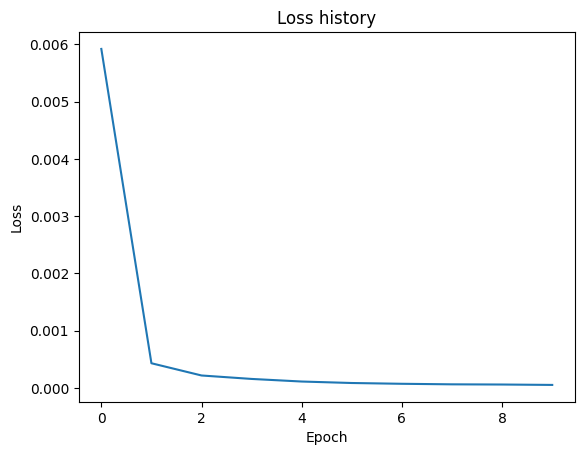

In [16]:
import matplotlib.pyplot as plt
# Plot the loss history
plt.plot(history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss history")
plt.show()

In [17]:
# Configure hyper-parameters
epochs = 20
learning_rate = 0.001
loss_func = torch.nn.MSELoss()
optimizer = torch.optim.Adam(SC_LSTM.parameters(), lr=learning_rate)

history = []
loss_accomulator = []

In [18]:
# Now train the injector using non-reschedulable tasks
SC_LSTM.train_model(mode='injector')

for epoch in range(0, epochs):
    SC_LSTM.reset_states()

    for i, (X, task_type, Y) in enumerate(tqdm(train_non_resched_dataloader, desc=f"Epoch: {epoch + 1}, Mean Loss: {mean_loss}", leave=False, colour='green')):

        # Convert X and Y to the correct type
        X = torch.Tensor(X).type(torch.float32).to(device)
        Y = torch.Tensor(Y).type(torch.float32).to(device)

        # Make prediction
        Y_pred = SC_LSTM.forward(X, task_type=task_type, free_time_slots=single_interval, save_states=True)

        # Calculate loss
        loss = loss_func(Y_pred.view(-1, ), Y.view(-1, ))

        # Backward pass
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Append loss to list
        loss_accomulator.append(loss.item())

    mean_loss = np.mean(loss_accomulator)
    history.append(mean_loss)
    loss_accomulator = []

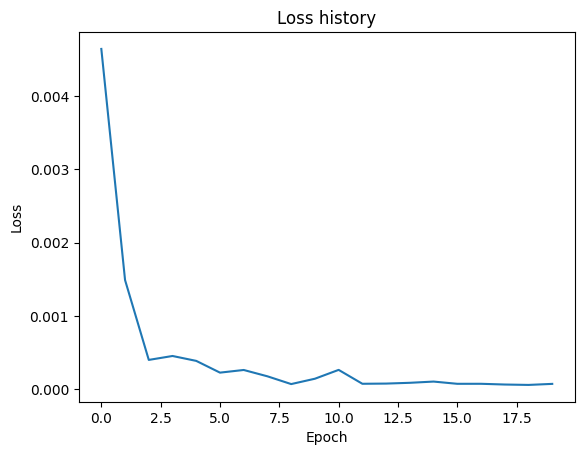

In [19]:
# Plot the loss history
plt.plot(history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss history")
plt.show()

# Save weights

In [20]:
torch.save(SC_LSTM.state_dict(), "sc_lstm_weights.pth")